In [1]:
import sys, os
sys.path.append(os.path.abspath('..'))
from cpsr import *
import time
import numpy as np
import scipy.sparse as sp

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numba
import scipy
print('numpy version', np.version.full_version)
print('scipy version', scipy.__version__)
print('numba version', numba.__version__)

numpy version 1.15.1
scipy version 1.1.0
numba version 0.36.2


## Run experiments 

In [3]:
experiment_results = []
verbose = True
np.random.seed(0)

def print_residuals(A,b,c,x,s,y,tau,kappa,res):
    print('||N(z)||        = %.2e' % (np.linalg.norm(res)/ np.abs(tau-kappa)))
    if tau == 1:
        print('||A@x + s - b|| = %.2e' % np.linalg.norm(A@x + s - b))
        print('||A.T@y + c ||  = %.2e' % np.linalg.norm(A.T@y + c ))
        print(' |c@x + b@y|    = %.2e' % np.abs(c@x + b@y))
    else:
        if np.isclose(b@y, -1):
            print('Certificate of infeasibility:')
            print('||A.T@y||       = %.2e' % np.linalg.norm(A.T@y))
            print('  b@y           = %1.2f' % (b@y))
        else:
            assert np.isclose(c@x, -1)
            print('Certificate of unboundedness:')
            print('||A@x + s||     = %.2e' % np.linalg.norm(A@x + s))
            print('  c@x           = %1.2f' % (c@x))

HOW_MANY_SOLVABLE = 0
HOW_MANY_INFEASIBLE = 0
HOW_MANY_UNBOUNDED = 0

for i in range(1000):
    
    ## GENERATE
    print('\n\nGenerating problem number %d..' % i)
    mode_choose = np.random.uniform(0,1)
    if mode_choose<.8:
        HOW_MANY_SOLVABLE += 1
        mode = 'solvable'
    if mode_choose>=.8 and mode_choose<.9:
        HOW_MANY_INFEASIBLE += 1
        mode = 'infeasible'
    if mode_choose>=.9:
        HOW_MANY_UNBOUNDED += 1
        mode = 'unbounded'

    A, b, c, dims, x_true, y_true, s_true = generate_problem(mode=mode)
    m,n = A.shape
    print('Cones:\t', dims)
    print('mode:\t', mode)
    print('(m,n):\t', A.shape)
    print('nnz(A):\t', A.nnz)
    A = sp.csc_matrix(A)

    
    ## SOLVE
    try:
        start = time.time()
        if len(dims['s']) or dims['ep'] or dims['ed']:
            solver='scs'
            approx_z, info = scs_solve(A,b,c,dims,verbose=verbose)
        else:
            solver='ecos'
            approx_z, info = ecos_solve(A,b,c,dims, verbose=verbose)
            if info['exitFlag'] < 0:
                continue
        solver_time =  time.time() - start
        if np.any(np.isnan(approx_z)):
            print('there are nans in the returned solution')
            continue
        print('solver:\t', solver)
        print('solver info:', info)
        print('solv. time:\t%.2f' % solver_time)
        approx_z /= np.abs(approx_z[-1])
        unr_res, u,v = residual_and_uv(approx_z, (A.indptr, A.indices, A.data), b,c, make_prod_cone_cache(dims))
        print('Unrefined solution:')
        x, y, tau = u[:n], u[n:-1], u[-1]
        s, kappa = v[n:-1], v[-1]
        print_residuals(A, b, c, x, s, y, tau, kappa, unr_res)
    except Exception as e:
        print('solve failed: %s'%e)
        continue    

    ## REFINE
    try:
        start = time.time()
        refined_z = refine(A,b,c, dims, approx_z, verbose=verbose, iters=2, lsqr_iters=30)
        refine_time = time.time() - start
        print('ref. time:\t%.2f' % refine_time)
        ref_res, u,v = residual_and_uv(refined_z,(A.indptr, A.indices, A.data), b,c,make_prod_cone_cache(dims))
        print('Refined solution:')
        x, y, tau = u[:n], u[n:-1], u[-1]
        s, kappa = v[n:-1], v[-1]
        print_residuals(A, b, c, x, s, y, tau, kappa, ref_res)
    except Exception as e: # catch all...
        print('refine failed: %s'%e)
        continue
        
    result = {}
    result['mode'] = mode
    result['dims'] = dims
    result['Annz'] = A.nnz
    result['(m,n)'] = A.shape
    result['solver'] = solver
    result['solver_info'] = info
    result['solver_time'] = solver_time
    result['unrefined_resnorm'] = np.linalg.norm(unr_res / approx_z[-1])
    result['refine_time'] = refine_time
    result['refined_resnorm'] = np.linalg.norm(ref_res / refined_z[-1])
    
    experiment_results.append(result)



Generating problem number 0..
Cones:	 {'z': 38, 'l': 68, 'q': [11, 14, 11, 18, 19, 10, 16, 12, 13, 18, 6, 6, 5, 17, 16, 18, 19, 16, 11, 16, 6, 14, 7, 19, 12, 11, 8, 16, 11, 13, 5, 14, 14, 14, 19, 15, 10, 11, 15, 5, 15, 15, 8, 6, 9, 10, 13, 11, 19, 6, 8, 7, 14, 8, 11, 8, 7, 6, 14, 7, 7, 10, 17], 's': [8, 2, 9, 5, 9, 6], 'ep': 7, 'ed': 2}
mode:	 solvable
(m,n):	 (1045, 310)
nnz(A):	 72577
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 72577, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 310, constraints m = 1045
Cones:	primal zero / dual free vars: 38
	linear vars: 68
	soc vars: 747, soc blks: 63
	sd vars: 165, sd blks: 6
	exp vars: 21, dual e

Cones:	 {'z': 28, 'l': 42, 'q': [17, 8, 12, 16, 15, 8, 17, 19, 18, 15, 17, 6, 19, 5, 11, 11, 12, 7, 18, 8, 18, 7, 15, 7, 10, 14, 15, 8, 13, 7, 5, 7, 13, 8, 5, 18, 18, 19, 11, 19, 5, 18, 13, 13, 13, 6, 12, 7, 14, 16, 11, 12, 11, 11, 13, 9, 6, 12, 11, 17, 7, 14, 15, 11, 17, 9, 9, 14, 6, 11, 11, 16, 7, 6, 8, 14, 9, 15, 7, 17, 7, 14, 18], 's': [3, 6, 9, 7, 6, 6, 3], 'ep': 4, 'ed': 9}
mode:	 solvable
(m,n):	 (1245, 718)
nnz(A):	 179523
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 179523, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 718, constraints m = 1245
Cones:	primal zero / dual free vars: 28
	linear vars: 42
	soc vars: 988, soc blks: 83
	sd

Cones:	 {'z': 39, 'l': 41, 'q': [18, 5, 16, 9, 15, 8, 9, 17, 12, 13, 12, 11, 8, 13, 17, 8, 15, 5, 6, 12, 18, 12, 14, 16, 12, 8, 5, 17, 10, 16], 's': [7, 5, 2, 3, 7, 9, 9, 8, 7, 2, 4, 3, 7, 8, 3, 7, 5, 9, 6], 'ep': 8, 'ed': 9}
mode:	 solvable
(m,n):	 (920, 667)
nnz(A):	 126648
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 126648, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 667, constraints m = 920
Cones:	primal zero / dual free vars: 39
	linear vars: 41
	soc vars: 357, soc blks: 30
	sd vars: 432, sd blks: 19
	exp vars: 24, dual exp vars: 27
Setup time: 4.18e-03s
----------------------------------------------------------------------------
 It

----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 3.44e+20  6.28e+20  9.98e-01 -4.36e+22 -3.42e+19  3.15e+22  2.40e+00 
    20| 1.51e+01  2.80e+00  1.00e+00 -1.46e+07 -1.02e+00  1.46e+07  8.41e+00 
----------------------------------------------------------------------------
Status: Unbounded
Timing: Solve time: 8.41e+00s
	Lin-sys: avg # CG iterations: 198.52, avg solve time: 4.00e-01s
	Cones: avg projection time: 6.57e-05s
	Acceleration: avg step time: 1.70e-04s
----------------------------------------------------------------------------
Certificate of dual infeasibility:
dist(s, K) = 4.7396e-22
|Ax + s|_2 * |c|_2 = 1.1101e-06
c'x = -1.0000
solver:	 scs
solver info: {'statusVal': -1, 'iter': 20, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': nan, 'resUnbdd': 1.

2	1.63e-06	0	SOL	30	0.03
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.03
Refined solution:
||N(z)||        = 1.63e-06
||A@x + s - b|| = 1.58e-06
||A.T@y + c ||  = 3.79e-07
 |c@x + b@y|    = 1.35e-07


Generating problem number 9..
Cones:	 {'z': 44, 'l': 95, 'q': [12, 10, 12, 15, 16, 9, 18, 13, 6, 13, 19, 13, 13, 6, 19, 9, 12, 6, 18, 8, 11, 8, 15, 19, 16, 7, 16, 10, 10, 19, 17, 5, 14, 6, 12, 10, 18, 16, 15, 6, 11, 18, 5, 19, 12, 16, 11, 18, 13, 13, 15, 9, 8, 16, 13, 7, 10, 19, 8, 19, 19, 6, 7, 9, 6, 5, 17, 19, 7, 10, 15, 12, 17, 5, 7, 9, 11, 12, 5, 16], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (1110, 396)
nnz(A):	 122559

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +7.318e-01  -8.252e+02  +1e+03  3e-01  4e+00  1e+00  7e+00  

2	8.68e-06	0	SOL	30	0.18
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.18
Refined solution:
||N(z)||        = 8.68e-06
||A@x + s - b|| = 8.49e-06
||A.T@y + c ||  = 1.75e-06
 |c@x + b@y|    = 4.42e-07


Generating problem number 11..
Cones:	 {'z': 29, 'l': 23, 'q': [14, 18, 17, 5, 15, 13, 7, 7, 10, 8, 13, 14, 9, 11, 14, 8, 13, 7, 17, 8, 7, 18, 8, 19, 8, 17, 9, 16, 12, 7, 18, 11, 16, 5, 10, 17, 10, 6, 10, 7], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (511, 133)
nnz(A):	 18989

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -1.205e+00  -1.819e+02  +4e+02  3e-01  2e+00  1e+00  5e+00    ---    ---    1  1  - |  -  - 
 1  +2.337e+00  -3.039e+01  +8e+01  7e-02  3e-01  8e-01  1e+00  0.8266  7e-02   1  1  1 |  0  0
 2  +9.238e-01  -1.136

50    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
51    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
52    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
53    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
54    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
55    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
56    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
57    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
58    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
59    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
60    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
61    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
62    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
63    nan    nan  nan  na

Cones:	 {'z': 28, 'l': 93, 'q': [7, 19, 15, 5, 6, 13, 15, 5, 15, 17, 18, 18, 5, 16, 13, 19, 6, 7, 10, 19, 17, 14, 19, 18, 14, 7, 13, 14, 14, 14, 15, 13, 10, 12, 13, 19, 5, 18, 12, 6, 13, 11, 14, 6, 16, 11, 13, 8, 19, 10, 13, 6, 16, 12, 10, 5, 17, 14, 14, 18, 14, 5, 14, 8, 6, 6, 7, 5, 10], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (957, 400)
nnz(A):	 143962

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -1.871e+00  -7.560e+02  +1e+03  3e-01  4e+00  1e+00  6e+00    ---    ---    1  1  - |  -  - 
 1  +1.431e+01  -1.286e+02  +2e+02  6e-02  1e+00  1e+00  1e+00  0.8875  1e-01   1  1  1 |  0  0
 2  +1.014e+01  -2.860e+01  +6e+01  2e-02  3e-01  4e-01  4e-01  0.8175  1e-01   1  1  1 |  0  0
 3  +4.980e+00  -1.604e+01  +3e+01  9e-03  2e-01  2e-01  2e-01  0.7162  3e-01   1  1  1 |  0  0
 4  +1.708e+00  -2.380e+00  +6e+00  2e-03  4e-02  4e-02  4e-02

   100| 5.46e+17  4.96e+17  8.70e-01 -2.62e+21 -1.83e+20  2.44e+21  2.23e-01 
   180| 5.82e+15  3.62e+15  8.69e-01 -2.62e+21 -1.83e+20  2.43e+21  3.65e-01 
----------------------------------------------------------------------------
Status: Unbounded
Timing: Solve time: 3.65e-01s
	Lin-sys: avg # CG iterations: 30.17, avg solve time: 1.70e-03s
	Cones: avg projection time: 1.59e-04s
	Acceleration: avg step time: 1.14e-04s
----------------------------------------------------------------------------
Certificate of dual infeasibility:
dist(s, K) = 1.3197e-07
|Ax + s|_2 * |c|_2 = 9.8360e-06
c'x = -1.0000
solver:	 scs
solver info: {'statusVal': -1, 'iter': 180, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': nan, 'resUnbdd': 9.835992645497512e-06, 'solveTime': 365.379511, 'setupTime': 2.022586, 'status': 'Unbounded'}
solv. time:	0.37
Unrefined solution:
||N(z)||        = 4.92e-05
Certificate of unboundedness:
||A@x + s||     = 4.92e-05
  c@x           = 

   100| 2.14e-05  8.66e-06  2.52e-05 -5.80e-01 -5.80e-01  1.07e-14  8.83e-01 
   120| 2.78e-06  1.99e-06  4.75e-06 -5.80e-01 -5.80e-01  4.84e-15  9.19e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 9.19e-01s
	Lin-sys: avg # CG iterations: 18.72, avg solve time: 7.36e-03s
	Cones: avg projection time: 9.48e-05s
	Acceleration: avg step time: 8.69e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.1429e-09, dist(y, K*) = 2.9758e-09, s'y/|s||y| = -5.5029e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 2.7792e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.9892e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 4.7536e-06
----------------------------------------------------------------------------
c'x = -0.5802, -b'y = -0.5802
solver:	 scs
solver info: {'statusVal': 1, 'iter': 120, 'pobj': -0.5802228733590542, 'dobj': -0.5802331433722816, 'resPri': 2.77917992673566

   300| 1.72e-01  3.01e-03  1.20e-01 -3.64e-01 -1.79e-01  1.58e-14  4.93e+01 
   400| 5.67e-02  1.37e-03  1.47e-01 -1.49e-01  2.39e-02  7.68e-15  6.32e+01 
   500| 2.29e-02  8.59e-04  9.48e-02 -2.50e-02  7.98e-02  2.25e-14  7.83e+01 
   600| 5.09e-02  1.84e-03  1.32e-01 -5.95e-03  1.46e-01  1.01e-14  9.32e+01 
   700| 1.58e-02  4.18e-04  1.58e-02  5.14e-02  6.91e-02  2.13e-14  1.08e+02 
   800| 2.26e-02  3.35e-04  2.97e-02  5.53e-02  8.93e-02  1.43e-14  1.22e+02 
   900| 3.65e-02  1.03e-03  9.07e-02  6.20e-02  1.74e-01  4.26e-14  1.39e+02 
  1000| 6.58e-03  1.58e-04  3.41e-03  8.26e-02  8.66e-02  2.18e-15  1.53e+02 
  1100| 2.23e-03  8.59e-05  1.93e-03  8.76e-02  8.99e-02  2.15e-14  1.66e+02 
  1200| 4.39e-03  5.44e-05  4.69e-03  9.21e-02  9.76e-02  2.21e-14  1.79e+02 
  1300| 5.22e-03  9.27e-05  6.16e-03  8.75e-02  9.48e-02  4.74e-15  1.92e+02 
  1400| 7.07e-04  2.24e-05  1.49e-03  9.51e-02  9.33e-02  3.36e-15  2.04e+02 
  1500| 1.12e-03  2.66e-05  3.94e-04  9.50e-02  9.46e-02  4.46e-

Cones:	 {'z': 46, 'l': 97, 'q': [8, 13, 7, 5, 11, 6, 16, 7, 8, 11, 5, 12, 7, 11, 10, 14, 13, 10, 16, 18, 9, 16, 7, 17, 17, 8, 12, 11, 11, 13, 17, 7, 9, 15, 12, 15, 11, 8, 12, 8, 10, 17, 7, 15, 19, 11, 12, 12, 7, 11, 10], 's': [7, 6, 9, 5, 9, 2, 3, 5, 6, 2, 8, 8, 9, 3, 6, 5, 3, 9, 2], 'ep': 7, 'ed': 3}
mode:	 infeasible
(m,n):	 (1162, 633)
nnz(A):	 292455
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 292455, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 633, constraints m = 1162
Cones:	primal zero / dual free vars: 46
	linear vars: 97
	soc vars: 574, soc blks: 51
	sd vars: 415, sd blks: 19
	exp vars: 21, dual exp vars: 9
Setup time: 1.23e-02s


Cones:	 {'z': 27, 'l': 48, 'q': [9, 14, 5, 14, 19, 13, 19, 10, 5, 18, 9, 13, 9, 12, 15, 10, 18, 11, 11, 7, 11, 5, 8, 13, 8, 7, 7, 11, 9, 9, 14, 13, 9, 14, 8, 18, 9, 14, 18, 11, 5, 11, 14, 6, 8, 8, 16, 12, 10, 13, 13, 14, 14, 12, 19, 11, 10, 14, 18, 6, 14, 7, 12, 16, 5, 16, 17, 11, 6, 13, 12, 19], 's': [7, 6, 7, 2, 9, 4, 7, 9], 'ep': 7, 'ed': 2}
mode:	 infeasible
(m,n):	 (1149, 267)
nnz(A):	 68800
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 68800, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 267, constraints m = 1149
Cones:	primal zero / dual free vars: 27
	linear vars: 48
	soc vars: 839, soc blks: 72
	sd vars: 208, sd blks: 8
	exp vars: 21

----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.47e+02  4.68e+01  8.35e-01 -1.56e+04 -1.41e+03  0.00e+00  4.12e-01 
   100| 1.42e-01  2.22e-02  7.54e-01 -5.91e-01  2.48e+00  1.44e-14  1.19e+01 
   200| 1.32e-02  8.90e-04  6.06e-02  1.03e-01  1.80e-01  5.95e-14  2.10e+01 
   300| 3.03e-01  5.39e-03  6.42e-02  2.51e-01  3.54e-01  9.88e-01  3.06e+01 
   400| 5.65e-03  5.90e-04  1.92e-02  1.60e-01  1.86e-01  2.13e-02  4.26e+01 
   500| 1.01e-02  2.19e-03  2.12e-01  2.02e-01 -6.73e-02  8.36e-14  5.39e+01 
   600| 2.75e-03  5.43e-04  1.35e-02  1.96e-01  1.77e-01  6.43e-16  6.56e+01 
   700| 7.84e-03  2.54e-03  2.08e-01  1.97e-01  5.63e-01  3.16e-14  7.93e+01 
   800| 5.72e-04  7.11e-05  4.79e-03  1.79e-01  1.72e-01  6.07e-14  9.27e+01 
   900| 2.12e-03  2.00e-04  3.42e-02  1.74e-01  2.21e-01  8.03e-03 

     0| 5.35e+01  1.68e+01  6.64e-01 -3.59e+03 -7.24e+02  0.00e+00  4.47e-02 
   100| 1.23e-07  7.95e-08  7.44e-07 -1.24e-01 -1.24e-01  1.38e-14  2.86e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.86e-01s
	Lin-sys: avg # CG iterations: 2.75, avg solve time: 2.58e-03s
	Cones: avg projection time: 1.17e-04s
	Acceleration: avg step time: 6.59e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.1211e-09, dist(y, K*) = 2.6023e-09, s'y/|s||y| = 1.5923e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.2342e-07
dual res:   |A'y + c|_2 / (1 + |c|_2) = 7.9497e-08
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 7.4427e-07
----------------------------------------------------------------------------
c'x = -0.1237, -b'y = -0.1237
solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': -0.12373071748200727, 'dobj': -0.1237297890296599, 'resPri': 1.234168471810852

Cones:	 {'z': 21, 'l': 85, 'q': [11, 7, 14, 18, 15, 5, 6, 14, 13, 18, 8, 7, 10, 6, 7, 18, 19, 16, 8, 7, 13, 8, 11, 9, 9, 14, 14, 5, 9, 13, 7, 19, 7, 14, 10, 19, 7, 13, 14, 18, 17, 9, 13], 's': [5, 4, 6, 3, 2, 5, 7, 3, 8], 'ep': 4, 'ed': 6}
mode:	 solvable
(m,n):	 (775, 348)
nnz(A):	 66187
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 66187, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 348, constraints m = 775
Cones:	primal zero / dual free vars: 21
	linear vars: 85
	soc vars: 499, soc blks: 43
	sd vars: 140, sd blks: 9
	exp vars: 12, dual exp vars: 18
Setup time: 3.10e-03s
---------------------------------------------------------------------

----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 4.15e+20  7.44e+20  9.97e-01 -4.48e+22 -6.37e+19  3.16e+22  1.87e+00 
    40| 2.08e+14  9.16e+12  1.00e+00 -5.73e+21  4.81e+13  5.73e+21  9.92e+00 
----------------------------------------------------------------------------
Status: Unbounded
Timing: Solve time: 9.92e+00s
	Lin-sys: avg # CG iterations: 127.56, avg solve time: 2.41e-01s
	Cones: avg projection time: 6.09e-05s
	Acceleration: avg step time: 1.98e-04s
----------------------------------------------------------------------------
Certificate of dual infeasibility:
dist(s, K) = 4.4662e-23
|Ax + s|_2 * |c|_2 = 4.0424e-08
c'x = -1.0000
solver:	 scs
solver info: {'statusVal': -1, 'iter': 40, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 4.072519399832319, 

Cones:	 {'z': 18, 'l': 69, 'q': [19, 8, 9, 19, 15, 14, 5, 7, 16, 18, 12, 7, 10, 7, 6, 12, 17, 17, 8, 12, 13, 7, 18, 10, 8, 17, 16, 13, 19, 19, 14, 15, 6, 17, 9, 13, 19, 16, 17, 18, 17, 10, 13, 9, 19, 18, 11, 7, 12, 5, 6, 17, 13, 7, 13, 11, 19, 15, 17, 13, 13, 16, 16, 9, 16, 12, 8, 14, 15, 10, 16, 19, 18, 9, 18, 10, 14, 10, 17, 8], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (1129, 823)
nnz(A):	 266497

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +5.573e-01  -6.934e+02  +8e+02  2e-01  4e+00  1e+00  5e+00    ---    ---    1  2  - |  -  - 
 1  +1.099e+01  -7.673e+01  +1e+02  3e-02  8e-01  6e-01  1e+00  0.8695  6e-02   1  2  2 |  0  0
 2  +3.794e+00  -1.358e+01  +3e+01  7e-03  2e-01  1e-01  2e-01  0.9136  1e-01   1  2  2 |  0  0
 3  +2.106e+00  -3.978e+00  +9e+00  2e-03  6e-02  6e-02  6e-02  0.7569  1e-01   2  2  2 |  0  0
 4  +6.895e-01  -1


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +9.605e-02  -5.214e+02  +6e+02  2e-01  4e+00  1e+00  5e+00    ---    ---    2  2  - |  -  - 
 1  +7.446e+00  -6.831e+01  +1e+02  4e-02  7e-01  6e-01  1e+00  0.8437  5e-02   2  2  2 |  0  0
 2  +2.782e+00  -1.029e+01  +2e+01  7e-03  1e-01  1e-01  2e-01  0.9044  9e-02   2  2  2 |  0  0
 3  +1.226e+00  -3.413e+00  +7e+00  2e-03  5e-02  6e-02  5e-02  0.8326  2e-01   2  2  2 |  0  0
 4  +6.786e-02  -1.580e+00  +2e+00  9e-04  2e-02  2e-02  2e-02  0.8726  2e-01   1  1  2 |  0  0
 5  -3.398e-01  -5.465e-01  +2e-01  1e-04  3e-03  2e-03  2e-03  0.9222  5e-02   1  1  1 |  0  0
 6  -4.007e-01  -4.297e-01  +3e-02  1e-05  4e-04  3e-04  3e-04  0.9170  6e-02   1  1  1 |  0  0
 7  -4.106e-01  -4.123e-01  +2e-03  9e-07  2e-05  2e-05  2e-05  0.9447  5e-03   1  1  1 |  0  0
 8  -4.112e-01  -4.114e-01  +2e-04  7e-08  2e-

 3  +1.768e+00  -2.941e+00  +7e+00  2e-03  6e-02  6e-02  5e-02  0.8315  1e-01   2  1  2 |  0  0
 4  +1.338e+00  -2.030e+00  +4e+00  2e-03  5e-02  4e-02  3e-02  0.5775  4e-01   2  1  1 |  0  0
 5  +7.699e-01  -3.360e-01  +1e+00  6e-04  2e-02  1e-02  1e-02  0.7725  9e-02   2  2  2 |  0  0
 6  +5.764e-01  +8.042e-02  +6e-01  3e-04  7e-03  4e-03  4e-03  0.9890  4e-01   2  1  1 |  0  0
 7  +4.228e-01  +3.791e-01  +5e-02  2e-05  7e-04  4e-04  4e-04  0.9242  1e-02   2  1  2 |  0  0
 8  +4.104e-01  +4.009e-01  +1e-02  5e-06  1e-04  8e-05  8e-05  0.8670  1e-01   1  1  1 |  0  0
 9  +4.075e-01  +4.058e-01  +2e-03  9e-07  2e-05  1e-05  1e-05  0.8520  3e-02   1  1  1 |  0  0
10  +4.072e-01  +4.063e-01  +1e-03  5e-07  1e-05  9e-06  9e-06  0.5933  3e-01   1  1  1 |  0  0
11  +4.069e-01  +4.068e-01  +8e-05  4e-08  1e-06  7e-07  6e-07  0.9272  2e-03   1  1  1 |  0  0
12  +4.069e-01  +4.069e-01  +3e-06  1e-09  4e-08  2e-08  2e-08  0.9808  2e-02   2  1  1 |  0  0
13  +4.069e-01  +4.069e-01  +4e-08  2e-1

   100| 1.32e-06  7.71e-07  2.08e-07  2.59e-01  2.59e-01  1.26e-14  3.31e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.31e-01s
	Lin-sys: avg # CG iterations: 4.15, avg solve time: 2.97e-03s
	Cones: avg projection time: 1.84e-04s
	Acceleration: avg step time: 6.49e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.4785e-09, dist(y, K*) = 2.5490e-09, s'y/|s||y| = 5.1492e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.3242e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 7.7149e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 2.0778e-07
----------------------------------------------------------------------------
c'x = 0.2591, -b'y = 0.2591
solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': 0.2591335183639937, 'dobj': 0.2591332029060708, 'resPri': 1.3242034567445642e-06, 'resDual': 7.714863177570177e-07, 'relGap': 2.0777503614838627e-07, 'resInfe

   100| 1.01e-05  4.39e-06  1.29e-05  1.69e-01  1.69e-01  7.66e-15  2.72e-01 
   120| 3.31e-06  1.88e-06  5.63e-06  1.69e-01  1.69e-01  2.87e-14  3.03e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.03e-01s
	Lin-sys: avg # CG iterations: 3.24, avg solve time: 2.21e-03s
	Cones: avg projection time: 1.56e-04s
	Acceleration: avg step time: 6.81e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 3.0845e-09, dist(y, K*) = 2.4283e-09, s'y/|s||y| = -2.1503e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 3.3066e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.8791e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 5.6329e-06
----------------------------------------------------------------------------
c'x = 0.1688, -b'y = 0.1688
solver:	 scs
solver info: {'statusVal': 1, 'iter': 120, 'pobj': 0.1688290487930728, 'dobj': 0.16883658372474078, 'resPri': 3.3065963836581738e-

    60| 8.47e-07  5.05e-07  6.00e-06 -1.58e-01 -1.58e-01  2.16e-14  1.16e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.16e-01s
	Lin-sys: avg # CG iterations: 4.31, avg solve time: 1.59e-03s
	Cones: avg projection time: 1.98e-04s
	Acceleration: avg step time: 4.79e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.7971e-09, dist(y, K*) = 2.4804e-09, s'y/|s||y| = -2.9131e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 8.4680e-07
dual res:   |A'y + c|_2 / (1 + |c|_2) = 5.0527e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 6.0001e-06
----------------------------------------------------------------------------
c'x = -0.1584, -b'y = -0.1584
solver:	 scs
solver info: {'statusVal': 1, 'iter': 60, 'pobj': -0.1584193247809012, 'dobj': -0.15841142361982988, 'resPri': 8.468047139531856e-07, 'resDual': 5.052732232320721e-07, 'relGap': 6.0001340953827006e-06, 'res

2	4.56e-07	0	SOL	30	0.06
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.06
Refined solution:
||N(z)||        = 4.56e-07
||A@x + s - b|| = 4.15e-07
||A.T@y + c ||  = 1.83e-07
 |c@x + b@y|    = 4.69e-08


Generating problem number 48..
Cones:	 {'z': 26, 'l': 30, 'q': [14, 8, 5, 15, 14, 17, 7, 9, 17, 15, 13, 17, 12, 15, 19, 7, 15, 15, 11, 16, 11, 10, 11, 15, 6, 6, 16, 12, 9, 13, 9, 14, 8, 13, 12, 13, 17, 6, 10, 11, 11, 11, 14, 17, 15, 9, 7, 14, 18, 14, 6, 12, 15, 18, 11, 13, 6, 5, 13, 17, 12, 11, 5, 13, 9, 12, 7, 11, 17, 18, 9, 8, 7, 17, 17], 's': [6, 3, 5, 9, 8], 'ep': 9, 'ed': 2}
mode:	 unbounded
(m,n):	 (1114, 722)
nnz(A):	 180887
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin

1	2.74e-06	0	SOL	30	0.05
2	1.83e-06	0	SOL	30	0.09
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.09
Refined solution:
||N(z)||        = 1.83e-06
||A@x + s - b|| = 1.78e-06
||A.T@y + c ||  = 4.32e-07
 |c@x + b@y|    = 8.25e-08


Generating problem number 51..
Cones:	 {'z': 46, 'l': 68, 'q': [14, 13, 19, 14, 18, 17, 18, 10, 17, 5, 5, 12, 14, 16, 7, 5, 11, 17, 12, 7, 15, 17, 8, 16, 11, 15, 6, 17, 6, 8, 10, 14], 's': [8, 2, 8, 6, 8, 6, 2, 9, 3, 5, 2, 3, 5, 2, 7, 8, 9], 'ep': 3, 'ed': 6}
mode:	 solvable
(m,n):	 (893, 318)
nnz(A):	 76126
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 76126, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_ite

2	7.41e-06	0	SOL	30	0.24
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.24
Refined solution:
||N(z)||        = 7.41e-06
||A@x + s - b|| = 7.20e-06
||A.T@y + c ||  = 1.75e-06
 |c@x + b@y|    = 2.53e-08


Generating problem number 53..
Cones:	 {'z': 38, 'l': 37, 'q': [14, 17, 8, 6, 15, 11, 6, 6, 16, 10, 18, 14, 8, 15, 16, 9, 14, 7, 17, 17, 16, 9, 15, 12, 13, 7, 8, 9, 9, 5, 6, 8, 8, 5, 15, 19, 5, 11, 7, 12, 12, 10, 7, 6, 11, 12, 8, 10, 11, 15, 7, 13, 5, 14, 7, 9, 9, 8, 19, 17, 6, 13, 19, 13, 15, 12, 8, 9, 7, 18, 15, 7, 12, 18, 9, 8, 11, 8, 10, 12, 17, 12, 13, 13, 5, 6, 12], 's': [5, 5, 8, 3, 7, 7, 9, 5, 4, 2, 7, 5, 3, 6], 'ep': 2, 'ed': 9}
mode:	 infeasible
(m,n):	 (1340, 151)
nnz(A):	 50837
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
---------------------

    60| 2.47e-06  1.54e-06  1.18e-06  2.07e-02  2.07e-02  1.39e-15  1.38e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.38e-01s
	Lin-sys: avg # CG iterations: 5.46, avg solve time: 1.95e-03s
	Cones: avg projection time: 1.70e-04s
	Acceleration: avg step time: 7.88e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 3.0152e-09, dist(y, K*) = 1.0331e-07, s'y/|s||y| = 1.6291e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 2.4653e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.5355e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.1828e-06
----------------------------------------------------------------------------
c'x = 0.0207, -b'y = 0.0207
solver:	 scs
solver info: {'statusVal': 1, 'iter': 60, 'pobj': 0.02065183318699801, 'dobj': 0.02065060158007869, 'resPri': 2.465317938190759e-06, 'resDual': 1.5355105773433458e-06, 'relGap': 1.1827562081838602e-06, 'resInf

Cones:	 {'z': 14, 'l': 24, 'q': [6, 10, 10, 5, 10, 10, 15, 12, 18, 10, 11, 19, 14, 12, 12, 14, 18, 14, 12, 15, 10, 14, 6, 10, 5, 5, 5, 5, 5, 7, 16, 9, 17, 19, 10, 14, 11, 14, 13, 13, 10, 7, 5, 6, 19, 12, 17, 6, 10, 5, 16, 5, 8, 7, 10, 17, 10, 19, 18, 7, 10, 6, 12, 5, 15, 7, 5, 10, 14], 's': [3, 3, 7, 3, 9, 4, 9, 3, 8, 3, 8, 8, 8, 6], 'ep': 2, 'ed': 8}
mode:	 solvable
(m,n):	 (1144, 1113)
nnz(A):	 259527
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 259527, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 1113, constraints m = 1144
Cones:	primal zero / dual free vars: 14
	linear vars: 24
	soc vars: 753, soc blks: 69
	sd vars: 323, sd blks: 14
	ex

Cones:	 {'z': 45, 'l': 69, 'q': [7, 17, 5, 5, 14, 8, 5, 7, 7, 7, 15, 18, 6, 18, 19, 11, 17, 12, 13, 17, 13, 18, 7, 5, 18, 10, 8, 12, 14, 17, 16, 11, 14, 14, 19, 10, 14, 18, 14, 5, 17, 13, 14, 14, 14, 10, 17, 17, 8, 15, 14, 15, 13, 9, 19, 13, 6, 8, 16, 14, 9, 17, 15, 16, 6, 8, 7, 15, 16, 8, 17, 15, 11, 18, 13, 7, 17, 18, 5, 11, 15, 13, 8, 5, 15, 12, 17, 12, 10, 7, 13, 9, 11, 18, 13, 12, 7, 11], 's': [9, 8, 3, 9, 6, 3, 9, 5, 2, 9, 2, 2, 9, 8, 4, 7, 7, 8], 'ep': 6, 'ed': 4}
mode:	 solvable
(m,n):	 (1808, 1199)
nnz(A):	 611093
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 611093, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 1199, constraints m =

10  +3.100e-01  +3.100e-01  +6e-07  4e-10  9e-09  8e-09  8e-09  0.9296  2e-04   1  1  1 |  0  0
11  +3.100e-01  +3.100e-01  +3e-08  2e-11  4e-10  4e-10  4e-10  0.9612  1e-02   2  1  1 |  0  0
12  +3.100e-01  +3.100e-01  +4e-09  4e-12  5e-11  5e-11  5e-11  0.8884  2e-02   2  1  1 |  0  0

OPTIMAL (within feastol=5.5e-11, reltol=1.3e-08, abstol=3.9e-09).
Runtime: 0.436357 seconds.

prim abs res. 2.666755558921875e-10
dua abs res. 5.818347273822482e-11
s^T y 3.9397374251848305e-09
solver:	 ecos
solver info: {'exitFlag': 0, 'pcost': 0.3099573509274273, 'dcost': 0.30995734771985917, 'pres': 3.812912223896008e-12, 'dres': 5.458910222289551e-11, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': 0.6204258221887492, 'dinfres': nan, 'gap': 3.882080388054043e-09, 'relgap': 1.2524563191070679e-08, 'r0': 1e-08, 'iter': 12, 'mi_iter': -1, 'infostring': 'Optimal solution found', 'timing': {'runtime': 0.43635746400000003, 'tsetup': 0.026712406, 'tsolve': 0.409645058}, 'numerr': 0}
solv. time:	0.44
Unrefined soluti

Cones:	 {'z': 15, 'l': 64, 'q': [5, 19, 17, 5, 17, 14, 14, 17, 17, 11, 16, 14, 9, 7, 7, 13, 18, 8, 9, 13, 10, 15, 12, 10, 17, 7, 10, 7, 12, 12, 9, 8, 19], 's': [2, 8, 7, 3, 8, 9, 7, 9, 2, 2, 5, 9], 'ep': 9, 'ed': 2}
mode:	 solvable
(m,n):	 (803, 759)
nnz(A):	 161535
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 161535, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 759, constraints m = 803
Cones:	primal zero / dual free vars: 15
	linear vars: 64
	soc vars: 398, soc blks: 33
	sd vars: 293, sd blks: 12
	exp vars: 27, dual exp vars: 6
Setup time: 7.29e-03s
----------------------------------------------------------------------------
 Iter | pri re

----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 4.59e+20  5.87e+20  9.96e-01 -4.07e+22 -8.29e+19  2.83e+22  1.39e+00 
    40| 2.09e+14  6.48e+12  1.00e+00 -5.18e+21 -3.71e+13  5.18e+21  1.02e+01 
----------------------------------------------------------------------------
Status: Unbounded
Timing: Solve time: 1.02e+01s
	Lin-sys: avg # CG iterations: 206.73, avg solve time: 2.49e-01s
	Cones: avg projection time: 7.25e-05s
	Acceleration: avg step time: 2.19e-04s
----------------------------------------------------------------------------
Certificate of dual infeasibility:
dist(s, K) = 8.9871e-23
|Ax + s|_2 * |c|_2 = 4.5121e-08
c'x = -1.0000
solver:	 scs
solver info: {'statusVal': -1, 'iter': 40, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': nan, 'resUnbdd': 4.

Cones:	 {'z': 38, 'l': 91, 'q': [15, 8, 12, 16, 18, 7, 17, 7, 6, 17, 5, 10, 11, 6, 9, 16, 18, 15, 10, 13, 13, 10, 9, 10, 12, 19, 13, 11, 16, 12, 13, 14, 14, 5, 14, 9, 13, 13, 17, 10, 8, 15, 12, 15], 's': [4, 7, 3, 2, 3, 2, 5, 9, 7, 3, 8, 8, 9, 7, 3, 9, 5, 6], 'ep': 7, 'ed': 2}
mode:	 solvable
(m,n):	 (1071, 826)
nnz(A):	 221091
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 221091, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 826, constraints m = 1071
Cones:	primal zero / dual free vars: 38
	linear vars: 91
	soc vars: 533, soc blks: 44
	sd vars: 382, sd blks: 18
	exp vars: 21, dual exp vars: 6
Setup time: 9.40e-03s
---------------------------

 1  +8.302e+00  -8.978e+01  +3e+02  7e-02  8e-01  1e+00  2e+00  0.8673  1e-01   1  1  1 |  0  0
 2  +7.001e+00  -1.768e+01  +7e+01  2e-02  2e-01  3e-01  4e-01  0.7981  8e-02   1  1  1 |  0  0
 3  +2.392e+00  -5.271e+00  +2e+01  5e-03  7e-02  1e-01  1e-01  0.8603  2e-01   1  1  1 |  0  0
 4  +7.512e-01  -2.390e-01  +3e+00  6e-04  9e-03  1e-02  2e-02  0.8995  4e-02   1  1  1 |  0  0
 5  +4.195e-01  +2.889e-01  +4e-01  8e-05  1e-03  1e-03  2e-03  0.9621  1e-01   1  1  1 |  0  0
 6  +3.726e-01  +3.533e-01  +5e-02  1e-05  2e-04  2e-04  3e-04  0.8900  4e-02   1  1  1 |  0  0
 7  +3.645e-01  +3.641e-01  +1e-03  2e-07  3e-06  3e-06  6e-06  0.9824  8e-04   2  1  1 |  0  0
 8  +3.643e-01  +3.643e-01  +2e-05  5e-09  7e-08  7e-08  1e-07  0.9798  4e-03   2  1  1 |  0  0
 9  +3.643e-01  +3.643e-01  +1e-06  3e-10  4e-09  4e-09  7e-09  0.9516  4e-04   1  1  1 |  0  0
10  +3.643e-01  +3.643e-01  +1e-07  2e-11  3e-10  3e-10  7e-10  0.9045  2e-03   2  1  1 |  0  0
11  +3.643e-01  +3.643e-01  +1e-08  3e-1

Cones:	 {'z': 41, 'l': 23, 'q': [6, 17, 18, 18, 12, 16, 8, 17, 18, 16, 13, 5, 19, 12, 19, 9, 17, 9, 12, 7, 9, 14, 6, 17, 19, 5, 19, 7, 18, 12, 18, 8, 18, 13, 11, 19, 14, 11, 14, 7, 9, 18, 15, 10, 8, 15, 18, 13, 8, 13, 18, 16, 18], 's': [6, 4, 8, 7, 4, 5, 7, 3, 3], 'ep': 6, 'ed': 9}
mode:	 unbounded
(m,n):	 (975, 750)
nnz(A):	 154991
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 154991, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 750, constraints m = 975
Cones:	primal zero / dual free vars: 41
	linear vars: 23
	soc vars: 706, soc blks: 53
	sd vars: 160, sd blks: 9
	exp vars: 18, dual exp vars: 27
Setup time: 5.66e-03s
-----------------------

 6  +1.321e-01  +1.290e-01  +8e-03  6e-06  5e-05  7e-05  1e-04  0.9127  1e-02   1  1  1 |  0  0
 7  +1.314e-01  +1.310e-01  +1e-03  8e-07  6e-06  9e-06  2e-05  0.9333  8e-02   2  1  1 |  0  0
 8  +1.313e-01  +1.313e-01  +3e-05  2e-08  2e-07  2e-07  4e-07  0.9800  6e-03   2  1  1 |  0  0
 9  +1.313e-01  +1.313e-01  +5e-07  4e-10  3e-09  4e-09  8e-09  0.9830  5e-04   2  1  1 |  0  0
10  +1.313e-01  +1.313e-01  +3e-08  2e-11  1e-10  2e-10  4e-10  0.9522  1e-04   2  1  1 |  0  0
11  +1.313e-01  +1.313e-01  +2e-09  2e-12  1e-11  2e-11  3e-11  0.9240  2e-03   3  1  1 |  0  0

OPTIMAL (within feastol=1.1e-11, reltol=1.5e-08, abstol=2.0e-09).
Runtime: 0.352482 seconds.

prim abs res. 7.973044127930886e-11
dua abs res. 1.5688664970538406e-11
s^T y 1.07443387520334e-09
solver:	 ecos
solver info: {'exitFlag': 0, 'pcost': 0.1312990659946441, 'dcost': 0.1312990652706936, 'pres': 1.8788308657261975e-12, 'dres': 1.0804667058075134e-11, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': 0.5895785196382745, 'dinfres

Cones:	 {'z': 38, 'l': 62, 'q': [18, 9, 19, 17, 13, 12, 18, 11, 14, 15, 18, 17, 14, 15, 12, 10, 9, 10, 17, 6, 16, 5, 18, 7, 13, 13, 7, 18, 8, 16, 19, 9, 10, 10, 11, 11, 12, 14, 16, 17, 8, 10, 13, 14, 9, 18, 14, 7, 17, 13, 13, 5, 11, 18, 5, 17, 14, 9, 15, 16, 7, 14, 18, 12, 14], 's': [], 'ep': 0, 'ed': 0}
mode:	 unbounded
(m,n):	 (935, 518)
nnz(A):	 106659

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +2.685e+00  -1.091e+02  +7e+02  2e-01  3e+00  1e+00  6e+00    ---    ---    2  3  - |  -  - 
 1  -4.203e+02  -1.445e+03  +1e+02  1e+00  9e+01  7e+01  1e+00  0.8854  9e-02   2  2  2 |  0  0
 2  -2.873e+02  -8.731e+01  +4e+01  1e-01  3e+01  3e+02  3e-01  0.9890  3e-01   2  2  2 |  0  0
 3  -2.974e+04  -1.404e+02  +6e-01  1e-01  1e+02  3e+04  5e-03  0.9859  2e-04   2  2  2 |  0  0
 4  -2.701e+06  -1.415e+02  +6e-03  1e-01  1e+02  3e+06  5e-05  0.9890  

   100| 2.10e-01  1.76e-03  5.89e-01 -5.92e+00 -1.16e+00  1.14e-12  1.27e+00 
   200| 1.58e-03  1.84e-05  5.92e-03  2.12e-01  2.20e-01  2.76e-12  2.26e+00 
   300| 2.53e-05  4.16e-07  4.35e-05  2.20e-01  2.20e-01  1.58e-12  2.94e+00 
   380| 1.96e-06  3.55e-08  2.36e-06  2.20e-01  2.20e-01  5.62e-13  3.31e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.31e+00s
	Lin-sys: avg # CG iterations: 4.50, avg solve time: 8.15e-03s
	Cones: avg projection time: 2.48e-04s
	Acceleration: avg step time: 1.72e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 6.9225e-09, dist(y, K*) = 3.0359e-09, s'y/|s||y| = -1.3422e-10
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.9585e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 3.5532e-08
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 2.3589e-06
----------------------------------------------------------------------------
c'x = 0.2202, -

     0| 9.67e+20  3.70e+21  1.00e+00 -4.66e+22  1.07e+21  9.62e+21  2.07e-01 
    40| 1.20e+15  1.53e+15  1.00e+00 -1.76e+21 -1.69e+14  1.76e+21  2.78e+00 
----------------------------------------------------------------------------
Status: Unbounded
Timing: Solve time: 2.78e+00s
	Lin-sys: avg # CG iterations: 123.93, avg solve time: 6.76e-02s
	Cones: avg projection time: 8.56e-05s
	Acceleration: avg step time: 1.25e-04s
----------------------------------------------------------------------------
Certificate of dual infeasibility:
dist(s, K) = 1.0344e-23
|Ax + s|_2 * |c|_2 = 1.2154e-06
c'x = -1.0000
solver:	 scs
solver info: {'statusVal': -1, 'iter': 40, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': nan, 'resUnbdd': 1.2154026592958562e-06, 'solveTime': 2783.032709, 'setupTime': 6.415049, 'status': 'Unbounded'}
solv. time:	2.79
Unrefined solution:
||N(z)||        = 1.56e-05
Certificate of unboundedness:
||A@x + s||     = 1.56e-05
  c@x           

   100| 3.01e-06  1.63e-06  7.06e-06  5.00e-01  5.00e-01  1.54e-14  9.14e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 9.14e-01s
	Lin-sys: avg # CG iterations: 10.00, avg solve time: 8.59e-03s
	Cones: avg projection time: 2.80e-04s
	Acceleration: avg step time: 9.98e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 3.9911e-09, dist(y, K*) = 1.9089e-09, s'y/|s||y| = -1.3140e-10
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 3.0097e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.6292e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 7.0640e-06
----------------------------------------------------------------------------
c'x = 0.5002, -b'y = 0.5003
solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': 0.5002390791083038, 'dobj': 0.5002532105645342, 'resPri': 3.009658127970291e-06, 'resDual': 1.629194187482407e-06, 'relGap': 7.063989350704364e-06, 'resInfe

12  +4.334e-01  +4.334e-01  +4e-06  2e-09  7e-08  5e-08  4e-08  0.9890  2e-01   1  1  1 |  0  0
13  +4.334e-01  +4.334e-01  +1e-07  5e-11  2e-09  1e-09  8e-10  0.9768  2e-04   2  1  1 |  0  0
14  +4.334e-01  +4.334e-01  +1e-09  7e-13  2e-11  1e-11  1e-11  0.9865  1e-04   1  1  1 |  0  0

OPTIMAL (within feastol=2.1e-11, reltol=3.2e-09, abstol=1.4e-09).
Runtime: 1.165765 seconds.

prim abs res. 3.1539340607815056e-11
dua abs res. 1.9641640937756614e-11
s^T y 1.7994405965282567e-09
solver:	 ecos
solver info: {'exitFlag': 0, 'pcost': 0.4333603048441698, 'dcost': 0.43336030325368535, 'pres': 6.997059360388828e-13, 'dres': 2.0997687295648682e-11, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': 0.7366466669132387, 'dinfres': nan, 'gap': 1.4038185197629005e-09, 'relgap': 3.2393795860464804e-09, 'r0': 1e-08, 'iter': 14, 'mi_iter': -1, 'infostring': 'Optimal solution found', 'timing': {'runtime': 1.165765435, 'tsetup': 0.073749001, 'tsolve': 1.092016434}, 'numerr': 0}
solv. time:	1.17
Unrefined solution:


   100| 3.08e+01  1.02e+01  1.00e+00 -1.04e+04  5.41e+03  1.73e+04  3.96e+00 
   200| 1.12e+16  8.23e+15  1.00e+00 -2.90e+21  1.62e+21  4.52e+21  7.54e+00 
----------------------------------------------------------------------------
Status: Infeasible
Timing: Solve time: 7.54e+00s
	Lin-sys: avg # CG iterations: 11.92, avg solve time: 3.67e-02s
	Cones: avg projection time: 2.71e-04s
	Acceleration: avg step time: 2.76e-04s
----------------------------------------------------------------------------
Certificate of primal infeasibility:
dist(y, K*) = 2.5901e-05
|A'y|_2 * |b|_2 = 7.3336e-06
b'y = -1.0000
solver:	 scs
solver info: {'statusVal': -2, 'iter': 200, 'pobj': inf, 'dobj': inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 7.333569165125175e-06, 'resUnbdd': 9.31234921117727e-05, 'solveTime': 7541.413708, 'setupTime': 32.492064, 'status': 'Infeasible'}
solv. time:	7.59
Unrefined solution:
||N(z)||        = 1.24e-04
Certificate of infeasibility:
||A.T@y||       = 1.21e-04

Cones:	 {'z': 33, 'l': 50, 'q': [10, 8, 19, 9, 8, 12, 11, 9, 5, 19, 12, 10, 7, 6, 11, 7, 13, 14, 12, 8, 19, 17, 13, 14, 14, 16, 17, 17, 15, 14, 18, 11, 14, 8, 7, 5, 8, 11, 9, 11, 8, 8, 15, 12, 12, 6, 7, 7, 7, 19, 9, 14, 18, 7, 9, 8, 18, 9], 's': [6, 4, 4, 5, 8, 9], 'ep': 9, 'ed': 9}
mode:	 solvable
(m,n):	 (935, 103)
nnz(A):	 20432
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 20432, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 103, constraints m = 935
Cones:	primal zero / dual free vars: 33
	linear vars: 50
	soc vars: 661, soc blks: 58
	sd vars: 137, sd blks: 6
	exp vars: 27, dual exp vars: 27
Setup time: 1.91e-03s
-------------------------

   100| 6.11e-06  2.98e-06  4.45e-06 -1.13e-01 -1.13e-01  1.73e-14  2.38e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.38e-01s
	Lin-sys: avg # CG iterations: 4.32, avg solve time: 1.90e-03s
	Cones: avg projection time: 3.00e-04s
	Acceleration: avg step time: 9.95e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.0187e-09, dist(y, K*) = 2.9749e-09, s'y/|s||y| = -4.5320e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 6.1101e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.9751e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 4.4453e-06
----------------------------------------------------------------------------
c'x = -0.1126, -b'y = -0.1126
solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': -0.11255874599289288, 'dobj': -0.1125641920195079, 'resPri': 6.110055360816477e-06, 'resDual': 2.9750724362718345e-06, 'relGap': 4.445289893810468e-06, 're

   120| 1.09e-06  6.37e-07  5.41e-06 -4.32e-02 -4.32e-02  1.20e-14  1.82e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.82e-01s
	Lin-sys: avg # CG iterations: 4.20, avg solve time: 1.03e-03s
	Cones: avg projection time: 2.86e-04s
	Acceleration: avg step time: 1.37e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.8235e-09, dist(y, K*) = 2.0346e-09, s'y/|s||y| = -2.1147e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.0894e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 6.3709e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 5.4105e-06
----------------------------------------------------------------------------
c'x = -0.0432, -b'y = -0.0432
solver:	 scs
solver info: {'statusVal': 1, 'iter': 120, 'pobj': -0.04315329748358076, 'dobj': -0.04315917500186504, 'resPri': 1.089357465641928e-06, 'resDual': 6.370918990557421e-07, 'relGap': 5.41052269319011e-06, 'res

   100| 1.78e-02  2.25e-04  1.96e-01 -3.18e-01 -4.93e-02  1.28e-12  1.33e+00 
   200| 1.74e-03  2.26e-05  2.10e-02 -6.84e-02 -4.50e-02  1.06e-12  2.64e+00 
   300| 3.31e-04  3.79e-06  3.13e-03 -4.84e-02 -4.49e-02  2.09e-12  3.72e+00 
   400| 1.33e-04  1.50e-06  3.66e-04 -4.53e-02 -4.49e-02  3.97e-13  4.75e+00 
   500| 8.76e-05  1.11e-06  1.25e-03 -4.36e-02 -4.49e-02  1.78e-12  5.67e+00 
   600| 2.31e-05  2.87e-07  1.96e-04 -4.52e-02 -4.49e-02  5.96e-13  6.46e+00 
   700| 6.55e-06  9.55e-08  6.96e-06 -4.50e-02 -4.49e-02  1.12e-12  7.18e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 7.18e+00s
	Lin-sys: avg # CG iterations: 3.40, avg solve time: 9.59e-03s
	Cones: avg projection time: 2.60e-04s
	Acceleration: avg step time: 2.47e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 7.1648e-09, dist(y, K*) = 3.0148e-09, s'y/|s||y| = 1.1138e-11
primal res: |Ax + s - b

   100| 2.16e-05  6.47e-06  9.90e-05  3.32e-01  3.32e-01  2.58e-15  9.89e-01 
   120| 7.47e-06  2.72e-06  6.17e-06  3.32e-01  3.32e-01  1.11e-14  1.05e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.05e+00s
	Lin-sys: avg # CG iterations: 14.94, avg solve time: 8.23e-03s
	Cones: avg projection time: 2.26e-04s
	Acceleration: avg step time: 1.19e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.8413e-09, dist(y, K*) = 2.5521e-09, s'y/|s||y| = -9.2532e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 7.4687e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.7162e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 6.1666e-06
----------------------------------------------------------------------------
c'x = 0.3323, -b'y = 0.3323
solver:	 scs
solver info: {'statusVal': 1, 'iter': 120, 'pobj': 0.3323203796217001, 'dobj': 0.33231011448963743, 'resPri': 7.468737736780296e-

   100| 6.95e-05  2.38e-05  2.81e-04  3.17e-01  3.17e-01  5.19e-15  1.86e-01 
   200| 8.53e-06  3.03e-06  6.55e-05  3.17e-01  3.17e-01  5.51e-15  3.83e-01 
   300| 3.01e-06  1.19e-06  5.05e-06  3.17e-01  3.17e-01  5.26e-15  5.77e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 5.77e-01s
	Lin-sys: avg # CG iterations: 3.62, avg solve time: 1.45e-03s
	Cones: avg projection time: 3.09e-04s
	Acceleration: avg step time: 1.09e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.4635e-09, dist(y, K*) = 2.8985e-09, s'y/|s||y| = -2.6042e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 3.0121e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.1855e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 5.0456e-06
----------------------------------------------------------------------------
c'x = 0.3172, -b'y = 0.3172
solver:	 scs
solver info: {'statusVal': 1, 'iter': 300, 'pobj': 0

 1  +1.125e+01  -1.030e+02  +2e+02  3e-02  1e+00  7e-01  1e+00  0.8506  7e-02   2  2  2 |  0  0
 2  +3.349e+00  -2.177e+01  +4e+01  8e-03  3e-01  2e-01  3e-01  0.9890  2e-01   2  2  2 |  0  0
 3  +1.669e+00  -3.405e+00  +8e+00  2e-03  5e-02  4e-02  5e-02  0.8262  4e-02   2  2  2 |  0  0
 4  +9.083e-01  -2.701e+00  +4e+00  1e-03  4e-02  3e-02  3e-02  0.8326  4e-01   2  2  2 |  0  0
 5  +4.901e-01  -1.082e+00  +2e+00  5e-04  2e-02  1e-02  1e-02  0.7214  2e-01   2  2  2 |  0  0
 6  +1.421e-01  -1.612e-01  +3e-01  1e-04  4e-03  3e-03  2e-03  0.8795  7e-02   2  2  2 |  0  0
 7  +6.745e-02  -2.114e-02  +8e-02  3e-05  1e-03  7e-04  6e-04  0.9890  3e-01   2  2  2 |  0  0
 8  +3.360e-02  +2.773e-02  +6e-03  2e-06  8e-05  4e-05  4e-05  0.9360  2e-03   2  1  2 |  0  0
 9  +3.170e-02  +3.072e-02  +9e-04  3e-07  1e-05  7e-06  6e-06  0.9215  1e-01   2  1  1 |  0  0
10  +3.140e-02  +3.116e-02  +2e-04  8e-08  3e-06  2e-06  2e-06  0.7943  5e-02   2  1  1 |  0  0
11  +3.137e-02  +3.121e-02  +2e-04  5e-0

Cones:	 {'z': 17, 'l': 48, 'q': [15, 16, 7, 17, 11, 12, 14, 17, 15, 12, 18, 8, 10, 5, 18, 19, 19, 11, 17, 6, 5, 10, 7, 14, 9, 11, 19, 5, 8, 9, 17, 6, 12, 15, 12, 11, 8, 13, 16, 5, 13, 19, 11, 14, 9, 8, 7, 9, 12, 17, 12, 10, 5, 11, 16, 18, 9, 16, 18, 10, 5, 10, 14, 11, 13, 16, 16, 16, 5, 14, 14, 18, 17, 16, 7, 17, 11, 15, 9, 14, 9, 8, 6, 15, 10, 5, 6, 16, 16, 18, 16, 12], 's': [4, 4, 8, 3, 8, 2, 8, 3, 2, 3, 2, 8, 3, 8, 7, 5], 'ep': 7, 'ed': 7}
mode:	 solvable
(m,n):	 (1501, 75)
nnz(A):	 35143
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 35143, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 75, constraints m = 1501
Cones:	primal zero / dual fre

2	5.87e-06	0	SOL	30	0.25
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.25
Refined solution:
||N(z)||        = 5.87e-06
||A@x + s - b|| = 5.65e-06
||A.T@y + c ||  = 1.58e-06
 |c@x + b@y|    = 7.83e-08


Generating problem number 109..
Cones:	 {'z': 15, 'l': 99, 'q': [16, 12, 7, 18, 18, 10, 11, 14, 19, 5, 11, 12, 9, 16, 5, 17, 10, 16, 14, 12, 6, 17, 15, 13, 18, 11, 9, 6, 12, 17, 16, 9, 18, 12, 12, 19, 6, 5, 10, 18, 15, 13, 8, 19, 8, 8, 8, 14, 11, 17, 14, 12, 12, 9, 14, 18, 18, 13, 13, 7, 19, 9, 10, 10, 18, 18, 12, 8, 7, 7, 7, 18, 14, 19, 8, 16, 19, 13, 16, 13, 13, 10, 14, 6, 15, 7, 15, 15, 8, 18, 15, 6, 5], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (1274, 887)
nnz(A):	 440910

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +5.129e

2	9.89e-10	0	CERT	30	0.20
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.20
Refined solution:
||N(z)||        = 9.89e-10
Certificate of infeasibility:
||A.T@y||       = 9.80e-10
  b@y           = -1.00


Generating problem number 111..
Cones:	 {'z': 10, 'l': 94, 'q': [11, 7, 16, 8, 19, 11, 9, 18, 9, 16, 16, 13, 5, 16, 16, 19, 13, 7, 10, 11, 15, 13, 14, 17, 17, 9, 9, 16, 18, 5, 5, 10, 8, 14, 7, 16, 8, 11, 8, 5, 13, 5, 7, 5, 11, 6, 5, 16, 7, 17, 16, 6, 9, 14, 16, 14, 10, 16, 5, 19, 9, 6, 15, 14, 6, 7, 17, 8, 17, 5, 19, 14, 14, 12, 5, 6, 6, 14, 5, 14, 10, 10, 5, 9, 14, 18, 17, 15, 10, 18, 7, 19], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (1161, 133)
nnz(A):	 42488

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -3.231e+00  -4.864e+0

94    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
95    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
96    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
97    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
98    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
99    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
100    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
Maximum number of iterations reached, recovering best iterate (11) and stopping.

Close to OPTIMAL (within feastol=1.1e-09, reltol=9.5e-06, abstol=8.0e-07).
Runtime: 1.071950 seconds.

solver:	 ecos
solver info: {'exitFlag': 10, 'pcost': -0.0839577174762977, 'dcost': -0.08395793278336611, 'pres': 1.7505364628564959e-10, 'dres': 1.130134185584297e-09, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': nan, 'dinfres': 1.0136136469160015, 'gap': 8.012809164653634e-07, 'relgap': 9.543862

    80| 6.21e-06  4.03e-06  7.31e-06 -1.11e-01 -1.11e-01  6.65e-15  7.51e-02 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 7.51e-02s
	Lin-sys: avg # CG iterations: 3.77, avg solve time: 5.89e-04s
	Cones: avg projection time: 2.51e-04s
	Acceleration: avg step time: 4.49e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.2899e-09, dist(y, K*) = 7.0528e-09, s'y/|s||y| = 3.0058e-10
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 6.2075e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 4.0341e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 7.3114e-06
----------------------------------------------------------------------------
c'x = -0.1112, -b'y = -0.1112
solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': -0.11116221858759487, 'dobj': -0.11115328169468976, 'resPri': 6.207469856462065e-06, 'resDual': 4.034071582700953e-06, 'relGap': 7.311445288101236e-06, 'resI

1	1.11e-12	0	CERT	30	0.04
2	2.46e-15	0	CERT	30	0.08
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.08
Refined solution:
||N(z)||        = 2.46e-15
Certificate of infeasibility:
||A.T@y||       = 2.46e-15
  b@y           = -1.00


Generating problem number 117..
Cones:	 {'z': 25, 'l': 90, 'q': [15, 18, 8, 15, 8, 6, 10, 19, 10, 18, 6, 9, 18, 18, 17, 19, 9, 16, 11, 7, 14, 13, 17, 8, 19, 15, 11, 11], 's': [2, 7, 7, 8, 9, 5, 5, 4, 6], 'ep': 2, 'ed': 5}
mode:	 solvable
(m,n):	 (702, 392)
nnz(A):	 87871
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 87871, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.

   100| 4.01e-03  4.54e-05  5.16e-02 -1.50e-01 -8.63e-02  1.60e-13  6.70e-01 
   200| 2.99e-05  4.34e-07  4.96e-05 -8.62e-02 -8.63e-02  1.22e-13  1.11e+00 
   240| 3.71e-06  5.48e-08  9.98e-06 -8.62e-02 -8.63e-02  6.27e-13  1.23e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.23e+00s
	Lin-sys: avg # CG iterations: 3.22, avg solve time: 4.58e-03s
	Cones: avg projection time: 2.68e-04s
	Acceleration: avg step time: 1.64e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 7.9834e-09, dist(y, K*) = 3.0110e-09, s'y/|s||y| = -1.7483e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 3.7064e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 5.4802e-08
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 9.9815e-06
----------------------------------------------------------------------------
c'x = -0.0862, -b'y = -0.0863
solver:	 scs
solver info: {'statusVal': 1, 'iter': 240, 'pobj':

----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 9.89e+20  8.62e+20  1.00e+00 -6.36e+22  1.71e+19  4.50e+22  6.36e-01 
    20| 2.18e+01  9.01e+00  1.00e+00 -1.15e+07  3.99e-01  1.15e+07  3.69e+00 
----------------------------------------------------------------------------
Status: Unbounded
Timing: Solve time: 3.69e+00s
	Lin-sys: avg # CG iterations: 244.14, avg solve time: 1.75e-01s
	Cones: avg projection time: 1.34e-04s
	Acceleration: avg step time: 1.49e-04s
----------------------------------------------------------------------------
Certificate of dual infeasibility:
dist(s, K) = 3.4404e-22
|Ax + s|_2 * |c|_2 = 2.3399e-06
c'x = -1.0000
solver:	 scs
solver info: {'statusVal': -1, 'iter': 20, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 478.96514083027694,

solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': -0.05922391773249829, 'dobj': -0.05921804536451153, 'resPri': 1.523996231255275e-06, 'resDual': 8.741228901190627e-07, 'relGap': 5.250489681648109e-06, 'resInfeas': nan, 'resUnbdd': 81.53840568042547, 'solveTime': 192.501022, 'setupTime': 5.465917, 'status': 'Solved'}
solv. time:	0.20
Unrefined solution:
||N(z)||        = 2.03e-05
||A@x + s - b|| = 1.94e-05
||A.T@y + c ||  = 1.23e-06
 |c@x + b@y|    = 5.87e-06


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
       CPSR - Cone Program Solution Refinement       
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

refining the approximate solution z ∈ 𝗥^(1336)
of a primal-dual homogeneously embedded problem with
matrix Q ∈ 𝗥^(1336 × 1336),  nnz(Q) = 229294
and cone 𝒦  product of
• zero cone 0^(547)
• non-negative cone 𝗥_+^(50)
• 38 second-order cone(s) of total size 463
• 13 semidefinite cone(s) of total size 70
• 4 exponential cone(s)
• 9 exponential dual cone(s)



Cones:	 {'z': 35, 'l': 26, 'q': [12, 5, 7, 11, 10, 10, 10, 8, 12, 9, 16, 15, 11, 14, 19, 19, 12, 11, 13, 13, 6, 5, 17, 6, 13, 17, 8, 16], 's': [9, 4, 5, 9, 4, 7, 2, 9, 8, 9, 7, 3, 6, 2, 9, 2, 3, 6], 'ep': 4, 'ed': 2}
mode:	 solvable
(m,n):	 (819, 773)
nnz(A):	 170034
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 170034, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 773, constraints m = 819
Cones:	primal zero / dual free vars: 35
	linear vars: 26
	soc vars: 325, soc blks: 28
	sd vars: 415, sd blks: 18
	exp vars: 12, dual exp vars: 6
Setup time: 6.95e-03s
----------------------------------------------------------------------------
 Iter | pri r

49    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
50    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
51    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
52    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
53    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
54    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
55    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
56    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
57    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
58    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
59    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
60    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
61    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
62    nan    nan  nan  na

 1  +3.572e+01  +4.211e+02  +2e+04  8e-01  5e+00  3e+01  1e+02  0.4409  3e-01   2  2  2 |  0  0
 2  +1.215e+03  +1.059e+04  +8e+03  1e+01  7e+01  5e+03  5e+01  0.9890  4e-01   2  2  2 |  0  0
 3  -6.804e+03  +8.627e+04  +2e+03  2e+01  9e+01  9e+04  1e+01  0.8362  3e-02   2  2  2 |  0  0
 4  -2.481e+03  +8.140e+04  +3e+02  6e+00  8e+00  8e+04  2e+00  0.8666  1e-01   2  2  2 |  0  0
 5  -1.579e+03  +2.892e+06  +1e+01  3e+01  6e+00  3e+06  6e-02  0.9836  1e-02   4  3  3 |  0  0
 6  -1.579e+03  +2.549e+08  +1e-01  3e+01  6e+00  3e+08  7e-04  0.9890  1e-04   6  5  5 |  0  0
 7  -1.572e+03  +2.296e+10  +1e-03  3e+01  6e+00  2e+10  8e-06  0.9890  1e-04   1  1  1 |  0  0
 8  -1.563e+03  +2.069e+12  +1e-05  3e+01  6e+00  2e+12  9e-08  0.9890  1e-04   1  1  1 |  0  0

UNBOUNDED (within feastol=6.2e-09).
Runtime: 5.406371 seconds.

dual infeas. cert residual norm 0.009409376412689135
dual infeas cert dist from cone 0.0
solver:	 ecos
solver info: {'exitFlag': 2, 'pcost': -1563.0194735719904, 'dcos

 8  -1.810e-01  -1.810e-01  +3e-05  2e-08  3e-07  3e-07  3e-07  0.9387  9e-04   2  1  1 |  0  0
 9  -1.810e-01  -1.810e-01  +9e-07  5e-10  1e-08  9e-09  1e-08  0.9797  1e-02   1  1  1 |  0  0
10  -1.810e-01  -1.810e-01  +1e-07  7e-11  1e-09  1e-09  1e-09  0.8825  2e-02   1  1  1 |  0  0
11  -1.810e-01  -1.810e-01  +2e-08  1e-11  3e-10  2e-10  3e-10  0.8597  5e-02   2  1  1 |  0  0
12  -1.810e-01  -1.810e-01  +5e-10  6e-13  6e-12  5e-12  6e-12  0.9776  1e-03   2  1  1 |  0  0

OPTIMAL (within feastol=6.2e-12, reltol=2.8e-09, abstol=5.0e-10).
Runtime: 0.493763 seconds.

prim abs res. 3.364671866800794e-11
dua abs res. 6.5377496942234495e-12
s^T y 3.9431613529927745e-10
solver:	 ecos
solver info: {'exitFlag': 0, 'pcost': -0.18097997199248336, 'dcost': -0.18097997231891463, 'pres': 5.517352285853707e-13, 'dres': 6.1945785257350235e-12, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': nan, 'dinfres': 1.8298666800813064, 'gap': 5.048226559001279e-10, 'relgap': 2.7893840978221317e-09, 'r0': 1e-08, 'iter'

    80| 1.78e-06  1.02e-06  2.05e-06 -1.13e-01 -1.13e-01  1.15e-14  2.87e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.87e-01s
	Lin-sys: avg # CG iterations: 4.32, avg solve time: 3.23e-03s
	Cones: avg projection time: 1.62e-04s
	Acceleration: avg step time: 7.84e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.2494e-09, dist(y, K*) = 2.1833e-09, s'y/|s||y| = -1.5262e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.7841e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.0209e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 2.0550e-06
----------------------------------------------------------------------------
c'x = -0.1134, -b'y = -0.1134
solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': -0.11338571295270525, 'dobj': -0.11338319195600956, 'resPri': 1.7841182174400712e-06, 'resDual': 1.0209066689748764e-06, 'relGap': 2.0549890738205173e-06, '

Cones:	 {'z': 34, 'l': 82, 'q': [13, 13, 16, 11, 18, 17, 6, 10, 12, 15, 6, 8, 6, 11, 7, 17, 7, 16, 7, 5, 8, 6, 6, 12, 10, 13, 16, 16, 14, 13, 17, 16, 12, 13, 13, 10, 18, 19, 18, 19, 9, 11, 18, 5, 13, 15, 9], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (686, 209)
nnz(A):	 42177

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -1.787e+00  -5.082e+02  +1e+03  4e-01  3e+00  1e+00  8e+00    ---    ---    1  1  - |  -  - 
 1  +4.249e+00  -9.589e+01  +3e+02  9e-02  8e-01  1e+00  2e+00  0.8178  1e-01   1  1  1 |  0  0
 2  +5.412e+00  -4.041e+01  +1e+02  4e-02  3e-01  6e-01  9e-01  0.6254  1e-01   1  1  1 |  0  0
 3  +2.599e+00  -1.035e+01  +4e+01  1e-02  1e-01  2e-01  3e-01  0.7576  7e-02   1  1  1 |  0  0
 4  +1.031e+00  -3.445e+00  +1e+01  4e-03  4e-02  6e-02  1e-01  0.7352  1e-01   1  1  1 |  0  0
 5  +8.127e-01  -2.158e+00  +8e+00  2e-03  2e-02 

    60| 2.54e-06  1.62e-06  7.78e-06 -1.19e-01 -1.19e-01  1.23e-14  3.27e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.28e-01s
	Lin-sys: avg # CG iterations: 4.30, avg solve time: 5.05e-03s
	Cones: avg projection time: 1.19e-04s
	Acceleration: avg step time: 1.00e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.5971e-09, dist(y, K*) = 1.3668e-09, s'y/|s||y| = -3.9447e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 2.5380e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.6154e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 7.7809e-06
----------------------------------------------------------------------------
c'x = -0.1186, -b'y = -0.1186
solver:	 scs
solver info: {'statusVal': 1, 'iter': 60, 'pobj': -0.11856446328963535, 'dobj': -0.11855483737825447, 'resPri': 2.538037091776798e-06, 'resDual': 1.6153878942117493e-06, 'relGap': 7.780907933204058e-06, 're

1	1.23e-12	0	CERT	30	0.01
2	3.24e-15	0	CERT	30	0.03
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.03
Refined solution:
||N(z)||        = 3.23e-15
Certificate of infeasibility:
||A.T@y||       = 3.23e-15
  b@y           = -1.00


Generating problem number 141..
Cones:	 {'z': 49, 'l': 30, 'q': [10, 15, 16, 14, 7, 16, 16, 5, 17, 16, 15, 10, 13, 8, 18, 13, 8, 11, 5, 15, 8, 9, 7, 19, 8, 15, 8, 15, 16, 14, 13, 15, 8, 11, 10, 18, 9, 6, 16, 19, 13, 16, 6, 10, 9, 11, 9, 12, 16], 's': [7, 2, 4, 8, 8, 7], 'ep': 5, 'ed': 3}
mode:	 infeasible
(m,n):	 (838, 797)
nnz(A):	 214601
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 214601, CG tol ~ 1/iter^(2.00)
ep

Cones:	 {'z': 48, 'l': 63, 'q': [16, 12, 8, 10, 14, 12, 18, 17, 17, 7, 10, 18, 6, 17, 17, 12, 12, 18, 10, 6, 17, 11, 18, 11, 13, 5, 5, 5, 14, 11, 8, 19, 19, 19, 8, 17, 8, 10, 5, 12, 16, 19, 10, 10], 's': [], 'ep': 0, 'ed': 0}
mode:	 infeasible
(m,n):	 (658, 180)
nnz(A):	 28387

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +5.354e-01  +3.336e+01  +2e+03  9e-01  2e+00  1e+00  2e+01    ---    ---    1  1  - |  -  - 
 1  +9.740e+00  +2.647e+01  +9e+02  5e-01  1e+00  2e+00  9e+00  0.6681  7e-02   2  2  2 |  0  0
 2  +4.030e+01  +1.045e+02  +8e+02  2e+00  2e+00  2e+01  7e+00  0.4912  7e-01   2  2  2 |  0  0
 3  +6.212e+03  +1.061e+04  +3e+02  1e+02  6e+01  3e+03  3e+00  0.7015  6e-02   2  2  2 |  0  0
 4  -3.121e+01  +1.873e+02  +1e+02  1e+00  4e-01  2e+02  1e+00  0.9890  4e-01   2  2  2 |  0  0
 5  +5.068e+00  +1.943e+04  +4e+00  1e+01  1e+00  2e+04 

   100| 4.17e-06  2.31e-06  4.20e-06  1.36e-02  1.36e-02  1.39e-14  9.72e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 9.72e-01s
	Lin-sys: avg # CG iterations: 9.09, avg solve time: 9.25e-03s
	Cones: avg projection time: 1.69e-04s
	Acceleration: avg step time: 1.22e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.5534e-09, dist(y, K*) = 2.7107e-09, s'y/|s||y| = 4.1961e-10
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 4.1654e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.3079e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 4.1953e-06
----------------------------------------------------------------------------
c'x = 0.0136, -b'y = 0.0136
solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': 0.013585863510673563, 'dobj': 0.013581554187590337, 'resPri': 4.1653644023247755e-06, 'resDual': 2.3078584051697917e-06, 'relGap': 4.195346356373565e-06, 'res

   200| 7.47e-06  2.54e-06  2.37e-05 -3.70e-01 -3.70e-01  4.39e-14  2.95e-01 
   220| 5.83e-06  2.11e-06  5.50e-07 -3.70e-01 -3.70e-01  1.36e-15  3.20e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.20e-01s
	Lin-sys: avg # CG iterations: 3.68, avg solve time: 1.18e-03s
	Cones: avg projection time: 1.84e-04s
	Acceleration: avg step time: 4.68e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.6617e-09, dist(y, K*) = 2.6341e-08, s'y/|s||y| = -2.2952e-10
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 5.8263e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.1060e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 5.4999e-07
----------------------------------------------------------------------------
c'x = -0.3700, -b'y = -0.3700
solver:	 scs
solver info: {'statusVal': 1, 'iter': 220, 'pobj': -0.3700232341061671, 'dobj': -0.3700222770963245, 'resPri': 5.82627617441955e

Cones:	 {'z': 46, 'l': 52, 'q': [17, 14, 15, 14, 8, 11, 9, 13, 13, 8, 9, 19, 8, 9, 9, 7, 12, 11, 14, 14, 19, 10, 14, 5, 19, 6, 14, 11, 5, 9, 17, 5, 5, 14, 5, 7, 7, 11, 19, 17, 18, 14, 6, 17, 17, 5, 15, 13, 10, 7, 11, 7, 7, 11, 14, 14, 9, 8, 14, 19, 14, 8, 16, 15], 's': [7, 4, 3, 9, 7, 8, 3, 7, 8, 5, 3], 'ep': 7, 'ed': 8}
mode:	 solvable
(m,n):	 (1129, 661)
nnz(A):	 208597
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 208597, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 661, constraints m = 1129
Cones:	primal zero / dual free vars: 46
	linear vars: 52
	soc vars: 742, soc blks: 64
	sd vars: 244, sd blks: 11
	exp vars: 21, dual exp vars: 24
Set

Cones:	 {'z': 26, 'l': 59, 'q': [5, 12, 18, 14, 10, 6, 7, 11, 8, 14, 9, 11, 9, 15, 8, 14, 7, 5, 8, 16, 15, 10, 7, 14, 10, 10, 19, 17, 14, 19, 16, 19, 6, 5, 17, 19, 19, 7, 14, 6, 18, 16, 14, 11, 11, 9, 5, 10, 11, 19, 14, 15, 9, 7, 13, 11, 5, 13, 19, 12, 9, 6, 17, 17, 12, 10, 17, 9, 18, 11, 13, 10, 6, 17, 14, 17, 15, 8, 15, 14, 7, 6], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (1065, 283)
nnz(A):	 84361

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +2.961e-02  -5.824e+02  +1e+03  4e-01  3e+00  1e+00  7e+00    ---    ---    1  1  - |  -  - 
 1  +9.059e+00  -9.140e+01  +2e+02  7e-02  6e-01  1e+00  2e+00  0.8598  1e-01   1  1  1 |  0  0
 2  +5.909e+00  -4.306e+01  +1e+02  3e-02  3e-01  6e-01  8e-01  0.6691  2e-01   1  1  1 |  0  0
 3  +2.244e+00  -6.320e+00  +2e+01  5e-03  6e-02  1e-01  1e-01  0.8547  4e-02   1  1  1 |  0  0
 4  +9.185e-01  -

Cones:	 {'z': 20, 'l': 74, 'q': [7, 15, 7, 13, 7, 18, 12, 6, 6, 5, 16, 5, 15, 19, 16, 7, 12, 11, 13, 11, 16, 10, 7, 12, 12, 17, 9, 5, 17, 11, 8, 16, 15, 18, 16, 17, 10, 10, 15, 9, 13, 8, 11, 5, 9, 13, 17, 14, 18, 14, 12, 16, 5, 19, 6, 5, 11, 10, 9, 19, 8, 12, 7, 12, 14, 19, 12, 14, 12, 7, 13, 6, 17, 17], 's': [6, 3, 5, 6, 7, 9, 7, 4, 3, 5, 9, 4, 5, 6, 2, 9, 8, 6], 'ep': 6, 'ed': 9}
mode:	 solvable
(m,n):	 (1405, 680)
nnz(A):	 308874
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 308874, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 680, constraints m = 1405
Cones:	primal zero / dual free vars: 20
	linear vars: 74
	soc vars: 875, soc blks: 74
	

Cones:	 {'z': 42, 'l': 95, 'q': [6, 18, 18, 12, 6, 5, 16, 19, 14, 6, 18, 8, 19, 9, 5, 6, 10, 8, 8, 9, 17, 16, 14, 19, 18, 11, 10, 7, 19, 7, 14, 8, 12, 13, 9, 15, 19, 10, 12, 18, 13], 's': [4, 3, 9, 6, 6], 'ep': 6, 'ed': 8}
mode:	 solvable
(m,n):	 (783, 712)
nnz(A):	 139531
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 139531, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 712, constraints m = 783
Cones:	primal zero / dual free vars: 42
	linear vars: 95
	soc vars: 501, soc blks: 41
	sd vars: 103, sd blks: 5
	exp vars: 18, dual exp vars: 24
Setup time: 5.59e-03s
----------------------------------------------------------------------------
 Iter |

Cones:	 {'z': 29, 'l': 63, 'q': [19, 6, 9, 6, 8, 18, 18, 11, 12, 14, 11, 6, 5, 13, 6, 11, 18, 19, 9, 12, 10, 8, 6, 16, 14, 12, 9, 15, 15, 17, 10, 10, 18, 17], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (500, 392)
nnz(A):	 53291

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +9.236e-01  -2.831e+02  +4e+02  2e-01  3e+00  1e+00  4e+00    ---    ---    2  2  - |  -  - 
 1  +3.488e+00  -3.727e+01  +8e+01  4e-02  7e-01  7e-01  9e-01  0.8520  8e-02   2  1  1 |  0  0
 2  +1.307e+00  -7.266e+00  +2e+01  9e-03  2e-01  2e-01  2e-01  0.9890  2e-01   2  2  2 |  0  0
 3  +7.417e-01  -1.942e+00  +5e+00  3e-03  5e-02  6e-02  5e-02  0.7850  1e-01   2  2  1 |  0  0
 4  +2.555e-01  -3.230e-01  +9e-01  6e-04  1e-02  1e-02  1e-02  0.9079  1e-01   2  1  1 |  0  0
 5  +1.706e-01  -1.791e-01  +5e-01  4e-04  8e-03  6e-03  6e-03  0.5829  3e-01   2  1  1 |  0  0
 6

Cones:	 {'z': 23, 'l': 38, 'q': [14, 14, 14, 10, 7, 19, 10, 6, 9, 19, 15, 11, 12, 17, 8, 8, 12, 9, 16, 8, 10, 11, 7, 17, 9, 10, 6, 17], 's': [7, 6, 5, 3, 5, 7, 4, 3, 7, 5, 7, 3, 5], 'ep': 3, 'ed': 8}
mode:	 solvable
(m,n):	 (640, 534)
nnz(A):	 74140
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 74140, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 534, constraints m = 640
Cones:	primal zero / dual free vars: 23
	linear vars: 38
	soc vars: 325, soc blks: 28
	sd vars: 221, sd blks: 13
	exp vars: 9, dual exp vars: 24
Setup time: 2.60e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel 

   100| 2.07e-02  2.04e-04  2.99e-01 -4.54e-01 -1.48e-02  2.96e-13  9.13e-01 
   200| 1.05e-04  8.55e-07  1.66e-03  4.26e-02  4.44e-02  2.11e-12  1.55e+00 
   300| 1.84e-06  1.99e-08  9.71e-06  4.44e-02  4.44e-02  1.91e-12  1.94e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.94e+00s
	Lin-sys: avg # CG iterations: 3.22, avg solve time: 5.99e-03s
	Cones: avg projection time: 2.06e-04s
	Acceleration: avg step time: 1.24e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 5.5846e-09, dist(y, K*) = 2.0359e-09, s'y/|s||y| = 6.5187e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.8355e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.9926e-08
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 9.7075e-06
----------------------------------------------------------------------------
c'x = 0.0444, -b'y = 0.0444
solver:	 scs
solver info: {'statusVal': 1, 'iter': 300, 'pobj': 0.

    20| 2.37e+01  7.26e+00  1.00e+00 -5.42e+07 -5.74e+00  5.42e+07  3.10e+00 
----------------------------------------------------------------------------
Status: Unbounded
Timing: Solve time: 3.10e+00s
	Lin-sys: avg # CG iterations: 143.43, avg solve time: 1.47e-01s
	Cones: avg projection time: 8.91e-05s
	Acceleration: avg step time: 1.33e-04s
----------------------------------------------------------------------------
Certificate of dual infeasibility:
dist(s, K) = 1.6203e-21
|Ax + s|_2 * |c|_2 = 5.5966e-07
c'x = -1.0000
solver:	 scs
solver info: {'statusVal': -1, 'iter': 20, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': nan, 'resUnbdd': 5.596557925364434e-07, 'solveTime': 3101.156784, 'setupTime': 10.231101, 'status': 'Unbounded'}
solv. time:	3.12
Unrefined solution:
||N(z)||        = 9.76e-06
Certificate of unboundedness:
||A@x + s||     = 9.76e-06
  c@x           = -1.00


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
       CPSR - 

   400| 3.32e-04  4.23e-06  5.10e-03  1.24e-01  1.30e-01  2.11e-12  3.52e+00 
   500| 2.43e-04  3.00e-06  4.84e-03  1.24e-01  1.30e-01  1.04e-12  4.28e+00 
   600| 1.36e-04  1.61e-06  3.75e-04  1.30e-01  1.30e-01  9.96e-13  5.06e+00 
   700| 8.40e-05  1.15e-06  2.17e-03  1.33e-01  1.30e-01  5.53e-13  5.82e+00 
   800| 6.71e-05  7.84e-07  3.90e-04  1.31e-01  1.30e-01  1.43e-12  6.58e+00 
   900| 7.80e-05  8.61e-07  3.62e-04  1.30e-01  1.30e-01  5.25e-13  7.34e+00 
  1000| 1.93e-05  2.45e-07  1.64e-05  1.30e-01  1.30e-01  2.14e-12  8.01e+00 
  1100| 1.17e-05  1.53e-07  2.78e-05  1.30e-01  1.30e-01  1.83e-13  8.65e+00 
  1200| 9.09e-06  1.18e-07  5.90e-05  1.30e-01  1.30e-01  2.20e-12  9.28e+00 
  1300| 4.31e-06  5.12e-08  2.72e-05  1.30e-01  1.30e-01  6.13e-13  9.88e+00 
  1320| 3.20e-06  4.16e-08  8.77e-06  1.30e-01  1.30e-01  1.54e-12  9.99e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 9.99e+00s
	Lin-sys: avg # CG i

2	3.00e-06	0	SOL	30	0.05
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.05
Refined solution:
||N(z)||        = 3.00e-06
||A@x + s - b|| = 2.97e-06
||A.T@y + c ||  = 4.46e-07
 |c@x + b@y|    = 3.59e-08


Generating problem number 170..
Cones:	 {'z': 27, 'l': 74, 'q': [16, 10, 10, 7, 8, 11, 8, 16, 8, 9, 14, 13, 11, 11, 19, 8, 7, 12, 11, 19, 18, 13, 18, 8, 16, 13, 8, 13, 11, 6, 16, 12, 12, 8, 19, 13, 8, 19, 6, 5, 6, 7], 's': [2, 2, 5, 7, 2, 4, 9, 6, 9, 6, 3, 8, 9, 3, 5, 8, 7, 3, 6], 'ep': 8, 'ed': 7}
mode:	 solvable
(m,n):	 (1022, 83)
nnz(A):	 33071
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 33071, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha 

Cones:	 {'z': 20, 'l': 51, 'q': [6, 8, 5, 11, 18, 15, 9, 9, 14, 8, 18, 15, 10, 7, 16, 12, 10, 6, 8, 7, 14, 6, 13], 's': [3, 4, 9, 2, 5, 4, 8, 7, 7, 2, 5], 'ep': 3, 'ed': 4}
mode:	 infeasible
(m,n):	 (536, 457)
nnz(A):	 49849
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 49849, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 457, constraints m = 536
Cones:	primal zero / dual free vars: 20
	linear vars: 51
	soc vars: 245, soc blks: 23
	sd vars: 199, sd blks: 11
	exp vars: 9, dual exp vars: 12
Setup time: 2.41e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj |

Cones:	 {'z': 38, 'l': 26, 'q': [5, 6, 13, 11, 12, 11, 9, 8, 17, 14, 18, 18, 7, 12, 11, 18, 14, 8, 5, 11, 16, 17, 12, 6, 14, 16, 14, 17, 6, 17, 15, 13, 16, 15, 18, 12, 13, 7, 12, 10, 5, 15, 14, 9, 18, 15, 10, 5, 17, 9, 7, 16, 8, 18, 6, 16, 10, 7, 8, 6, 10, 18, 5, 11, 5, 13, 5, 12, 15, 7, 9, 9, 19, 16, 17, 13, 19, 7, 16, 5, 7, 12, 12, 16, 16, 5, 8], 's': [9, 2, 6, 6, 3, 5, 4, 9, 7, 8, 6], 'ep': 2, 'ed': 3}
mode:	 unbounded
(m,n):	 (1350, 1055)
nnz(A):	 498357
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 498357, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 1055, constraints m = 1350
Cones:	primal zero / dual free vars: 38
	linear vars: 26
	so

    80| 5.70e-07  3.36e-07  1.92e-06 -1.58e-01 -1.58e-01  1.07e-14  3.06e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.06e-01s
	Lin-sys: avg # CG iterations: 7.26, avg solve time: 3.48e-03s
	Cones: avg projection time: 1.51e-04s
	Acceleration: avg step time: 8.14e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.5153e-09, dist(y, K*) = 3.1978e-09, s'y/|s||y| = -9.0637e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 5.7020e-07
dual res:   |A'y + c|_2 / (1 + |c|_2) = 3.3590e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.9187e-06
----------------------------------------------------------------------------
c'x = -0.1578, -b'y = -0.1578
solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': -0.15779633429894713, 'dobj': -0.1577988584847884, 'resPri': 5.702009181005365e-07, 'resDual': 3.359013426224415e-07, 'relGap': 1.918664536863911e-06, 'resI

   100| 8.16e-02  8.22e-04  3.02e-01  4.27e-01 -5.19e-03  2.25e-12  2.13e+00 
   200| 5.55e-03  6.43e-05  9.94e-02  1.83e-01  5.91e-02  1.95e-12  3.83e+00 
   300| 2.50e-04  2.85e-06  2.60e-03  6.45e-02  6.15e-02  5.86e-13  5.23e+00 
   400| 2.13e-05  2.88e-07  6.78e-06  6.16e-02  6.15e-02  1.12e-12  6.24e+00 
   420| 8.78e-06  1.23e-07  2.18e-06  6.15e-02  6.15e-02  1.97e-12  6.46e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 6.46e+00s
	Lin-sys: avg # CG iterations: 4.26, avg solve time: 1.48e-02s
	Cones: avg projection time: 1.98e-04s
	Acceleration: avg step time: 1.81e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 8.6494e-09, dist(y, K*) = 2.9834e-09, s'y/|s||y| = -1.9085e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 8.7766e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.2261e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 2.1791e-06
--------------

     0| 1.93e+21  3.31e+21  1.00e+00 -1.16e+23  3.54e+19  8.23e+22  2.25e+00 
    60| 9.87e+15  4.49e+15  1.00e+00 -8.96e+21 -2.17e+14  8.96e+21  2.03e+01 
----------------------------------------------------------------------------
Status: Unbounded
Timing: Solve time: 2.03e+01s
	Lin-sys: avg # CG iterations: 177.54, avg solve time: 3.32e-01s
	Cones: avg projection time: 6.96e-05s
	Acceleration: avg step time: 2.15e-04s
----------------------------------------------------------------------------
Certificate of dual infeasibility:
dist(s, K) = 1.4965e-06
|Ax + s|_2 * |c|_2 = 1.2493e-06
c'x = -1.0000
solver:	 scs
solver info: {'statusVal': -1, 'iter': 60, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': nan, 'resUnbdd': 1.2492958393719052e-06, 'solveTime': 20286.076003, 'setupTime': 19.813804, 'status': 'Unbounded'}
solv. time:	20.32
Unrefined solution:
||N(z)||        = 4.43e-05
Certificate of unboundedness:
||A@x + s||     = 2.55e-05
  c@x        

Cones:	 {'z': 23, 'l': 89, 'q': [14, 6, 7, 11, 9, 5, 15, 8, 5, 16, 5, 5, 9, 14, 12, 10, 9, 8, 17, 7, 16, 7, 19, 17, 7, 6, 5, 7, 15, 5, 16, 10, 18, 11, 17, 11, 15, 10, 15, 16, 11, 18, 8, 14, 9, 14, 17, 11, 9, 13, 6, 19, 17, 18, 18, 10, 8, 6, 13, 13, 7, 14, 8, 14, 7, 13, 16, 10, 6, 17, 14], 's': [6, 5, 2, 9, 4, 7, 7, 6, 7], 'ep': 4, 'ed': 6}
mode:	 solvable
(m,n):	 (1154, 1072)
nnz(A):	 368565
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 368565, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 1072, constraints m = 1154
Cones:	primal zero / dual free vars: 23
	linear vars: 89
	soc vars: 813, soc blks: 71
	sd vars: 199, sd blks: 9
	exp vars: 12, d

Cones:	 {'z': 40, 'l': 90, 'q': [13, 19, 13, 17, 17, 14, 11, 13, 13, 17, 11, 12, 11, 15, 18, 19, 19, 7, 8, 13, 17, 8, 6, 15, 18, 11, 8, 14, 6, 14, 6, 6, 10, 16, 10, 8, 14, 17, 7, 9, 16, 18, 6, 16, 7, 12, 19, 5, 5, 5, 15, 5, 11, 14, 6, 14, 15, 15, 5, 8, 19, 11, 6, 18, 8, 9, 11, 11], 's': [5, 3, 2, 2, 6, 4, 3, 4, 6, 5, 4, 9, 5, 7, 9, 7, 3], 'ep': 7, 'ed': 8}
mode:	 unbounded
(m,n):	 (1272, 692)
nnz(A):	 245456
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 245456, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 692, constraints m = 1272
Cones:	primal zero / dual free vars: 40
	linear vars: 90
	soc vars: 810, soc blks: 68
	sd vars: 287, sd blks: 17

   100| 1.38e-05  4.42e-06  5.72e-05  1.02e-01  1.02e-01  2.38e-14  2.59e-01 
   180| 8.60e-07  4.72e-07  9.40e-06  1.02e-01  1.02e-01  2.41e-15  3.82e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.82e-01s
	Lin-sys: avg # CG iterations: 2.92, avg solve time: 1.70e-03s
	Cones: avg projection time: 2.69e-04s
	Acceleration: avg step time: 7.55e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.3714e-09, dist(y, K*) = 2.4386e-09, s'y/|s||y| = 3.3788e-13
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 8.6037e-07
dual res:   |A'y + c|_2 / (1 + |c|_2) = 4.7222e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 9.3954e-06
----------------------------------------------------------------------------
c'x = 0.1022, -b'y = 0.1022
solver:	 scs
solver info: {'statusVal': 1, 'iter': 180, 'pobj': 0.10219674732326607, 'dobj': 0.1022080631885995, 'resPri': 8.603719571790361e-07

Cones:	 {'z': 23, 'l': 48, 'q': [18, 11, 13, 11, 18, 16, 12, 7, 10, 8, 13, 18, 16, 10, 7, 12, 11, 9, 18, 5, 18, 10, 12, 14, 14, 15, 7, 18, 8, 6, 17, 10, 10, 13, 16, 15, 11, 7, 6, 6, 7, 11, 12, 18, 11, 19, 13, 11, 8, 7, 7, 5, 7], 's': [5, 5, 2, 4, 6, 8, 9, 6, 5, 9, 3, 3, 6, 5, 8, 9, 7, 8], 'ep': 8, 'ed': 7}
mode:	 solvable
(m,n):	 (1147, 240)
nnz(A):	 78592
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 78592, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 240, constraints m = 1147
Cones:	primal zero / dual free vars: 23
	linear vars: 48
	soc vars: 612, soc blks: 53
	sd vars: 419, sd blks: 18
	exp vars: 24, dual exp vars: 21
Setup time: 3.42e-03

 4  -4.034e-02  -2.550e-01  +5e-01  3e-04  5e-03  5e-03  9e-03  0.8102  1e-01   1  1  1 |  0  0
 5  -5.407e-02  -9.372e-02  +9e-02  6e-05  1e-03  8e-04  2e-03  0.8207  1e-02   1  1  1 |  0  0
 6  -5.664e-02  -7.051e-02  +3e-02  2e-05  3e-04  3e-04  6e-04  0.8091  2e-01   1  1  1 |  0  0
 7  -5.754e-02  -6.062e-02  +7e-03  5e-06  7e-05  6e-05  1e-04  0.7965  2e-02   1  1  1 |  0  0
 8  -5.776e-02  -5.862e-02  +2e-03  1e-06  2e-05  1e-05  4e-05  0.8545  2e-01   2  1  1 |  0  0
 9  -5.782e-02  -5.802e-02  +4e-04  3e-07  5e-06  3e-06  8e-06  0.7958  3e-02   1  1  1 |  0  0
10  -5.784e-02  -5.788e-02  +1e-04  7e-08  1e-06  7e-07  2e-06  0.8903  1e-01   2  1  1 |  0  0
11  -5.784e-02  -5.785e-02  +2e-05  1e-08  2e-07  1e-07  4e-07  0.8079  3e-02   2  1  1 |  0  0
12  -5.784e-02  -5.784e-02  +4e-06  3e-09  4e-08  2e-08  7e-08  0.9132  1e-01   1  1  1 |  0  0
13  -5.784e-02  -5.784e-02  +7e-07  5e-10  8e-09  5e-09  1e-08  0.8238  2e-02   2  1  1 |  0  0
14  -5.784e-02  -5.784e-02  +1e-07  8e-1

   100| 4.64e-05  3.21e-05  5.55e-04 -3.30e-02 -3.36e-02  6.29e-14  4.90e-02 
   200| 2.16e-08  2.09e-08  1.78e-07 -3.32e-02 -3.32e-02  1.35e-14  8.93e-02 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 8.93e-02s
	Lin-sys: avg # CG iterations: 2.36, avg solve time: 2.26e-04s
	Cones: avg projection time: 1.43e-04s
	Acceleration: avg step time: 4.56e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.6786e-09, dist(y, K*) = 2.1941e-09, s'y/|s||y| = -3.6698e-13
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 2.1627e-08
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.0927e-08
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.7771e-07
----------------------------------------------------------------------------
c'x = -0.0332, -b'y = -0.0332
solver:	 scs
solver info: {'statusVal': 1, 'iter': 200, 'pobj': -0.03320384866344825, 'dobj': -0.03320403817389227, 'resPri': 2.1626895376221

Cones:	 {'z': 18, 'l': 84, 'q': [16, 5, 6, 15, 13, 11, 16, 12, 15, 9, 19, 19, 8, 5, 19, 7, 10, 14, 15, 19, 7, 16, 10, 12, 7, 7, 17, 6, 15, 18, 7, 10, 6, 17, 16, 16, 12, 9, 10, 8, 8, 18, 11, 19, 17, 12, 8, 18, 15, 14, 9, 15, 8, 15, 11, 14, 5], 's': [2, 9, 4, 4, 7, 3, 5, 3, 7], 'ep': 7, 'ed': 3}
mode:	 solvable
(m,n):	 (979, 239)
nnz(A):	 70290
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 70290, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 239, constraints m = 979
Cones:	primal zero / dual free vars: 18
	linear vars: 84
	soc vars: 696, soc blks: 57
	sd vars: 151, sd blks: 9
	exp vars: 21, dual exp vars: 9
Setup time: 3.05e-03s
---------------

Cones:	 {'z': 26, 'l': 60, 'q': [12, 13, 10, 19, 7, 7, 16, 11, 17, 10, 17, 6, 8, 13, 7, 6, 9, 5, 11, 14, 14, 7, 14, 18, 6, 17, 18, 11, 9, 6, 16, 11, 9, 6, 10, 11, 19, 9, 5, 18, 5, 13, 5, 15, 8], 's': [], 'ep': 0, 'ed': 0}
mode:	 infeasible
(m,n):	 (584, 565)
nnz(A):	 114434

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +6.160e+00  +1.608e+03  +6e+04  9e-01  5e+00  1e+00  6e+02    ---    ---    2  2  - |  -  - 
 1  -7.666e+01  +2.521e+03  +5e+04  5e-01  9e+00  1e+02  5e+02  0.2456  6e-01   3  2  2 |  0  0
 2  +3.399e+02  +3.432e+03  +3e+04  7e-01  1e+01  5e+02  3e+02  0.5784  2e-01   3  2  2 |  0  0
 3  +1.133e+04  +2.211e+04  +6e+03  1e+00  3e+01  6e+03  5e+01  0.8294  4e-02   2  2  2 |  0  0
 4  +5.758e+03  +5.863e+04  +2e+03  6e-01  1e+01  5e+04  1e+01  0.8680  2e-01   3  2  2 |  0  0
 5  +5.418e+04  +5.728e+05  +2e+02  5e-01  8e+00  5e+05  2e

Cones:	 {'z': 27, 'l': 51, 'q': [5, 12, 8, 7, 6, 12, 5, 12, 5, 5, 8, 15, 10, 12, 16, 12, 11, 5, 17, 11, 5, 6, 11, 15, 5, 18, 12, 11, 13, 15, 12, 15, 10, 14, 17, 6, 17, 19, 15, 16, 10, 11, 14, 9, 5, 18, 17, 8, 19, 13, 7, 7, 13, 19, 19, 6, 19, 12, 12, 10, 11, 7, 6, 7, 12, 9, 5, 5, 7, 8, 13, 13, 9, 10, 6, 7, 6, 8, 7, 11, 15, 8, 7, 5, 11, 16], 's': [6, 5, 2, 2, 3, 3, 2, 8, 7, 3, 6, 6, 9, 6, 7, 4, 7, 3], 'ep': 3, 'ed': 4}
mode:	 unbounded
(m,n):	 (1329, 1139)
nnz(A):	 559720
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 559720, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 1139, constraints m = 1329
Cones:	primal zero / dual free vars: 27
	linear 

57    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
58    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
59    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
60    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
61    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
62    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
63    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
64    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
65    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
66    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
67    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
68    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
69    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
70    nan    nan  nan  na

Cones:	 {'z': 43, 'l': 85, 'q': [6, 14, 8, 17, 6, 11, 14, 15, 17, 8, 11, 13, 11, 13, 16, 7, 9, 9, 15, 16, 9, 18, 8, 18, 14, 13, 15, 8, 15, 16, 9, 8, 11, 7, 13, 7, 15, 12, 7, 9, 5, 19, 5, 19, 12, 11, 15, 6, 11, 9, 9, 16, 19, 10, 15, 13, 9, 9, 7, 11, 16, 11, 14, 15, 6, 15, 17, 14, 13, 14, 12, 16, 11, 5, 16, 8, 15, 17, 9, 19, 7, 5, 15, 5, 5, 18, 19], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (1163, 1103)
nnz(A):	 372228

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.088e+00  -8.615e+02  +7e+02  1e-01  4e+00  1e+00  4e+00    ---    ---    2  2  - |  -  - 
 1  +7.462e+00  -1.063e+02  +1e+02  2e-02  8e-01  8e-01  8e-01  0.8737  9e-02   2  2  2 |  0  0
 2  +2.129e+00  -2.647e+01  +3e+01  5e-03  2e-01  2e-01  2e-01  0.8889  2e-01   2  2  2 |  0  0
 3  +3.500e-01  -4.628e+00  +6e+00  9e-04  4e-02  3e-02  4e-02  0.9099  1e-01   2  2  2 |  0  0


Cones:	 {'z': 24, 'l': 25, 'q': [8, 7, 10, 19, 17, 8, 10, 16, 16, 15, 16, 15, 14, 15, 10, 12, 6, 6, 10, 6, 8, 11, 10, 13, 7, 15, 19, 9, 13, 9, 16, 12, 18, 10, 8], 's': [7, 8, 7, 4, 2, 7, 8, 5, 3, 9, 8, 2, 8, 8, 9, 8], 'ep': 7, 'ed': 9}
mode:	 solvable
(m,n):	 (938, 591)
nnz(A):	 152663
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 152663, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 591, constraints m = 938
Cones:	primal zero / dual free vars: 24
	linear vars: 25
	soc vars: 414, soc blks: 35
	sd vars: 427, sd blks: 16
	exp vars: 21, dual exp vars: 27
Setup time: 5.95e-03s
----------------------------------------------------------------------

    60| 1.95e-06  1.14e-06  4.23e-06  2.33e-02  2.33e-02  9.39e-15  2.47e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.47e-01s
	Lin-sys: avg # CG iterations: 4.03, avg solve time: 3.66e-03s
	Cones: avg projection time: 2.17e-04s
	Acceleration: avg step time: 8.95e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.5617e-09, dist(y, K*) = 3.4322e-09, s'y/|s||y| = 2.3727e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.9543e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.1365e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 4.2326e-06
----------------------------------------------------------------------------
c'x = 0.0233, -b'y = 0.0233
solver:	 scs
solver info: {'statusVal': 1, 'iter': 60, 'pobj': 0.02325552639723712, 'dobj': 0.0232599558619765, 'resPri': 1.9543004027079506e-06, 'resDual': 1.1364725997057731e-06, 'relGap': 4.232584051042275e-06, 'resInfe

   100| 6.31e-02  4.25e-04  3.46e-01 -1.73e+00 -5.83e-01  1.01e-12  1.73e+00 
   200| 1.08e-03  4.46e-06  3.17e-04  9.08e-02  9.04e-02  5.58e-13  2.97e+00 
   300| 9.34e-06  7.36e-08  1.76e-04  9.09e-02  9.11e-02  1.47e-12  3.66e+00 
   340| 1.31e-06  1.22e-08  6.74e-06  9.11e-02  9.11e-02  9.20e-13  3.89e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.89e+00s
	Lin-sys: avg # CG iterations: 4.22, avg solve time: 1.08e-02s
	Cones: avg projection time: 2.13e-04s
	Acceleration: avg step time: 2.28e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.6332e-09, dist(y, K*) = 2.1227e-09, s'y/|s||y| = 4.7765e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.3076e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.2191e-08
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 6.7417e-06
----------------------------------------------------------------------------
c'x = 0.0911, -b

----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 3.83e+20  9.27e+19  6.87e-01 -1.87e+22 -3.48e+21  1.51e+21  2.41e-02 
    60| 6.90e-07  3.52e-07  6.52e-08 -4.70e-01 -4.70e-01  5.21e-15  1.83e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.83e-01s
	Lin-sys: avg # CG iterations: 3.18, avg solve time: 2.59e-03s
	Cones: avg projection time: 2.60e-04s
	Acceleration: avg step time: 6.76e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.6738e-09, dist(y, K*) = 3.0962e-09, s'y/|s||y| = 7.0379e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 6.9006e-07
dual res:   |A'y + c|_2 / (1 + |c|_2) = 3.5191e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 6.5221e-08
------------------

   100| 2.83e-02  3.59e-04  8.55e-02 -1.77e-01 -3.04e-01  1.43e-12  1.06e+00 
   200| 5.01e-04  5.98e-06  3.51e-03 -2.79e-01 -2.74e-01  3.68e-13  1.82e+00 
   300| 1.40e-05  2.07e-07  1.33e-04 -2.74e-01 -2.74e-01  1.92e-12  2.34e+00 
   360| 1.99e-06  3.63e-08  2.93e-07 -2.74e-01 -2.74e-01  3.49e-13  2.58e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.58e+00s
	Lin-sys: avg # CG iterations: 3.60, avg solve time: 6.76e-03s
	Cones: avg projection time: 1.10e-04s
	Acceleration: avg step time: 1.69e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 4.1849e-09, dist(y, K*) = 1.8581e-09, s'y/|s||y| = 4.6645e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.9903e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 3.6285e-08
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 2.9338e-07
----------------------------------------------------------------------------
c'x = -0.2737, -

   100| 3.27e-07  2.24e-07  4.22e-06  1.22e-01  1.22e-01  3.04e-14  1.01e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.01e-01s
	Lin-sys: avg # CG iterations: 2.62, avg solve time: 6.77e-04s
	Cones: avg projection time: 2.13e-04s
	Acceleration: avg step time: 6.14e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 6.8982e-08, dist(y, K*) = 3.0397e-09, s'y/|s||y| = 6.4130e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 3.2726e-07
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.2418e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 4.2201e-06
----------------------------------------------------------------------------
c'x = 0.1223, -b'y = 0.1223
solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': 0.12227415088698482, 'dobj': 0.12226889880317884, 'resPri': 3.2725694277278157e-07, 'resDual': 2.241791143265865e-07, 'relGap': 4.220090102371986e-06, 'resInf

15    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
16    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
17    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
18    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
19    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
20    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
21    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
22    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
23    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
24    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
25    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
26    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
27    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
28    nan    nan  nan  na

Cones:	 {'z': 28, 'l': 31, 'q': [7, 19, 13, 8, 18, 6, 11, 18, 8, 16, 8, 15, 5, 19, 7, 15, 13, 15, 7, 15, 12, 15, 13, 16, 8, 5, 18, 13, 8, 14, 6, 18, 8, 19, 10, 13, 7, 12, 17, 18, 5, 13, 12, 17, 10, 15, 5, 10, 6, 19, 19, 17, 12, 12, 14, 6, 8, 19, 17, 10, 17, 6], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (821, 309)
nnz(A):	 60045

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -8.036e+00  -3.261e+02  +5e+02  3e-01  2e+00  1e+00  6e+00    ---    ---    1  1  - |  -  - 
 1  +3.227e+00  -5.970e+01  +1e+02  7e-02  5e-01  8e-01  1e+00  0.8118  7e-02   1  1  1 |  0  0
 2  +3.919e+00  -1.512e+01  +4e+01  2e-02  2e-01  3e-01  4e-01  0.7409  6e-02   1  1  1 |  0  0
 3  +8.567e-01  -3.514e+00  +8e+00  5e-03  4e-02  8e-02  9e-02  0.9335  2e-01   1  1  1 |  0  0
 4  +2.223e-01  -3.862e-01  +1e+00  6e-04  6e-03  1e-02  1e-02  0.8703  1e-02   1  1  1 |  

1	1.04e-06	0	SOL	30	0.05
2	6.90e-07	0	SOL	30	0.09
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.09
Refined solution:
||N(z)||        = 6.90e-07
||A@x + s - b|| = 6.72e-07
||A.T@y + c ||  = 1.51e-07
 |c@x + b@y|    = 4.24e-08


Generating problem number 222..
Cones:	 {'z': 16, 'l': 27, 'q': [12, 12, 5, 15, 15, 19, 18, 5, 17, 12, 14, 8, 8, 5, 8, 7, 5, 12, 14, 18, 14, 9, 15, 8, 6, 15, 16, 19, 10, 10, 15, 19, 6, 17, 10, 15, 13, 11, 15, 15, 7, 15, 5, 8, 15, 11, 16, 10, 13, 13, 15, 15, 14, 10, 17, 7, 19, 15, 9, 12, 5, 11, 10, 5, 7, 19, 7, 6, 11, 13, 19, 10, 10, 8, 19, 16, 14, 7, 16, 16, 5, 11, 18], 's': [9, 3, 5, 6, 2, 6, 3, 2, 2, 4, 4, 4, 6], 'ep': 8, 'ed': 4}
mode:	 solvable
(m,n):	 (1249, 395)
nnz(A):	 184897
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
--

1	1.47e-05	0	SOL	30	0.11
2	9.56e-06	0	SOL	30	0.21
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.21
Refined solution:
||N(z)||        = 9.56e-06
||A@x + s - b|| = 9.29e-06
||A.T@y + c ||  = 2.17e-06
 |c@x + b@y|    = 6.80e-07


Generating problem number 224..
Cones:	 {'z': 26, 'l': 20, 'q': [11, 16, 13, 15, 11, 12, 11, 15, 16, 6, 12, 11, 8, 6, 9, 12, 5, 12, 13, 6, 7, 13, 19, 13, 8, 14, 19, 19, 8, 18, 9, 15, 16, 17, 16, 10, 10, 5, 16, 14, 11, 14, 5, 16, 15, 12, 6, 12, 11, 10, 5, 9, 12, 11, 18, 12, 9, 6, 16, 13, 15, 18, 19, 5, 8, 17, 8, 5, 9, 8, 12, 12, 11, 8, 19, 18, 15, 7, 19, 9, 12, 11, 16, 7, 9, 19, 17, 7, 17, 5, 7, 10, 18, 12, 11, 17], 's': [4, 3, 9, 6, 9, 6, 2], 'ep': 3, 'ed': 9}
mode:	 unbounded
(m,n):	 (1379, 388)
nnz(A):	 192683
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stan

   100| 1.03e-06  7.18e-07  2.02e-05  7.92e-01  7.92e-01  3.43e-14  7.15e-02 
   120| 3.29e-08  2.77e-08  8.48e-08  7.92e-01  7.92e-01  1.67e-14  8.30e-02 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 8.30e-02s
	Lin-sys: avg # CG iterations: 2.08, avg solve time: 3.99e-04s
	Cones: avg projection time: 1.81e-04s
	Acceleration: avg step time: 5.96e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.1860e-09, dist(y, K*) = 2.9867e-09, s'y/|s||y| = 2.9665e-10
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 3.2915e-08
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.7714e-08
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 8.4779e-08
----------------------------------------------------------------------------
c'x = 0.7917, -b'y = 0.7917
solver:	 scs
solver info: {'statusVal': 1, 'iter': 120, 'pobj': 0.7916564103458157, 'dobj': 0.7916561913351988, 'resPri': 3.291527078184875e-08,

   100| 4.85e-06  2.59e-06  1.20e-05 -3.62e-01 -3.62e-01  7.52e-15  6.78e-01 
   120| 1.81e-06  1.07e-06  5.05e-06 -3.62e-01 -3.62e-01  2.53e-14  7.07e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 7.07e-01s
	Lin-sys: avg # CG iterations: 10.92, avg solve time: 5.56e-03s
	Cones: avg projection time: 1.44e-04s
	Acceleration: avg step time: 7.61e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.1975e-09, dist(y, K*) = 1.8394e-09, s'y/|s||y| = -3.1134e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.8122e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.0713e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 5.0506e-06
----------------------------------------------------------------------------
c'x = -0.3624, -b'y = -0.3624
solver:	 scs
solver info: {'statusVal': 1, 'iter': 120, 'pobj': -0.3624098954669816, 'dobj': -0.3624186069219473, 'resPri': 1.81217470735096

   100| 8.48e-03  1.27e-04  7.65e-03 -2.45e-02 -1.65e-02  2.02e-16  1.12e+00 
   200| 8.24e-05  2.12e-06  1.39e-04  3.90e-02  3.91e-02  4.65e-16  1.95e+00 
   300| 9.44e-06  3.16e-07  1.31e-05  3.92e-02  3.91e-02  1.02e-14  2.38e+00 
   380| 9.14e-07  8.16e-08  5.16e-07  3.91e-02  3.91e-02  8.75e-16  2.67e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.67e+00s
	Lin-sys: avg # CG iterations: 5.30, avg solve time: 6.62e-03s
	Cones: avg projection time: 1.67e-04s
	Acceleration: avg step time: 1.42e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 3.2659e-09, dist(y, K*) = 3.9611e-09, s'y/|s||y| = 5.0438e-13
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 9.1429e-07
dual res:   |A'y + c|_2 / (1 + |c|_2) = 8.1633e-08
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 5.1555e-07
----------------------------------------------------------------------------
c'x = 0.0391, -b

----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 4.00e+20  1.19e+20  6.74e-01 -2.79e+22 -5.44e+21  3.70e+20  4.83e-02 
    80| 3.86e-07  2.27e-07  5.03e-06  2.74e-02  2.74e-02  1.17e-14  2.85e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.85e-01s
	Lin-sys: avg # CG iterations: 3.14, avg solve time: 3.22e-03s
	Cones: avg projection time: 1.35e-04s
	Acceleration: avg step time: 8.14e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 3.3081e-09, dist(y, K*) = 2.4111e-09, s'y/|s||y| = -6.4206e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 3.8639e-07
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.2743e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 5.0330e-06
-----------------

 5  +8.268e-02  -1.136e-01  +4e-01  1e-04  2e-03  2e-03  3e-03  0.9202  4e-02   2  2  2 |  0  0
 6  +2.263e-02  +1.096e-02  +2e-02  6e-06  1e-04  1e-04  2e-04  0.9513  1e-02   2  1  1 |  0  0
 7  +1.947e-02  +1.765e-02  +4e-03  1e-06  2e-05  2e-05  2e-05  0.8886  5e-02   1  1  1 |  0  0
 8  +1.893e-02  +1.876e-02  +3e-04  9e-08  2e-06  1e-06  2e-06  0.9218  1e-02   2  1  1 |  0  0
 9  +1.889e-02  +1.886e-02  +5e-05  1e-08  3e-07  2e-07  3e-07  0.9198  9e-02   2  1  1 |  0  0
10  +1.888e-02  +1.887e-02  +2e-05  5e-09  1e-07  9e-08  1e-07  0.7379  2e-01   1  1  1 |  0  0
11  +1.888e-02  +1.888e-02  +1e-06  4e-10  6e-09  6e-09  8e-09  0.9392  4e-03   2  1  1 |  0  0
12  +1.888e-02  +1.888e-02  +2e-08  6e-12  1e-10  1e-10  2e-10  0.9883  7e-03   2  1  1 |  0  0
13  +1.888e-02  +1.888e-02  +4e-10  3e-13  2e-12  2e-12  3e-12  0.9838  1e-04   3  2  2 |  0  0

OPTIMAL (within feastol=1.9e-12, reltol=2.0e-08, abstol=3.9e-10).
Runtime: 15.878211 seconds.

prim abs res. 2.521285031108732e-11
dua 

    80| 6.53e-06  3.38e-06  7.72e-06 -5.60e-01 -5.60e-01  4.81e-14  5.57e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 5.57e-01s
	Lin-sys: avg # CG iterations: 5.21, avg solve time: 6.31e-03s
	Cones: avg projection time: 2.52e-04s
	Acceleration: avg step time: 1.89e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.5604e-09, dist(y, K*) = 2.2840e-09, s'y/|s||y| = -1.1547e-10
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 6.5289e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 3.3792e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 7.7210e-06
----------------------------------------------------------------------------
c'x = -0.5600, -b'y = -0.5600
solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': -0.5600387605098811, 'dobj': -0.5600223915796856, 'resPri': 6.528881481360661e-06, 'resDual': 3.3792078060687388e-06, 'relGap': 7.720970774539718e-06, 'resI

Cones:	 {'z': 28, 'l': 68, 'q': [19, 10, 12, 17, 10, 16, 10, 16, 14, 9, 15, 13, 11, 13, 5, 7, 9, 8, 15, 19, 9, 8, 17, 16, 5, 19, 12, 5, 5, 16, 8, 7, 10, 11, 7, 5, 14, 6, 12, 6, 19, 7, 5, 19, 7, 10, 18, 19, 16, 18, 5, 11, 5, 12, 13, 16, 8, 10, 6, 16, 14, 13, 16, 14, 18, 16, 11, 8, 7, 16, 19, 18, 9, 10, 9, 17, 19, 7, 11, 14, 9, 18, 14, 12, 6, 9, 18, 6, 8, 8, 16, 15, 18, 15, 10, 9, 6, 16, 13], 's': [], 'ep': 0, 'ed': 0}
mode:	 unbounded
(m,n):	 (1274, 890)
nnz(A):	 367241

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -1.056e+00  -2.735e+01  +1e+03  2e-01  4e+00  1e+00  6e+00    ---    ---    2  2  - |  -  - 
 1  -1.777e+02  -2.929e+02  +1e+02  7e-01  1e+02  5e+01  9e-01  0.9085  6e-02   2  2  2 |  0  0
 2  -1.515e+03  -4.704e+01  +4e+00  2e-01  4e+02  2e+03  2e-02  0.9890  1e-02   2  2  2 |  0  0
 3  -1.394e+05  -4.729e+01  +4e-02  2e-01  5e+02  1e

Setup time: 2.90e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.60e+01  1.77e-01  9.87e-01 -6.04e+03 -3.83e+01  1.93e-12  5.16e-02 
   100| 8.86e-03  1.08e-04  8.31e-02 -2.46e-01 -3.81e-01  1.10e-12  1.85e+00 
   200| 4.41e-05  6.53e-07  2.25e-04 -3.80e-01 -3.79e-01  1.81e-13  3.09e+00 
   260| 4.91e-06  6.44e-08  8.47e-06 -3.79e-01 -3.79e-01  4.46e-14  3.57e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.57e+00s
	Lin-sys: avg # CG iterations: 3.19, avg solve time: 1.30e-02s
	Cones: avg projection time: 2.91e-04s
	Acceleration: avg step time: 2.20e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.5330e-08, dist(y, K*) = 2.3679e-09, s'y/|s||y| = -7.0338e-11
pri

Cones:	 {'z': 47, 'l': 27, 'q': [6, 7, 17, 9, 10, 11, 7, 10, 11, 8, 11, 12, 9, 17, 12, 17, 17, 17, 7, 17, 18, 11, 5, 7, 18, 18, 8, 14, 16, 15, 6, 7, 9, 18, 5, 15, 10, 6, 13, 18, 10, 11, 13, 5, 15, 15, 10, 9, 19, 5, 16, 9, 11, 5, 15, 9, 19, 13, 15, 17, 17, 13, 6, 17, 14, 7, 8, 8, 9, 18, 10, 19, 7, 11], 's': [3, 6, 3, 4, 7, 9, 9, 5, 9, 8, 2, 7, 4, 8, 3], 'ep': 7, 'ed': 7}
mode:	 solvable
(m,n):	 (1330, 580)
nnz(A):	 216794
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 216794, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 580, constraints m = 1330
Cones:	primal zero / dual free vars: 47
	linear vars: 27
	soc vars: 874, soc blks: 74
	sd vars: 340

Cones:	 {'z': 13, 'l': 56, 'q': [12, 19, 10, 14, 8, 9, 12, 5, 6, 12, 16, 16, 5, 18, 7, 9, 15, 6, 8, 19, 17, 13, 17, 10, 11, 17, 8, 14, 16, 11, 11, 16, 12, 14, 10, 12, 11, 17, 6, 16, 13, 14, 19, 12, 7, 19, 14, 16, 6, 18, 9, 16, 14, 7, 9, 8, 19, 18, 11, 6, 7, 18, 17, 6, 13, 19, 11], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (900, 558)
nnz(A):	 116100

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -7.360e-01  -4.596e+02  +7e+02  3e-01  3e+00  1e+00  6e+00    ---    ---    1  1  - |  -  - 
 1  +6.188e+00  -5.426e+01  +1e+02  4e-02  6e-01  7e-01  1e+00  0.8659  7e-02   1  1  1 |  0  0
 2  +2.892e+00  -5.550e+00  +2e+01  6e-03  9e-02  1e-01  2e-01  0.9146  7e-02   1  1  1 |  0  0
 3  +1.362e+00  -3.879e+00  +1e+01  4e-03  6e-02  8e-02  8e-02  0.7502  3e-01   1  1  1 |  0  0
 4  +4.545e-01  -3.446e-01  +1e+00  6e-04  1e-02  1e-02  1e-02  0.8719

   120| 3.04e-07  1.79e-07  3.98e-07  2.83e-02  2.83e-02  6.06e-15  2.02e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.02e-01s
	Lin-sys: avg # CG iterations: 3.13, avg solve time: 1.22e-03s
	Cones: avg projection time: 3.05e-04s
	Acceleration: avg step time: 8.68e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 3.0358e-09, dist(y, K*) = 2.9162e-09, s'y/|s||y| = 2.2523e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 3.0447e-07
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.7926e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 3.9834e-07
----------------------------------------------------------------------------
c'x = 0.0283, -b'y = 0.0283
solver:	 scs
solver info: {'statusVal': 1, 'iter': 120, 'pobj': 0.028312532094733833, 'dobj': 0.02831295299097811, 'resPri': 3.0447196221993713e-07, 'resDual': 1.7926077485846925e-07, 'relGap': 3.9834004594687866e-07, 'res

    60| 4.66e-06  2.62e-06  7.40e-06  2.67e-01  2.67e-01  1.94e-14  3.06e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.06e-01s
	Lin-sys: avg # CG iterations: 4.39, avg solve time: 4.40e-03s
	Cones: avg projection time: 3.35e-04s
	Acceleration: avg step time: 1.72e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.2631e-09, dist(y, K*) = 2.5867e-09, s'y/|s||y| = 8.0374e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 4.6643e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.6170e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 7.4043e-06
----------------------------------------------------------------------------
c'x = 0.2673, -b'y = 0.2672
solver:	 scs
solver info: {'statusVal': 1, 'iter': 60, 'pobj': 0.2672575111725223, 'dobj': 0.26724614917337375, 'resPri': 4.664317253596355e-06, 'resDual': 2.617041656668555e-06, 'relGap': 7.404348026102502e-06, 'resInfeas

Cones:	 {'z': 28, 'l': 84, 'q': [10, 8, 5, 18, 18, 19, 11, 12, 13, 17, 14, 11, 6, 17, 5, 13, 10, 8, 9, 5, 11, 13], 's': [7, 6, 6, 9, 3, 7, 3, 8, 6, 8, 3, 4, 4, 5, 4, 7, 6], 'ep': 7, 'ed': 7}
mode:	 unbounded
(m,n):	 (755, 266)
nnz(A):	 74648
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 74648, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 266, constraints m = 755
Cones:	primal zero / dual free vars: 28
	linear vars: 84
	soc vars: 253, soc blks: 22
	sd vars: 348, sd blks: 17
	exp vars: 21, dual exp vars: 21
Setup time: 3.36e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | p

Cones:	 {'z': 49, 'l': 82, 'q': [15, 18, 5, 9, 18, 6, 15, 14, 7, 16, 7, 5, 7, 18, 11, 5, 11, 10, 11, 15, 7, 8, 5, 14, 5, 14, 7, 12, 15, 18, 9, 14, 19, 19, 17, 5, 17, 14, 5, 18, 17, 10, 18, 14, 15, 12, 5, 15, 16, 5, 18, 17, 6, 16, 16, 7, 11, 17, 18, 17, 14, 17, 8, 19, 17, 18, 8, 8, 13, 9, 16, 5, 17, 7, 8, 11, 5, 16, 15, 6, 8, 11, 7, 13, 19, 17, 14, 16, 7, 19, 14, 16, 18, 7, 15, 9, 19, 18, 19], 's': [], 'ep': 0, 'ed': 0}
mode:	 unbounded
(m,n):	 (1369, 476)
nnz(A):	 213566

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.712e+00  -9.942e+01  +1e+03  2e-01  3e+00  1e+00  5e+00    ---    ---    2  3  - |  -  - 
 1  -3.252e+01  -1.230e+02  +2e+02  2e-01  8e+00  5e+00  9e-01  0.8686  6e-02   2  2  2 |  0  0
 2  -1.426e+03  -2.827e+03  +4e+01  3e+00  5e+02  7e+02  2e-01  0.8096  4e-02   2  2  2 |  0  0
 3  -6.797e+02  -4.834e+01  +6e+00  7e-02  3e+01  

100    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
Maximum number of iterations reached, recovering best iterate (0) and stopping.

RAN OUT OF ITERATIONS (reached feastol=3.4e+00, reltol=nan, abstol=9.5e+02).
Runtime: 20.801936 seconds.



Generating problem number 257..
Cones:	 {'z': 26, 'l': 79, 'q': [11, 7, 11, 11, 11, 12, 12, 11, 7, 8, 19, 14, 16, 10, 16, 15, 12, 17, 15, 6, 6, 12, 11, 17, 8, 13, 7, 15, 6, 14, 14, 14, 17, 10, 12, 11, 14, 15, 7, 10, 8, 13, 9, 7, 6, 11, 6, 7, 7, 18, 17, 12, 11, 17, 13, 6, 7, 12, 13, 11, 14, 15, 17, 12, 19, 19, 16, 8], 's': [5, 2, 4, 3, 2, 9, 9, 6, 6], 'ep': 6, 'ed': 8}
mode:	 solvable
(m,n):	 (1121, 584)
nnz(A):	 170444
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 170444, CG tol ~ 1/iter^(2.0

Cones:	 {'z': 48, 'l': 42, 'q': [5, 16, 13, 18, 7, 16, 13, 17, 8, 8, 14, 13, 8, 11, 11, 15, 18, 11, 8, 16, 19, 14, 8, 6, 7, 10, 7, 19, 9, 15, 13, 5, 11, 6, 18, 9, 13, 6], 's': [5, 7, 7, 8, 5, 5, 2, 8, 6, 9, 7, 4, 2, 6, 9], 'ep': 5, 'ed': 6}
mode:	 solvable
(m,n):	 (913, 562)
nnz(A):	 107727
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 107727, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 562, constraints m = 913
Cones:	primal zero / dual free vars: 48
	linear vars: 42
	soc vars: 441, soc blks: 38
	sd vars: 349, sd blks: 15
	exp vars: 15, dual exp vars: 18
Setup time: 4.74e-03s
-----------------------------------------------------------------

----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 9.02e+19  9.09e+19  1.00e+00 -9.99e+22  1.66e+21  6.52e+22  3.86e-01 
   100| 4.24e+17  2.25e+19  1.00e+00 -1.53e+19  7.05e+21  7.06e+21  1.82e+01 
   140| 4.06e+11  7.84e+13  1.00e+00 -6.56e+13  7.07e+21  7.07e+21  2.64e+01 
----------------------------------------------------------------------------
Status: Infeasible
Timing: Solve time: 2.64e+01s
	Lin-sys: avg # CG iterations: 233.61, avg solve time: 1.87e-01s
	Cones: avg projection time: 2.56e-04s
	Acceleration: avg step time: 2.01e-04s
----------------------------------------------------------------------------
Certificate of primal infeasibility:
dist(y, K*) = 2.5432e-09
|A'y|_2 * |b|_2 = 1.3555e-08
b'y = -1.0000
solver:	 scs
solver info: {'statusVal': -2, 'iter': 140, 'pobj': inf, 'dobj': inf, 

    60| 1.65e-07  9.70e-08  2.65e-07  4.00e-01  4.00e-01  8.94e-15  1.93e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.94e-01s
	Lin-sys: avg # CG iterations: 3.10, avg solve time: 2.82e-03s
	Cones: avg projection time: 1.41e-04s
	Acceleration: avg step time: 1.10e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.5294e-09, dist(y, K*) = 3.0548e-09, s'y/|s||y| = -5.3627e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.6549e-07
dual res:   |A'y + c|_2 / (1 + |c|_2) = 9.6961e-08
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 2.6463e-07
----------------------------------------------------------------------------
c'x = 0.3998, -b'y = 0.3998
solver:	 scs
solver info: {'statusVal': 1, 'iter': 60, 'pobj': 0.39978693490472955, 'dobj': 0.3997864586835143, 'resPri': 1.6548959736509825e-07, 'resDual': 9.69611501583445e-08, 'relGap': 2.6463006006677374e-07, 'resInfe

   200| 1.21e-05  1.96e-07  4.24e-05  2.04e-01  2.04e-01  1.96e-13  1.66e+00 
   280| 5.58e-07  9.45e-09  1.96e-06  2.04e-01  2.04e-01  3.11e-13  2.16e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.16e+00s
	Lin-sys: avg # CG iterations: 2.39, avg solve time: 7.11e-03s
	Cones: avg projection time: 2.53e-04s
	Acceleration: avg step time: 1.62e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 4.3577e-09, dist(y, K*) = 2.0286e-09, s'y/|s||y| = 2.5981e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 5.5777e-07
dual res:   |A'y + c|_2 / (1 + |c|_2) = 9.4482e-09
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.9565e-06
----------------------------------------------------------------------------
c'x = 0.2041, -b'y = 0.2041
solver:	 scs
solver info: {'statusVal': 1, 'iter': 280, 'pobj': 0.20411494233518349, 'dobj': 0.2041176976004073, 'resPri': 5.577731076232921e-07

   100| 4.48e-04  1.28e-04  8.28e-04  2.54e-01  2.55e-01  3.00e-15  6.17e+00 
   200| 2.05e-03  6.27e-04  2.44e-03  2.58e-01  2.61e-01  3.70e-13  1.09e+01 
   300| 3.64e-04  1.13e-04  2.52e-03  2.55e-01  2.51e-01  5.98e-15  1.89e+01 
   400| 2.07e-04  6.19e-05  1.44e-03  2.53e-01  2.51e-01  1.43e-04  2.77e+01 
   500| 2.31e-03  6.74e-04  1.72e-03  2.62e-01  2.65e-01  1.38e-13  3.83e+01 
   600| 1.43e-03  4.48e-04  1.26e-02  2.52e-01  2.33e-01  6.06e-15  5.11e+01 
   700| 8.31e-04  2.59e-04  1.97e-02  2.52e-01  2.83e-01  3.49e-15  6.57e+01 
   800| 1.81e-03  5.65e-04  2.61e-03  2.52e-01  2.48e-01  2.29e-16  8.16e+01 
   900| 1.62e-04  4.06e-05  5.11e-04  2.53e-01  2.52e-01  9.73e-14  9.55e+01 
  1000| 3.34e-04  9.24e-05  2.17e-03  2.54e-01  2.57e-01  2.51e-14  1.10e+02 
  1100| 7.14e-04  2.16e-04  4.88e-03  2.54e-01  2.61e-01  6.91e-14  1.25e+02 
  1200| 4.39e-03  1.25e-03  4.33e-02  2.66e-01  3.35e-01  1.91e-13  1.40e+02 
  1300| 7.37e-04  2.10e-04  8.90e-03  2.53e-01  2.67e-01  5.51e-

    60| 2.62e-07  1.62e-07  1.26e-06  2.65e-02  2.65e-02  2.19e-14  1.72e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.72e-01s
	Lin-sys: avg # CG iterations: 2.97, avg solve time: 2.49e-03s
	Cones: avg projection time: 1.76e-04s
	Acceleration: avg step time: 6.84e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.3962e-09, dist(y, K*) = 3.6802e-09, s'y/|s||y| = -3.4853e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 2.6176e-07
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.6203e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.2599e-06
----------------------------------------------------------------------------
c'x = 0.0265, -b'y = 0.0265
solver:	 scs
solver info: {'statusVal': 1, 'iter': 60, 'pobj': 0.026506445388902254, 'dobj': 0.026505118679796463, 'resPri': 2.6176462811075256e-07, 'resDual': 1.620259049376265e-07, 'relGap': 1.259918837609558e-06, 'resI

   100| 1.92e+01  1.15e-01  1.07e-01 -2.96e+01 -3.69e+01  4.45e+00  5.59e+00 
   200| 9.03e-01  7.94e-03  1.12e-01 -2.15e+00 -1.62e+00  7.03e-14  1.11e+01 
   300| 2.60e-01  9.96e-04  4.82e-02 -6.97e-01 -5.87e-01  2.77e-14  1.63e+01 
   400| 5.46e-02  2.26e-04  1.33e-03 -3.95e-01 -3.92e-01  1.08e-14  2.09e+01 
   500| 3.75e-03  3.01e-05  9.40e-04 -3.85e-01 -3.87e-01  7.81e-14  2.41e+01 
   600| 7.48e-04  5.51e-06  9.58e-05 -3.86e-01 -3.87e-01  7.11e-14  2.67e+01 
   700| 1.12e-04  1.02e-06  1.37e-05 -3.87e-01 -3.87e-01  1.54e-14  2.84e+01 
   800| 2.69e-05  3.04e-07  1.42e-05 -3.86e-01 -3.87e-01  4.41e-15  2.95e+01 
   900| 8.73e-06  1.22e-07  2.94e-06 -3.87e-01 -3.87e-01  1.27e-13  3.06e+01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.06e+01s
	Lin-sys: avg # CG iterations: 55.35, avg solve time: 3.35e-02s
	Cones: avg projection time: 1.61e-04s
	Acceleration: avg step time: 1.38e-04s
---------------------------------

Cones:	 {'z': 27, 'l': 49, 'q': [12, 17, 7, 10, 7, 17, 10, 5, 7, 8, 19, 8, 9, 11, 12, 16, 9, 10, 18, 14, 15, 8, 18, 7, 16, 16, 10, 10, 13], 's': [8, 7, 4, 4, 4, 5, 5], 'ep': 3, 'ed': 6}
mode:	 solvable
(m,n):	 (566, 436)
nnz(A):	 53428
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 53428, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 436, constraints m = 566
Cones:	primal zero / dual free vars: 27
	linear vars: 49
	soc vars: 339, soc blks: 29
	sd vars: 124, sd blks: 7
	exp vars: 9, dual exp vars: 18
Setup time: 1.88e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj |

Cones:	 {'z': 14, 'l': 41, 'q': [8, 15, 18, 10, 13, 15, 15, 9, 12, 10, 12, 12, 6, 17, 6, 18, 17, 7, 16, 13, 7, 13, 13, 5, 10, 17, 5, 11, 15, 9, 19, 17, 7, 12, 19, 5, 18, 12, 17, 15, 16, 13, 9, 17, 19, 13, 8, 6, 5, 16, 11, 5, 17, 19, 6, 10, 10, 18, 16, 11, 17, 16, 17, 17, 7, 14, 11, 19, 18, 10, 8, 10, 9, 6, 17, 18, 8, 8, 12, 15, 6, 8, 16, 5, 7, 15, 18, 18, 13, 17, 19, 11, 17, 5, 18, 5, 5, 8], 's': [9, 2, 8, 2, 5, 2, 8, 6, 4, 3], 'ep': 8, 'ed': 8}
mode:	 solvable
(m,n):	 (1489, 1331)
nnz(A):	 631940
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 631940, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 1331, constraints m = 1489
Cones:	primal zero /

Cones:	 {'z': 30, 'l': 44, 'q': [11, 12, 6, 17, 11, 8, 18, 8, 5, 11, 5, 15, 16, 12, 17, 11, 7, 19, 13, 14, 19, 17, 10, 15, 6, 15, 7, 13, 7, 12, 17, 12, 15, 11, 8, 10, 14, 19, 16, 19, 15, 11, 7, 18, 15, 8, 12, 14, 18, 12, 15, 16], 's': [2, 2, 9, 5, 4, 7, 3, 8, 5, 9, 4, 9, 4, 2, 4, 5, 7], 'ep': 5, 'ed': 6}
mode:	 solvable
(m,n):	 (1093, 233)
nnz(A):	 55546
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 55546, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 233, constraints m = 1093
Cones:	primal zero / dual free vars: 30
	linear vars: 44
	soc vars: 659, soc blks: 52
	sd vars: 327, sd blks: 17
	exp vars: 15, dual exp vars: 18
Setup time: 2.84e-03s


Cones:	 {'z': 34, 'l': 23, 'q': [12, 6, 15, 9, 14, 11, 15, 7, 11, 10, 19, 6, 12, 10, 9, 5, 15, 15, 8, 16, 6, 19, 19, 10, 19, 19, 11, 5, 18, 9, 7, 8, 6, 18, 16, 18, 13, 6, 9, 16, 12, 6, 17, 13, 18, 10, 7], 's': [8, 2, 4, 8, 7, 2, 7, 4, 6, 7, 9, 9, 6], 'ep': 4, 'ed': 3}
mode:	 solvable
(m,n):	 (952, 844)
nnz(A):	 247107
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 247107, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 844, constraints m = 952
Cones:	primal zero / dual free vars: 34
	linear vars: 23
	soc vars: 560, soc blks: 47
	sd vars: 314, sd blks: 13
	exp vars: 12, dual exp vars: 9
Setup time: 1.24e-02s
--------------------------------------

Cones:	 {'z': 12, 'l': 70, 'q': [18, 10, 11, 8, 14, 17, 5, 5, 17, 5, 15, 10, 18, 6, 5, 15, 8, 6, 16, 18, 9, 15, 11, 13, 16, 6, 5, 14, 8, 9, 5, 5, 10, 11, 10, 6, 14, 11, 9, 10, 18, 5, 9, 7, 17, 14, 19, 17, 9, 5, 5, 18, 11, 11, 10, 8, 14, 13, 16, 9, 12, 17, 6, 5, 12, 5, 6, 7, 6, 8], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (825, 270)
nnz(A):	 63584

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -1.196e+00  -5.591e+02  +9e+02  3e-01  3e+00  1e+00  7e+00    ---    ---    1  1  - |  -  - 
 1  +9.099e+00  -1.179e+02  +3e+02  9e-02  9e-01  1e+00  2e+00  0.8301  1e-01   1  1  1 |  0  0
 2  +7.605e+00  -2.519e+01  +7e+01  2e-02  3e-01  4e-01  5e-01  0.8107  9e-02   1  1  1 |  0  0
 3  +2.296e+00  -6.527e+00  +2e+01  6e-03  8e-02  1e-01  1e-01  0.8391  1e-01   1  1  1 |  0  0
 4  +7.963e-01  -2.077e+00  +6e+00  2e-03  2e-02  3e-02  4e-02  0.8098 

Cones:	 {'z': 47, 'l': 91, 'q': [8, 14, 11, 12, 15, 5, 15, 15, 19, 11, 19, 16, 7, 19, 14, 15, 10, 7, 18, 15, 15, 15, 19, 12, 15, 17, 12, 17, 10, 9, 10, 9, 13, 9, 15, 14, 10, 15, 16, 15, 6, 8, 10, 14, 10, 16, 19, 17, 17, 12, 12, 16, 15, 12, 5, 19, 18, 13, 11, 9, 13, 11, 15, 13, 12, 18, 15, 18, 17, 19, 8, 10, 8, 10, 14, 5, 6, 5, 7, 12, 16], 's': [4, 9, 8, 9, 4, 4, 4, 4, 2, 5, 7, 3, 8, 8, 4, 4], 'ep': 4, 'ed': 8}
mode:	 solvable
(m,n):	 (1537, 1116)
nnz(A):	 403368
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 403368, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 1116, constraints m = 1537
Cones:	primal zero / dual free vars: 47
	linear vars: 91

Cones:	 {'z': 20, 'l': 97, 'q': [14, 10, 5, 8, 7, 6, 10, 12, 8, 12, 10, 7, 18, 10, 13, 18, 15, 13, 15, 10, 10, 15, 8, 14, 10, 5, 14, 13, 15, 6, 15, 5, 14, 19, 16, 13, 17, 16, 12, 6, 7, 17, 14, 11, 15, 18, 9], 's': [5, 4, 9, 8, 4, 4, 5, 8, 4], 'ep': 2, 'ed': 9}
mode:	 infeasible
(m,n):	 (892, 462)
nnz(A):	 141774
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 141774, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 462, constraints m = 892
Cones:	primal zero / dual free vars: 20
	linear vars: 97
	soc vars: 555, soc blks: 47
	sd vars: 187, sd blks: 9
	exp vars: 6, dual exp vars: 27
Setup time: 4.59e-03s
---------------------------------------------

Cones:	 {'z': 33, 'l': 97, 'q': [19, 10, 14, 16, 6, 16, 5, 11, 10, 13, 8, 18, 6, 17, 11, 10, 15, 18, 17, 9, 9, 19, 11, 15, 19, 5, 7, 10, 5, 13, 8, 16, 17, 19, 5, 8, 8, 6, 13, 8, 14, 18, 8, 18, 5], 's': [3, 8, 6, 4, 9, 4, 2, 7, 8, 4, 9, 3, 5, 4, 2, 3, 7], 'ep': 4, 'ed': 4}
mode:	 solvable
(m,n):	 (1005, 146)
nnz(A):	 39785
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 39785, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 146, constraints m = 1005
Cones:	primal zero / dual free vars: 33
	linear vars: 97
	soc vars: 533, soc blks: 45
	sd vars: 318, sd blks: 17
	exp vars: 12, dual exp vars: 12
Setup time: 2.19e-03s
---------------------------------

12  -2.577e-01  -2.577e-01  +1e-08  5e-12  6e-11  7e-11  1e-10  0.9890  4e-02   3  2  2 |  0  0
13  -2.577e-01  -2.577e-01  +3e-10  9e-13  2e-12  2e-12  3e-12  0.9734  2e-04   2  1  1 |  0  0

OPTIMAL (within feastol=1.7e-12, reltol=1.3e-09, abstol=3.4e-10).
Runtime: 0.223179 seconds.

prim abs res. 8.071240815710665e-11
dua abs res. 2.788887564998036e-12
s^T y 2.1826895846288608e-10
solver:	 ecos
solver info: {'exitFlag': 0, 'pcost': -0.25768247523794885, 'dcost': -0.2576824754100419, 'pres': 9.193817448406058e-13, 'dres': 1.669204658455779e-12, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': nan, 'dinfres': 1.9275332649084849, 'gap': 3.3671677945878997e-10, 'relgap': 1.3067119878752304e-09, 'r0': 1e-08, 'iter': 13, 'mi_iter': -1, 'infostring': 'Optimal solution found', 'timing': {'runtime': 0.223178617, 'tsetup': 0.023653541, 'tsolve': 0.199525076}, 'numerr': 0}
solv. time:	0.22
Unrefined solution:
||N(z)||        = 1.42e-06
||A@x + s - b|| = 1.42e-06
||A.T@y + c ||  = 5.41e-08
 |c@x + b@y|    

 9  +2.429e-01  +2.418e-01  +9e-04  3e-07  1e-05  7e-06  5e-06  0.8907  4e-02   2  1  1 |  0  0
10  +2.424e-01  +2.424e-01  +2e-05  7e-09  3e-07  2e-07  1e-07  0.9771  4e-04   2  1  1 |  0  0
11  +2.424e-01  +2.424e-01  +5e-07  2e-10  7e-09  4e-09  3e-09  0.9887  1e-02   2  1  1 |  0  0
12    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
13    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
14    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
15    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
16    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
17    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
18    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
19    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
20    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
21    nan    nan  nan  nan  nan  nan 

Cones:	 {'z': 46, 'l': 24, 'q': [9, 19, 6, 6, 10, 7, 12, 16, 12, 5, 17, 13, 6, 14, 16, 6, 16, 9, 5, 18, 5, 12, 13, 15, 16, 10, 15, 17, 13, 15, 19, 14, 15, 9, 16, 19, 5, 10, 16, 11, 17, 9, 12, 8, 10, 14, 19, 7, 8, 5, 11, 14, 14, 7, 16, 8, 7, 5, 7], 's': [5, 3, 8, 4, 4, 3, 8, 9, 8, 4, 6, 3, 5, 4, 5, 7], 'ep': 8, 'ed': 5}
mode:	 solvable
(m,n):	 (1099, 719)
nnz(A):	 162668
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 162668, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 719, constraints m = 1099
Cones:	primal zero / dual free vars: 46
	linear vars: 24
	soc vars: 685, soc blks: 59
	sd vars: 305, sd blks: 16
	exp vars: 24, dual exp vars: 15
Setup

Cones:	 {'z': 12, 'l': 27, 'q': [13, 14, 11, 14, 17, 8, 12, 9, 7, 9, 18, 8, 5, 17, 19, 9, 14, 13, 14, 14, 9, 10, 19, 6, 15, 10, 13, 7, 5, 12, 5, 5, 7, 13, 17, 12, 15, 8, 9, 5, 17, 8, 17, 6, 9, 12, 6, 9, 5, 16, 13, 19, 12, 7, 6, 9, 15, 12, 14, 19, 17, 19, 6, 11, 18, 6, 14, 17, 12, 6, 10, 5, 16, 12, 5, 17, 12, 12, 13, 19, 14, 16, 19, 12, 18, 14, 12, 15, 15, 11, 8, 19, 7, 12, 8, 15], 's': [7, 6, 6, 4, 7, 4, 6, 5, 7, 6, 8, 4, 2, 8, 3, 8, 4, 9], 'ep': 2, 'ed': 6}
mode:	 infeasible
(m,n):	 (1588, 130)
nnz(A):	 59273
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 59273, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 130, constraints m = 1588
Cones:	pr


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -1.256e-01  -4.132e+02  +6e+02  2e-01  3e+00  1e+00  5e+00    ---    ---    2  2  - |  -  - 
 1  +8.626e+00  -4.023e+01  +1e+02  3e-02  5e-01  8e-01  9e-01  0.8915  8e-02   2  2  2 |  0  0
 2  +2.046e+00  -1.151e+01  +3e+01  1e-02  2e-01  2e-01  2e-01  0.9454  2e-01   2  2  2 |  0  0
 3  +9.190e-01  -1.581e+00  +5e+00  2e-03  3e-02  4e-02  4e-02  0.8323  3e-02   2  2  2 |  0  0
 4  +4.737e-01  -1.028e+00  +3e+00  1e-03  2e-02  2e-02  2e-02  0.9092  4e-01   2  2  2 |  0  0
 5  +2.318e-01  -5.285e-02  +5e-01  2e-04  4e-03  4e-03  4e-03  0.8845  8e-02   2  2  2 |  0  0
 6  +1.567e-01  +1.251e-01  +5e-02  2e-05  4e-04  4e-04  4e-04  0.9344  5e-02   2  1  1 |  0  0
 7  +1.468e-01  +1.452e-01  +3e-03  1e-06  2e-05  2e-05  2e-05  0.9890  4e-02   2  1  1 |  0  0
 8  +1.463e-01  +1.462e-01  +7e-05  3e-08  6e-

   100| 2.35e-04  6.71e-05  2.42e-03 -3.97e-02 -3.71e-02  3.85e-14  8.89e-01 
   200| 9.24e-07  5.22e-07  1.18e-05 -3.69e-02 -3.69e-02  4.93e-16  1.29e+00 
   220| 6.63e-07  4.75e-07  5.55e-06 -3.69e-02 -3.69e-02  2.41e-15  1.32e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.32e+00s
	Lin-sys: avg # CG iterations: 17.13, avg solve time: 5.64e-03s
	Cones: avg projection time: 2.47e-04s
	Acceleration: avg step time: 5.03e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.1637e-09, dist(y, K*) = 2.4999e-09, s'y/|s||y| = 6.1640e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 6.6296e-07
dual res:   |A'y + c|_2 / (1 + |c|_2) = 4.7466e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 5.5530e-06
----------------------------------------------------------------------------
c'x = -0.0369, -b'y = -0.0369
solver:	 scs
solver info: {'statusVal': 1, 'iter': 220, 'pobj':

   100| 1.23e-06  6.92e-07  4.17e-06 -3.12e-01 -3.12e-01  8.58e-15  1.78e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.78e-01s
	Lin-sys: avg # CG iterations: 7.02, avg solve time: 1.53e-03s
	Cones: avg projection time: 1.59e-04s
	Acceleration: avg step time: 3.68e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 9.9592e-08, dist(y, K*) = 2.9906e-09, s'y/|s||y| = 2.3092e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.2274e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 6.9236e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 4.1683e-06
----------------------------------------------------------------------------
c'x = -0.3118, -b'y = -0.3118
solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': -0.31183825527017345, 'dobj': -0.3118314873948097, 'resPri': 1.2274078002195255e-06, 'resDual': 6.923644112187843e-07, 'relGap': 4.168258597118543e-06, 'res

----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.53e+21  2.49e+19  9.87e-01 -2.40e+23 -1.52e+21  1.57e+23  3.15e-01 
   100| 2.33e-03  3.31e-04  4.64e-02  7.49e-02  1.31e-01  1.94e-14  7.72e+00 
   200| 1.11e-04  7.38e-06  2.65e-05  1.30e-01  1.30e-01  1.06e-13  9.60e+00 
   220| 7.71e-06  8.43e-07  2.29e-06  1.30e-01  1.30e-01  9.05e-14  9.89e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 9.89e+00s
	Lin-sys: avg # CG iterations: 45.27, avg solve time: 4.43e-02s
	Cones: avg projection time: 1.94e-04s
	Acceleration: avg step time: 1.28e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.9331e-06, dist(y, K*) = 1.0725e-08, s'y/|s||y| = 1.7720e-11
primal res: |Ax + s - b|_

1	8.19e-08	0	SOL	30	0.02
2	6.83e-08	0	SOL	30	0.03
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.03
Refined solution:
||N(z)||        = 6.83e-08
||A@x + s - b|| = 1.81e-08
||A.T@y + c ||  = 6.59e-08
 |c@x + b@y|    = 2.44e-10


Generating problem number 310..
Cones:	 {'z': 42, 'l': 80, 'q': [14, 10, 19, 8, 9, 18, 16, 16, 17, 6, 18, 10, 18, 18, 8, 10, 8, 6, 16, 8], 's': [9, 7, 3, 9, 5, 5, 2, 7, 3], 'ep': 3, 'ed': 3}
mode:	 solvable
(m,n):	 (584, 92)
nnz(A):	 16502
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 16502, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho

Cones:	 {'z': 32, 'l': 49, 'q': [15, 5, 11, 16, 11, 17, 14, 6, 11, 9, 12, 13, 7, 12, 10, 7, 17, 6, 17, 15, 14, 12, 12, 16, 19, 8, 9, 18, 14, 18, 8, 14, 5, 7, 10, 18, 7, 16, 7, 9, 14, 19, 7], 's': [], 'ep': 0, 'ed': 0}
mode:	 infeasible
(m,n):	 (593, 469)
nnz(A):	 96044

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +3.502e+00  +3.042e+02  +1e+04  9e-01  4e+00  1e+00  1e+02    ---    ---    1  2  - |  -  - 
 1  +5.171e+01  +3.362e+02  +7e+03  6e-01  5e+00  2e+01  7e+01  0.5411  2e-01   2  2  2 |  0  0
 2  +2.856e+02  +5.098e+02  +2e+03  3e-01  3e+00  7e+01  2e+01  0.8521  2e-01   2  2  2 |  0  0
 3  +4.586e+04  +6.491e+04  +1e+03  2e+01  1e+02  1e+04  1e+01  0.5416  1e-01   2  2  2 |  0  0
 4  -1.597e+02  +1.079e+03  +5e+02  3e-01  5e-01  1e+03  7e+00  0.9699  6e-01   2  2  2 |  0  0
 5  +4.252e+03  +1.276e+05  +8e+01  1e+01  6e+00  1e+05  9e-01  

----------------------------------------------------------------------------
c'x = -0.1169, -b'y = -0.1169
solver:	 scs
solver info: {'statusVal': 1, 'iter': 120, 'pobj': -0.11687491082928608, 'dobj': -0.1168841982219833, 'resPri': 2.6637319336697774e-06, 'resDual': 1.5642403585736339e-06, 'relGap': 7.527719657008616e-06, 'resInfeas': nan, 'resUnbdd': 51.96517867919482, 'solveTime': 193.285935, 'setupTime': 4.433909, 'status': 'Solved'}
solv. time:	0.20
Unrefined solution:
||N(z)||        = 4.19e-05
||A@x + s - b|| = 4.08e-05
||A.T@y + c ||  = 2.23e-06
 |c@x + b@y|    = 9.29e-06


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
       CPSR - Cone Program Solution Refinement       
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

refining the approximate solution z ∈ 𝗥^(1611)
of a primal-dual homogeneously embedded problem with
matrix Q ∈ 𝗥^(1611 × 1611),  nnz(Q) = 222730
and cone 𝒦  product of
• zero cone 0^(301)
• non-negative cone 𝗥_+^(40)
• 89 second-order cone(s) of tot

1	7.68e-06	0	SOL	30	0.06
2	5.32e-06	0	SOL	30	0.11
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.11
Refined solution:
||N(z)||        = 5.32e-06
||A@x + s - b|| = 3.62e-06
||A.T@y + c ||  = 3.89e-06
 |c@x + b@y|    = 1.82e-07


Generating problem number 317..
Cones:	 {'z': 33, 'l': 51, 'q': [19, 11, 12, 10, 17, 18, 9, 19, 16, 16, 17, 10, 18, 18, 14, 7, 10, 15, 13, 10, 16, 18, 13, 6, 18, 17, 6, 13, 19, 15, 13, 10, 9, 6, 8, 7, 6, 5, 5, 8, 8, 18, 17, 10, 13, 16, 15, 10, 6], 's': [2, 3, 7, 4, 9, 3, 7, 5, 6, 4, 7, 3], 'ep': 9, 'ed': 8}
mode:	 solvable
(m,n):	 (951, 847)
nnz(A):	 190128
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 190128, CG tol ~ 

2	6.34e-06	0	SOL	30	0.04
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.04
Refined solution:
||N(z)||        = 6.34e-06
||A@x + s - b|| = 6.08e-06
||A.T@y + c ||  = 1.75e-06
 |c@x + b@y|    = 4.58e-07


Generating problem number 319..
Cones:	 {'z': 32, 'l': 55, 'q': [11, 14, 7, 17, 8, 10, 6, 15, 8, 9, 8, 16, 19, 13, 9, 10, 17, 10, 15, 19, 7, 16, 8, 11, 19, 6, 19, 13, 9, 10, 8, 18, 17, 17, 11, 14, 11, 6, 18, 14, 18, 9, 11, 10, 16, 6, 18, 7, 15, 7, 16, 12, 13, 15, 12, 16, 10, 9, 9, 5, 18, 17, 9, 5, 13, 13, 9, 15, 17, 13, 10, 7, 8, 18, 11, 18], 's': [], 'ep': 0, 'ed': 0}
mode:	 unbounded
(m,n):	 (1015, 639)
nnz(A):	 242462

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +2.264e+00  -3.672e+02  +9e+02  2e-01  4e+00  1e+00  7e+00    ---    ---

Unrefined solution:
||N(z)||        = 6.98e-06
||A@x + s - b|| = 6.97e-06
||A.T@y + c ||  = 3.39e-07
 |c@x + b@y|    = 1.97e-08


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
       CPSR - Cone Program Solution Refinement       
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

refining the approximate solution z ∈ 𝗥^(640)
of a primal-dual homogeneously embedded problem with
matrix Q ∈ 𝗥^(640 × 640),  nnz(Q) = 31310
and cone 𝒦  product of
• zero cone 0^(135)
• non-negative cone 𝗥_+^(77)
• 37 second-order cone(s) of total size 428
• 0 semidefinite cone(s) of total size 0
• 0 exponential cone(s)
• 0 exponential dual cone(s)

if z represents a solution (of the parent problem),
𝒩 (z) ∈ 𝗥^(640) is the concatenation of the
primal and dual errors, and the duality gap

if z represents a primal or dual certificate of
unboundedness, 𝒩 (z) ∈ 𝗥^(640) is the error of its
(primal or dual) linear system, and concatenated zeros

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
     

Cones:	 {'z': 40, 'l': 57, 'q': [17, 18, 9, 11, 7, 14, 10, 16, 17, 17, 10, 18, 10, 9, 18, 17, 7, 15, 6, 18, 16, 15, 10, 7, 14, 6, 7, 19, 16, 13, 19, 15, 19, 14, 5, 17, 5, 17, 17, 12, 16, 15, 16, 19, 7], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (697, 618)
nnz(A):	 134145

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -1.724e-01  -4.434e+02  +4e+02  2e-01  4e+00  1e+00  4e+00    ---    ---    2  3  - |  -  - 
 1  +3.766e+00  -5.903e+01  +7e+01  3e-02  7e-01  5e-01  7e-01  0.8451  6e-02   2  2  2 |  0  0
 2  +1.571e+00  -2.039e+01  +3e+01  1e-02  3e-01  2e-01  3e-01  0.7633  2e-01   2  2  2 |  0  0
 3  +5.973e-01  -4.636e+00  +6e+00  2e-03  6e-02  5e-02  6e-02  0.7890  5e-02   2  2  2 |  0  0
 4  +1.997e-01  -1.019e+00  +1e+00  5e-04  1e-02  1e-02  1e-02  0.9250  2e-01   2  2  2 |  0  0
 5  +6.617e-02  -6.726e-01  +6e-01  4e-04  1e-02  7e-

Cones:	 {'z': 25, 'l': 42, 'q': [9, 5, 19, 14, 6, 5, 19, 14, 9, 7, 9, 9, 5, 7, 17, 6, 16, 18, 17, 13, 16, 15, 12, 19, 7, 13, 18, 12, 12, 9, 7, 12, 12, 17, 13, 6, 5, 6, 18, 17, 11, 9, 19, 11, 18, 17, 9, 9, 17, 16, 14, 8, 5, 14, 15, 8, 12, 10, 10, 19, 6, 16, 17, 9, 14, 9, 15, 9], 's': [5, 6, 5, 7, 5, 5, 9, 5, 6, 7, 4, 6, 2, 9, 4], 'ep': 6, 'ed': 6}
mode:	 infeasible
(m,n):	 (1226, 867)
nnz(A):	 262063
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 262063, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 867, constraints m = 1226
Cones:	primal zero / dual free vars: 25
	linear vars: 42
	soc vars: 816, soc blks: 68
	sd vars: 307, sd blks: 15
	exp var

Cones:	 {'z': 29, 'l': 37, 'q': [5, 5, 14, 14, 18, 9, 14, 5, 18, 7, 11, 14, 8, 5, 11, 15, 9, 17, 15, 5, 19, 9, 8, 8, 13, 17], 's': [7, 3, 9, 7, 9, 9, 5, 8, 6, 9, 3, 7, 8, 4, 6, 8, 6, 7], 'ep': 3, 'ed': 8}
mode:	 infeasible
(m,n):	 (892, 170)
nnz(A):	 33394
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 33394, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 170, constraints m = 892
Cones:	primal zero / dual free vars: 29
	linear vars: 37
	soc vars: 293, soc blks: 26
	sd vars: 500, sd blks: 18
	exp vars: 9, dual exp vars: 24
Setup time: 2.26e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res

----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.27e+21  7.75e+19  9.72e-01 -2.25e+23 -3.18e+21  9.64e+22  3.07e-01 
   100| 3.14e-05  3.46e-06  3.25e-04  8.63e-02  8.67e-02  8.08e-14  3.18e+00 
   160| 1.91e-06  1.47e-06  5.76e-06  8.67e-02  8.67e-02  2.89e-14  4.04e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 4.04e+00s
	Lin-sys: avg # CG iterations: 35.25, avg solve time: 2.47e-02s
	Cones: avg projection time: 2.03e-04s
	Acceleration: avg step time: 1.65e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.5235e-09, dist(y, K*) = 2.8739e-09, s'y/|s||y| = 2.0731e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.9147e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.4687e-0

   100| 1.56e-07  8.58e-08  8.15e-07  3.57e-02  3.57e-02  1.43e-14  3.68e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.68e-01s
	Lin-sys: avg # CG iterations: 3.58, avg solve time: 3.32e-03s
	Cones: avg projection time: 1.41e-04s
	Acceleration: avg step time: 9.51e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.1160e-09, dist(y, K*) = 2.3927e-09, s'y/|s||y| = 1.4608e-13
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.5579e-07
dual res:   |A'y + c|_2 / (1 + |c|_2) = 8.5845e-08
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 8.1508e-07
----------------------------------------------------------------------------
c'x = 0.0357, -b'y = 0.0357
solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': 0.03566317263588996, 'dobj': 0.03566229942026263, 'resPri': 1.5578723391191574e-07, 'resDual': 8.584470678034831e-08, 'relGap': 8.150796840954622e-07, 'resInf

    40| 8.12e+11  1.24e+13  1.00e+00 -1.58e+14  1.00e+22  1.00e+22  1.12e+00 
----------------------------------------------------------------------------
Status: Infeasible
Timing: Solve time: 1.12e+00s
	Lin-sys: avg # CG iterations: 60.10, avg solve time: 2.69e-02s
	Cones: avg projection time: 1.12e-04s
	Acceleration: avg step time: 9.93e-05s
----------------------------------------------------------------------------
Certificate of primal infeasibility:
dist(y, K*) = 2.3496e-09
|A'y|_2 * |b|_2 = 1.4793e-09
b'y = -1.0000
solver:	 scs
solver info: {'statusVal': -2, 'iter': 40, 'pobj': inf, 'dobj': inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 1.4792750858556534e-09, 'resUnbdd': 0.08417180728303315, 'solveTime': 1115.496607, 'setupTime': 6.494022, 'status': 'Infeasible'}
solv. time:	1.12
Unrefined solution:
||N(z)||        = 2.01e-08
Certificate of infeasibility:
||A.T@y||       = 2.01e-08
  b@y           = -1.00


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

1	1.64e-07	0	SOL	30	0.04
2	1.59e-07	0	SOL	30	0.08
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.08
Refined solution:
||N(z)||        = 1.59e-07
||A@x + s - b|| = 1.64e-08
||A.T@y + c ||  = 1.58e-07
 |c@x + b@y|    = 7.66e-10


Generating problem number 335..
Cones:	 {'z': 28, 'l': 99, 'q': [11, 8, 15, 7, 7, 16, 16, 17, 13, 17, 19, 7, 10, 6, 5, 14, 13, 6, 9, 15, 5, 8, 18, 17, 7, 5, 14], 's': [], 'ep': 0, 'ed': 0}
mode:	 unbounded
(m,n):	 (432, 235)
nnz(A):	 22608

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.459e+00  -1.919e+02  +1e+03  2e-01  3e+00  1e+00  8e+00    ---    ---    2  2  - |  -  - 
 1  -7.595e+00  -1.633e+02  +3e+02  1e-01  6e+00  3e+00  2e+00  0.7246  5e-02   2  1  2 |  0  0
 2  -1.024e+03  -4.125e+03  +7e+01  3e+00  


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -6.955e+00  -7.210e+02  +1e+03  3e-01  3e+00  1e+00  6e+00    ---    ---    1  1  - |  -  - 
 1  +1.018e+01  -9.489e+01  +2e+02  5e-02  7e-01  9e-01  1e+00  0.8857  1e-01   1  1  1 |  0  0
 2  +7.667e+00  -2.439e+01  +7e+01  2e-02  2e-01  3e-01  4e-01  0.7309  6e-02   1  1  1 |  0  0
 3  +2.419e+00  -9.998e+00  +2e+01  6e-03  1e-01  1e-01  1e-01  0.8978  2e-01   1  1  1 |  0  0
 4  +7.377e-01  -1.637e+00  +4e+00  1e-03  2e-02  2e-02  2e-02  0.8256  2e-02   1  1  1 |  0  0
 5  +1.888e-01  -8.812e-02  +5e-01  1e-04  2e-03  2e-03  3e-03  0.9890  1e-01   1  1  1 |  0  0
 6  +1.024e-01  +8.488e-02  +3e-02  7e-06  1e-04  1e-04  2e-04  0.9447  9e-03   1  1  1 |  0  0
 7  +9.698e-02  +9.552e-02  +3e-03  6e-07  1e-05  1e-05  2e-05  0.9543  4e-02   1  1  1 |  0  0
 8  +9.659e-02  +9.633e-02  +5e-04  1e-07  2e-

----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.21e+21  1.77e+21  1.00e+00 -6.41e+22  1.02e+20  4.42e+22  3.49e-01 
    40| 5.11e+13  2.11e+13  1.00e+00 -5.46e+21  1.91e+14  5.46e+21  2.59e+00 
----------------------------------------------------------------------------
Status: Unbounded
Timing: Solve time: 2.59e+00s
	Lin-sys: avg # CG iterations: 141.88, avg solve time: 6.30e-02s
	Cones: avg projection time: 6.81e-05s
	Acceleration: avg step time: 8.04e-05s
----------------------------------------------------------------------------
Certificate of dual infeasibility:
dist(s, K) = 9.1945e-24
|Ax + s|_2 * |c|_2 = 1.2185e-08
c'x = -1.0000
solver:	 scs
solver info: {'statusVal': -1, 'iter': 40, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 2.1888966555324236,

   100| 1.42e-04  3.29e-06  1.01e-05 -1.81e-01 -1.81e-01  3.70e-14  5.35e-01 
   160| 1.15e-06  3.05e-07  4.42e-06 -1.81e-01 -1.81e-01  9.89e-15  6.80e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 6.80e-01s
	Lin-sys: avg # CG iterations: 5.28, avg solve time: 3.86e-03s
	Cones: avg projection time: 1.92e-04s
	Acceleration: avg step time: 9.99e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.8703e-09, dist(y, K*) = 3.1259e-09, s'y/|s||y| = -1.2683e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.1511e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 3.0471e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 4.4194e-06
----------------------------------------------------------------------------
c'x = -0.1805, -b'y = -0.1805
solver:	 scs
solver info: {'statusVal': 1, 'iter': 160, 'pobj': -0.18053647816751744, 'dobj': -0.18054249328531483, 'resPri': 1.1511448472831

Cones:	 {'z': 18, 'l': 59, 'q': [6, 12, 15, 8, 14, 11, 12, 18, 8, 6, 16, 6, 18, 17, 17, 5, 12, 11, 16, 6, 6, 7, 14, 10, 15, 19, 11, 13, 12, 16, 17, 9, 15, 10, 9], 's': [9, 4, 2, 6, 9, 6, 6, 2], 'ep': 9, 'ed': 5}
mode:	 unbounded
(m,n):	 (705, 458)
nnz(A):	 95924
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 95924, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 458, constraints m = 705
Cones:	primal zero / dual free vars: 18
	linear vars: 59
	soc vars: 417, soc blks: 35
	sd vars: 169, sd blks: 8
	exp vars: 27, dual exp vars: 15
Setup time: 3.94e-03s
----------------------------------------------------------------------------
 Iter | pri res | d

    80| 6.93e-07  3.36e-07  5.14e-06 -3.61e-01 -3.61e-01  1.27e-14  2.30e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.30e-01s
	Lin-sys: avg # CG iterations: 4.79, avg solve time: 2.48e-03s
	Cones: avg projection time: 2.27e-04s
	Acceleration: avg step time: 6.49e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.5029e-09, dist(y, K*) = 1.8462e-09, s'y/|s||y| = -7.2561e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 6.9343e-07
dual res:   |A'y + c|_2 / (1 + |c|_2) = 3.3601e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 5.1389e-06
----------------------------------------------------------------------------
c'x = -0.3612, -b'y = -0.3612
solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': -0.3611838147823372, 'dobj': -0.36117496371901997, 'resPri': 6.934255255009221e-07, 'resDual': 3.360106315616534e-07, 'relGap': 5.138919618662814e-06, 'resI

   100| 2.72e-06  1.52e-06  5.16e-06  1.17e-01  1.17e-01  1.14e-14  6.59e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 6.59e-01s
	Lin-sys: avg # CG iterations: 11.10, avg solve time: 6.24e-03s
	Cones: avg projection time: 1.66e-04s
	Acceleration: avg step time: 5.57e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.7099e-09, dist(y, K*) = 2.2201e-09, s'y/|s||y| = 3.8600e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 2.7196e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.5204e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 5.1648e-06
----------------------------------------------------------------------------
c'x = 0.1170, -b'y = 0.1170
solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': 0.11704555750937466, 'dobj': 0.1170391836609958, 'resPri': 2.7196498424993936e-06, 'resDual': 1.52044773446432e-06, 'relGap': 5.164838496270899e-06, 'resInfe

Cones:	 {'z': 18, 'l': 49, 'q': [11, 6, 8, 10, 14, 15, 15, 16, 7, 10, 10, 9, 18, 16, 13, 13, 9, 7, 12, 6, 17, 11, 15, 10, 5, 15, 16, 17, 9, 15, 15, 7, 14, 5, 6, 6, 9, 16, 5, 12, 17, 19, 5, 8, 6, 9, 14, 8, 12, 13, 11, 17, 16, 19, 10, 14, 13, 5, 15, 12, 19, 13, 6, 10, 5, 14], 's': [], 'ep': 0, 'ed': 0}
mode:	 infeasible
(m,n):	 (827, 814)
nnz(A):	 231436

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -6.003e+00  +1.558e+03  +8e+04  9e-01  5e+00  1e+00  7e+02    ---    ---    1  2  - |  -  - 
 1  -1.675e+01  +1.692e+03  +8e+04  2e-01  6e+00  3e+01  7e+02  0.0480  8e-01   3  2  2 |  0  0
 2  -1.229e+02  +2.321e+03  +7e+04  5e-01  9e+00  2e+02  6e+02  0.2414  5e-01   3  2  2 |  0  0
 3  +6.777e+02  +4.709e+03  +3e+04  5e-01  2e+01  1e+03  3e+02  0.7321  2e-01   3  2  2 |  0  0
 4  +1.654e+04  +2.776e+04  +4e+03  4e-01  2e+01  8e+03  4e+01  0.8688  2e-

    60| 4.00e-08  4.17e-08  2.07e-07  1.13e-01  1.13e-01  3.92e-15  1.46e-02 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.46e-02s
	Lin-sys: avg # CG iterations: 1.84, avg solve time: 5.73e-05s
	Cones: avg projection time: 1.15e-04s
	Acceleration: avg step time: 2.92e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.6344e-09, dist(y, K*) = 2.8756e-09, s'y/|s||y| = -1.3687e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 3.9957e-08
dual res:   |A'y + c|_2 / (1 + |c|_2) = 4.1748e-08
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 2.0698e-07
----------------------------------------------------------------------------
c'x = 0.1129, -b'y = 0.1129
solver:	 scs
solver info: {'statusVal': 1, 'iter': 60, 'pobj': 0.1129328970329801, 'dobj': 0.1129326433063993, 'resPri': 3.995654803435024e-08, 'resDual': 4.1747688404781743e-08, 'relGap': 2.0697749667626286e-07, 'resInfe

 9    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
10    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
11    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
12    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
13    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
14    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
15    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
16    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
17    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
18    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
19    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
20    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
21    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
22    nan    nan  nan  na

Cones:	 {'z': 11, 'l': 27, 'q': [8, 7, 19, 19, 9, 13, 8, 14, 10, 13, 9, 7, 8, 6, 15, 16, 16, 6, 9, 12, 17, 14, 16, 18, 12, 18, 14, 8, 19, 10, 7, 19, 13, 8, 7, 14, 17, 19, 14, 18, 5, 12, 6, 16, 17, 10, 11, 11, 7, 14, 6, 19, 16, 18, 9, 18, 19, 17, 16, 9, 10, 17, 14, 14, 5, 16, 6, 11, 6, 16, 18, 5, 8, 7, 6, 12, 12, 7, 8, 5, 17, 13, 10, 17, 7, 15, 10, 5, 8, 16, 6, 19, 14], 's': [5, 9, 8, 5, 7, 6, 5, 8, 6, 2], 'ep': 3, 'ed': 3}
mode:	 solvable
(m,n):	 (1413, 1372)
nnz(A):	 452649
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 452649, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 1372, constraints m = 1413
Cones:	primal zero / dual free vars: 11
	li

Cones:	 {'z': 15, 'l': 21, 'q': [16, 16, 6, 18, 16, 8, 16, 15, 13, 9, 19, 9, 18, 11, 12, 12, 19, 18, 5, 7, 15, 19, 14, 9, 18, 19, 8, 7, 9, 12, 16, 16, 12, 14, 9, 10, 9, 11, 17, 14, 9, 6, 10, 12, 5, 6, 16, 8, 6, 18, 14, 10, 18, 16, 16], 's': [8, 7, 5, 8, 8, 8, 8, 4, 6, 4, 3, 2, 9, 6, 9, 4, 8, 3, 5], 'ep': 5, 'ed': 9}
mode:	 solvable
(m,n):	 (1220, 965)
nnz(A):	 292161
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 292161, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 965, constraints m = 1220
Cones:	primal zero / dual free vars: 15
	linear vars: 21
	soc vars: 691, soc blks: 55
	sd vars: 451, sd blks: 19
	exp vars: 15, dual exp vars: 27
Setup ti

----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.13e+02  3.45e+01  6.63e-01 -9.71e+03 -1.97e+03  2.75e-12  8.34e-02 
    80| 3.73e-06  8.78e-07  6.20e-07  2.23e-01  2.23e-01  1.10e-14  6.36e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 6.36e-01s
	Lin-sys: avg # CG iterations: 6.00, avg solve time: 7.50e-03s
	Cones: avg projection time: 1.35e-04s
	Acceleration: avg step time: 1.11e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.3377e-09, dist(y, K*) = 2.5299e-09, s'y/|s||y| = -1.4590e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 3.7312e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 8.7836e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 6.1962e-07
-----------------

Cones:	 {'z': 17, 'l': 85, 'q': [11, 15, 9, 11, 5, 12, 9, 8, 18, 13, 8, 7, 17, 14, 7, 18, 6, 7, 13, 18, 18, 12, 6, 15, 5, 5, 7, 12, 17, 12, 12, 12, 10, 19, 7, 13, 9, 11, 9, 7, 16, 11, 17, 7, 16, 14, 11, 12, 5, 19, 16, 16, 8, 9, 18, 7], 's': [5, 5, 3, 8, 6, 5], 'ep': 5, 'ed': 5}
mode:	 unbounded
(m,n):	 (886, 457)
nnz(A):	 115800
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 115800, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 457, constraints m = 886
Cones:	primal zero / dual free vars: 17
	linear vars: 85
	soc vars: 646, soc blks: 56
	sd vars: 108, sd blks: 6
	exp vars: 15, dual exp vars: 15
Setup time: 5.15e-03s
---------------------------

 2  +4.833e+00  -2.973e+01  +1e+02  3e-02  3e-01  5e-01  7e-01  0.7132  2e-01   1  1  1 |  0  0
 3  +1.726e+00  -4.835e+00  +2e+01  6e-03  5e-02  9e-02  1e-01  0.8521  6e-02   1  1  1 |  0  0
 4  +6.136e-01  -8.925e-01  +5e+00  1e-03  1e-02  2e-02  3e-02  0.8082  6e-02   1  1  1 |  0  0
 5  +3.205e-01  -1.892e-01  +2e+00  4e-04  4e-03  6e-03  1e-02  0.8211  2e-01   1  1  1 |  0  0
 6  +1.741e-01  +1.425e-01  +1e-01  3e-05  2e-04  4e-04  7e-04  0.9642  3e-02   1  1  1 |  0  0
 7  +1.652e-01  +1.605e-01  +2e-02  4e-06  4e-05  5e-05  1e-04  0.8893  4e-02   1  1  1 |  0  0
 8  +1.639e-01  +1.630e-01  +3e-03  8e-07  7e-06  1e-05  2e-05  0.8588  6e-02   1  1  1 |  0  0
 9  +1.637e-01  +1.636e-01  +3e-04  7e-08  6e-07  9e-07  2e-06  0.9878  8e-02   2  1  1 |  0  0
10  +1.636e-01  +1.636e-01  +1e-05  3e-09  3e-08  4e-08  9e-08  0.9567  8e-04   2  1  1 |  0  0
11  +1.636e-01  +1.636e-01  +5e-07  1e-10  1e-09  1e-09  3e-09  0.9707  8e-03   1  1  1 |  0  0
12  +1.636e-01  +1.636e-01  +2e-08  6e-1

    60| 1.08e-06  5.77e-07  7.25e-06 -1.30e-01 -1.30e-01  1.18e-14  7.45e-02 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 7.45e-02s
	Lin-sys: avg # CG iterations: 3.46, avg solve time: 9.16e-04s
	Cones: avg projection time: 1.99e-04s
	Acceleration: avg step time: 5.24e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.9658e-09, dist(y, K*) = 2.8270e-09, s'y/|s||y| = -6.3488e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.0826e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 5.7684e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 7.2457e-06
----------------------------------------------------------------------------
c'x = -0.1298, -b'y = -0.1298
solver:	 scs
solver info: {'statusVal': 1, 'iter': 60, 'pobj': -0.12981752280110145, 'dobj': -0.12980839591161822, 'resPri': 1.0826438863526257e-06, 'resDual': 5.768425926801789e-07, 'relGap': 7.245714261391606e-06, 're

1	3.47e-06	0	SOL	30	0.04
2	2.13e-06	0	SOL	30	0.08
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.08
Refined solution:
||N(z)||        = 2.13e-06
||A@x + s - b|| = 1.91e-06
||A.T@y + c ||  = 9.56e-07
 |c@x + b@y|    = 3.52e-08


Generating problem number 370..
Cones:	 {'z': 31, 'l': 73, 'q': [11, 8, 16, 14, 9, 12, 14, 11, 8, 15, 15, 7, 9, 9, 14, 10, 10, 9, 8, 5, 8, 19, 19, 14, 9, 12, 19, 7, 11, 8, 17, 17, 19, 14, 11, 17, 18, 13, 16, 8, 13, 8, 14, 6, 18, 17, 7, 17, 18, 16, 17, 7, 14, 18, 15, 7, 14, 12, 11, 15, 7, 5, 16, 12], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (898, 535)
nnz(A):	 114423

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +3.453e-01  -5.189e+02  +7e+02  3e-01  4e+00  1e+00  5e+00    ---    ---    1  2  - |  -  - 


Cones:	 {'z': 46, 'l': 86, 'q': [6, 16, 12, 11, 5, 18, 10, 14, 8, 9, 14, 19, 7, 16, 16, 16, 15, 13, 5, 5, 15, 10, 8, 18, 18, 8, 12, 9, 8, 9, 5, 13, 6], 's': [2, 9, 8, 2, 2], 'ep': 2, 'ed': 3}
mode:	 solvable
(m,n):	 (611, 333)
nnz(A):	 45324
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 45324, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 333, constraints m = 611
Cones:	primal zero / dual free vars: 46
	linear vars: 86
	soc vars: 374, soc blks: 33
	sd vars: 90, sd blks: 5
	exp vars: 6, dual exp vars: 9
Setup time: 2.57e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri o

  3800| 2.00e-03  1.25e-03  1.82e-02 -1.89e-01 -1.64e-01  2.94e-13  7.75e+02 
  3900| 4.93e-03  7.06e-03  2.58e-02 -2.10e-01 -2.48e-01  1.65e-01  8.00e+02 
  4000| 6.42e-03  1.91e-03  4.94e-02 -1.89e-01 -2.61e-01  5.52e-15  8.27e+02 
  4100| 2.95e-03  1.27e-03  1.54e-02 -1.85e-01 -2.06e-01  2.92e-13  8.52e+02 
  4200| 7.69e-04  1.31e-04  4.89e-03 -1.87e-01 -1.93e-01  9.70e-16  8.82e+02 
  4300| 9.53e-04  1.81e-03  4.82e-03 -1.89e-01 -1.83e-01  1.05e-13  9.07e+02 
  4400| 9.81e-03  1.68e-02  6.09e-02 -1.87e-01 -1.08e-01  2.64e-13  9.36e+02 
  4500| 9.62e-04  2.46e-03  6.25e-02 -1.89e-01 -2.81e-01  1.18e-14  9.65e+02 
  4600| 2.53e-04  3.52e-04  1.52e-02 -1.88e-01 -1.67e-01  4.93e-15  9.94e+02 
  4700| 7.25e-03  4.51e-04  1.62e-02 -2.18e-01 -2.41e-01  7.69e-13  1.02e+03 
  4800| 7.92e-04  5.72e-04  7.89e-03 -1.88e-01 -1.99e-01  4.38e-14  1.05e+03 
  4900| 2.62e-03  3.56e-03  1.01e-01 -1.88e-01 -6.12e-02  7.08e-14  1.08e+03 
  5000| 1.30e-03  4.89e-04  5.26e-03 -1.91e-01 -1.84e-01  4.74e-

    80| 2.25e+13  9.82e+12  1.00e+00 -2.62e+21 -3.32e+13  2.62e+21  1.45e+00 
----------------------------------------------------------------------------
Status: Unbounded
Timing: Solve time: 1.45e+00s
	Lin-sys: avg # CG iterations: 79.58, avg solve time: 1.77e-02s
	Cones: avg projection time: 8.18e-05s
	Acceleration: avg step time: 1.14e-04s
----------------------------------------------------------------------------
Certificate of dual infeasibility:
dist(s, K) = 1.5619e-24
|Ax + s|_2 * |c|_2 = 2.2459e-08
c'x = -1.0000
solver:	 scs
solver info: {'statusVal': -1, 'iter': 80, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': nan, 'resUnbdd': 2.2459295590595867e-08, 'solveTime': 1453.976792, 'setupTime': 3.66737, 'status': 'Unbounded'}
solv. time:	1.46
Unrefined solution:
||N(z)||        = 1.84e-07
Certificate of unboundedness:
||A@x + s||     = 1.84e-07
  c@x           = -1.00


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
       CPSR - Co

----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 20204, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 55, constraints m = 1313
Cones:	primal zero / dual free vars: 23
	linear vars: 38
	soc vars: 840, soc blks: 69
	sd vars: 388, sd blks: 19
	exp vars: 15, dual exp vars: 9
Setup time: 1.81e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 3.65e+20  4.41e+19  8.39e-01 -2.79e+21 -2.45e+20  2.44e+20  2.89e-03 
    60| 3.47e-06  2.84e-06  6.44e-06 -6.94e-02 -6.95e-02  2.45e-14  3.31e-02 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.31e-02s
	Lin-sys: avg # CG i

 1  +5.672e+00  +9.890e+00  +2e+02  8e-01  5e-01  1e+00  1e+00  0.7302  6e-02   2  1  2 |  0  0
 2  +4.911e+02  +1.022e+03  +1e+02  1e+02  3e+01  3e+02  1e+00  0.6459  6e-01   2  2  2 |  0  0
 3  -2.858e+01  +2.300e+01  +6e+01  2e+00  3e-01  5e+01  4e-01  0.9890  4e-01   2  2  2 |  0  0
 4  +7.180e-01  +6.050e+01  +5e+00  9e-01  6e-02  6e+01  4e-02  0.9146  4e-03   2  2  2 |  0  0
 5  -2.674e+00  +5.942e+03  +1e-01  3e+00  2e-01  6e+03  1e-03  0.9825  9e-03   3  3  3 |  0  0
 6  -2.715e+00  +5.395e+05  +1e-03  3e+00  2e-01  5e+05  1e-05  0.9890  1e-04   4  4  4 |  0  0
 7  -2.759e+00  +4.899e+07  +2e-05  3e+00  2e-01  5e+07  1e-07  0.9890  1e-04   1  1  1 |  0  0
 8  -2.827e+00  +4.452e+09  +2e-07  3e+00  2e-01  4e+09  1e-09  0.9890  1e-04   0  0  0 |  0  0

PRIMAL INFEASIBLE (within feastol=8.4e-10).
Runtime: 0.062456 seconds.

primal infeas. cert residual norm 1.2528681949729338e-09
primal infeas dist from cone 0.0
solver:	 ecos
solver info: {'exitFlag': 1, 'pcost': -2.82652790866108

Cones:	 {'z': 49, 'l': 50, 'q': [18, 18, 19, 12, 11, 11, 11, 9, 17, 6, 12, 10, 14, 12, 11, 16, 6, 7, 12, 15, 14, 7, 11, 18, 16, 10, 14, 12, 18, 19, 11, 11, 12, 14, 12, 8, 6, 8, 13, 7, 16, 12, 18, 8, 9, 7, 18, 14, 13, 12, 9, 13, 8, 12, 16, 12, 17, 6, 18, 13, 6, 14, 13, 9, 18, 19, 13, 15, 11, 7, 5, 9, 13, 10, 17, 10, 12, 10, 6, 17, 14, 10, 15, 14, 19, 13, 7, 19], 's': [8, 7, 5, 8, 6, 6, 9, 2, 8, 6, 3, 3, 7, 2, 2, 4, 2], 'ep': 8, 'ed': 3}
mode:	 solvable
(m,n):	 (1537, 367)
nnz(A):	 138983
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 138983, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 367, constraints m = 1537
Cones:	primal zero / dual free v

   100| 4.47e-06  2.30e-06  1.98e-05 -5.32e-01 -5.32e-01  1.32e-14  1.49e-01 
   120| 7.31e-07  3.60e-07  1.41e-07 -5.32e-01 -5.32e-01  1.20e-14  1.65e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.65e-01s
	Lin-sys: avg # CG iterations: 3.50, avg solve time: 1.14e-03s
	Cones: avg projection time: 1.31e-04s
	Acceleration: avg step time: 4.68e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.3292e-09, dist(y, K*) = 3.0004e-09, s'y/|s||y| = 7.7714e-13
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 7.3115e-07
dual res:   |A'y + c|_2 / (1 + |c|_2) = 3.5971e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.4089e-07
----------------------------------------------------------------------------
c'x = -0.5321, -b'y = -0.5321
solver:	 scs
solver info: {'statusVal': 1, 'iter': 120, 'pobj': -0.5320668708817531, 'dobj': -0.5320665800735451, 'resPri': 7.31146068364232e-

Cones:	 {'z': 17, 'l': 22, 'q': [6, 7, 17, 12, 15, 19, 18, 5, 10, 19, 7, 7, 18, 6, 8, 9, 10, 19, 10, 15, 9, 14, 15, 7, 5, 9, 11, 9, 11, 18, 18, 17, 6, 9, 6, 16, 11, 16, 14, 11, 13, 13, 17, 5, 12, 14, 19, 17, 16, 12, 12, 10, 16, 14, 8, 19, 15, 6, 13, 5, 13, 19, 19, 15], 's': [2, 3, 5, 3, 3, 7], 'ep': 4, 'ed': 7}
mode:	 unbounded
(m,n):	 (927, 368)
nnz(A):	 131413
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 131413, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 368, constraints m = 927
Cones:	primal zero / dual free vars: 17
	linear vars: 22
	soc vars: 791, soc blks: 64
	sd vars: 64, sd blks: 6
	exp vars: 12, dual exp vars: 21
Setup time: 4.85

    60| 1.59e-06  1.05e-06  2.49e-06  2.96e-01  2.96e-01  2.48e-15  3.71e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.72e-01s
	Lin-sys: avg # CG iterations: 7.21, avg solve time: 5.79e-03s
	Cones: avg projection time: 1.05e-04s
	Acceleration: avg step time: 9.48e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.9552e-09, dist(y, K*) = 1.9203e-09, s'y/|s||y| = -3.2833e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.5921e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.0535e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 2.4896e-06
----------------------------------------------------------------------------
c'x = 0.2960, -b'y = 0.2960
solver:	 scs
solver info: {'statusVal': 1, 'iter': 60, 'pobj': 0.2959916311856673, 'dobj': 0.29598766783663655, 'resPri': 1.5920865885701896e-06, 'resDual': 1.0535204952224688e-06, 'relGap': 2.489573220693582e-06, 'resInf

68    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
69    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
70    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
71    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
72    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
73    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
74    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
75    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
76    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
77    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
78    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
79    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
80    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
81    nan    nan  nan  na

Cones:	 {'z': 13, 'l': 98, 'q': [10, 14, 8, 18, 13, 14, 10, 8, 10, 16, 8, 15, 10, 13, 6, 6, 9, 8, 12, 12, 18, 17, 13, 17, 15, 9, 10, 16, 18, 15, 13, 19, 9, 16, 16, 19, 8, 10, 7, 13, 7, 6, 16, 9, 5, 16, 14, 11, 8, 15, 9, 12, 15, 9, 12, 15, 18, 19, 15, 8, 19, 6, 13, 10, 13, 18, 9, 8, 12, 15, 6, 8, 6, 5, 6, 6, 18, 14, 17, 19, 5, 13, 19, 16, 14, 19, 10, 5, 18, 18, 8, 8], 's': [2, 8, 7, 3, 4, 6, 6, 7, 6], 'ep': 6, 'ed': 3}
mode:	 solvable
(m,n):	 (1430, 910)
nnz(A):	 362624
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 362624, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 910, constraints m = 1430
Cones:	primal zero / dual free vars: 13
	linear va

2	3.73e-06	0	SOL	30	0.21
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.21
Refined solution:
||N(z)||        = 3.73e-06
||A@x + s - b|| = 3.51e-06
||A.T@y + c ||  = 1.25e-06
 |c@x + b@y|    = 1.81e-07


Generating problem number 397..
Cones:	 {'z': 41, 'l': 68, 'q': [18, 11, 9, 8, 13, 15, 18, 18, 9, 16, 11, 12, 13, 10, 7, 8, 5, 13, 12, 7, 13, 12, 18, 15, 11, 17, 12, 15, 7, 17, 10, 14, 16, 5, 16, 13, 5, 11, 5, 10, 5, 17, 5, 9, 11, 6, 10, 19, 9, 19, 6, 14, 11, 9, 6, 13, 15, 11, 18, 18], 's': [3, 8, 3, 7, 4, 3, 8, 9, 4, 5, 4, 7, 5, 4, 6, 3, 8], 'ep': 6, 'ed': 3}
mode:	 solvable
(m,n):	 (1166, 528)
nnz(A):	 193180
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect

1	2.87e-05	0	SOL	30	0.07
2	1.73e-05	0	SOL	30	0.14
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.14
Refined solution:
||N(z)||        = 1.73e-05
||A@x + s - b|| = 1.63e-05
||A.T@y + c ||  = 5.78e-06
 |c@x + b@y|    = 7.57e-09


Generating problem number 399..
Cones:	 {'z': 34, 'l': 85, 'q': [10, 12, 10, 15, 5, 10, 9, 8, 19, 15, 11, 7, 15, 10, 17, 12, 12, 12, 8, 18, 19, 5, 19, 14, 17, 13, 6, 7, 9, 18, 16, 14, 5, 5, 15, 8, 8, 16, 13, 15, 7, 9, 15, 11, 7, 17, 8], 's': [4, 9, 5, 2, 4, 2, 2, 2, 6, 4], 'ep': 4, 'ed': 3}
mode:	 solvable
(m,n):	 (814, 150)
nnz(A):	 36680
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 36680, CG tol ~ 1/iter^(2.00)
eps =

Cones:	 {'z': 37, 'l': 47, 'q': [13, 13, 12, 5, 16, 15, 18, 5, 9, 7, 16, 13, 14, 11, 15, 11, 9, 6, 7, 14, 19, 5, 19, 18, 12, 7, 9, 8, 13, 7, 7, 17, 6, 9, 6, 9, 19, 15, 14, 7, 12, 9, 15, 6, 19, 12, 14, 14, 12, 19, 12, 9, 13], 's': [4, 8, 7, 4, 2, 2, 5, 8], 'ep': 2, 'ed': 3}
mode:	 solvable
(m,n):	 (861, 793)
nnz(A):	 208110
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 208110, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 793, constraints m = 861
Cones:	primal zero / dual free vars: 37
	linear vars: 47
	soc vars: 621, soc blks: 53
	sd vars: 141, sd blks: 8
	exp vars: 6, dual exp vars: 9
Setup time: 8.51e-03s
-----------------------------------

     0| 4.25e+20  1.06e+20  6.51e-01 -2.70e+22 -5.69e+21  1.56e+21  3.83e-02 
    60| 2.30e-06  1.34e-06  9.41e-06  5.53e-02  5.53e-02  1.10e-15  3.53e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.53e-01s
	Lin-sys: avg # CG iterations: 5.25, avg solve time: 5.42e-03s
	Cones: avg projection time: 1.67e-04s
	Acceleration: avg step time: 9.57e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.5281e-09, dist(y, K*) = 3.0203e-09, s'y/|s||y| = 2.0363e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 2.2957e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.3411e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 9.4094e-06
----------------------------------------------------------------------------
c'x = 0.0553, -b'y = 0.0553
solver:	 scs
solver info: {'statusVal': 1, 'iter': 60, 'pobj': 0.055296820587661284, 'dobj': 0.055286370637417294, 'resPri': 2.295673275615717e-

Cones:	 {'z': 39, 'l': 77, 'q': [14, 12, 12, 12, 18, 16, 6, 10, 9, 15, 17, 17, 17, 19, 9, 11, 19, 9, 11, 7, 15, 15, 7, 5, 8, 11, 8, 8, 7, 15, 14, 6, 8, 9, 19, 11, 8, 15, 13, 8, 8, 6, 15, 16, 17, 7, 6, 15, 10, 8, 13, 19, 9], 's': [9, 7, 2, 7, 2, 9, 3, 9, 3], 'ep': 5, 'ed': 9}
mode:	 solvable
(m,n):	 (986, 129)
nnz(A):	 43945
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 43945, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 129, constraints m = 986
Cones:	primal zero / dual free vars: 39
	linear vars: 77
	soc vars: 619, soc blks: 53
	sd vars: 209, sd blks: 9
	exp vars: 15, dual exp vars: 27
Setup time: 2.09e-03s
---------------------------------

   100| 3.04e+17  2.03e+17  1.00e+00 -3.09e+21  1.75e+21  4.85e+21  2.08e+00 
   200| 2.24e+16  1.18e+16  1.00e+00 -2.83e+21  1.78e+21  4.61e+21  3.81e+00 
   220| 1.58e+16  9.63e+15  1.00e+00 -2.82e+21  1.78e+21  4.60e+21  4.13e+00 
----------------------------------------------------------------------------
Status: Infeasible
Timing: Solve time: 4.13e+00s
	Lin-sys: avg # CG iterations: 12.31, avg solve time: 1.82e-02s
	Cones: avg projection time: 1.97e-04s
	Acceleration: avg step time: 1.76e-04s
----------------------------------------------------------------------------
Certificate of primal infeasibility:
dist(y, K*) = 7.5172e-05
|A'y|_2 * |b|_2 = 8.3432e-06
b'y = -1.0000
solver:	 scs
solver info: {'statusVal': -2, 'iter': 220, 'pobj': inf, 'dobj': inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 8.343171024013729e-06, 'resUnbdd': 0.00013068355467229866, 'solveTime': 4131.124086, 'setupTime': 15.064617, 'status': 'Infeasible'}
solv. time:	4.15
Unrefined solution:
||N

Cones:	 {'z': 38, 'l': 44, 'q': [8, 13, 5, 8, 9, 8, 14, 5, 18, 19, 11, 11, 15, 8, 12, 11, 13, 18, 5, 17, 10, 13, 5, 16, 14, 12, 12, 8, 18, 17, 19, 18, 11, 11, 9, 10, 17, 5, 9, 15, 8, 13, 14, 5, 18, 5, 13, 7, 7, 12, 13, 9, 16, 16, 12, 11, 19, 18, 11, 18, 10, 12, 19], 's': [8, 4, 2, 2, 4, 3, 3, 6], 'ep': 8, 'ed': 7}
mode:	 solvable
(m,n):	 (985, 441)
nnz(A):	 118190
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 118190, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 441, constraints m = 985
Cones:	primal zero / dual free vars: 38
	linear vars: 44
	soc vars: 763, soc blks: 63
	sd vars: 95, sd blks: 8
	exp vars: 24, dual exp vars: 21
Setup time: 5.

Cones:	 {'z': 23, 'l': 41, 'q': [8, 10, 9, 6, 17, 14, 18, 14, 11, 16, 5, 11, 16, 12, 5, 17, 9, 12, 13, 8, 6, 6, 16, 19, 17, 19, 19, 13, 6, 10, 5, 16, 7, 8, 9, 6, 14, 7, 7, 16, 12, 8, 9, 13, 9, 19, 9, 15, 8, 17, 6, 7, 19, 18, 11, 12, 7, 16, 15, 17, 5, 7, 11, 18, 8, 8, 13, 16, 18, 18, 5, 19, 18, 8, 12, 10, 11, 11, 13, 19, 17], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (1033, 406)
nnz(A):	 105088

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +3.569e+00  -4.358e+02  +7e+02  3e-01  2e+00  1e+00  6e+00    ---    ---    1  1  - |  -  - 
 1  +3.645e+00  -6.339e+01  +1e+02  5e-02  5e-01  8e-01  1e+00  0.8665  9e-02   1  1  1 |  0  0
 2  +3.716e+00  -1.529e+01  +4e+01  2e-02  1e-01  3e-01  4e-01  0.7848  9e-02   1  1  1 |  0  0
 3  +8.347e-01  -4.689e+00  +1e+01  4e-03  4e-02  8e-02  9e-02  0.8786  2e-01   1  1  1 |  0  0
 4  -7.848e-02  -9.099e-

Cones:	 {'z': 12, 'l': 59, 'q': [19, 12, 9, 11, 11, 6, 19, 19, 16, 16, 13, 10, 19, 18, 13, 11, 15, 18, 18, 6, 14, 7, 18, 16, 13, 16, 17, 5, 10, 6, 8, 8, 15, 6, 19, 5, 19, 5, 9, 14, 11, 18, 11, 10, 16, 13, 18, 5, 9, 16, 7, 13, 7, 7, 14, 12, 15, 11, 15, 10, 13, 13, 6, 11, 5, 8, 9, 6, 14, 16, 17, 10, 12, 6, 8, 7, 19, 10, 9, 9, 9, 6, 6, 14, 15, 11, 6, 8, 11, 9, 7, 18], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (1146, 886)
nnz(A):	 344314

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.471e+00  -6.912e+02  +1e+03  3e-01  4e+00  1e+00  8e+00    ---    ---    1  2  - |  -  - 
 1  +9.252e+00  -6.804e+01  +2e+02  4e-02  6e-01  1e+00  1e+00  0.9101  1e-01   2  2  2 |  0  0
 2  +2.559e+00  -1.022e+01  +3e+01  7e-03  1e-01  2e-01  2e-01  0.9437  1e-01   2  2  2 |  0  0
 3  +1.300e+00  -2.535e+00  +1e+01  2e-03  3e-02  5e-02  7e-02  0.8419  1e-01  

Cones:	 {'z': 10, 'l': 41, 'q': [12, 9, 5, 13, 11, 19, 17, 5, 17, 14, 12, 18, 19, 18, 8, 9, 7, 10, 5, 15, 16, 16, 5, 12, 8, 19, 5, 15, 12, 11, 18, 17, 10, 5, 6, 9, 19], 's': [5, 6, 3, 8, 4, 8, 7, 8, 8, 3], 'ep': 9, 'ed': 3}
mode:	 solvable
(m,n):	 (763, 501)
nnz(A):	 84088
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 84088, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 501, constraints m = 763
Cones:	primal zero / dual free vars: 10
	linear vars: 41
	soc vars: 446, soc blks: 37
	sd vars: 230, sd blks: 10
	exp vars: 27, dual exp vars: 9
Setup time: 3.64e-03s
----------------------------------------------------------------------------
 Iter | 

    80| 8.62e-08  5.37e-08  5.60e-08  5.94e-02  5.94e-02  1.36e-14  1.72e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.72e-01s
	Lin-sys: avg # CG iterations: 3.32, avg solve time: 1.93e-03s
	Cones: avg projection time: 8.92e-05s
	Acceleration: avg step time: 4.45e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.1752e-09, dist(y, K*) = 2.6552e-09, s'y/|s||y| = 4.4985e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 8.6178e-08
dual res:   |A'y + c|_2 / (1 + |c|_2) = 5.3740e-08
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 5.5996e-08
----------------------------------------------------------------------------
c'x = 0.0594, -b'y = 0.0594
solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': 0.05943880888567603, 'dobj': 0.059438871538248894, 'resPri': 8.617848538953927e-08, 'resDual': 5.37403144430353e-08, 'relGap': 5.599590908107503e-08, 'resInfea

    80| 3.00e+12  2.10e+12  1.00e+00 -1.49e+21 -2.62e+12  1.49e+21  2.80e+00 
----------------------------------------------------------------------------
Status: Unbounded
Timing: Solve time: 2.80e+00s
	Lin-sys: avg # CG iterations: 246.98, avg solve time: 3.43e-02s
	Cones: avg projection time: 1.31e-04s
	Acceleration: avg step time: 7.58e-05s
----------------------------------------------------------------------------
Certificate of dual infeasibility:
dist(s, K) = 2.9347e-24
|Ax + s|_2 * |c|_2 = 2.9478e-09
c'x = -1.0000
solver:	 scs
solver info: {'statusVal': -1, 'iter': 80, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': nan, 'resUnbdd': 2.947769097174295e-09, 'solveTime': 2801.408816, 'setupTime': 3.00766, 'status': 'Unbounded'}
solv. time:	2.81
Unrefined solution:
||N(z)||        = 3.34e-08
Certificate of unboundedness:
||A@x + s||     = 3.34e-08
  c@x           = -1.00


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
       CPSR - Co

   200| 6.61e-06  9.08e-06  6.70e-06  4.95e-01  4.95e-01  2.58e-14  7.06e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 7.06e+00s
	Lin-sys: avg # CG iterations: 53.69, avg solve time: 3.47e-02s
	Cones: avg projection time: 2.25e-04s
	Acceleration: avg step time: 1.59e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 3.3308e-09, dist(y, K*) = 2.6343e-09, s'y/|s||y| = 9.2617e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 6.6072e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 9.0797e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 6.6963e-06
----------------------------------------------------------------------------
c'x = 0.4950, -b'y = 0.4950
solver:	 scs
solver info: {'statusVal': 1, 'iter': 200, 'pobj': 0.4950216902593106, 'dobj': 0.4950350163347309, 'resPri': 6.607248509282013e-06, 'resDual': 9.079655776149562e-06, 'relGap': 6.696329494612367e-06, 'resInfea

Cones:	 {'z': 11, 'l': 37, 'q': [9, 16, 16, 13, 11, 10, 12, 6, 14, 7, 16, 14, 17, 7, 15, 17, 9, 17, 7, 16, 11, 16, 8, 12, 5, 9, 10, 8, 19, 5, 11, 12, 16, 14, 6, 6, 7, 19, 9, 7, 12, 7, 7, 11, 6, 9, 17, 19, 17, 7, 11, 9, 5, 15, 12, 12, 15, 11, 10, 15, 11, 19, 13, 18, 13, 10, 16], 's': [6, 2, 6, 7, 2, 6, 2, 2, 9, 7, 8, 4, 8], 'ep': 6, 'ed': 8}
mode:	 infeasible
(m,n):	 (1134, 632)
nnz(A):	 177028
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 177028, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 632, constraints m = 1134
Cones:	primal zero / dual free vars: 11
	linear vars: 37
	soc vars: 786, soc blks: 67
	sd vars: 258, sd blks: 13
	exp vars: 18,

51    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
52    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
53    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
54    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
55    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
56    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
57    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
58    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
59    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
60    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
61    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
62    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
63    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
64    nan    nan  nan  na

Cones:	 {'z': 44, 'l': 84, 'q': [5, 9, 10, 5, 12, 19, 17, 15, 11, 6, 19, 15, 14, 5, 10, 7, 12, 8, 10, 9, 13, 19, 16, 11, 13, 18, 11, 7, 11, 7, 12, 9, 8, 15, 10, 14, 7, 15, 6, 5, 17, 17, 16, 13, 14, 10, 8, 9, 12, 11, 14, 16, 5, 13, 5, 16, 18, 9, 8, 16, 9, 11, 8, 16, 7, 9, 14, 19, 16, 16, 17, 15, 6, 12, 5, 18, 14, 14, 17, 14, 11, 12, 14, 14, 16, 10, 12, 5, 19, 10, 11, 15, 16, 16], 's': [5, 8, 4, 4, 5, 8, 9, 9, 6, 5, 5], 'ep': 4, 'ed': 5}
mode:	 infeasible
(m,n):	 (1548, 457)
nnz(A):	 185115
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 185115, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 457, constraints m = 1548
Cones:	primal zero / dual free

48    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
49    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
50    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
51    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
52    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
53    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
54    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
55    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
56    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
57    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
58    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
59    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
60    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
61    nan    nan  nan  na

    80| 1.21e-06  8.18e-07  5.19e-06 -1.82e-01 -1.82e-01  3.16e-14  8.50e-02 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 8.50e-02s
	Lin-sys: avg # CG iterations: 2.28, avg solve time: 6.60e-04s
	Cones: avg projection time: 2.56e-04s
	Acceleration: avg step time: 7.19e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 7.9441e-07, dist(y, K*) = 2.6400e-09, s'y/|s||y| = -2.3603e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.2109e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 8.1750e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 5.1908e-06
----------------------------------------------------------------------------
c'x = -0.1820, -b'y = -0.1820
solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': -0.18197606606342778, 'dobj': -0.18196898611702392, 'resPri': 1.2108682869773236e-06, 'resDual': 8.175002329093868e-07, 'relGap': 5.190785649720166e-06, 're

    80| 5.35e-06  2.91e-06  5.15e-06 -2.29e-02 -2.29e-02  3.56e-15  3.04e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.04e-01s
	Lin-sys: avg # CG iterations: 8.36, avg solve time: 3.57e-03s
	Cones: avg projection time: 7.15e-05s
	Acceleration: avg step time: 5.25e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.5757e-09, dist(y, K*) = 3.0142e-09, s'y/|s||y| = 6.0539e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 5.3467e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.9145e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 5.1466e-06
----------------------------------------------------------------------------
c'x = -0.0229, -b'y = -0.0229
solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': -0.022874050233284732, 'dobj': -0.022879432328831783, 'resPri': 5.346737816920751e-06, 'resDual': 2.9145232011373036e-06, 'relGap': 5.146619769187754e-06, 'r

62    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
63    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
64    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
65    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
66    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
67    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
68    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
69    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
70    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
71    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
72    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
73    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
74    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
75    nan    nan  nan  na

Cones:	 {'z': 47, 'l': 67, 'q': [16, 8, 11, 11, 11, 15, 7, 16, 5, 18, 6, 14, 9, 16, 7, 17, 11, 13, 5, 5, 12, 10, 12, 10, 19, 12, 11, 7, 8, 17, 13, 15, 15, 9, 12, 9, 13, 9, 10, 15, 8, 18, 11, 6, 7, 5, 7, 6, 11, 15, 16, 15, 18, 13, 16, 15, 17, 18, 10, 8, 8, 16, 13, 6, 9, 12, 10, 18, 8, 19, 8, 11, 5, 8, 15, 11, 12, 11], 's': [4, 5, 5, 5, 6, 3, 9, 3, 9, 9], 'ep': 2, 'ed': 5}
mode:	 solvable
(m,n):	 (1257, 350)
nnz(A):	 158817
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 158817, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 350, constraints m = 1257
Cones:	primal zero / dual free vars: 47
	linear vars: 67
	soc vars: 899, soc blks: 78
	sd vars: 22

   100| 7.91e-06  3.81e-06  2.70e-05  8.60e-02  8.60e-02  3.78e-14  2.05e-01 
   120| 2.77e-06  1.55e-06  2.19e-06  8.60e-02  8.60e-02  6.17e-15  2.30e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.30e-01s
	Lin-sys: avg # CG iterations: 2.83, avg solve time: 1.56e-03s
	Cones: avg projection time: 2.26e-04s
	Acceleration: avg step time: 5.68e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.7934e-09, dist(y, K*) = 2.5444e-09, s'y/|s||y| = 4.7309e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 2.7712e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.5473e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 2.1934e-06
----------------------------------------------------------------------------
c'x = 0.0860, -b'y = 0.0860
solver:	 scs
solver info: {'statusVal': 1, 'iter': 120, 'pobj': 0.08600319333210016, 'dobj': 0.08600576404118898, 'resPri': 2.77116349421669e-06

/Users/enzo/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Cones:	 {'z': 30, 'l': 43, 'q': [11, 18, 14, 5, 11, 14, 5, 13, 11, 5, 5, 16, 19, 19, 5, 14, 6, 19, 17, 5, 18, 14, 8, 17, 11, 14, 19, 8, 7, 11, 19, 16, 14, 5, 17, 12, 10, 15, 11, 19, 5], 's': [9, 2, 3, 2, 3, 6], 'ep': 2, 'ed': 4}
mode:	 unbounded
(m,n):	 (677, 11)
nnz(A):	 2452
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 2452, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 11, constraints m = 677
Cones:	primal zero / dual free vars: 30
	linear vars: 43
	soc vars: 502, soc blks: 41
	sd vars: 84, sd blks: 6
	exp vars: 6, dual exp vars: 12
Setup time: 8.15e-04s
----------------------------------------------------------------------------
 Iter | 

||A@x + s - b|| = 7.50e-07
||A.T@y + c ||  = 7.21e-08
 |c@x + b@y|    = 1.20e-07


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
       CPSR - Cone Program Solution Refinement       
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

refining the approximate solution z ∈ 𝗥^(1623)
of a primal-dual homogeneously embedded problem with
matrix Q ∈ 𝗥^(1623 × 1623),  nnz(Q) = 41618
and cone 𝒦  product of
• zero cone 0^(68)
• non-negative cone 𝗥_+^(42)
• 93 second-order cone(s) of total size 1034
• 19 semidefinite cone(s) of total size 115
• 2 exponential cone(s)
• 9 exponential dual cone(s)

if z represents a solution (of the parent problem),
𝒩 (z) ∈ 𝗥^(1623) is the concatenation of the
primal and dual errors, and the duality gap

if z represents a primal or dual certificate of
unboundedness, 𝒩 (z) ∈ 𝗥^(1623) is the error of its
(primal or dual) linear system, and concatenated zeros

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
           Copyright © Enzo Busseti, 2019   

2	6.74e-07	0	SOL	30	0.07
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.07
Refined solution:
||N(z)||        = 6.74e-07
||A@x + s - b|| = 6.56e-07
||A.T@y + c ||  = 1.46e-07
 |c@x + b@y|    = 4.32e-08


Generating problem number 446..
Cones:	 {'z': 19, 'l': 41, 'q': [17, 6, 6, 19, 12, 9, 6, 15, 19, 11, 5, 6, 18, 15, 11, 8, 19, 15, 6, 9, 10, 5, 6, 6, 10, 13, 18, 14, 9, 9, 10, 16], 's': [6, 9, 6, 9, 6, 8, 2, 2, 2, 3, 5, 2, 8, 5], 'ep': 2, 'ed': 8}
mode:	 solvable
(m,n):	 (721, 25)
nnz(A):	 5206
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 5206, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
ac

Cones:	 {'z': 24, 'l': 27, 'q': [15, 9, 15, 5, 7, 7, 10, 17, 18, 17, 9, 15, 17, 14, 9, 18, 18, 8, 12, 9, 17, 9, 7, 12, 11, 17, 9, 9, 6, 19, 13, 12, 11, 11, 10, 17, 13, 17, 11, 13, 13, 8, 15, 14, 9, 16, 15, 7, 5, 9, 14, 5, 8, 12, 18, 19, 14, 11, 7, 14, 16, 8, 18, 6, 6, 12, 12, 14, 13, 18, 19, 7, 12, 14, 8, 12, 6, 16, 8, 14, 14, 18, 13, 15, 17, 13], 's': [], 'ep': 0, 'ed': 0}
mode:	 infeasible
(m,n):	 (1106, 300)
nnz(A):	 128151

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -6.987e-01  +3.205e+01  +3e+03  9e-01  2e+00  1e+00  2e+01    ---    ---    1  1  - |  -  - 
 1  +2.123e+01  +3.424e+01  +7e+02  4e-01  7e-01  2e+00  6e+00  0.8096  6e-02   2  2  2 |  0  0
 2  +2.986e+03  +4.093e+03  +3e+02  5e+01  3e+01  6e+02  3e+00  0.8758  4e-01   2  2  2 |  0  0
 3  -7.342e+01  +5.747e+01  +2e+02  5e-01  2e-01  1e+02  2e+00  0.9844  6e-01   2  2  2 |  0  0

   100| 1.45e+18  3.62e+17  1.00e+00 -2.38e+21  7.37e+19  2.45e+21  3.15e-01 
   200| 1.24e+16  3.20e+15  1.00e+00 -2.38e+21  5.32e+19  2.43e+21  5.59e-01 
   220| 1.13e+15  3.06e+14  1.00e+00 -2.38e+21  5.32e+19  2.43e+21  5.96e-01 
----------------------------------------------------------------------------
Status: Unbounded
Timing: Solve time: 5.96e-01s
	Lin-sys: avg # CG iterations: 38.20, avg solve time: 2.41e-03s
	Cones: avg projection time: 2.01e-04s
	Acceleration: avg step time: 5.70e-05s
----------------------------------------------------------------------------
Certificate of dual infeasibility:
dist(s, K) = 2.6856e-09
|Ax + s|_2 * |c|_2 = 1.9710e-06
c'x = -1.0000
solver:	 scs
solver info: {'statusVal': -1, 'iter': 220, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 0.0001343178382512525, 'resUnbdd': 1.971020546775539e-06, 'solveTime': 595.814921, 'setupTime': 1.806208, 'status': 'Unbounded'}
solv. time:	0.60
Unrefined solution:
||N(z)

Cones:	 {'z': 44, 'l': 51, 'q': [18, 17, 7, 10, 5, 18, 7, 6, 14, 18, 5, 18, 15, 18, 13, 7, 11, 10, 11, 5, 17, 5, 8, 14, 15, 12, 6, 19, 17, 9, 15, 15, 9, 17, 12, 15, 18, 6, 16, 10, 14, 18, 12, 11, 13, 12, 7, 5, 15, 18, 7, 9, 16, 19, 15, 11, 10, 16, 18, 17, 10, 9, 16, 8, 14, 13, 18, 17, 15, 7, 17, 17, 18, 15, 8, 8, 10], 's': [3, 3, 9, 2, 9, 6, 6, 2, 4, 9, 6, 2, 7, 7, 5], 'ep': 7, 'ed': 8}
mode:	 solvable
(m,n):	 (1411, 365)
nnz(A):	 177722
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 177722, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 365, constraints m = 1411
Cones:	primal zero / dual free vars: 44
	linear vars: 51
	soc vars: 971, soc blks:

    80| 1.30e-06  6.13e-07  1.23e-07  8.77e-02  8.77e-02  3.59e-15  1.30e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.30e-01s
	Lin-sys: avg # CG iterations: 3.09, avg solve time: 1.32e-03s
	Cones: avg projection time: 1.85e-04s
	Acceleration: avg step time: 4.65e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.7698e-09, dist(y, K*) = 2.7930e-09, s'y/|s||y| = -1.2737e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.3038e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 6.1311e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.2299e-07
----------------------------------------------------------------------------
c'x = 0.0877, -b'y = 0.0877
solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': 0.08768075480411483, 'dobj': 0.08768089936683265, 'resPri': 1.3037649451245578e-06, 'resDual': 6.131138019122261e-07, 'relGap': 1.2299424378127082e-07, 'resIn

   100| 5.82e-07  3.15e-07  2.42e-06 -1.23e-01 -1.23e-01  6.33e-15  2.48e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.48e-01s
	Lin-sys: avg # CG iterations: 2.75, avg solve time: 2.08e-03s
	Cones: avg projection time: 2.21e-04s
	Acceleration: avg step time: 8.31e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 3.1504e-09, dist(y, K*) = 2.6301e-09, s'y/|s||y| = 5.2832e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 5.8162e-07
dual res:   |A'y + c|_2 / (1 + |c|_2) = 3.1549e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 2.4179e-06
----------------------------------------------------------------------------
c'x = -0.1226, -b'y = -0.1226
solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': -0.12255305640934858, 'dobj': -0.12255606699726075, 'resPri': 5.816181391652573e-07, 'resDual': 3.1548923391816794e-07, 'relGap': 2.417930971333713e-06, 're

13  -4.880e-02  -4.881e-02  +1e-05  5e-09  2e-07  1e-07  8e-08  0.8212  1e-02   5  3  3 |  0  0
14  -4.880e-02  -4.881e-02  +4e-06  1e-09  5e-08  3e-08  2e-08  0.8646  2e-01   3  4  4 |  0  0
15  -4.880e-02  -4.880e-02  +7e-07  3e-10  1e-08  5e-09  4e-09  0.8125  2e-02   5  3  3 |  0  0
16    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
17    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
18    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
19    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
20    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
21    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
22    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
23    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
24    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
25    nan    nan  nan  nan  nan  nan 

Cones:	 {'z': 30, 'l': 51, 'q': [5, 8, 10, 16, 5, 8, 17, 15, 18, 16, 9, 10, 12, 7, 10, 5, 10, 18, 11, 13, 14, 7, 16, 19, 17, 16, 13, 15, 19, 8, 6, 8, 5, 12, 13, 9, 14, 8, 11, 14, 14, 14, 10, 7, 12, 11, 10, 17, 14, 7, 10, 10, 18, 7, 11, 10, 18, 7, 15, 8, 10, 11, 8, 16, 7, 5, 18, 17, 15, 16, 11, 13, 18, 14, 9, 13, 19, 11, 5, 11, 18, 5, 8, 14, 12, 6, 14, 6, 11, 14, 13, 14, 11, 6, 9], 's': [3, 2, 8, 6, 8, 4, 7, 7, 3, 3, 4], 'ep': 7, 'ed': 3}
mode:	 solvable
(m,n):	 (1406, 1019)
nnz(A):	 367425
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 367425, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 1019, constraints m = 1406
Cones:	primal zero / dual fr

Cones:	 {'z': 43, 'l': 92, 'q': [12, 18, 10, 8, 18, 9, 15, 6, 16, 6, 16, 18, 14, 11, 5, 11, 7, 5, 13, 16, 17, 15, 16, 6, 19, 9, 10, 18, 11, 7, 7, 5, 19, 14, 5, 7, 11, 17, 7, 19, 9, 11, 18, 11, 8, 5, 11, 19, 8, 12, 12, 18, 11], 's': [9, 9, 9, 5, 3, 8, 7, 9, 9, 4, 4, 2], 'ep': 3, 'ed': 9}
mode:	 unbounded
(m,n):	 (1130, 1123)
nnz(A):	 378657
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 378657, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 1123, constraints m = 1130
Cones:	primal zero / dual free vars: 43
	linear vars: 92
	soc vars: 626, soc blks: 53
	sd vars: 333, sd blks: 12
	exp vars: 9, dual exp vars: 27
Setup time: 1.55e-02s
--------------


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -1.875e-01  -5.164e+02  +6e+02  2e-01  4e+00  1e+00  5e+00    ---    ---    2  2  - |  -  - 
 1  +6.283e+00  -6.958e+01  +1e+02  4e-02  9e-01  7e-01  1e+00  0.8442  7e-02   2  2  2 |  0  0
 2  +2.092e+00  -1.093e+01  +2e+01  7e-03  2e-01  1e-01  2e-01  0.9819  2e-01   2  2  2 |  0  0
 3  +1.094e+00  -3.049e+00  +6e+00  2e-03  6e-02  4e-02  5e-02  0.7602  1e-01   2  2  2 |  0  0
 4  +4.579e-01  -1.481e+00  +2e+00  1e-03  3e-02  2e-02  2e-02  0.9656  3e-01   2  2  2 |  0  0
 5  +1.347e-01  -2.871e-01  +5e-01  2e-04  7e-03  5e-03  4e-03  0.8755  8e-02   2  2  2 |  0  0
 6  +7.367e-02  -1.724e-01  +3e-01  1e-04  4e-03  3e-03  2e-03  0.6405  3e-01   2  2  2 |  0  0
 7  -1.668e-03  -3.079e-02  +3e-02  2e-05  5e-04  3e-04  2e-04  0.8955  1e-02   2  2  2 |  0  0
 8  -1.033e-02  -1.570e-02  +5e-03  3e-06  9e-

   100| 5.26e-06  3.22e-06  7.90e-05 -4.59e-02 -4.60e-02  4.36e-14  1.74e-01 
   120| 1.19e-06  6.10e-07  2.28e-06 -4.60e-02 -4.60e-02  2.77e-14  1.94e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.94e-01s
	Lin-sys: avg # CG iterations: 2.73, avg solve time: 1.37e-03s
	Cones: avg projection time: 1.22e-04s
	Acceleration: avg step time: 5.51e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.6606e-09, dist(y, K*) = 3.1679e-09, s'y/|s||y| = 6.6152e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.1909e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 6.1019e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 2.2795e-06
----------------------------------------------------------------------------
c'x = -0.0460, -b'y = -0.0460
solver:	 scs
solver info: {'statusVal': 1, 'iter': 120, 'pobj': -0.04602071596673546, 'dobj': -0.046023205276035886, 'resPri': 1.1908784808802

----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 3.29e+20  6.38e+19  6.91e-01 -7.29e+21 -1.33e+21  2.56e+20  5.39e-03 
   100| 1.44e-04  4.24e-05  1.65e-04 -1.72e-02 -1.70e-02  3.67e-15  9.71e-02 
   200| 1.63e-05  4.32e-06  1.32e-04 -1.67e-02 -1.68e-02  3.30e-14  1.77e-01 
   280| 8.31e-06  2.44e-06  4.73e-06 -1.68e-02 -1.68e-02  4.84e-15  2.38e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.38e-01s
	Lin-sys: avg # CG iterations: 4.46, avg solve time: 5.80e-04s
	Cones: avg projection time: 1.96e-04s
	Acceleration: avg step time: 4.11e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 3.5779e-09, dist(y, K*) = 3.3703e-09, s'y/|s||y| = -4.8057e-11
primal res: |Ax + s - b|_

 6  +1.311e-01  -1.186e-02  +2e-01  4e-05  1e-03  1e-03  1e-03  0.8882  1e-02   1  1  1 |  0  0
 7  +8.150e-02  +7.242e-02  +1e-02  3e-06  9e-05  6e-05  6e-05  0.9781  4e-02   1  1  1 |  0  0
 8  +7.823e-02  +7.724e-02  +1e-03  3e-07  9e-06  6e-06  7e-06  0.9178  3e-02   2  1  1 |  0  0
 9  +7.791e-02  +7.772e-02  +2e-04  5e-08  2e-06  1e-06  1e-06  0.8555  6e-02   2  1  1 |  0  0
10  +7.784e-02  +7.783e-02  +1e-05  3e-09  1e-07  7e-08  8e-08  0.9890  5e-02   2  1  1 |  0  0
11  +7.783e-02  +7.783e-02  +2e-06  5e-10  2e-08  1e-08  1e-08  0.8779  3e-02   1  1  1 |  0  0
12  +7.783e-02  +7.783e-02  +6e-07  1e-10  5e-09  3e-09  3e-09  0.9890  3e-01   3  2  2 |  0  0
13  +7.783e-02  +7.783e-02  +5e-08  1e-11  4e-10  2e-10  3e-10  0.9306  1e-02   2  2  2 |  0  0
14  +7.783e-02  +7.783e-02  +9e-09  3e-12  7e-11  5e-11  5e-11  0.9630  2e-01   3  2  2 |  0  0

OPTIMAL (within feastol=6.8e-11, reltol=1.2e-07, abstol=9.1e-09).
Runtime: 5.937982 seconds.

prim abs res. 2.215318387737863e-10
dua a

   100| 3.50e-05  1.14e-05  3.63e-04 -1.42e-01 -1.42e-01  2.09e-14  6.12e-01 
   140| 2.13e-06  1.22e-06  8.84e-07 -1.42e-01 -1.42e-01  1.47e-14  6.86e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 6.86e-01s
	Lin-sys: avg # CG iterations: 11.63, avg solve time: 4.52e-03s
	Cones: avg projection time: 2.15e-04s
	Acceleration: avg step time: 7.72e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.9750e-09, dist(y, K*) = 2.9932e-09, s'y/|s||y| = -3.3597e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 2.1265e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.2158e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 8.8379e-07
----------------------------------------------------------------------------
c'x = -0.1423, -b'y = -0.1423
solver:	 scs
solver info: {'statusVal': 1, 'iter': 140, 'pobj': -0.14230901244628202, 'dobj': -0.14231014777920564, 'resPri': 2.126496921239

 7  -2.699e-01  -3.324e-01  +2e-01  6e-05  5e-04  8e-04  1e-03  0.8674  3e-02   1  1  1 |  0  0
 8  -2.809e-01  -3.042e-01  +8e-02  2e-05  2e-04  3e-04  6e-04  0.8417  3e-01   1  1  1 |  0  0
 9  -2.878e-01  -2.892e-01  +4e-03  1e-06  1e-05  1e-05  3e-05  0.9616  2e-02   1  1  1 |  0  0
10  -2.882e-01  -2.885e-01  +8e-04  2e-07  2e-06  2e-06  6e-06  0.9029  1e-01   1  1  1 |  0  0
11  -2.883e-01  -2.883e-01  +1e-04  3e-08  3e-07  4e-07  8e-07  0.8775  3e-02   2  1  1 |  0  0
12  -2.883e-01  -2.883e-01  +4e-05  1e-08  9e-08  1e-07  3e-07  0.7933  2e-01   1  1  1 |  0  0
13  -2.883e-01  -2.883e-01  +6e-06  2e-09  1e-08  2e-08  4e-08  0.8602  9e-03   2  1  1 |  0  0
14  -2.883e-01  -2.883e-01  +2e-07  6e-11  5e-10  6e-10  2e-09  0.9890  2e-02   2  1  1 |  0  0
15  -2.883e-01  -2.883e-01  +4e-09  2e-12  9e-12  1e-11  3e-11  0.9816  1e-04   3  2  2 |  0  0

OPTIMAL (within feastol=8.8e-12, reltol=1.4e-08, abstol=3.9e-09).
Runtime: 0.144729 seconds.

prim abs res. 1.5896854726865497e-10
dua 

----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 3.39e+02  1.07e+02  7.89e-01 -3.14e+04 -3.72e+03  6.97e-12  2.69e-01 
   100| 2.17e-06  2.36e-06  2.25e-07  4.61e-02  4.61e-02  2.77e-15  1.29e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.29e+00s
	Lin-sys: avg # CG iterations: 11.55, avg solve time: 1.24e-02s
	Cones: avg projection time: 1.83e-04s
	Acceleration: avg step time: 1.08e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 3.3775e-09, dist(y, K*) = 2.1634e-09, s'y/|s||y| = 6.3454e-10
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 2.1660e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.3629e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 2.2465e-07
-----------------

Setup time: 2.02e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 3.27e+20  6.97e+19  7.20e-01 -7.72e+21 -1.26e+21  3.65e+20  5.07e-03 
   100| 4.94e-05  1.72e-05  5.00e-04 -2.98e-01 -2.99e-01  1.47e-15  8.47e-02 
   200| 3.73e-06  1.44e-06  7.73e-06 -2.99e-01 -2.99e-01  9.12e-15  1.42e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.42e-01s
	Lin-sys: avg # CG iterations: 3.13, avg solve time: 5.06e-04s
	Cones: avg projection time: 1.20e-04s
	Acceleration: avg step time: 4.69e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.7855e-09, dist(y, K*) = 2.3640e-09, s'y/|s||y| = -4.3227e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 3.7332e-06
dual res:   |A'y + c|_2 / (

    60| 2.35e-06  1.30e-06  9.87e-06  4.48e-01  4.48e-01  3.89e-15  2.06e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.06e-01s
	Lin-sys: avg # CG iterations: 3.79, avg solve time: 3.00e-03s
	Cones: avg projection time: 2.26e-04s
	Acceleration: avg step time: 6.80e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.5037e-09, dist(y, K*) = 3.7834e-09, s'y/|s||y| = 2.9851e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 2.3490e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.3010e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 9.8746e-06
----------------------------------------------------------------------------
c'x = 0.4478, -b'y = 0.4477
solver:	 scs
solver info: {'statusVal': 1, 'iter': 60, 'pobj': 0.44775060290010493, 'dobj': 0.4477318857247966, 'resPri': 2.34896369809839e-06, 'resDual': 1.3010211618101365e-06, 'relGap': 9.874623174125664e-06, 'resInfeas

Cones:	 {'z': 36, 'l': 26, 'q': [15, 6, 11, 5, 6, 13, 6, 12, 18, 10, 18, 13, 12, 19, 9, 9, 9, 16, 19, 10, 15, 6, 6, 16, 15, 15, 8, 14, 14, 9, 15, 18, 12, 14, 8], 's': [2, 7, 9, 2, 5, 6, 7, 7, 6, 5, 9, 6, 5, 8, 8, 9, 8, 6, 5], 'ep': 4, 'ed': 7}
mode:	 infeasible
(m,n):	 (993, 714)
nnz(A):	 176387
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 176387, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 714, constraints m = 993
Cones:	primal zero / dual free vars: 36
	linear vars: 26
	soc vars: 421, soc blks: 35
	sd vars: 477, sd blks: 19
	exp vars: 12, dual exp vars: 21
Setup time: 6.51e-03s
------------------------------------------------------------

Cones:	 {'z': 14, 'l': 61, 'q': [11, 10, 8, 18, 16, 10, 6, 5, 6, 19, 10, 15, 6, 10, 10, 18, 7, 8, 14, 9, 5, 11, 15, 8, 11, 12, 16, 18, 9, 19, 14, 7, 6, 13, 11, 16, 13, 7, 19, 7, 18, 12, 10, 16, 10, 5, 9, 8, 15, 14, 7, 12, 6, 15, 12, 18, 5, 14, 15, 17, 10, 9, 14], 's': [8, 5, 7, 3, 2, 6, 4, 9, 7, 5, 6], 'ep': 4, 'ed': 4}
mode:	 solvable
(m,n):	 (1051, 360)
nnz(A):	 114772
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 114772, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 360, constraints m = 1051
Cones:	primal zero / dual free vars: 14
	linear vars: 61
	soc vars: 724, soc blks: 63
	sd vars: 228, sd blks: 11
	exp vars: 12, dual exp vars: 12
Setu

Cones:	 {'z': 46, 'l': 49, 'q': [17, 11, 13, 17, 9, 11, 12, 7, 15, 10, 7, 14, 11, 10, 16, 8, 13, 15, 7, 8, 7, 11, 17, 9, 9, 8, 11, 14, 9, 8, 15, 7, 8, 12, 5, 19, 7, 15, 15, 14, 11, 7, 15, 12, 18, 15, 12, 15, 16, 6, 5, 15, 17, 13, 10, 13, 9, 7, 18, 18, 5, 11, 11, 17, 16, 17, 8, 12, 19, 15, 12, 15, 16, 19, 12, 5, 8, 18, 18, 18, 14, 18, 16, 7, 18, 11, 12, 19, 15, 17, 18, 13, 10, 5], 's': [7, 6, 5, 6, 5, 2, 5], 'ep': 8, 'ed': 3}
mode:	 solvable
(m,n):	 (1414, 1061)
nnz(A):	 355111
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 355111, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 1061, constraints m = 1414
Cones:	primal zero / dual free vars: 46
	

Cones:	 {'z': 27, 'l': 59, 'q': [14, 6, 15, 6, 9, 10, 17, 18, 17, 19, 11, 7, 13, 18, 12, 16, 12, 7, 11, 8, 18, 16, 15, 19, 11, 12, 13, 16, 15, 5, 19, 7, 16, 6, 14, 8, 12, 11, 5, 17, 11, 6, 10, 12, 14, 15, 6, 6, 8, 6, 6, 10, 12, 19, 14, 12, 10, 14, 13, 15, 13, 9, 10, 11, 16, 14, 11, 8, 18, 5, 15, 10, 8, 18, 17, 10, 18, 16, 9, 8, 12, 9, 9, 15, 12, 11, 15, 14, 11, 7, 7], 's': [9, 4, 6, 5, 6, 2, 5, 9, 2, 6, 6, 9, 2, 3], 'ep': 3, 'ed': 9}
mode:	 solvable
(m,n):	 (1482, 88)
nnz(A):	 38798
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 38798, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 88, constraints m = 1482
Cones:	primal zero / dual free vars: 2

Cones:	 {'z': 49, 'l': 38, 'q': [14, 13, 18, 17, 5, 19, 10, 6, 15, 19, 7, 9, 13, 11, 19, 12, 9, 11, 7, 15, 15, 13, 13, 14, 5, 19, 12, 19, 5, 10, 9, 5, 10, 8, 18, 9, 15, 18, 11, 11, 19, 14, 10, 17, 6, 12, 14, 5, 17, 19], 's': [2, 6, 6, 4, 6, 5, 7, 3, 4, 3, 2, 6], 'ep': 7, 'ed': 8}
mode:	 solvable
(m,n):	 (918, 673)
nnz(A):	 178578
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 178578, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 673, constraints m = 918
Cones:	primal zero / dual free vars: 49
	linear vars: 38
	soc vars: 621, soc blks: 50
	sd vars: 165, sd blks: 12
	exp vars: 21, dual exp vars: 24
Setup time: 7.43e-03s
-------------------------

Cones:	 {'z': 29, 'l': 29, 'q': [19, 15, 11, 18, 19, 19, 15, 7, 18, 11, 14, 5, 15, 19, 10, 19, 15, 17, 6, 17, 16, 18, 17, 18, 18, 9, 18, 13, 14], 's': [5, 5, 2, 6, 5], 'ep': 5, 'ed': 9}
mode:	 unbounded
(m,n):	 (599, 564)
nnz(A):	 133990
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 133990, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 564, constraints m = 599
Cones:	primal zero / dual free vars: 29
	linear vars: 29
	soc vars: 430, soc blks: 29
	sd vars: 69, sd blks: 5
	exp vars: 15, dual exp vars: 27
Setup time: 4.72e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri ob

   100| 3.41e-03  2.96e-05  1.47e-03  8.41e-02  8.58e-02  5.49e-15  2.19e+00 
   200| 1.38e-04  1.16e-05  3.03e-04  8.54e-02  8.58e-02  1.25e-14  3.18e+00 
   300| 7.59e-05  2.93e-06  3.08e-04  8.62e-02  8.58e-02  9.67e-16  4.00e+00 
   380| 1.57e-06  1.63e-07  7.07e-07  8.58e-02  8.58e-02  1.93e-15  4.64e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 4.64e+00s
	Lin-sys: avg # CG iterations: 18.43, avg solve time: 1.18e-02s
	Cones: avg projection time: 1.72e-04s
	Acceleration: avg step time: 1.42e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.6565e-06, dist(y, K*) = 2.7301e-09, s'y/|s||y| = -3.3135e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.5707e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.6345e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 7.0733e-07
----------------------------------------------------------------------------
c'x = 0.0858, 


It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +3.113e-01  +4.427e+01  +4e+03  9e-01  2e+00  1e+00  2e+01    ---    ---    1  1  - |  -  - 
 1  +1.622e+01  +3.401e+01  +1e+03  4e-01  9e-01  2e+00  6e+00  0.7893  8e-02   2  2  2 |  0  0
 2  +1.738e+02  +2.454e+02  +5e+02  3e+00  2e+00  3e+01  3e+00  0.7618  3e-01   2  2  2 |  0  0
 3  +7.505e+03  +2.438e+04  +3e+02  2e+02  1e+02  1e+04  2e+00  0.4391  3e-01   2  2  2 |  0  0
 4  -8.192e+00  +3.845e+03  +3e+01  9e+00  2e+00  4e+03  2e-01  0.9890  7e-02   2  2  2 |  0  0
 5  -1.314e+01  +3.804e+05  +3e-01  1e+01  2e+00  4e+05  2e-03  0.9890  1e-04   3  3  3 |  0  0
 6  -1.247e+01  +3.440e+07  +3e-03  1e+01  2e+00  3e+07  2e-05  0.9890  1e-04   7  6  6 |  0  0
 7  -1.212e+01  +3.112e+09  +4e-05  1e+01  2e+00  3e+09  2e-07  0.9890  1e-04   1  1  1 |  0  0
 8  -1.205e+01  +2.816e+11  +4e-07  1e+01  2e+00  3e+11  3e-09  0.9890  1e-04   0  0  0 |  0  0

PRIMAL INFEASIBLE (within feastol=2.6e

1	8.84e-05	0	SOL	30	0.01
2	6.30e-05	0	SOL	30	0.03
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.03
Refined solution:
||N(z)||        = 6.30e-05
||A@x + s - b|| = 6.25e-05
||A.T@y + c ||  = 7.83e-06
 |c@x + b@y|    = 1.18e-07


Generating problem number 503..
Cones:	 {'z': 36, 'l': 46, 'q': [16, 14, 14, 16, 12, 17, 10, 15, 14, 10, 12, 7, 15, 13, 18, 14, 9, 13, 5, 19, 8, 5, 12, 13, 15], 's': [6, 5, 8, 5, 2, 4, 8, 7, 8], 'ep': 5, 'ed': 2}
mode:	 solvable
(m,n):	 (619, 464)
nnz(A):	 73750
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 73750, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
accelera

Cones:	 {'z': 26, 'l': 62, 'q': [5, 9, 8, 6, 15, 17, 5, 17, 6, 7, 14, 5, 9, 13, 17, 13, 13, 12, 7, 19, 19, 9, 9, 17, 17, 10, 13, 13, 6, 14, 5, 12, 18, 8, 7, 11, 12, 13, 18, 17, 12, 10, 10, 16, 18, 6, 9, 7, 15, 16, 15, 16, 7, 18, 15, 6, 10, 19, 9, 14, 5, 19, 8, 17, 12, 14], 's': [9, 9, 8, 9, 6, 9, 4, 6, 4, 7, 2], 'ep': 5, 'ed': 7}
mode:	 solvable
(m,n):	 (1221, 252)
nnz(A):	 107746
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 107746, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 252, constraints m = 1221
Cones:	primal zero / dual free vars: 26
	linear vars: 62
	soc vars: 788, soc blks: 66
	sd vars: 309, sd blks: 11
	exp vars: 15, dual exp var

2	2.48e-06	0	SOL	30	0.07
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.07
Refined solution:
||N(z)||        = 2.48e-06
||A@x + s - b|| = 2.44e-06
||A.T@y + c ||  = 3.82e-07
 |c@x + b@y|    = 2.22e-07


Generating problem number 507..
Cones:	 {'z': 16, 'l': 54, 'q': [11, 17, 5, 17, 11, 12, 15, 10, 18, 10, 10, 16, 11, 11, 15, 19, 9, 16, 7, 10, 12, 10, 6, 12, 8, 14, 17, 11, 8, 11, 18, 18, 17, 11, 6, 14, 12, 17, 16, 12, 14, 10, 14, 13, 16, 12, 17, 11, 8, 9, 16, 18, 15, 11, 11, 6, 19, 13, 5, 5, 5, 16, 11, 13, 5, 13, 11, 18, 12, 11, 19, 16, 12, 7, 8, 7, 14, 14, 13, 18, 10, 8, 16, 13, 13, 19], 's': [7, 2, 8, 9, 9, 4], 'ep': 9, 'ed': 4}
mode:	 infeasible
(m,n):	 (1341, 1232)
nnz(A):	 516317
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
--------------------------

Cones:	 {'z': 20, 'l': 33, 'q': [10, 13, 19, 18, 8, 17, 13, 8, 5, 14, 13, 11, 19, 6, 10, 17, 8, 5, 7, 16, 7, 9, 18, 7, 12, 5, 13, 17, 13, 17], 's': [4, 2, 2, 5, 8, 9, 7, 6, 9, 8, 4, 7], 'ep': 5, 'ed': 5}
mode:	 unbounded
(m,n):	 (718, 329)
nnz(A):	 90026
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 90026, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 329, constraints m = 718
Cones:	primal zero / dual free vars: 20
	linear vars: 33
	soc vars: 355, soc blks: 30
	sd vars: 280, sd blks: 12
	exp vars: 15, dual exp vars: 15
Setup time: 4.47e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res 

    80| 5.85e-06  3.57e-06  5.20e-06  4.39e-01  4.39e-01  1.29e-14  1.09e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.09e+00s
	Lin-sys: avg # CG iterations: 12.46, avg solve time: 1.31e-02s
	Cones: avg projection time: 2.29e-04s
	Acceleration: avg step time: 1.28e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.7509e-09, dist(y, K*) = 2.2435e-09, s'y/|s||y| = 1.0756e-10
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 5.8465e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 3.5681e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 5.2006e-06
----------------------------------------------------------------------------
c'x = 0.4390, -b'y = 0.4390
solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': 0.43901386517870916, 'dobj': 0.4390236321885389, 'resPri': 5.846518738593664e-06, 'resDual': 3.5680755636147695e-06, 'relGap': 5.200646868571049e-06, 'resInfe

Cones:	 {'z': 32, 'l': 95, 'q': [12, 6, 18, 13, 8, 13, 14, 5, 10, 10, 18, 17, 18, 16, 6, 17, 17, 7, 16, 9, 18, 13, 13, 15, 5, 12, 8, 17, 10, 17, 13, 16, 16, 12, 17, 10, 19, 14, 19, 5, 18, 6, 5, 9, 9, 19, 15, 18, 17, 7, 18, 18, 16, 5, 17, 12, 9, 18, 7, 17, 12, 14, 8, 13, 7, 6, 19, 9, 7], 's': [9, 4, 7, 6, 6, 9, 8, 4, 4, 8, 8, 5, 4, 6, 6, 8], 'ep': 5, 'ed': 4}
mode:	 infeasible
(m,n):	 (1429, 331)
nnz(A):	 165325
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 165325, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 331, constraints m = 1429
Cones:	primal zero / dual free vars: 32
	linear vars: 95
	soc vars: 874, soc blks: 69
	sd vars: 401, sd blks:

   100| 5.37e-07  3.07e-07  1.05e-06 -6.41e-02 -6.41e-02  6.63e-15  1.71e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.71e-01s
	Lin-sys: avg # CG iterations: 4.37, avg solve time: 1.49e-03s
	Cones: avg projection time: 1.09e-04s
	Acceleration: avg step time: 5.11e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 3.1899e-09, dist(y, K*) = 2.6830e-09, s'y/|s||y| = -1.7405e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 5.3710e-07
dual res:   |A'y + c|_2 / (1 + |c|_2) = 3.0666e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.0488e-06
----------------------------------------------------------------------------
c'x = -0.0641, -b'y = -0.0641
solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': -0.06405406187460079, 'dobj': -0.06405287869308728, 'resPri': 5.370983645416791e-07, 'resDual': 3.0665806365771667e-07, 'relGap': 1.0488203475806758e-06, '

   100| 2.55e-02  1.34e-04  4.51e-01 -1.27e+00 -1.69e-01  7.93e-13  1.55e+00 
   200| 4.09e-04  2.50e-06  1.90e-03  2.24e-02  2.44e-02  2.09e-12  2.67e+00 
   300| 8.70e-06  7.17e-08  5.02e-05  2.44e-02  2.44e-02  1.93e-14  3.33e+00 
   320| 3.62e-06  3.33e-08  8.31e-06  2.44e-02  2.44e-02  9.03e-13  3.48e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.48e+00s
	Lin-sys: avg # CG iterations: 3.38, avg solve time: 1.02e-02s
	Cones: avg projection time: 2.92e-04s
	Acceleration: avg step time: 1.83e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 5.3980e-09, dist(y, K*) = 2.7254e-09, s'y/|s||y| = -1.0372e-10
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 3.6181e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 3.3304e-08
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 8.3121e-06
----------------------------------------------------------------------------
c'x = 0.0244, -

     0| 3.84e+20  7.05e+19  7.10e-01 -1.12e+22 -1.90e+21  1.11e+21  1.65e-02 
   100| 4.67e-06  2.51e-06  4.76e-05  3.83e-01  3.83e-01  1.05e-14  3.08e-01 
   120| 1.11e-06  6.22e-07  9.80e-06  3.83e-01  3.83e-01  1.26e-14  3.47e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.47e-01s
	Lin-sys: avg # CG iterations: 3.20, avg solve time: 2.31e-03s
	Cones: avg projection time: 3.10e-04s
	Acceleration: avg step time: 1.67e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 3.1003e-09, dist(y, K*) = 2.7248e-09, s'y/|s||y| = -1.3406e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.1106e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 6.2173e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 9.8037e-06
----------------------------------------------------------------------------
c'x = 0.3829, -b'y = 0.3829
solver:	 scs
solver info: {'statusVal': 1, 'iter': 120, 'pobj': 0

Cones:	 {'z': 41, 'l': 63, 'q': [11, 15, 13, 7, 8, 17, 19, 16, 16, 16, 14, 19, 15, 13, 17, 6, 17, 13, 18, 14, 8, 6, 14], 's': [], 'ep': 0, 'ed': 0}
mode:	 unbounded
(m,n):	 (416, 272)
nnz(A):	 31280

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -8.402e-01  -1.101e+02  +6e+02  2e-01  3e+00  1e+00  7e+00    ---    ---    2  3  - |  -  - 
 1  -9.354e+01  -4.647e+02  +1e+02  6e-01  5e+01  3e+01  1e+00  0.8979  9e-02   2  2  2 |  0  0
 2  -2.523e+03  -5.455e+02  +3e+00  7e-01  5e+02  3e+03  3e-02  0.9854  1e-02   2  2  2 |  0  0
 3  -2.213e+05  -5.238e+02  +3e-02  7e-01  6e+02  2e+05  4e-04  0.9890  1e-04   3  2  2 |  0  0
 4  -1.917e+07  -5.027e+02  +4e-04  7e-01  5e+02  2e+07  4e-06  0.9890  1e-04   7  5  5 |  0  0
 5  -1.585e+09  -4.333e+02  +4e-06  6e-01  5e+02  2e+09  5e-08  0.9890  1e-04   1  1  1 |  0  0

UNBOUNDED (within feastol=1.3e-09).
Ru

   100| 1.63e-06  1.52e-06  1.14e-05  2.42e-01  2.42e-01  6.46e-14  2.06e+00 
   120| 1.46e-06  9.04e-06  3.61e-06  2.42e-01  2.42e-01  3.67e-13  2.15e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.15e+00s
	Lin-sys: avg # CG iterations: 13.19, avg solve time: 1.73e-02s
	Cones: avg projection time: 1.84e-04s
	Acceleration: avg step time: 1.44e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 4.9191e-09, dist(y, K*) = 2.9554e-09, s'y/|s||y| = 1.2457e-10
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.4648e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 9.0383e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 3.6134e-06
----------------------------------------------------------------------------
c'x = 0.2417, -b'y = 0.2417
solver:	 scs
solver info: {'statusVal': 1, 'iter': 120, 'pobj': 0.2417036679124362, 'dobj': 0.241698307813594, 'resPri': 1.4647868607542531e-06

2	2.08e-07	0	SOL	30	0.02
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.02
Refined solution:
||N(z)||        = 2.08e-07
||A@x + s - b|| = 4.59e-08
||A.T@y + c ||  = 2.03e-07
 |c@x + b@y|    = 2.21e-09


Generating problem number 527..
Cones:	 {'z': 24, 'l': 71, 'q': [5, 16, 9, 7, 17, 6, 11, 11, 13, 19, 14, 13, 19, 14, 12, 11, 13, 18, 5, 6, 6, 14, 8, 5, 13, 5, 9, 16, 14, 8, 16, 6, 8, 9, 19, 16, 10, 17, 17, 5, 14, 14, 9, 6, 8, 6, 17, 12, 10, 8, 14, 13, 18, 19, 11, 5, 17, 19, 16, 12, 10, 17, 15, 5, 13, 17, 12, 14], 's': [6, 3, 6, 9, 3, 7, 9, 6, 4, 2], 'ep': 3, 'ed': 8}
mode:	 solvable
(m,n):	 (1145, 535)
nnz(A):	 128261
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-i

Setup time: 7.19e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 3.70e+20  1.05e+20  7.59e-01 -2.81e+22 -3.85e+21  2.56e+21  9.13e-02 
   100| 1.10e-04  3.21e-05  1.38e-04 -9.06e-02 -9.04e-02  2.98e-15  1.46e+00 
   200| 3.38e-05  9.54e-06  2.66e-04 -9.06e-02 -9.03e-02  5.59e-14  2.39e+00 
   260| 6.26e-06  1.89e-06  5.64e-06 -9.03e-02 -9.03e-02  3.63e-16  2.95e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.95e+00s
	Lin-sys: avg # CG iterations: 17.33, avg solve time: 1.09e-02s
	Cones: avg projection time: 2.31e-04s
	Acceleration: avg step time: 1.22e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 7.1295e-08, dist(y, K*) = 4.5658e-09, s'y/|s||y| = 1.7026e-08
pri

   100| 3.61e-05  1.53e-06  1.78e-05 -1.93e-01 -1.93e-01  2.38e-15  5.81e-01 
   200| 1.11e-05  1.27e-06  4.57e-05 -1.93e-01 -1.93e-01  6.09e-15  8.99e-01 
   280| 5.28e-06  2.61e-07  8.39e-06 -1.93e-01 -1.93e-01  5.09e-14  1.17e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.17e+00s
	Lin-sys: avg # CG iterations: 2.57, avg solve time: 3.67e-03s
	Cones: avg projection time: 2.70e-04s
	Acceleration: avg step time: 1.52e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 3.2044e-09, dist(y, K*) = 2.3551e-09, s'y/|s||y| = -1.3207e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 5.2761e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.6051e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 8.3938e-06
----------------------------------------------------------------------------
c'x = -0.1930, -b'y = -0.1930
solver:	 scs
solver info: {'statusVal': 1, 'iter': 280, 'pobj':

2	3.34e-07	0	SOL	30	0.06
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.06
Refined solution:
||N(z)||        = 3.34e-07
||A@x + s - b|| = 4.30e-08
||A.T@y + c ||  = 3.32e-07
 |c@x + b@y|    = 2.58e-09


Generating problem number 534..
Cones:	 {'z': 20, 'l': 72, 'q': [11, 10, 5, 14, 11, 17, 18, 9, 6, 18, 6, 15, 9, 11, 16, 9, 19, 13, 13, 8, 6, 8, 13, 8, 5, 18, 11, 5, 10, 12, 8, 5, 10, 19, 7, 12, 15, 12, 13, 5, 6, 12, 9, 13, 18, 16, 7, 13, 8, 19, 8, 18, 14, 9, 9, 17, 6, 8, 15, 14, 8, 19, 18, 13, 12, 18, 13, 13, 9, 14, 5, 14, 15, 9, 7, 16, 7, 18, 18, 9, 15], 's': [5, 8, 2, 6, 9, 8, 7, 3, 4, 8, 6, 6, 7, 6], 'ep': 6, 'ed': 5}
mode:	 solvable
(m,n):	 (1401, 970)
nnz(A):	 476964
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
---------------------------------------

2	3.69e-06	0	SOL	30	0.05
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.05
Refined solution:
||N(z)||        = 3.69e-06
||A@x + s - b|| = 3.60e-06
||A.T@y + c ||  = 7.96e-07
 |c@x + b@y|    = 1.36e-07


Generating problem number 536..
Cones:	 {'z': 25, 'l': 25, 'q': [12, 8, 18, 6, 14, 16, 19, 7, 5, 18, 6, 12, 19, 6, 18, 11, 15, 15, 14, 8, 6, 18, 8, 19, 8, 19, 8, 5, 8, 9, 18, 11, 8, 7, 19, 19, 13, 6, 13, 15, 8, 18, 10, 10, 5, 19, 10, 18, 17, 6, 8, 18, 15, 16, 12, 6, 14, 14, 10, 11, 18, 8, 16, 19, 18, 11, 8, 9, 9, 5, 17, 8, 13, 17, 6, 5, 7, 10, 16, 18, 10, 9, 13, 14, 8, 14, 18, 12, 10, 5, 13], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (1143, 1069)
nnz(A):	 338777

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +3.394e-01  -4.346e+0

99    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
100    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
Maximum number of iterations reached, recovering best iterate (9) and stopping.

Close to OPTIMAL (within feastol=7.8e-09, reltol=2.3e-05, abstol=1.0e-06).
Runtime: 94.686342 seconds.

solver:	 ecos
solver info: {'exitFlag': 10, 'pcost': -0.044918683658608606, 'dcost': -0.04491953390218484, 'pres': 3.80079160350194e-10, 'dres': 7.786478784887283e-09, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': nan, 'dinfres': 0.8891974965293928, 'gap': 1.0288546971222445e-06, 'relgap': 2.2904827419738197e-05, 'r0': 1e-08, 'iter': 100, 'mi_iter': -1, 'infostring': 'Close to optimal solution found', 'timing': {'runtime': 94.686342217, 'tsetup': 0.34295727, 'tsolve': 94.343384947}, 'numerr': 0}
solv. time:	94.70
Unrefined solution:
||N(z)||        = 9.72e-05
||A@x + s - b|| = 9.72e-05
||A.T@y + c ||  = 2.43e-06
 |c@x + b@y|    = 1.91e-07


~~~~~~~~~~~~~~~~~~~~~~~~

----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 57096, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 118, constraints m = 1368
Cones:	primal zero / dual free vars: 13
	linear vars: 99
	soc vars: 968, soc blks: 79
	sd vars: 264, sd blks: 16
	exp vars: 9, dual exp vars: 15
Setup time: 3.42e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 3.81e+20  4.39e+19  8.07e-01 -4.91e+21 -5.24e+20  4.49e+20  5.20e-03 
    80| 4.94e-08  3.43e-08  1.06e-07  1.14e-02  1

   100| 1.73e-05  6.17e-06  1.17e-04  1.89e-01  1.89e-01  3.97e-14  1.80e-01 
   140| 3.82e-06  1.58e-06  8.42e-06  1.89e-01  1.89e-01  5.75e-15  2.30e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.30e-01s
	Lin-sys: avg # CG iterations: 2.65, avg solve time: 1.41e-03s
	Cones: avg projection time: 1.11e-04s
	Acceleration: avg step time: 5.94e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.1189e-09, dist(y, K*) = 1.8032e-09, s'y/|s||y| = -1.9284e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 3.8231e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.5821e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 8.4177e-06
----------------------------------------------------------------------------
c'x = 0.1894, -b'y = 0.1894
solver:	 scs
solver info: {'statusVal': 1, 'iter': 140, 'pobj': 0.1893999535620632, 'dobj': 0.1894115600243539, 'resPri': 3.823123522072674e-06

   100| 2.75e-07  1.70e-07  3.44e-07  2.35e-01  2.35e-01  1.07e-14  3.07e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.07e-01s
	Lin-sys: avg # CG iterations: 3.41, avg solve time: 2.72e-03s
	Cones: avg projection time: 1.73e-04s
	Acceleration: avg step time: 7.64e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.7397e-09, dist(y, K*) = 3.0476e-09, s'y/|s||y| = 4.3203e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 2.7509e-07
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.7003e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 3.4440e-07
----------------------------------------------------------------------------
c'x = 0.2353, -b'y = 0.2353
solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': 0.23527567979955322, 'dobj': 0.23527517334856338, 'resPri': 2.750940718758965e-07, 'resDual': 1.7003168182215382e-07, 'relGap': 3.443954275745296e-07, 'resInf

   100| 5.42e-01  5.56e-03  2.94e-01 -4.51e-01 -1.24e+00  2.63e-13  1.29e+00 
   200| 1.13e-02  1.26e-04  1.46e-01  1.40e-01 -3.07e-02  1.94e-13  2.44e+00 
   300| 3.42e-04  4.04e-06  4.29e-03 -3.40e-03 -7.74e-03  2.93e-13  3.26e+00 
   400| 2.67e-05  3.73e-07  2.68e-04 -6.93e-03 -7.20e-03  7.89e-13  3.82e+00 
   500| 1.82e-06  2.55e-08  6.91e-06 -7.19e-03 -7.19e-03  3.67e-13  4.16e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 4.16e+00s
	Lin-sys: avg # CG iterations: 4.83, avg solve time: 7.80e-03s
	Cones: avg projection time: 1.95e-04s
	Acceleration: avg step time: 2.05e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 4.6524e-07, dist(y, K*) = 3.4887e-09, s'y/|s||y| = -2.0775e-10
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.8212e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.5471e-08
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 6.9057e-06
--------------

Cones:	 {'z': 28, 'l': 50, 'q': [14, 13, 14, 10, 13, 6, 6, 8, 17, 6, 19, 12, 13, 5, 7, 14, 10, 15, 6, 6, 10, 11, 9, 8, 12, 7, 12, 13, 8, 17, 12, 10, 14, 6, 8, 6, 10, 8, 5, 10, 19, 18, 12, 11, 12, 19, 17, 6, 17, 6, 10, 17, 5, 16, 7, 7, 6, 15, 12, 6, 11, 6, 6, 9, 10, 13], 's': [6, 4, 8, 4, 4, 7, 4, 9, 9, 3], 'ep': 4, 'ed': 8}
mode:	 infeasible
(m,n):	 (1038, 246)
nnz(A):	 70305
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 70305, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 246, constraints m = 1038
Cones:	primal zero / dual free vars: 28
	linear vars: 50
	soc vars: 703, soc blks: 66
	sd vars: 221, sd blks: 10
	exp vars: 12, dual exp vars: 24


    60| 8.59e-07  5.07e-07  1.59e-06  4.00e-01  4.00e-01  9.36e-15  1.77e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.77e-01s
	Lin-sys: avg # CG iterations: 3.33, avg solve time: 2.65e-03s
	Cones: avg projection time: 1.17e-04s
	Acceleration: avg step time: 5.78e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.2236e-09, dist(y, K*) = 2.0288e-09, s'y/|s||y| = -8.7899e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 8.5922e-07
dual res:   |A'y + c|_2 / (1 + |c|_2) = 5.0711e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.5883e-06
----------------------------------------------------------------------------
c'x = 0.3998, -b'y = 0.3998
solver:	 scs
solver info: {'statusVal': 1, 'iter': 60, 'pobj': 0.3997926094220526, 'dobj': 0.39979546771228036, 'resPri': 8.592242391189623e-07, 'resDual': 5.07109236439508e-07, 'relGap': 1.5883024921638014e-06, 'resInfea

14  +5.502e-01  +5.502e-01  +6e-08  1e-11  1e-10  2e-10  3e-10  0.8729  5e-03   2  1  1 |  0  0
15  +5.502e-01  +5.502e-01  +6e-09  4e-12  1e-11  2e-11  3e-11  0.9890  9e-02   8  7  7 |  0  0

OPTIMAL (within feastol=1.3e-11, reltol=1.0e-08, abstol=5.7e-09).
Runtime: 0.586523 seconds.

prim abs res. 3.9404039053975427e-10
dua abs res. 2.087562386587258e-11
s^T y 3.5657299335412063e-09
solver:	 ecos
solver info: {'exitFlag': 0, 'pcost': 0.5502300787560047, 'dcost': 0.5502300761727663, 'pres': 3.718676778331653e-12, 'dres': 1.2537095450676682e-11, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': 0.4330988996178883, 'dinfres': nan, 'gap': 5.7495050942435455e-09, 'relgap': 1.0449274482113665e-08, 'r0': 1e-08, 'iter': 15, 'mi_iter': -1, 'infostring': 'Optimal solution found', 'timing': {'runtime': 0.5865231989999999, 'tsetup': 0.073885759, 'tsolve': 0.51263744}, 'numerr': 0}
solv. time:	0.59
Unrefined solution:
||N(z)||        = 1.63e-06
||A@x + s - b|| = 1.63e-06
||A.T@y + c ||  = 4.33e-08
 |c@x + b@y

   400| 3.55e-06  4.95e-08  2.56e-05 -3.12e-01 -3.12e-01  4.21e-13  2.97e+00 
   440| 7.22e-07  1.21e-08  2.19e-06 -3.12e-01 -3.12e-01  2.37e-13  3.09e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.09e+00s
	Lin-sys: avg # CG iterations: 5.67, avg solve time: 6.61e-03s
	Cones: avg projection time: 1.63e-04s
	Acceleration: avg step time: 1.32e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 4.7191e-09, dist(y, K*) = 2.8567e-09, s'y/|s||y| = -1.0423e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 7.2241e-07
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.2096e-08
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 2.1944e-06
----------------------------------------------------------------------------
c'x = -0.3115, -b'y = -0.3115
solver:	 scs
solver info: {'statusVal': 1, 'iter': 440, 'pobj': -0.3115074115438913, 'dobj': -0.31150385003480907, 'resPri': 7.22410610964443

----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 5.21e+20  1.13e+20  8.99e-01 -7.45e+22 -3.95e+21  1.48e+22  4.40e-01 
   100| 3.93e-05  4.29e-05  3.04e-04  1.01e-01  1.00e-01  1.13e-15  4.26e+00 
   200| 1.84e-05  2.21e-05  2.50e-04  1.01e-01  1.00e-01  5.59e-14  7.21e+00 
   300| 1.23e-05  1.63e-06  6.23e-05  1.01e-01  1.01e-01  1.56e-14  1.16e+01 
   400| 5.83e-06  9.25e-07  1.03e-04  1.01e-01  1.01e-01  3.24e-14  1.77e+01 
   500| 1.31e-06  1.06e-05  2.41e-05  1.01e-01  1.01e-01  7.87e-17  2.20e+01 
   580| 3.81e-07  2.56e-07  1.86e-06  1.01e-01  1.01e-01  2.68e-15  2.43e+01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.43e+01s
	Lin-sys: avg # CG iterations: 56.50, avg solve time: 4.15e-02s
	Cones: avg projection time: 1.65e-04

 1  -1.572e+02  +7.254e+03  +2e+02  3e-01  4e+02  1e+02  1e+00  0.9475  2e-02   2  1  1 |  0  0
 2  -1.249e+04  +6.894e+03  +3e+00  3e-01  5e+03  1e+04  2e-02  0.9890  1e-04   1  1  1 |  0  0
 3  -1.093e+06  +6.645e+03  +3e-02  3e-01  5e+03  1e+06  2e-04  0.9890  1e-04   2  1  2 |  0  0
 4  -8.384e+07  +5.614e+03  +3e-04  2e-01  4e+03  8e+07  2e-06  0.9890  1e-04   1  1  1 |  0  0

UNBOUNDED (within feastol=5.1e-09).
Runtime: 4.216052 seconds.

dual infeas. cert residual norm 4.151859017647496e-06
dual infeas cert dist from cone 0.0
solver:	 ecos
solver info: {'exitFlag': 2, 'pcost': -83838277.93485148, 'dcost': 5613.530122438735, 'pres': 0.23812919375296246, 'dres': 4237.9898241094725, 'pinf': 0.0, 'dinf': 1.0, 'pinfres': 9.38133723272344e-05, 'dinfres': 5.0926158570384315e-09, 'gap': 0.0003234008329808722, 'relgap': 3.85743649496449e-12, 'r0': 1e-08, 'iter': 4, 'mi_iter': -1, 'infostring': 'Dual infeasible', 'timing': {'runtime': 4.216051883, 'tsetup': 0.062331563, 'tsolve': 4.153720

   100| 1.95e-02  1.98e-03  1.22e-01  4.43e-01  2.38e-01  1.76e-14  1.19e+01 
   200| 4.63e-03  4.77e-04  1.34e-02  2.23e-01  2.43e-01  6.09e-14  2.03e+01 
   300| 4.83e-02  2.12e-03  1.87e-02  2.44e-01  2.16e-01  4.87e-14  3.00e+01 
   400| 1.12e-01  2.93e-03  4.20e-02  2.54e-01  3.20e-01  2.05e-13  4.16e+01 
   500| 2.17e+02  6.49e+00  9.99e-01 -5.39e+00  8.57e+02  5.20e-11  5.42e+01 
   600| 8.59e-02  5.62e-03  9.08e-02  2.34e-01  3.80e-01  1.94e-15  6.72e+01 
   700| 9.28e-03  1.77e-03  5.72e-02  2.38e-01  1.58e-01  4.89e-14  7.97e+01 
   800| 3.02e-02  1.61e-03  2.24e-02  2.39e-01  2.73e-01  1.14e-14  9.24e+01 
   900| 1.05e-02  1.59e-02  2.80e-01  2.39e-01 -1.51e-01  6.58e-14  1.06e+02 
  1000| 9.89e-03  1.88e-03  5.01e-03  2.40e-01  2.33e-01  6.85e-14  1.20e+02 
  1100| 8.13e-03  7.13e-03  5.76e-02  2.40e-01  1.60e-01  1.17e-14  1.32e+02 
  1200| 2.45e-04  1.99e-04  3.65e-03  2.40e-01  2.34e-01  1.66e-14  1.45e+02 
  1300| 6.21e-03  4.13e-03  3.22e-02  2.40e-01  1.94e-01  1.57e-

Cones:	 {'z': 29, 'l': 34, 'q': [9, 8, 18, 11, 10, 13, 6, 7, 11, 8, 8, 19, 11, 7, 7, 19, 15, 5, 18, 9, 5, 7, 18, 11, 9, 12, 15, 10, 8, 18, 18, 11, 18, 9, 5, 16, 11, 15, 13, 9, 15, 7, 11, 6, 15, 7, 8, 12, 16, 10, 19, 6, 5, 12, 19, 14, 5, 16, 18, 15, 9, 10, 7, 19, 14, 10, 7, 18, 19, 10], 's': [8, 2, 5, 3, 6, 9, 4, 3], 'ep': 2, 'ed': 7}
mode:	 infeasible
(m,n):	 (1048, 540)
nnz(A):	 194706
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 194706, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 540, constraints m = 1048
Cones:	primal zero / dual free vars: 29
	linear vars: 34
	soc vars: 816, soc blks: 70
	sd vars: 142, sd blks: 8
	exp vars: 6, dual exp

   100| 2.21e-03  2.49e-05  5.71e-02  1.70e-01  9.78e-02  1.77e-12  1.13e+00 
   200| 1.56e-04  1.61e-06  6.26e-04  9.86e-02  9.78e-02  1.36e-13  2.04e+00 
   260| 3.96e-06  5.64e-08  5.01e-06  9.78e-02  9.78e-02  4.55e-13  2.37e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.37e+00s
	Lin-sys: avg # CG iterations: 3.06, avg solve time: 8.60e-03s
	Cones: avg projection time: 1.87e-04s
	Acceleration: avg step time: 1.42e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 5.7969e-09, dist(y, K*) = 1.8308e-09, s'y/|s||y| = -1.0399e-10
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 3.9559e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 5.6352e-08
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 5.0091e-06
----------------------------------------------------------------------------
c'x = 0.0978, -b'y = 0.0978
solver:	 scs
solver info: {'statusVal': 1, 'iter': 260, 'pobj': 0

Cones:	 {'z': 24, 'l': 30, 'q': [6, 13, 10, 15, 17, 10, 12, 14, 18, 14, 17, 17, 14, 8, 11, 5, 18, 7, 5, 5, 11, 8, 18, 17, 12, 19, 19, 17, 17, 11, 19, 6, 14, 13, 17, 11, 15, 7, 19, 12, 8, 15, 7, 17, 12, 14, 19, 13, 19, 13, 9, 12, 6, 10, 7, 7, 15, 17, 16, 10, 9, 15, 9, 13, 5, 16, 5, 7, 8, 9, 19, 19, 8, 9, 9, 13], 's': [8, 7, 5, 8, 3, 5, 8, 6], 'ep': 8, 'ed': 9}
mode:	 solvable
(m,n):	 (1235, 330)
nnz(A):	 106712
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 106712, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 330, constraints m = 1235
Cones:	primal zero / dual free vars: 24
	linear vars: 30
	soc vars: 937, soc blks: 76
	sd vars: 193, sd blks: 

42    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
43    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
44    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
45    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
46    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
47    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
48    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
49    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
50    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
51    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
52    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
53    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
54    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
55    nan    nan  nan  na

Cones:	 {'z': 10, 'l': 74, 'q': [10, 15, 6, 15, 12, 10, 14, 15, 17, 5, 13, 13, 13, 8, 11, 19, 7, 8, 5, 13, 19, 17, 12, 9, 9, 7, 11, 5, 18, 14, 19, 12, 12, 16, 14, 11, 13, 6, 19, 16, 13, 16, 6, 6, 6, 12, 18, 12, 19, 14, 5, 19, 11, 11, 12, 10, 15, 8, 13, 18, 7, 9, 9, 8], 's': [8, 7, 7, 5, 3], 'ep': 2, 'ed': 6}
mode:	 solvable
(m,n):	 (986, 640)
nnz(A):	 190024
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 190024, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 640, constraints m = 986
Cones:	primal zero / dual free vars: 10
	linear vars: 74
	soc vars: 765, soc blks: 64
	sd vars: 113, sd blks: 5
	exp vars: 6, dual exp vars: 18
Setup time: 8.22e-03

    60| 4.25e-07  2.46e-07  3.27e-06  8.58e-03  8.57e-03  1.94e-14  2.27e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.27e-01s
	Lin-sys: avg # CG iterations: 3.54, avg solve time: 3.42e-03s
	Cones: avg projection time: 1.29e-04s
	Acceleration: avg step time: 7.68e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.4799e-09, dist(y, K*) = 3.1620e-09, s'y/|s||y| = 1.9624e-13
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 4.2519e-07
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.4605e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 3.2663e-06
----------------------------------------------------------------------------
c'x = 0.0086, -b'y = 0.0086
solver:	 scs
solver info: {'statusVal': 1, 'iter': 60, 'pobj': 0.008576323824356002, 'dobj': 0.008573001462601915, 'resPri': 4.251921540333439e-07, 'resDual': 2.4604840628805414e-07, 'relGap': 3.266346121941829e-06, 'resIn

Cones:	 {'z': 16, 'l': 44, 'q': [7, 14, 10, 5, 6, 9, 8, 15, 15, 16, 19, 10, 7, 19, 7, 8, 11, 15, 17, 15, 17, 12, 16, 15, 5, 8, 19, 8, 12, 9, 9, 9, 9, 15, 17, 6, 18, 10, 12, 15, 16, 16, 7, 7, 19, 17, 16, 18, 8, 12, 16, 8, 8, 9, 7, 16, 6, 6, 19, 5, 10, 7, 8, 17, 16, 7, 6, 18, 11, 11, 9, 5, 8, 8], 's': [8, 6, 4, 8, 8, 9, 3, 2, 9], 'ep': 4, 'ed': 9}
mode:	 solvable
(m,n):	 (1188, 1008)
nnz(A):	 243280
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 243280, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 1008, constraints m = 1188
Cones:	primal zero / dual free vars: 16
	linear vars: 44
	soc vars: 851, soc blks: 74
	sd vars: 238, sd blks: 9
	exp vars:

Cones:	 {'z': 30, 'l': 63, 'q': [17, 17, 14, 6, 17, 9, 13, 5, 18, 16, 9, 10, 9, 10, 8, 10, 8, 16, 12, 19, 19, 8, 11, 9, 11, 17, 6, 16, 13, 5, 11, 13, 8, 15, 7, 19, 7, 11, 17, 9, 19, 12, 8, 18, 14, 16, 5, 7, 14, 8, 11, 16, 5, 10, 16], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (747, 482)
nnz(A):	 103844

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -4.981e+00  -5.241e+02  +7e+02  3e-01  4e+00  1e+00  6e+00    ---    ---    1  2  - |  -  - 
 1  +7.155e+00  -6.489e+01  +1e+02  5e-02  7e-01  1e+00  1e+00  0.9434  1e-01   1  1  2 |  0  0
 2  +3.241e+00  -9.210e+00  +2e+01  8e-03  1e-01  2e-01  2e-01  0.9358  1e-01   1  2  2 |  0  0
 3  +1.079e+00  -4.790e+00  +9e+00  4e-03  7e-02  1e-01  8e-02  0.8453  3e-01   1  1  1 |  0  0
 4  +2.003e-01  -9.718e-01  +2e+00  7e-04  1e-02  2e-02  2e-02  0.8286  3e-02   1  1  1 |  0  0
 5  -1.174e-01  -2.463

   100| 1.04e-06  6.57e-07  5.49e-06  1.64e-01  1.64e-01  2.47e-14  1.47e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.47e-01s
	Lin-sys: avg # CG iterations: 6.08, avg solve time: 1.14e-03s
	Cones: avg projection time: 2.33e-04s
	Acceleration: avg step time: 4.46e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.5091e-09, dist(y, K*) = 3.3536e-09, s'y/|s||y| = -3.2339e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.0410e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 6.5679e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 5.4925e-06
----------------------------------------------------------------------------
c'x = 0.1637, -b'y = 0.1637
solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': 0.16370211505989224, 'dobj': 0.16370940587322844, 'resPri': 1.040974919732419e-06, 'resDual': 6.567864637904823e-07, 'relGap': 5.492504186698566e-06, 'resInf

Cones:	 {'z': 27, 'l': 58, 'q': [14, 14, 19, 12, 15, 19, 19, 13, 17, 19, 18, 5, 13, 7, 12, 18, 5, 14, 16, 12, 7, 12, 8, 18, 10, 10, 15, 7, 5, 8, 14, 10, 14, 18, 14, 5, 6, 16, 12, 16, 7, 15, 12, 11, 17, 19, 19, 13, 11, 18, 12, 6, 18, 5, 9, 11, 17, 6, 9, 17, 17, 14, 6, 14, 7, 19, 10, 19, 12, 9, 6, 11, 6, 9, 10], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (1012, 544)
nnz(A):	 152324

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +3.362e-01  -6.006e+02  +9e+02  3e-01  3e+00  1e+00  6e+00    ---    ---    1  1  - |  -  - 
 1  +8.840e+00  -8.092e+01  +2e+02  5e-02  7e-01  8e-01  1e+00  0.8644  8e-02   1  1  1 |  0  0
 2  +5.593e+00  -1.326e+01  +4e+01  1e-02  2e-01  2e-01  3e-01  0.8649  1e-01   1  1  1 |  0  0
 3  +2.291e+00  -7.811e+00  +2e+01  5e-03  1e-01  1e-01  1e-01  0.7961  3e-01   1  1  1 |  0  0
 4  +9.740e-01  -1.997e+00  +5e+00  2e-

 2  +9.368e-01  -6.459e+00  +1e+01  8e-03  1e-01  2e-01  2e-01  0.8385  1e-01   2  2  2 |  0  0
 3  +6.150e-01  -1.321e+00  +3e+00  2e-03  4e-02  4e-02  5e-02  0.8515  1e-01   2  2  2 |  0  0
 4  +3.540e-01  -4.047e-01  +9e-01  9e-04  2e-02  2e-02  1e-02  0.8982  2e-01   2  2  2 |  0  0
 5  +2.646e-01  +3.547e-02  +2e-01  3e-04  6e-03  6e-03  4e-03  0.7734  6e-02   2  2  2 |  0  0
 6  +2.307e-01  +1.322e-01  +9e-02  1e-04  3e-03  2e-03  2e-03  0.7814  2e-01   2  2  2 |  0  0
 7  +2.253e-01  +1.446e-01  +7e-02  1e-04  2e-03  2e-03  1e-03  0.4148  5e-01   2  2  2 |  0  0
 8  +2.037e-01  +1.956e-01  +7e-03  1e-05  2e-04  2e-04  1e-04  0.9269  2e-02   2  2  2 |  0  0
 9  +2.013e-01  +2.005e-01  +7e-04  9e-07  2e-05  1e-05  1e-05  0.9890  8e-02   3  2  2 |  0  0
10  +2.010e-01  +2.010e-01  +4e-05  5e-08  1e-06  8e-07  6e-07  0.9463  1e-03   2  2  2 |  0  0
11  +2.010e-01  +2.010e-01  +5e-06  7e-09  2e-07  1e-07  8e-08  0.9347  8e-02   2  2  2 |  0  0
12  +2.010e-01  +2.010e-01  +1e-06  1e-0

   100| 5.00e-02  5.22e-04  3.26e-01 -8.93e-01 -2.08e-01  2.42e-12  9.45e-01 
   200| 5.84e-04  4.99e-06  8.14e-03 -9.06e-02 -8.10e-02  7.74e-13  1.61e+00 
   300| 1.31e-05  1.74e-07  9.63e-05 -8.11e-02 -8.10e-02  1.34e-12  2.02e+00 
   320| 7.88e-06  1.06e-07  5.93e-06 -8.10e-02 -8.10e-02  1.26e-12  2.09e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.09e+00s
	Lin-sys: avg # CG iterations: 4.12, avg solve time: 6.09e-03s
	Cones: avg projection time: 1.54e-04s
	Acceleration: avg step time: 1.52e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 4.8054e-09, dist(y, K*) = 2.5754e-09, s'y/|s||y| = 6.0842e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 7.8755e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.0590e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 5.9268e-06
----------------------------------------------------------------------------
c'x = -0.0810, -

   100| 3.65e-06  2.05e-06  8.03e-06  4.59e-01  4.59e-01  1.72e-14  8.08e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 8.08e-01s
	Lin-sys: avg # CG iterations: 13.13, avg solve time: 7.70e-03s
	Cones: avg projection time: 1.37e-04s
	Acceleration: avg step time: 9.97e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 4.4341e-09, dist(y, K*) = 3.4210e-09, s'y/|s||y| = -1.1695e-10
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 3.6481e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.0471e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 8.0330e-06
----------------------------------------------------------------------------
c'x = 0.4587, -b'y = 0.4587
solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': 0.45866706996182305, 'dobj': 0.4586824720564107, 'resPri': 3.6481095146066372e-06, 'resDual': 2.047097273039408e-06, 'relGap': 8.033013412596758e-06, 'resIn


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +2.557e+00  -6.629e+02  +8e+02  3e-01  4e+00  1e+00  6e+00    ---    ---    1  2  - |  -  - 
 1  +9.272e+00  -7.805e+01  +1e+02  4e-02  7e-01  6e-01  1e+00  0.8610  5e-02   2  2  2 |  0  0
 2  +5.115e+00  -1.209e+01  +3e+01  7e-03  1e-01  2e-01  2e-01  0.8879  1e-01   1  2  2 |  0  0
 3  +1.457e+00  -7.703e+00  +1e+01  4e-03  9e-02  1e-01  9e-02  0.8687  3e-01   1  2  1 |  0  0
 4  +1.699e-01  -1.644e+00  +2e+00  7e-04  2e-02  2e-02  2e-02  0.8314  3e-02   1  1  1 |  0  0
 5  -2.870e-01  -4.806e-01  +2e-01  8e-05  2e-03  2e-03  2e-03  0.9263  4e-02   1  1  1 |  0  0
 6  -3.508e-01  -3.699e-01  +2e-02  7e-06  2e-04  2e-04  2e-04  0.9257  3e-02   1  1  1 |  0  0
 7  -3.579e-01  -3.597e-01  +2e-03  7e-07  2e-05  2e-05  2e-05  0.9299  3e-02   2  1  1 |  0  0
 8  -3.586e-01  -3.588e-01  +3e-04  8e-08  2e-

solver:	 scs
solver info: {'statusVal': 1, 'iter': 120, 'pobj': -0.34973742529742746, 'dobj': -0.3497392206545264, 'resPri': 8.840082509308082e-07, 'resDual': 5.397263433538796e-07, 'relGap': 1.0564176349284144e-06, 'resInfeas': nan, 'resUnbdd': 10.407927712840225, 'solveTime': 101.048246, 'setupTime': 2.493947, 'status': 'Solved'}
solv. time:	0.11
Unrefined solution:
||N(z)||        = 9.15e-06
||A@x + s - b|| = 8.95e-06
||A.T@y + c ||  = 7.55e-07
 |c@x + b@y|    = 1.80e-06


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
       CPSR - Cone Program Solution Refinement       
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

refining the approximate solution z ∈ 𝗥^(768)
of a primal-dual homogeneously embedded problem with
matrix Q ∈ 𝗥^(768 × 768),  nnz(Q) = 71188
and cone 𝒦  product of
• zero cone 0^(215)
• non-negative cone 𝗥_+^(56)
• 21 second-order cone(s) of total size 260
• 8 semidefinite cone(s) of total size 50
• 6 exponential cone(s)
• 8 exponential dual cone(s)

if 

12  +1.607e-01  +1.607e-01  +4e-08  8e-04  4e-11  1e-10  2e-10  0.0035  6e-01   1  1  1 |  0  0
Unreliable search direction detected, recovering best iterate (11) and stopping.

Close to OPTIMAL (within feastol=1.7e-10, reltol=2.3e-07, abstol=3.7e-08).
Runtime: 0.130588 seconds.

solver:	 ecos
solver info: {'exitFlag': 10, 'pcost': 0.1606926255136073, 'dcost': 0.1606926164691721, 'pres': 1.7048561148324044e-10, 'dres': 3.7509973705854974e-11, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': 0.3253689038631355, 'dinfres': nan, 'gap': 3.7489560122949683e-08, 'relgap': 2.332998301147323e-07, 'r0': 1e-08, 'iter': 12, 'mi_iter': -1, 'infostring': 'Close to optimal solution found', 'timing': {'runtime': 0.130588436, 'tsetup': 0.003304009, 'tsolve': 0.127284427}, 'numerr': 0}
solv. time:	0.13
Unrefined solution:
||N(z)||        = 6.21e-06
||A@x + s - b|| = 6.20e-06
||A.T@y + c ||  = 2.01e-07
 |c@x + b@y|    = 2.35e-07


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
       CPSR - Cone Program Solu

Cones:	 {'z': 43, 'l': 98, 'q': [17, 17, 9, 17, 16, 14, 5, 14, 19, 15, 18, 19, 19, 13, 14, 13, 18, 19, 9, 17, 13, 10, 8, 6, 8, 6, 19, 18, 8, 17, 8], 's': [9, 7, 5, 2, 2], 'ep': 3, 'ed': 5}
mode:	 solvable
(m,n):	 (682, 431)
nnz(A):	 65125
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 65125, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 431, constraints m = 682
Cones:	primal zero / dual free vars: 43
	linear vars: 98
	soc vars: 423, soc blks: 31
	sd vars: 94, sd blks: 5
	exp vars: 9, dual exp vars: 15
Setup time: 3.48e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj

   100| 1.15e-06  2.79e-07  6.21e-06  2.25e-01  2.25e-01  3.68e-15  1.03e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.03e+00s
	Lin-sys: avg # CG iterations: 5.83, avg solve time: 9.82e-03s
	Cones: avg projection time: 1.00e-04s
	Acceleration: avg step time: 1.73e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.0720e-09, dist(y, K*) = 2.2616e-09, s'y/|s||y| = 1.1695e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.1521e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.7850e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 6.2111e-06
----------------------------------------------------------------------------
c'x = 0.2253, -b'y = 0.2253
solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': 0.22525146305076432, 'dobj': 0.22526047238170482, 'resPri': 1.1520540558991742e-06, 'resDual': 2.785047190693974e-07, 'relGap': 6.211138785159576e-06, 'resInf

Cones:	 {'z': 43, 'l': 46, 'q': [7, 8, 11, 10, 19, 11, 12, 12, 15, 9, 19, 16, 16, 11, 12, 11, 8, 18, 16, 13, 9, 13, 7, 16, 14, 12, 11, 19, 10, 8, 11, 5, 5, 17, 15, 18, 14, 15, 11, 18, 13, 5, 15, 12, 17, 16, 19, 14, 14, 11, 17, 16, 6, 11, 9, 16, 7, 5, 9, 5, 10, 6, 13, 7, 8, 9, 13, 13, 11, 11, 11, 16, 17, 19, 19, 18, 12, 14, 8, 5, 6, 9, 10, 12, 15, 10, 11, 16, 14], 's': [4, 2, 4, 8, 7, 8, 3, 9, 7, 8, 7, 8, 6, 6, 5, 4, 9, 6, 5], 'ep': 9, 'ed': 3}
mode:	 solvable
(m,n):	 (1657, 1655)
nnz(A):	 629903
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 629903, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 1655, constraints m = 1657
Cones:	primal zero / d

----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 3.93e+20  1.19e+20  8.66e-01 -4.00e+22 -2.87e+21  1.71e+21  4.29e-01 
   100| 2.95e-06  1.44e-06  1.10e-06  2.81e-02  2.81e-02  8.99e-15  1.27e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.27e+00s
	Lin-sys: avg # CG iterations: 8.58, avg solve time: 1.22e-02s
	Cones: avg projection time: 1.91e-04s
	Acceleration: avg step time: 1.06e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.3030e-09, dist(y, K*) = 2.8317e-09, s'y/|s||y| = -7.7421e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 2.9477e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.4448e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.1025e-06
-----------------

----------------------------------------------------------------------------
     0| 1.14e+21  1.17e+20  8.99e-01 -1.92e+23 -1.02e+22  1.77e+22  2.18e-01 
   100| 6.07e-04  1.49e-03  5.04e-03  1.55e-01  1.48e-01  2.33e-14  5.64e+00 
   200| 1.16e-05  7.18e-06  9.17e-05  1.54e-01  1.54e-01  1.55e-13  7.58e+00 
   300| 1.35e-06  1.01e-06  1.99e-05  1.54e-01  1.54e-01  6.13e-15  8.71e+00 
   320| 1.34e-06  7.87e-07  7.55e-06  1.54e-01  1.54e-01  1.81e-14  8.87e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 8.87e+00s
	Lin-sys: avg # CG iterations: 41.65, avg solve time: 2.72e-02s
	Cones: avg projection time: 1.81e-04s
	Acceleration: avg step time: 1.46e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.6240e-09, dist(y, K*) = 2.2101e-09, s'y/|s||y| = -5.5074e-13
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.3406e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 7.8707

Cones:	 {'z': 48, 'l': 94, 'q': [5, 17, 8, 6, 17, 16, 5, 12, 11, 17, 7, 15, 12, 18, 5, 18, 13, 5, 16, 7, 6, 11, 11, 6, 5, 7, 6, 6, 7, 16, 10, 11, 15, 9, 15, 8, 17, 15, 17, 19, 13, 11, 19, 13, 5, 6, 16, 10, 6, 17, 7, 11, 6, 18, 14, 11, 13, 15, 11, 10, 5, 18], 's': [6, 7, 7, 2, 4, 5, 5], 'ep': 5, 'ed': 2}
mode:	 solvable
(m,n):	 (985, 689)
nnz(A):	 168480
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 168480, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 689, constraints m = 985
Cones:	primal zero / dual free vars: 48
	linear vars: 94
	soc vars: 702, soc blks: 62
	sd vars: 120, sd blks: 7
	exp vars: 15, dual exp vars: 6
Setup time: 7.56e-03s
---

2	6.50e-06	0	SOL	30	0.24
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.24
Refined solution:
||N(z)||        = 6.50e-06
||A@x + s - b|| = 6.16e-06
||A.T@y + c ||  = 2.09e-06
 |c@x + b@y|    = 4.46e-08


Generating problem number 614..
Cones:	 {'z': 12, 'l': 55, 'q': [16, 12, 18, 14, 16, 18, 13, 8, 14, 5, 18, 5, 8, 7, 16, 8, 14, 15, 8, 6, 13, 10, 5, 13, 19, 6, 17, 10, 16, 9, 14, 15, 10, 17, 15, 18, 9, 6, 12, 6, 6, 11, 17, 6, 8, 19, 17, 6, 6, 11, 8, 10, 19, 19, 11, 11, 5, 13, 12, 13, 14, 7, 6, 9, 14, 11, 5, 10, 18, 8, 8, 13, 10, 5, 8, 14, 14, 15, 9, 13, 12, 17, 16, 11, 11, 9, 12, 8, 10, 16, 18, 11, 10, 11, 14, 11, 12, 16], 's': [4, 8, 4, 4, 2, 2, 7, 2, 2, 2, 7], 'ep': 2, 'ed': 9}
mode:	 solvable
(m,n):	 (1380, 727)
nnz(A):	 313837
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford Un

25    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
26    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
27    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
28    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
29    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
30    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
31    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
32    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
33    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
34    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
35    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
36    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
37    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
38    nan    nan  nan  na

    80| 1.21e-07  7.46e-08  1.56e-07  1.63e-01  1.63e-01  6.43e-15  1.54e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.54e-01s
	Lin-sys: avg # CG iterations: 3.75, avg solve time: 1.63e-03s
	Cones: avg projection time: 1.57e-04s
	Acceleration: avg step time: 6.17e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.0378e-09, dist(y, K*) = 3.1378e-09, s'y/|s||y| = 2.7370e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.2121e-07
dual res:   |A'y + c|_2 / (1 + |c|_2) = 7.4576e-08
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.5594e-07
----------------------------------------------------------------------------
c'x = 0.1629, -b'y = 0.1629
solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': 0.1629306998673994, 'dobj': 0.16293090661584775, 'resPri': 1.2121399649161874e-07, 'resDual': 7.457637953557077e-08, 'relGap': 1.5593516499042714e-07, 'resInfe

 3  +2.581e-01  -1.450e+00  +3e+00  2e-03  3e-02  2e-02  4e-02  0.8946  4e-02   2  2  2 |  0  0
 4  +9.473e-02  -5.356e-01  +9e-01  6e-04  1e-02  1e-02  1e-02  0.7924  2e-01   2  2  2 |  0  0
 5  +8.277e-02  -5.386e-01  +8e-01  6e-04  1e-02  1e-02  1e-02  0.1934  6e-01   2  2  2 |  0  0
 6  -2.718e-02  -2.535e-01  +3e-01  2e-04  5e-03  3e-03  4e-03  0.9890  3e-01   2  2  2 |  0  0
 7  -6.652e-02  -1.248e-01  +6e-02  6e-05  1e-03  9e-04  9e-04  0.8562  1e-01   2  2  2 |  0  0
 8  -8.118e-02  -8.813e-02  +7e-03  8e-06  2e-04  1e-04  1e-04  0.8993  2e-02   2  2  2 |  0  0
 9  -8.289e-02  -8.392e-02  +1e-03  1e-06  2e-05  2e-05  2e-05  0.9347  9e-02   2  2  2 |  0  0
10  -8.318e-02  -8.323e-02  +4e-05  5e-08  1e-06  7e-07  6e-07  0.9580  7e-04   3  2  2 |  0  0
11  -8.320e-02  -8.320e-02  +1e-06  2e-09  3e-08  2e-08  2e-08  0.9805  1e-02   4  4  4 |  0  0
12  -8.320e-02  -8.320e-02  +5e-08  5e-11  1e-09  8e-10  7e-10  0.9693  3e-03   4  2  2 |  0  0
13  -8.320e-02  -8.320e-02  +1e-09  2e-1

Cones:	 {'z': 11, 'l': 24, 'q': [5, 17, 14, 12, 7, 13, 6, 14, 6, 17, 15, 14, 10, 14, 6, 5, 9, 10, 11, 18, 18, 6, 10, 6, 5, 16, 12, 5, 19, 19, 18, 14, 19, 6, 7, 5, 8, 16, 12, 10, 6, 17, 17, 14, 10, 19, 12, 18, 13, 19, 14, 9, 18, 12, 5, 14, 17, 5, 7, 11, 15, 8, 8, 9, 14, 12, 13, 12, 18, 11, 13, 13, 9, 11, 15, 9, 10, 19, 12], 's': [6, 3, 8, 3, 6, 3, 9, 5, 6, 4, 3, 2, 8, 9], 'ep': 4, 'ed': 8}
mode:	 solvable
(m,n):	 (1290, 792)
nnz(A):	 279297
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 279297, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 792, constraints m = 1290
Cones:	primal zero / dual free vars: 11
	linear vars: 24
	soc vars: 942, soc blk

2	1.04e-05	0	SOL	30	0.14
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.14
Refined solution:
||N(z)||        = 1.04e-05
||A@x + s - b|| = 9.48e-06
||A.T@y + c ||  = 4.33e-06
 |c@x + b@y|    = 1.18e-07


Generating problem number 624..
Cones:	 {'z': 26, 'l': 77, 'q': [15, 14, 15, 9, 17, 7, 9, 15, 5, 12, 18, 19, 19, 8, 8, 19, 11, 7, 17, 13, 7, 18, 8, 15, 5, 19, 13, 17, 19, 12, 16, 5, 11, 17, 8, 12, 8, 16, 8], 's': [4, 2, 3, 2, 8, 2, 9, 8, 4], 'ep': 7, 'ed': 8}
mode:	 solvable
(m,n):	 (791, 209)
nnz(A):	 57528
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 57528, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1,

----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 3.90e+00  4.44e-01  8.72e-01 -5.77e+02 -3.89e+01  1.94e-13  1.18e-01 
   100| 2.25e-06  3.95e-06  3.49e-05 -9.08e-02 -9.09e-02  1.86e-14  1.17e+00 
   160| 1.65e-06  1.49e-06  3.75e-06 -9.09e-02 -9.09e-02  1.98e-13  1.52e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.52e+00s
	Lin-sys: avg # CG iterations: 4.77, avg solve time: 8.91e-03s
	Cones: avg projection time: 2.79e-04s
	Acceleration: avg step time: 1.35e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 5.1327e-09, dist(y, K*) = 3.1444e-09, s'y/|s||y| = -3.2653e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.6522e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.4878e-0

    80| 1.20e-06  7.06e-07  7.75e-06  3.04e-01  3.04e-01  1.45e-14  2.66e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.66e-01s
	Lin-sys: avg # CG iterations: 3.25, avg solve time: 2.85e-03s
	Cones: avg projection time: 2.65e-04s
	Acceleration: avg step time: 8.38e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.2696e-09, dist(y, K*) = 2.6256e-09, s'y/|s||y| = -5.0008e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.2045e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 7.0582e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 7.7459e-06
----------------------------------------------------------------------------
c'x = 0.3038, -b'y = 0.3038
solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': 0.3037901645604275, 'dobj': 0.303777712479794, 'resPri': 1.2044959650311868e-06, 'resDual': 7.058244222263763e-07, 'relGap': 7.745912823551933e-06, 'resInfeas

1	2.38e-06	0	SOL	30	0.02
2	1.94e-06	0	SOL	30	0.04
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.04
Refined solution:
||N(z)||        = 1.94e-06
||A@x + s - b|| = 1.89e-06
||A.T@y + c ||  = 4.17e-07
 |c@x + b@y|    = 9.42e-08


Generating problem number 631..
Cones:	 {'z': 17, 'l': 57, 'q': [16, 19, 12, 9, 7, 11, 16, 13, 13, 8, 7, 18, 10, 15, 9, 18, 11, 5, 7, 5, 14, 19, 15, 16, 12, 16, 13, 19, 6, 16, 19, 11, 8, 14, 14, 5, 14, 12, 13, 11, 19, 7, 15, 8, 9, 19, 14, 16, 15, 16, 12, 19, 17, 14, 18, 8, 19, 15, 6, 9, 10, 17, 16, 13, 14, 16, 16, 17, 18, 9], 's': [3, 8, 8, 9, 9, 9, 5, 6, 2, 6, 3, 7, 6, 5, 8, 5, 7, 4], 'ep': 4, 'ed': 2}
mode:	 solvable
(m,n):	 (1441, 250)
nnz(A):	 80184
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
---------------------------------

Cones:	 {'z': 15, 'l': 67, 'q': [15, 8, 18, 14, 13, 12, 16, 19, 17, 14, 17, 12, 19, 5, 7, 8, 11, 9, 11, 11, 16, 8, 6, 11, 17, 11, 5, 11, 6, 16, 19, 19, 13, 16, 18, 14, 16, 5, 14, 14, 13, 6, 13, 5, 6, 10, 9, 8, 18, 5, 13, 12, 11, 12, 12, 15, 10, 16, 12, 11, 8, 7, 8, 8, 12, 15, 10, 13, 11, 16, 18, 19, 19, 10, 14, 17, 15, 10, 6, 17, 9, 16, 13, 16], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (1117, 284)
nnz(A):	 93433

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.385e+00  -5.324e+02  +9e+02  3e-01  3e+00  1e+00  6e+00    ---    ---    1  1  - |  -  - 
 1  +8.202e+00  -1.270e+02  +3e+02  1e-01  9e-01  2e+00  2e+00  0.9052  2e-01   1  1  1 |  0  0
 2  +5.699e+00  -3.565e+01  +8e+01  3e-02  3e-01  6e-01  5e-01  0.8213  2e-01   1  1  1 |  0  0
 3  +2.045e+00  -6.552e+00  +2e+01  6e-03  6e-02  1e-01  1e-01  0.8144  5e-02   1  1  1 |  0  0
 4  

43    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
44    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
45    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
46    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
47    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
48    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
49    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
50    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
51    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
52    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
53    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
54    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
55    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
56    nan    nan  nan  na

Cones:	 {'z': 12, 'l': 64, 'q': [12, 19, 9, 14, 11, 16, 18, 17, 10, 8, 7, 14, 18, 7, 8, 19, 6, 13, 14, 18, 13, 8, 19, 10, 5, 7, 5, 7, 5, 17, 6, 10, 10, 19, 18, 7, 19, 12, 6, 17, 5, 19, 8, 10, 14, 10, 12, 19, 16, 14, 11, 15, 9, 7, 5, 15, 15, 18, 5, 9, 7], 's': [8, 4, 8, 6, 6, 6, 7, 3, 7, 8, 8, 2, 7, 2, 2, 5], 'ep': 3, 'ed': 4}
mode:	 unbounded
(m,n):	 (1149, 415)
nnz(A):	 181363
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 181363, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 415, constraints m = 1149
Cones:	primal zero / dual free vars: 12
	linear vars: 64
	soc vars: 721, soc blks: 61
	sd vars: 331, sd blks: 16
	exp vars: 9, dual exp vars: 1

Cones:	 {'z': 34, 'l': 41, 'q': [7, 17, 9, 14, 14, 12, 12, 14, 7, 15, 11, 7, 12, 7, 19, 12, 15, 18, 17, 13, 11, 17, 10, 13, 5, 17, 14, 12, 17, 11, 10, 12, 15, 17, 16, 17, 17, 10, 10, 18, 13, 10, 5, 8, 15, 17], 's': [], 'ep': 0, 'ed': 0}
mode:	 unbounded
(m,n):	 (664, 626)
nnz(A):	 118543

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +2.356e+00  -1.551e+02  +2e+03  9e-02  4e+00  1e+00  2e+01    ---    ---    2  3  - |  -  - 
 1  -1.687e+02  -1.667e+03  +2e+02  6e-01  3e+02  2e+02  2e+00  0.9320  4e-02   2  2  2 |  0  0
 2  -1.006e+04  -9.580e+02  +2e+00  3e-01  2e+03  1e+04  2e-02  0.9890  8e-04   3  2  2 |  0  0
 3  -8.885e+05  -9.323e+02  +2e-02  3e-01  2e+03  9e+05  3e-04  0.9890  1e-04   3  3  3 |  0  0
 4  -7.258e+07  -8.413e+02  +2e-04  3e-01  2e+03  7e+07  3e-06  0.9890  1e-04   4  4  2 |  0  0

UNBOUNDED (within feastol=9.5e-09).
Runtime:

Setup time: 1.09e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.32e+21  7.40e+18  9.96e-01 -1.78e+23 -3.61e+20  1.29e+23  3.29e-01 
   100| 7.90e-03  1.68e-04  7.43e-02 -2.78e-01 -4.03e-01  1.10e-13  8.68e+00 
   200| 1.06e-04  4.80e-06  3.60e-04 -4.02e-01 -4.03e-01  4.22e-14  1.14e+01 
   300| 1.67e-05  4.53e-07  1.15e-05 -4.03e-01 -4.03e-01  2.79e-14  1.35e+01 
   400| 1.81e-05  5.33e-07  9.81e-05 -4.03e-01 -4.03e-01  1.70e-14  1.56e+01 
   500| 2.14e-05  1.25e-06  4.12e-05 -4.03e-01 -4.03e-01  1.52e-14  1.76e+01 
   600| 7.15e-06  4.88e-07  1.28e-05 -4.03e-01 -4.03e-01  8.06e-14  1.96e+01 
   660| 2.14e-06  1.63e-07  2.45e-06 -4.03e-01 -4.03e-01  2.80e-14  2.10e+01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.10e+01s
	

   100| 9.02e-04  1.88e-05  3.31e-04 -1.50e-01 -1.50e-01  1.05e-15  1.44e+00 
   200| 2.49e-05  4.99e-06  2.50e-05 -1.50e-01 -1.50e-01  9.88e-15  2.58e+00 
   300| 2.10e-06  9.28e-07  5.32e-07 -1.50e-01 -1.50e-01  1.64e-14  3.76e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.76e+00s
	Lin-sys: avg # CG iterations: 18.33, avg solve time: 1.21e-02s
	Cones: avg projection time: 1.68e-04s
	Acceleration: avg step time: 1.23e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.8112e-06, dist(y, K*) = 1.1546e-08, s'y/|s||y| = -4.1639e-09
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 2.1046e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 9.2808e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 5.3180e-07
----------------------------------------------------------------------------
c'x = -0.1503, -b'y = -0.1503
solver:	 scs
solver info: {'statusVal': 1, 'iter': 300, 'pobj'

 9  +4.813e-02  +4.673e-02  +1e-03  7e-07  2e-05  1e-05  9e-06  0.8855  4e-02   1  1  1 |  0  0
10  +4.785e-02  +4.713e-02  +7e-04  4e-07  1e-05  6e-06  5e-06  0.6365  2e-01   1  1  1 |  0  0
11  +4.756e-02  +4.751e-02  +4e-05  2e-08  8e-07  4e-07  3e-07  0.9359  1e-03   1  1  1 |  0  0
12  +4.754e-02  +4.754e-02  +2e-06  9e-10  3e-08  1e-08  1e-08  0.9861  2e-02   2  1  1 |  0  0
13  +4.754e-02  +4.754e-02  +5e-08  3e-11  1e-09  5e-10  4e-10  0.9684  1e-04   2  1  1 |  0  0
14  +4.754e-02  +4.754e-02  +2e-09  1e-12  4e-11  2e-11  1e-11  0.9656  2e-03   2  1  1 |  0  0

OPTIMAL (within feastol=3.6e-11, reltol=4.0e-08, abstol=1.9e-09).
Runtime: 1.853993 seconds.

prim abs res. 4.4108719923660465e-11
dua abs res. 2.879988813321019e-11
s^T y 2.272205423814455e-09
solver:	 ecos
solver info: {'exitFlag': 0, 'pcost': 0.04754089945477898, 'dcost': 0.0475408974216744, 'pres': 1.0697729936334912e-12, 'dres': 3.6399310522796675e-11, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': 0.93693878169392, 'dinfres

10  +2.290e-01  +2.290e-01  +2e-09  4e-13  1e-11  6e-12  2e-11  0.9744  2e-04   2  2  2 |  0  0

OPTIMAL (within feastol=1.3e-11, reltol=6.6e-09, abstol=1.5e-09).
Runtime: 1.606453 seconds.

prim abs res. 2.9212259672756584e-11
dua abs res. 1.9305511189200953e-11
s^T y 4.3940545646492524e-10
solver:	 ecos
solver info: {'exitFlag': 0, 'pcost': 0.22904564611543674, 'dcost': 0.22904564518187595, 'pres': 4.303260677904816e-13, 'dres': 1.3217380985343099e-11, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': 0.7181696881834729, 'dinfres': nan, 'gap': 1.5035166844173942e-09, 'relgap': 6.5642666256479664e-09, 'r0': 1e-08, 'iter': 10, 'mi_iter': -1, 'infostring': 'Optimal solution found', 'timing': {'runtime': 1.606453354, 'tsetup': 0.012833476, 'tsolve': 1.593619878}, 'numerr': 0}
solv. time:	1.61
Unrefined solution:
||N(z)||        = 1.51e-06
||A@x + s - b|| = 1.51e-06
||A.T@y + c ||  = 6.50e-08
 |c@x + b@y|    = 1.02e-08


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
       CPSR - Cone Program 

Cones:	 {'z': 39, 'l': 40, 'q': [5, 18, 11, 11, 7, 9, 11, 17, 7, 6, 17, 13, 12, 19, 11, 13, 5, 15, 9, 12, 6, 7, 18, 10, 16, 19, 6, 8, 10, 8, 5, 17, 19, 5, 10, 10, 10, 9, 14, 11, 5, 19], 's': [2, 9, 3, 5, 2, 9, 9, 4, 9, 7, 3, 5, 3, 7], 'ep': 4, 'ed': 6}
mode:	 solvable
(m,n):	 (879, 559)
nnz(A):	 113329
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 113329, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 559, constraints m = 879
Cones:	primal zero / dual free vars: 39
	linear vars: 40
	soc vars: 470, soc blks: 42
	sd vars: 300, sd blks: 14
	exp vars: 12, dual exp vars: 18
Setup time: 4.61e-03s
-----------------------------------------------------

Cones:	 {'z': 12, 'l': 63, 'q': [11, 9, 16, 17, 16, 6, 8, 19, 5, 8, 8, 17, 12, 7, 18, 8, 17, 14, 7, 6, 19, 12, 8, 10, 10, 8, 13, 17, 16, 5, 15, 9, 19, 6, 19, 16, 12, 9, 9, 9, 10, 19, 19, 15, 13, 18, 10, 18, 12, 13, 12, 10, 7, 5, 11, 6, 7, 9, 5, 17, 14, 8], 's': [3, 5, 2, 9, 5, 6, 2, 3, 7, 3, 6, 8, 7, 8, 9, 2, 4, 5], 'ep': 6, 'ed': 8}
mode:	 solvable
(m,n):	 (1187, 682)
nnz(A):	 222233
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 222233, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 682, constraints m = 1187
Cones:	primal zero / dual free vars: 12
	linear vars: 63
	soc vars: 728, soc blks: 62
	sd vars: 342, sd blks: 18
	exp vars: 18, dual exp

 1  +5.962e+00  -1.699e+02  +5e+02  1e-01  8e-01  3e+00  3e+00  0.9118  2e-01   1  1  1 |  0  0
 2  +1.740e+00  -4.021e+01  +2e+02  3e-02  2e-01  8e-01  8e-01  0.9052  2e-01   1  1  1 |  0  0
 3  +3.221e-01  -9.472e+00  +4e+01  7e-03  4e-02  2e-01  2e-01  0.8338  1e-01   1  1  1 |  0  0
 4  -2.365e-01  -2.664e+00  +1e+01  2e-03  1e-02  4e-02  6e-02  0.8174  9e-02   1  1  1 |  0  0
 5  -3.259e-01  -1.069e+00  +3e+00  5e-04  3e-03  9e-03  2e-02  0.8485  2e-01   1  1  1 |  0  0
 6  -4.089e-01  -5.985e-01  +8e-01  1e-04  8e-04  2e-03  4e-03  0.7744  4e-02   1  1  1 |  0  0
 7  -4.103e-01  -5.810e-01  +8e-01  1e-04  7e-04  2e-03  4e-03  0.2395  6e-01   2  1  1 |  0  0
 8  -4.371e-01  -4.549e-01  +8e-02  1e-05  8e-05  2e-04  4e-04  0.9427  5e-02   2  1  1 |  0  0
 9  -4.407e-01  -4.428e-01  +9e-03  2e-06  9e-06  2e-05  5e-05  0.9123  3e-02   2  2  2 |  0  0
10  -4.412e-01  -4.413e-01  +2e-04  4e-08  2e-07  5e-07  1e-06  0.9797  4e-03   3  1  1 |  0  0
11  -4.413e-01  -4.413e-01  +7e-06  1e-0

    60| 9.62e-07  6.02e-07  5.08e-06 -1.04e-01 -1.04e-01  1.86e-14  8.92e-02 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 8.92e-02s
	Lin-sys: avg # CG iterations: 4.03, avg solve time: 1.21e-03s
	Cones: avg projection time: 1.58e-04s
	Acceleration: avg step time: 4.05e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.8056e-09, dist(y, K*) = 1.8835e-09, s'y/|s||y| = 1.1772e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 9.6172e-07
dual res:   |A'y + c|_2 / (1 + |c|_2) = 6.0239e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 5.0800e-06
----------------------------------------------------------------------------
c'x = -0.1045, -b'y = -0.1045
solver:	 scs
solver info: {'statusVal': 1, 'iter': 60, 'pobj': -0.10447388351910039, 'dobj': -0.1044677420591602, 'resPri': 9.617224581306057e-07, 'resDual': 6.023889301150329e-07, 'relGap': 5.080030177012685e-06, 'resIn

Cones:	 {'z': 34, 'l': 79, 'q': [18, 7, 5, 9, 19, 15, 9, 15, 17, 16, 6, 9, 11, 18, 5, 17, 12, 19, 12, 15, 13, 10, 8, 6, 7, 7, 13], 's': [5, 8, 8, 8, 7, 7, 7, 2, 9, 6, 3, 2, 7, 6, 7], 'ep': 3, 'ed': 4}
mode:	 solvable
(m,n):	 (814, 96)
nnz(A):	 19201
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 19201, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 96, constraints m = 814
Cones:	primal zero / dual free vars: 34
	linear vars: 79
	soc vars: 318, soc blks: 27
	sd vars: 362, sd blks: 15
	exp vars: 9, dual exp vars: 12
Setup time: 1.88e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel g


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +3.051e-01  +8.379e+00  +9e+02  9e-01  8e-01  1e+00  5e+00    ---    ---    1  1  - |  -  - 
 1  +6.177e+00  +1.075e+01  +3e+02  7e-01  4e-01  1e+00  1e+00  0.7511  9e-02   2  1  1 |  0  0
 2  +5.281e+01  +8.424e+01  +2e+02  7e+00  1e+00  2e+01  8e-01  0.9374  5e-01   2  2  2 |  0  0
 3  +2.959e+03  +8.211e+03  +9e+01  6e+02  8e+01  4e+03  5e-01  0.4677  1e-01   2  2  2 |  0  0
 4  -2.760e+01  +7.242e+02  +9e+00  1e+01  7e-01  7e+02  4e-02  0.9890  9e-02   2  2  2 |  0  0
 5  -2.614e+01  +7.255e+04  +1e-01  2e+01  8e-01  7e+04  5e-04  0.9890  1e-04   2  2  2 |  0  0
 6  -2.605e+01  +6.562e+06  +1e-03  2e+01  8e-01  7e+06  5e-06  0.9890  1e-04   6  4  4 |  0  0
 7  -2.599e+01  +5.936e+08  +1e-05  2e+01  8e-01  6e+08  6e-08  0.9890  1e-04   1  1  1 |  0  0
 8  -2.613e+01  +5.370e+10  +1e-07  2e+01  8e-

   100| 1.47e-03  3.92e-05  3.82e-04  7.93e-02  7.88e-02  1.69e-14  1.99e+00 
   200| 7.76e-06  6.55e-07  1.84e-05  7.88e-02  7.87e-02  5.89e-15  2.38e+00 
   220| 5.62e-06  6.68e-07  6.47e-07  7.87e-02  7.87e-02  2.47e-15  2.43e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.43e+00s
	Lin-sys: avg # CG iterations: 17.68, avg solve time: 1.07e-02s
	Cones: avg projection time: 1.26e-04s
	Acceleration: avg step time: 1.22e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.1460e-09, dist(y, K*) = 2.1992e-09, s'y/|s||y| = -2.8367e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 5.6160e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 6.6823e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 6.4698e-07
----------------------------------------------------------------------------
c'x = 0.0787, -b'y = 0.0787
solver:	 scs
solver info: {'statusVal': 1, 'iter': 220, 'pobj': 

   100| 6.31e-03  7.63e-05  9.18e-02 -9.62e-02  4.86e-03  1.63e-12  1.45e+00 
   200| 1.53e-04  1.98e-06  6.03e-04  4.90e-03  5.51e-03  2.84e-13  2.48e+00 
   300| 1.10e-05  1.75e-07  1.58e-04  5.35e-03  5.51e-03  1.80e-13  3.11e+00 
   400| 1.72e-06  2.93e-08  8.73e-06  5.50e-03  5.51e-03  9.39e-14  3.70e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.70e+00s
	Lin-sys: avg # CG iterations: 2.72, avg solve time: 8.57e-03s
	Cones: avg projection time: 2.61e-04s
	Acceleration: avg step time: 2.39e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 4.6135e-09, dist(y, K*) = 2.4279e-09, s'y/|s||y| = -9.5734e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.7163e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.9307e-08
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 8.7328e-06
----------------------------------------------------------------------------
c'x = 0.0055, -

12    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
13    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
14    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
15    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
16    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
17    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
18    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
19    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
20    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
21    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
22    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
23    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
24    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
25    nan    nan  nan  na

   100| 2.07e-02  1.34e-04  4.36e-01 -6.08e-01  1.65e-01  3.23e-13  9.31e-01 
   200| 2.66e-04  1.40e-06  2.02e-03  2.63e-01  2.60e-01  4.37e-14  1.59e+00 
   300| 4.12e-06  3.62e-08  2.92e-05  2.60e-01  2.60e-01  1.89e-13  1.98e+00 
   340| 9.27e-07  7.77e-09  8.02e-06  2.60e-01  2.60e-01  2.13e-12  2.15e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.15e+00s
	Lin-sys: avg # CG iterations: 3.11, avg solve time: 5.78e-03s
	Cones: avg projection time: 2.43e-04s
	Acceleration: avg step time: 1.75e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 3.8637e-09, dist(y, K*) = 2.9895e-09, s'y/|s||y| = -7.4706e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 9.2697e-07
dual res:   |A'y + c|_2 / (1 + |c|_2) = 7.7748e-09
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 8.0229e-06
----------------------------------------------------------------------------
c'x = 0.2603, -

10    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
11    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
12    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
13    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
14    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
15    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
16    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
17    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
18    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
19    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
20    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
21    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
22    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
23    nan    nan  nan  na

Cones:	 {'z': 49, 'l': 74, 'q': [13, 17, 17, 19, 15, 12, 7, 6, 9, 10, 12, 9, 13, 5, 11, 12, 8, 18, 10, 15, 5, 8, 16, 16, 17, 14, 17, 9, 12, 10, 17, 7, 19, 19, 13, 7, 15, 11, 18, 16, 10, 16, 9, 8, 15, 9, 9, 11, 10, 5, 19, 10], 's': [6, 9, 4, 4, 9, 5, 2, 4, 9, 6, 2, 6], 'ep': 2, 'ed': 4}
mode:	 solvable
(m,n):	 (1025, 631)
nnz(A):	 171879
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 171879, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 631, constraints m = 1025
Cones:	primal zero / dual free vars: 49
	linear vars: 74
	soc vars: 635, soc blks: 52
	sd vars: 249, sd blks: 12
	exp vars: 6, dual exp vars: 12
Setup time: 7.01e-03s
------------------

   100| 6.91e-05  2.49e-05  1.90e-04  3.78e-01  3.77e-01  2.21e-14  3.15e-01 
   200| 1.13e-05  3.95e-06  3.89e-05  3.77e-01  3.77e-01  4.59e-14  5.70e-01 
   240| 6.04e-06  2.32e-06  1.03e-06  3.77e-01  3.77e-01  4.06e-14  6.67e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 6.67e-01s
	Lin-sys: avg # CG iterations: 3.62, avg solve time: 2.34e-03s
	Cones: avg projection time: 2.80e-04s
	Acceleration: avg step time: 8.67e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.2689e-09, dist(y, K*) = 4.5330e-09, s'y/|s||y| = -1.0257e-10
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 6.0417e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.3224e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.0284e-06
----------------------------------------------------------------------------
c'x = 0.3773, -b'y = 0.3773
solver:	 scs
solver info: {'statusVal': 1, 'iter': 240, 'pobj': 0

2	2.35e-06	0	SOL	30	0.04
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.04
Refined solution:
||N(z)||        = 2.35e-06
||A@x + s - b|| = 2.27e-06
||A.T@y + c ||  = 5.20e-07
 |c@x + b@y|    = 2.59e-07


Generating problem number 680..
Cones:	 {'z': 15, 'l': 95, 'q': [15, 5, 18, 19, 16, 19, 10, 14, 12, 12, 9, 6, 15, 10, 14, 15, 13, 8, 19, 9, 18, 14, 16, 8, 9, 19, 19, 6, 14, 14, 13, 19, 8, 16, 8, 14, 19, 19, 19, 5, 18, 11, 12, 19, 15, 9, 15, 11, 9, 8, 8, 11, 8, 8, 18, 19, 8, 13, 14, 15, 5, 15, 10, 14, 19, 16, 14, 6, 9, 7, 16, 14, 9, 17, 12, 14, 16, 6, 5, 7, 12, 8, 19, 17], 's': [2, 5, 3, 5, 7, 2, 9, 2, 3, 3, 3, 3, 6], 'ep': 9, 'ed': 5}
mode:	 solvable
(m,n):	 (1386, 747)
nnz(A):	 279778
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
-------------------------

Cones:	 {'z': 30, 'l': 31, 'q': [10, 5, 10, 15, 6, 7, 6, 14, 5, 16, 12, 5, 15, 11, 6, 5, 19, 15, 14, 9, 14, 8, 6, 19, 13, 17, 5, 11, 5, 6, 10, 6, 6, 14, 6, 9, 18, 6, 16, 7, 15, 6, 12, 9, 9, 18, 10, 8, 18, 9, 8, 16, 10, 19, 13, 19, 5, 9, 16, 15, 13, 7, 14, 9, 15, 11], 's': [3, 3, 8, 9, 9, 8, 2, 9, 7, 6], 'ep': 2, 'ed': 6}
mode:	 infeasible
(m,n):	 (1076, 278)
nnz(A):	 81065
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 81065, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 278, constraints m = 1076
Cones:	primal zero / dual free vars: 30
	linear vars: 31
	soc vars: 720, soc blks: 66
	sd vars: 271, sd blks: 10
	exp vars: 6, dual exp vars: 18
Setu

   100| 7.02e-05  2.30e-05  1.95e-04  1.40e-01  1.40e-01  9.88e-16  5.87e-01 
   180| 1.39e-06  7.09e-07  4.82e-06  1.40e-01  1.40e-01  1.37e-15  7.64e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 7.64e-01s
	Lin-sys: avg # CG iterations: 12.74, avg solve time: 3.96e-03s
	Cones: avg projection time: 1.53e-04s
	Acceleration: avg step time: 6.59e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 7.9824e-08, dist(y, K*) = 3.0650e-09, s'y/|s||y| = 5.2426e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.3895e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 7.0917e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 4.8215e-06
----------------------------------------------------------------------------
c'x = 0.1401, -b'y = 0.1401
solver:	 scs
solver info: {'statusVal': 1, 'iter': 180, 'pobj': 0.1401006754739193, 'dobj': 0.14010684804370122, 'resPri': 1.3894833469929358e-

2	1.32e-06	0	SOL	30	0.04
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.04
Refined solution:
||N(z)||        = 1.32e-06
||A@x + s - b|| = 1.27e-06
||A.T@y + c ||  = 3.30e-07
 |c@x + b@y|    = 1.02e-07


Generating problem number 687..
Cones:	 {'z': 26, 'l': 55, 'q': [9, 8, 19, 19, 10, 12, 10, 6, 11, 8, 19, 11, 15, 6, 10, 11, 8, 5, 10, 8, 13, 14, 19, 11, 13, 6, 13, 16, 11, 5, 18, 19, 9, 13, 8, 15, 7, 17, 7, 6, 5, 12, 6, 9, 17, 15, 5, 6, 8, 16, 13, 7, 8, 8, 18, 9, 16, 16, 13, 19, 13, 13, 6, 15, 18, 19, 17, 16, 10, 5, 5, 6, 14, 18, 14, 5, 18, 14, 8, 12, 17, 13, 12, 13, 10, 17, 16, 19, 15, 11, 6, 12, 7], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (1176, 1124)
nnz(A):	 306485

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0    nan    nan

98    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
99    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
100    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
Maximum number of iterations reached, recovering best iterate (0) and stopping.

RAN OUT OF ITERATIONS (reached feastol=nan, reltol=nan, abstol=nan).
Runtime: 115.832289 seconds.



Generating problem number 688..
Cones:	 {'z': 19, 'l': 99, 'q': [5, 5, 9, 18, 6, 15, 19, 14, 12, 12, 19, 7, 18, 15, 13, 6, 19, 9, 8, 14, 7, 18, 7, 19, 19, 5, 14, 17, 9, 12, 13, 5, 9, 15, 13, 8, 10, 10, 14, 5, 12, 9, 8, 7, 9, 17, 15], 's': [8, 3, 9, 9, 2, 2, 9, 8, 2, 5, 7, 7], 'ep': 2, 'ed': 8}
mode:	 solvable
(m,n):	 (990, 268)
nnz(A):	 56531
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------


1	6.21e-06	0	SOL	30	0.03
2	3.93e-06	0	SOL	30	0.06
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.06
Refined solution:
||N(z)||        = 3.93e-06
||A@x + s - b|| = 3.79e-06
||A.T@y + c ||  = 1.03e-06
 |c@x + b@y|    = 2.55e-07


Generating problem number 690..
Cones:	 {'z': 38, 'l': 61, 'q': [5, 15, 5, 18, 6, 18, 14, 8, 15, 6, 6, 11, 19, 13, 18, 14, 9, 6, 18, 18, 5, 19, 7, 16, 11, 6, 18, 15, 12, 17, 15, 14, 7, 5, 12, 13, 13, 13, 9, 16, 6, 5, 10, 15, 17, 13, 11, 17, 11, 6, 16, 15, 15, 14], 's': [9, 8, 6, 4, 5, 4, 2, 6, 7], 'ep': 3, 'ed': 5}
mode:	 solvable
(m,n):	 (968, 312)
nnz(A):	 100620
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 100620, C

Cones:	 {'z': 49, 'l': 29, 'q': [6, 14, 13, 12, 14, 14, 9, 12, 9, 11, 16, 12, 17, 14, 13, 5, 11, 12, 18, 11, 14, 16, 14, 10, 14, 11, 9, 6, 16, 9, 15, 9, 7, 15, 17, 13, 18, 15, 10, 14, 11, 19, 14, 15, 8, 10, 10, 7, 18, 9, 6, 6, 10, 19, 10, 5, 5, 15, 18, 15, 10], 's': [5, 8, 9, 3, 8, 4, 8, 7, 5, 7, 3, 7, 8, 2, 7, 3, 4], 'ep': 8, 'ed': 2}
mode:	 solvable
(m,n):	 (1215, 682)
nnz(A):	 185365
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 185365, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 682, constraints m = 1215
Cones:	primal zero / dual free vars: 49
	linear vars: 29
	soc vars: 735, soc blks: 61
	sd vars: 372, sd blks: 17
	exp vars: 24, dual e

Cones:	 {'z': 49, 'l': 45, 'q': [11, 10, 13, 11, 16, 10, 18, 6, 13, 9, 19, 11, 9, 12, 14, 7, 6, 14, 10, 10, 7, 6, 15, 10, 10, 17, 10, 17, 9, 8, 6, 15, 7, 7, 8, 12, 9, 14, 8, 14, 8, 15, 14, 14, 19, 9, 11, 17, 8, 16, 17, 17, 5, 14], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (716, 684)
nnz(A):	 104070

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -1.607e+00  -2.550e+02  +3e+02  1e-01  3e+00  1e+00  3e+00    ---    ---    2  3  - |  -  - 
 1  +2.462e+00  -3.585e+01  +7e+01  2e-02  5e-01  5e-01  7e-01  0.8260  7e-02   2  2  2 |  0  0
 2  +2.469e-01  -8.152e+00  +2e+01  4e-03  1e-01  1e-01  2e-01  0.9890  2e-01   2  2  2 |  0  0
 3  +6.559e-02  -1.189e+00  +3e+00  7e-04  1e-02  2e-02  3e-02  0.8742  5e-02   2  2  2 |  0  0
 4  -2.795e-02  -3.931e-01  +8e-01  2e-04  4e-03  4e-03  8e-03  0.8285  1e-01   2  2  2 |  0  0
 5  -6.094e-02  -8.178e-0

 8  -3.497e+02  +3.533e+11  +3e-06  3e+01  6e+00  4e+11  4e-08  0.9890  1e-04   0  0  0 |  0  0

UNBOUNDED (within feastol=7.8e-09).
Runtime: 0.118185 seconds.

dual infeas. cert residual norm 0.049788795288352866
dual infeas cert dist from cone 0.0
solver:	 ecos
solver info: {'exitFlag': 2, 'pcost': -349.67307731087595, 'dcost': 353309780721.9346, 'pres': 31.125679418088215, 'dres': 5.79473634757224, 'pinf': 0.0, 'dinf': 1.0, 'pinfres': 1.5952025341321238e-09, 'dinfres': 7.78763150822641e-09, 'gap': 3.011013038309598e-06, 'relgap': 8.610937569073024e-09, 'r0': 1e-08, 'iter': 8, 'mi_iter': -1, 'infostring': 'Dual infeasible', 'timing': {'runtime': 0.118184995, 'tsetup': 0.012333671, 'tsolve': 0.105851324}, 'numerr': 0}
solv. time:	0.12
Unrefined solution:
||N(z)||        = 4.98e-02
Certificate of unboundedness:
||A@x + s||     = 4.98e-02
  c@x           = -1.00


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
       CPSR - Cone Program Solution Refinement       
~~~~~~~~~~~~~~~~

Cones:	 {'z': 34, 'l': 72, 'q': [10, 19, 11, 7, 14, 16, 18, 5, 14, 13, 15, 11, 7, 15, 10, 16, 5, 10, 16, 6, 6, 5, 10, 14, 19, 7, 5, 5, 17, 15, 15, 12, 11, 7, 14, 11, 10, 15, 7, 5, 6, 6, 10, 5, 18], 's': [3, 7, 5, 6, 6, 8, 4, 9, 3, 5, 6, 3, 4, 3, 6, 6, 9, 7], 'ep': 6, 'ed': 4}
mode:	 solvable
(m,n):	 (990, 712)
nnz(A):	 191464
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 191464, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 712, constraints m = 990
Cones:	primal zero / dual free vars: 34
	linear vars: 72
	soc vars: 493, soc blks: 45
	sd vars: 361, sd blks: 18
	exp vars: 18, dual exp vars: 12
Setup time: 8.37e-03s
-----------------------------

Cones:	 {'z': 49, 'l': 42, 'q': [5, 9, 10, 7, 15, 6, 11, 5, 13, 18, 8, 6, 10, 11, 11, 11, 11, 19, 9, 7, 7, 16, 7, 9, 15, 13, 17, 19, 17, 14, 15, 5, 6, 15, 12, 12, 11, 11, 16, 13, 15, 18, 18, 19, 5, 14, 9, 12, 5, 16, 9, 16, 18, 14, 11, 19, 13, 14, 18, 6, 8, 7, 13, 8, 9, 7], 's': [5, 7, 2, 9, 4, 9, 5, 4, 3, 4, 7, 5, 5, 5, 3, 6, 7, 4, 9], 'ep': 5, 'ed': 3}
mode:	 infeasible
(m,n):	 (1258, 1111)
nnz(A):	 487597
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 487597, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 1111, constraints m = 1258
Cones:	primal zero / dual free vars: 49
	linear vars: 42
	soc vars: 773, soc blks: 66
	sd vars: 370, sd blks: 19

Cones:	 {'z': 10, 'l': 34, 'q': [15, 5, 19, 8, 14, 13, 12, 15, 9, 6, 6, 11, 18, 17, 7, 10, 10, 15, 10, 13, 10, 19, 10, 11, 14, 10, 8, 19, 9, 16, 19, 10, 10, 18, 19, 15, 5, 18, 15, 14, 17, 6, 12, 15, 9, 14, 16, 13, 12, 8, 12, 11, 6, 10, 16, 15, 19, 8, 17, 6, 19, 18, 15, 12, 7, 14, 10, 16, 12, 7, 7, 7, 8, 6, 13, 16], 's': [6, 8, 9, 8, 5, 2, 4, 3, 2, 4, 2, 3, 6, 9, 2, 7, 7, 4], 'ep': 8, 'ed': 5}
mode:	 unbounded
(m,n):	 (1343, 16)
nnz(A):	 5050
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 5050, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 16, constraints m = 1343
Cones:	primal zero / dual free vars: 10
	linear vars: 34
	soc vars: 931, soc blks

    20| 2.20e+00  1.97e+01  1.00e+00 -4.68e+08  3.97e+01  4.68e+08  5.83e-01 
----------------------------------------------------------------------------
Status: Unbounded
Timing: Solve time: 5.83e-01s
	Lin-sys: avg # CG iterations: 69.67, avg solve time: 2.75e-02s
	Cones: avg projection time: 6.36e-05s
	Acceleration: avg step time: 7.18e-05s
----------------------------------------------------------------------------
Certificate of dual infeasibility:
dist(s, K) = 1.1396e-24
|Ax + s|_2 * |c|_2 = 6.0768e-09
c'x = -1.0000
solver:	 scs
solver info: {'statusVal': -1, 'iter': 20, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 8.7315702304261, 'resUnbdd': 6.076784397363781e-09, 'solveTime': 582.808571, 'setupTime': 4.274345, 'status': 'Unbounded'}
solv. time:	0.59
Unrefined solution:
||N(z)||        = 7.30e-08
Certificate of unboundedness:
||A@x + s||     = 7.30e-08
  c@x           = -1.00


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
     

Cones:	 {'z': 23, 'l': 92, 'q': [15, 18, 8, 14, 17, 17, 10, 6, 14, 7, 14, 12, 12, 16, 6, 5, 16, 6, 13, 13, 8, 14, 19, 7, 7, 16, 12, 11, 16, 18, 14, 14, 7, 12, 19, 12, 8, 15, 10, 11, 11, 5, 11, 5, 11, 11, 12, 19, 12, 7, 16, 5, 17, 6, 7, 5, 5, 11, 16, 12, 7, 5, 6, 14, 15, 7, 6, 16, 17, 8, 18, 8, 5, 7, 7, 6, 19, 9, 15, 7, 5, 14, 5, 18], 's': [], 'ep': 0, 'ed': 0}
mode:	 unbounded
(m,n):	 (1052, 869)
nnz(A):	 294622

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +3.404e+00  +1.519e+02  +1e+03  1e-01  5e+00  1e+00  7e+00    ---    ---    2  2  - |  -  - 
 1  -3.591e+02  +2.905e+03  +3e+02  2e+00  4e+02  2e+02  1e+00  0.8782  1e-01   2  2  2 |  0  0
 2  -1.319e+03  +2.790e+02  +5e+00  2e-01  4e+02  1e+03  3e-02  0.9884  9e-03   3  2  2 |  0  0
 3  -1.202e+05  +2.805e+02  +6e-02  2e-01  5e+02  1e+05  3e-04  0.9890  1e-04   4  3  3 |  0  0
 4  -1.090e+07

 6  +1.173e-01  +7.986e-02  +6e-02  2e-05  4e-04  4e-04  5e-04  0.9492  1e-01   2  1  1 |  0  0
 7  +1.049e-01  +1.027e-01  +3e-03  1e-06  3e-05  2e-05  3e-05  0.9428  1e-03   2  1  1 |  0  0
 8  +1.041e-01  +1.040e-01  +1e-04  5e-08  9e-07  9e-07  1e-06  0.9669  5e-03   2  1  1 |  0  0
 9  +1.041e-01  +1.041e-01  +3e-06  1e-09  2e-08  2e-08  3e-08  0.9759  1e-04   1  1  1 |  0  0
10  +1.041e-01  +1.041e-01  +2e-07  8e-11  1e-09  1e-09  2e-09  0.9432  1e-03   1  1  1 |  0  0
11  +1.041e-01  +1.041e-01  +7e-09  3e-12  5e-11  5e-11  6e-11  0.9615  2e-03   4  2  3 |  0  0

OPTIMAL (within feastol=5.3e-11, reltol=6.7e-08, abstol=7.0e-09).
Runtime: 5.027554 seconds.

prim abs res. 1.501692599843308e-10
dua abs res. 5.153452372871515e-11
s^T y 5.903535438278595e-09
solver:	 ecos
solver info: {'exitFlag': 0, 'pcost': 0.10405728480316777, 'dcost': 0.10405728017747815, 'pres': 3.082970179087135e-12, 'dres': 5.3007101592528795e-11, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': 0.805617561590214, 'dinfres

   100| 5.13e-05  1.86e-06  5.49e-06  1.52e-01  1.52e-01  5.32e-15  4.35e-01 
   200| 1.18e-05  1.05e-06  9.10e-05  1.52e-01  1.52e-01  5.00e-14  6.49e-01 
   220| 9.59e-06  5.39e-07  2.79e-06  1.52e-01  1.52e-01  2.28e-14  6.95e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 6.95e-01s
	Lin-sys: avg # CG iterations: 2.99, avg solve time: 2.76e-03s
	Cones: avg projection time: 1.89e-04s
	Acceleration: avg step time: 1.22e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.7523e-09, dist(y, K*) = 3.1490e-09, s'y/|s||y| = -5.7155e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 9.5871e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 5.3856e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 2.7853e-06
----------------------------------------------------------------------------
c'x = 0.1515, -b'y = 0.1515
solver:	 scs
solver info: {'statusVal': 1, 'iter': 220, 'pobj': 0

13  -8.557e-02  -8.557e-02  +5e-06  2e-09  7e-09  1e-08  5e-08  0.8046  2e-02   5  4  4 |  0  0
14  -8.557e-02  -8.557e-02  +1e-06  5e-10  2e-09  3e-09  1e-08  0.8488  1e-01   1  3  2 |  0  0
15  -8.557e-02  -8.557e-02  +3e-07  3e-09  4e-10  7e-10  3e-09  0.7972  3e-02   0  0  0 |  0  0
16  -8.557e-02  -8.557e-02  +7e-08  8e-08  1e-10  2e-10  7e-10  0.8714  1e-01   0  0  0 |  0  0
17  -8.557e-02  -8.557e-02  +1e-08  7e-06  2e-11  3e-11  1e-10  0.8237  3e-02   0  0  0 |  0  0
18  -8.557e-02  -8.557e-02  +2e-09  1e-06  4e-12  6e-12  2e-11  0.9198  9e-02   0  0  0 |  0  0
19  -8.557e-02  -8.557e-02  +2e-09  1e-05  4e-12  6e-12  2e-11  0.0025  7e-01   0  0  0 |  0  0
20    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
21    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
22    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
23    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
24    nan    nan  nan  nan  

Cones:	 {'z': 35, 'l': 45, 'q': [5, 7, 6, 10, 5, 13, 8, 17, 6, 19, 16, 7, 15, 18, 7, 19, 14, 7, 16, 19, 18, 8, 7, 11, 8, 14, 12, 6, 18, 9, 18, 18, 7, 17, 8, 10, 10, 17, 17, 11, 10, 19, 15, 12, 6, 9, 19, 13, 6, 6, 13, 9, 10, 7, 18, 7, 17, 13, 15, 7, 16, 5, 16, 15, 10, 8, 8, 12, 7, 9, 7, 17, 6, 9, 19, 14, 8, 9, 17, 7, 14, 18, 11, 5, 10, 18, 5, 15, 8, 8, 15, 18, 6], 's': [9, 4, 3, 5, 8, 9, 6, 5, 4], 'ep': 2, 'ed': 8}
mode:	 solvable
(m,n):	 (1392, 528)
nnz(A):	 160602
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 160602, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 528, constraints m = 1392
Cones:	primal zero / dual free vars: 35
	linear vars: 

Cones:	 {'z': 31, 'l': 88, 'q': [9, 16, 18, 16, 8, 10, 17, 9, 8, 5, 10, 15, 19, 12, 5, 13, 19, 13, 17, 16, 5, 9, 17, 10, 16, 7, 14, 15, 9, 8, 11, 10, 6, 16, 9, 13, 14, 18, 13, 5, 18, 13, 15, 6, 10, 8, 9, 12, 9, 9, 19, 17], 's': [3, 2, 8, 9, 3, 2, 3, 9, 2, 2, 6, 5, 8, 6, 8, 3], 'ep': 3, 'ed': 3}
mode:	 solvable
(m,n):	 (1053, 824)
nnz(A):	 187557
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 187557, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 824, constraints m = 1053
Cones:	primal zero / dual free vars: 31
	linear vars: 88
	soc vars: 625, soc blks: 52
	sd vars: 291, sd blks: 16
	exp vars: 9, dual exp vars: 9
Setup time: 8.71e-03s
----------

2	1.39e-05	0	SOL	30	0.04
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.04
Refined solution:
||N(z)||        = 1.39e-05
||A@x + s - b|| = 9.66e-06
||A.T@y + c ||  = 9.90e-06
 |c@x + b@y|    = 1.26e-06


Generating problem number 725..
Cones:	 {'z': 32, 'l': 54, 'q': [17, 15, 18, 13, 17, 11, 10, 16, 10, 8, 17, 5, 14, 13, 14, 13, 6, 14, 13, 18, 15, 12, 9, 5, 19, 5, 10, 18, 13, 5, 13, 13, 14, 15, 10, 8, 13, 6, 18, 16, 14], 's': [7, 4, 2, 3, 2], 'ep': 7, 'ed': 8}
mode:	 infeasible
(m,n):	 (694, 283)
nnz(A):	 41185
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 41185, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize =

   100| 2.91e-04  1.11e-03  5.01e-03  2.21e-01  2.13e-01  5.48e-14  3.10e+00 
   200| 3.23e-03  3.44e-03  7.56e-02  1.50e-01  5.87e-02  5.92e-02  6.55e+00 
   300| 2.26e-06  3.96e-06  3.73e-05  1.80e-01  1.80e-01  4.13e-14  9.58e+00 
   320| 3.78e-07  1.54e-06  3.37e-07  1.80e-01  1.80e-01  2.98e-14  9.70e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 9.70e+00s
	Lin-sys: avg # CG iterations: 41.89, avg solve time: 2.97e-02s
	Cones: avg projection time: 2.28e-04s
	Acceleration: avg step time: 1.54e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 3.0546e-09, dist(y, K*) = 2.2430e-09, s'y/|s||y| = 3.9166e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 3.7753e-07
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.5408e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 3.3718e-07
----------------------------------------------------------------------------
c'x = 0.1803, -

----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 8.48e+20  8.63e+20  1.00e+00 -5.46e+22  2.16e+19  3.71e+22  1.01e+00 
    20| 3.39e+01  8.62e+00  1.00e+00 -7.22e+07 -4.81e+00  7.22e+07  5.25e+00 
----------------------------------------------------------------------------
Status: Unbounded
Timing: Solve time: 5.25e+00s
	Lin-sys: avg # CG iterations: 221.33, avg solve time: 2.49e-01s
	Cones: avg projection time: 7.55e-05s
	Acceleration: avg step time: 2.03e-04s
----------------------------------------------------------------------------
Certificate of dual infeasibility:
dist(s, K) = 1.1604e-21
|Ax + s|_2 * |c|_2 = 5.4736e-07
c'x = -1.0000
solver:	 scs
solver info: {'statusVal': -1, 'iter': 20, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': nan, 'resUnbdd': 5.

1	4.47e-06	0	SOL	30	0.04
2	3.46e-06	0	SOL	30	0.07
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.07
Refined solution:
||N(z)||        = 3.46e-06
||A@x + s - b|| = 3.40e-06
||A.T@y + c ||  = 5.93e-07
 |c@x + b@y|    = 1.95e-07


Generating problem number 732..
Cones:	 {'z': 24, 'l': 25, 'q': [6, 14, 12, 14, 11, 15, 19, 9, 7, 6, 6, 7, 9, 7, 13, 6, 15, 5, 16, 12, 13, 9, 9, 6, 15, 8, 12, 8], 's': [2, 3, 4, 8, 2, 3], 'ep': 6, 'ed': 6}
mode:	 infeasible
(m,n):	 (438, 134)
nnz(A):	 17996
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 17996, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_

 5  -6.213e-02  -5.642e-01  +7e-01  3e-04  8e-03  5e-03  6e-03  0.9877  1e-01   1  1  1 |  0  0
 6  -2.220e-01  -3.067e-01  +1e-01  5e-05  1e-03  8e-04  1e-03  0.9263  1e-01   1  1  1 |  0  0
 7  -2.529e-01  -2.600e-01  +1e-02  4e-06  1e-04  6e-05  8e-05  0.9330  2e-02   1  1  1 |  0  0
 8  -2.556e-01  -2.561e-01  +8e-04  3e-07  8e-06  5e-06  6e-06  0.9527  3e-02   2  1  1 |  0  0
 9  -2.558e-01  -2.558e-01  +2e-05  9e-09  2e-07  1e-07  2e-07  0.9890  2e-02   2  1  1 |  0  0
10  -2.558e-01  -2.558e-01  +6e-07  2e-10  6e-09  3e-09  4e-09  0.9750  1e-04   1  1  1 |  0  0
11  -2.558e-01  -2.558e-01  +3e-08  1e-11  3e-10  2e-10  3e-10  0.9421  1e-04   3  2  2 |  0  0
12  -2.558e-01  -2.558e-01  +9e-10  5e-13  9e-12  5e-12  7e-12  0.9890  2e-02   2  1  1 |  0  0

OPTIMAL (within feastol=9.2e-12, reltol=3.4e-09, abstol=8.8e-10).
Runtime: 0.411930 seconds.

prim abs res. 3.5204663998556547e-11
dua abs res. 1.0630276735038703e-11
s^T y 6.782767680846291e-10
solver:	 ecos
solver info: {'exitFla

----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.19e+21  9.73e+20  9.99e-01 -7.31e+22 -2.89e+19  5.11e+22  1.16e+00 
    20| 1.99e+01  2.74e+00  1.00e+00 -9.05e+07  6.49e+00  9.05e+07  4.83e+00 
----------------------------------------------------------------------------
Status: Unbounded
Timing: Solve time: 4.83e+00s
	Lin-sys: avg # CG iterations: 186.43, avg solve time: 2.29e-01s
	Cones: avg projection time: 1.27e-04s
	Acceleration: avg step time: 1.94e-04s
----------------------------------------------------------------------------
Certificate of dual infeasibility:
dist(s, K) = 3.9626e-24
|Ax + s|_2 * |c|_2 = 2.6440e-07
c'x = -1.0000
solver:	 scs
solver info: {'statusVal': -1, 'iter': 20, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 8.692131746049471, 

   100| 9.17e+16  7.45e+16  1.00e+00 -9.42e+17  1.92e+22  1.92e+22  2.59e+00 
----------------------------------------------------------------------------
Status: Infeasible
Timing: Solve time: 2.59e+00s
	Lin-sys: avg # CG iterations: 16.78, avg solve time: 2.50e-02s
	Cones: avg projection time: 2.16e-04s
	Acceleration: avg step time: 2.35e-04s
----------------------------------------------------------------------------
Certificate of primal infeasibility:
dist(y, K*) = 1.8951e-09
|A'y|_2 * |b|_2 = 4.7376e-06
b'y = -1.0000
solver:	 scs
solver info: {'statusVal': -2, 'iter': 100, 'pobj': inf, 'dobj': inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 4.737553820208915e-06, 'resUnbdd': 1.9577952957041949, 'solveTime': 2587.438364, 'setupTime': 14.048621, 'status': 'Infeasible'}
solv. time:	2.61
Unrefined solution:
||N(z)||        = 7.73e-05
Certificate of infeasibility:
||A.T@y||       = 7.73e-05
  b@y           = -1.00


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

   400| 1.72e-04  2.12e-06  3.35e-04 -3.55e-01 -3.55e-01  1.97e-14  5.80e+00 
   500| 2.16e-05  2.76e-07  3.09e-04 -3.55e-01 -3.55e-01  2.06e-13  6.68e+00 
   540| 3.45e-06  6.26e-08  3.41e-06 -3.55e-01 -3.55e-01  9.60e-14  6.95e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 6.95e+00s
	Lin-sys: avg # CG iterations: 4.71, avg solve time: 1.23e-02s
	Cones: avg projection time: 1.56e-04s
	Acceleration: avg step time: 2.03e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.6425e-09, dist(y, K*) = 1.4120e-09, s'y/|s||y| = -1.5715e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 3.4468e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 6.2578e-08
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 3.4056e-06
----------------------------------------------------------------------------
c'x = -0.3553, -b'y = -0.3553
solver:	 scs
solver info: {'statusVal': 1, 'iter': 540, 'pobj':

2	3.43e-06	0	SOL	30	0.05
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.05
Refined solution:
||N(z)||        = 3.43e-06
||A@x + s - b|| = 3.31e-06
||A.T@y + c ||  = 8.51e-07
 |c@x + b@y|    = 1.83e-07


Generating problem number 743..
Cones:	 {'z': 13, 'l': 79, 'q': [13, 15, 14, 13, 16, 9, 11, 15, 13, 17, 17, 15, 15, 15, 19, 15, 6, 12, 7, 16, 5, 5, 16, 16, 6, 7, 17, 15], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (452, 224)
nnz(A):	 28018

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.883e+00  -4.785e+02  +6e+02  3e-01  3e+00  1e+00  6e+00    ---    ---    1  1  - |  -  - 
 1  +8.733e+00  -6.765e+01  +1e+02  5e-02  9e-01  6e-01  1e+00  0.8490  5e-02   1  1  1 |  0  0
 2  +6.147e+00  -1.468e+01  +3e+01  1e-02  3e-01  2e-01  3e-

   100| 3.90e-05  1.15e-05  1.74e-04 -2.21e-01 -2.21e-01  2.79e-14  2.05e-01 
   160| 4.37e-06  2.41e-06  7.28e-07 -2.21e-01 -2.21e-01  4.69e-16  2.93e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.93e-01s
	Lin-sys: avg # CG iterations: 2.84, avg solve time: 1.58e-03s
	Cones: avg projection time: 1.27e-04s
	Acceleration: avg step time: 5.74e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.9840e-09, dist(y, K*) = 2.8898e-09, s'y/|s||y| = -7.9342e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 4.3726e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.4137e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 7.2826e-07
----------------------------------------------------------------------------
c'x = -0.2209, -b'y = -0.2209
solver:	 scs
solver info: {'statusVal': 1, 'iter': 160, 'pobj': -0.22092287465657962, 'dobj': -0.2209239247025363, 'resPri': 4.37257012683894

11  -2.232e-01  -2.232e-01  +3e-07  3e-10  2e-09  3e-09  4e-09  0.9481  3e-04   3  1  1 |  0  0
12  -2.232e-01  -2.232e-01  +3e-08  2e-11  2e-10  2e-10  3e-10  0.9295  9e-03   2  1  1 |  0  0
13  -2.232e-01  -2.232e-01  +2e-09  2e-11  1e-11  1e-11  2e-11  0.9396  2e-03   3  2  2 |  0  0

OPTIMAL (within feastol=2.5e-11, reltol=7.0e-09, abstol=1.6e-09).
Runtime: 0.051015 seconds.

prim abs res. 2.551626166536613e-09
dua abs res. 1.7831418258164816e-11
s^T y 9.560037206313154e-10
solver:	 ecos
solver info: {'exitFlag': 0, 'pcost': -0.22317131959141173, 'dcost': -0.22317132033382792, 'pres': 2.4844276165951076e-11, 'dres': 1.1579941444177802e-11, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': nan, 'dinfres': 2.5743298946165525, 'gap': 1.568615975826304e-09, 'relgap': 7.028752523837606e-09, 'r0': 1e-08, 'iter': 13, 'mi_iter': -1, 'infostring': 'Optimal solution found', 'timing': {'runtime': 0.051014535, 'tsetup': 0.005600241, 'tsolve': 0.045414294}, 'numerr': 0}
solv. time:	0.05
Unrefined solution:


----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.1023e-09, dist(y, K*) = 2.7701e-09, s'y/|s||y| = 8.8552e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 2.7063e-07
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.4856e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 9.7062e-07
----------------------------------------------------------------------------
c'x = 0.3981, -b'y = 0.3981
solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': 0.3981260937296256, 'dobj': 0.39812783721629424, 'resPri': 2.7063179183216955e-07, 'resDual': 1.4856428557520534e-07, 'relGap': 9.706237178449417e-07, 'resInfeas': 13.300675780909556, 'resUnbdd': nan, 'solveTime': 218.912578, 'setupTime': 5.428336, 'status': 'Solved'}
solv. time:	0.23
Unrefined solution:
||N(z)||        = 4.18e-06
||A@x + s - b|| = 3.80e-06
||A.T@y + c ||  = 2.09e-07
 |c@x + b@y|    = 1.74e-06


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
       CPSR - Cone Program Solu

 8  -6.101e-02  -6.869e-02  +9e-03  3e-06  1e-04  6e-05  6e-05  0.8911  4e-02   2  2  2 |  0  0
 9  -6.323e-02  -6.519e-02  +2e-03  8e-07  3e-05  2e-05  1e-05  0.8550  1e-01   2  2  2 |  0  0
10  -6.397e-02  -6.411e-02  +2e-04  6e-08  2e-06  1e-06  1e-06  0.9264  1e-03   2  2  2 |  0  0
11  -6.402e-02  -6.403e-02  +9e-06  3e-09  1e-07  6e-08  6e-08  0.9890  4e-02   2  1  2 |  0  0
12  -6.402e-02  -6.402e-02  +6e-07  2e-10  8e-09  4e-09  4e-09  0.9320  9e-04   2  1  1 |  0  0
13    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
14    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
15    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
16    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
17    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
18    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
19    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  

1	2.02e-07	0	SOL	30	0.01
2	1.42e-07	0	SOL	30	0.01
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.01
Refined solution:
||N(z)||        = 1.42e-07
||A@x + s - b|| = 8.17e-08
||A.T@y + c ||  = 1.16e-07
 |c@x + b@y|    = 4.11e-09


Generating problem number 753..
Cones:	 {'z': 34, 'l': 60, 'q': [9, 15, 17, 5, 14, 11, 19, 7, 7, 11, 9, 5, 18, 9, 10, 7, 11, 16, 17, 16, 9, 7, 9, 9, 8, 6, 17, 14, 16, 16, 14, 17, 8, 7, 7, 18, 18, 10, 16, 8, 10, 5, 5, 10, 14, 14, 8, 8, 7, 11, 17, 15, 18, 14, 5, 15, 8, 17, 10, 16, 17, 6, 12, 10, 12, 5, 14, 12, 9, 7, 12, 8, 18, 12, 6, 14, 14, 19, 17, 13, 8, 13, 12, 10, 15, 12, 13, 18, 8, 8], 's': [7, 5, 8, 3, 2, 4, 5, 6, 4, 8, 6, 9, 8, 5, 2, 4, 4, 3], 'ep': 5, 'ed': 6}
mode:	 solvable
(m,n):	 (1501, 1119)
nnz(A):	 420013
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue

Cones:	 {'z': 10, 'l': 29, 'q': [13, 6, 10, 12, 5, 5, 8, 5, 15, 15, 14, 18, 6, 13, 19, 14, 19, 14, 5, 10, 10, 12, 15, 11, 16, 10, 13, 5], 's': [9, 2, 5, 4, 9, 3, 5, 7, 4, 7], 'ep': 7, 'ed': 8}
mode:	 solvable
(m,n):	 (607, 388)
nnz(A):	 68600
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 68600, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 388, constraints m = 607
Cones:	primal zero / dual free vars: 10
	linear vars: 29
	soc vars: 318, soc blks: 28
	sd vars: 205, sd blks: 10
	exp vars: 21, dual exp vars: 24
Setup time: 3.27e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | 

----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 9.53e+19  5.17e+19  1.00e+00 -4.17e+22  3.83e+20  2.96e+22  4.32e-01 
   100| 1.97e+18  1.39e+19  3.84e-01  6.70e+20  1.50e+21  8.64e+20  1.65e+01 
   160| 1.59e+13  5.14e+14  1.00e+00  9.33e+14  1.47e+21  1.47e+21  2.98e+01 
----------------------------------------------------------------------------
Status: Infeasible
Timing: Solve time: 2.98e+01s
	Lin-sys: avg # CG iterations: 224.30, avg solve time: 1.84e-01s
	Cones: avg projection time: 2.81e-04s
	Acceleration: avg step time: 2.03e-04s
----------------------------------------------------------------------------
Certificate of primal infeasibility:
dist(y, K*) = 2.5330e-09
|A'y|_2 * |b|_2 = 3.1977e-07
b'y = -1.0000
solver:	 scs
solver info: {'statusVal': -2, 'iter': 160, 'pobj': inf, 'dobj': inf, 

1	2.22e-06	0	SOL	30	0.05
2	1.50e-06	0	SOL	30	0.09
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.09
Refined solution:
||N(z)||        = 1.50e-06
||A@x + s - b|| = 1.45e-06
||A.T@y + c ||  = 3.27e-07
 |c@x + b@y|    = 1.53e-07


Generating problem number 760..
Cones:	 {'z': 18, 'l': 33, 'q': [16, 14, 13, 17, 6, 12, 19, 12, 12, 13, 5, 16, 12, 5, 13, 17, 19, 6, 19, 15, 16, 6, 9, 7, 7, 7, 8, 19, 19, 7, 10, 15, 14, 10, 13, 6, 18, 18, 6, 13, 13, 8, 10, 10, 18, 8, 6, 13, 17, 11, 15, 13, 17, 8, 15, 16, 7, 17, 7, 14, 12, 5, 7], 's': [3, 8, 7, 4, 6, 9], 'ep': 5, 'ed': 8}
mode:	 infeasible
(m,n):	 (992, 842)
nnz(A):	 180656
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indir


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +8.038e+00  -9.005e+02  +1e+03  3e-01  4e+00  1e+00  6e+00    ---    ---    1  2  - |  -  - 
 1  +1.561e+01  -1.097e+02  +2e+02  4e-02  9e-01  6e-01  1e+00  0.8522  5e-02   1  1  1 |  0  0
 2  +7.840e+00  -2.152e+01  +6e+01  1e-02  2e-01  2e-01  3e-01  0.8307  9e-02   1  2  2 |  0  0
 3  +3.091e+00  -1.211e+01  +2e+01  5e-03  1e-01  1e-01  1e-01  0.9693  4e-01   1  1  1 |  0  0
 4  +1.102e+00  -2.116e+00  +5e+00  1e-03  3e-02  2e-02  3e-02  0.8551  8e-02   1  1  1 |  0  0
 5  +2.340e-01  -2.784e-01  +8e-01  2e-04  5e-03  4e-03  4e-03  0.9232  9e-02   1  1  1 |  0  0
 6  +4.815e-02  -4.076e-03  +8e-02  2e-05  5e-04  3e-04  4e-04  0.9545  6e-02   1  1  1 |  0  0
 7  +2.719e-02  +2.308e-02  +6e-03  1e-06  4e-05  3e-05  3e-05  0.9299  9e-03   1  1  1 |  0  0
 8  +2.547e-02  +2.516e-02  +5e-04  1e-07  3e-

     0| 8.96e+20  1.56e+21  1.00e+00 -4.56e+22  3.08e+20  2.60e+22  2.06e-01 
    20| 2.16e+01  9.49e+00  1.00e+00 -5.18e+07 -1.14e+01  5.18e+07  9.74e-01 
----------------------------------------------------------------------------
Status: Unbounded
Timing: Solve time: 9.75e-01s
	Lin-sys: avg # CG iterations: 117.71, avg solve time: 4.61e-02s
	Cones: avg projection time: 7.91e-05s
	Acceleration: avg step time: 1.17e-04s
----------------------------------------------------------------------------
Certificate of dual infeasibility:
dist(s, K) = 2.2065e-23
|Ax + s|_2 * |c|_2 = 5.8459e-07
c'x = -1.0000
solver:	 scs
solver info: {'statusVal': -1, 'iter': 20, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': nan, 'resUnbdd': 5.845885694789626e-07, 'solveTime': 974.525415, 'setupTime': 4.304349, 'status': 'Unbounded'}
solv. time:	0.98
Unrefined solution:
||N(z)||        = 8.08e-06
Certificate of unboundedness:
||A@x + s||     = 8.08e-06
  c@x           = 

Cones:	 {'z': 38, 'l': 65, 'q': [14, 18, 9, 14, 17, 14, 8, 14, 13, 9, 10, 8, 15, 16, 19, 10, 19, 11, 9, 17, 15, 6, 13, 11, 5, 10, 10, 10, 13, 18, 8, 6, 19, 5, 7, 6, 5, 10, 15, 9, 19, 11, 14, 13, 12, 18, 17, 7, 14, 14, 8, 8, 19, 19, 14, 9, 9, 5, 12, 15, 5, 14, 17, 19, 9, 12, 19, 13, 16, 17, 18, 17, 11], 's': [5, 7, 2, 5, 7, 8, 7, 2, 6, 4, 2], 'ep': 9, 'ed': 3}
mode:	 solvable
(m,n):	 (1238, 409)
nnz(A):	 150871
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 150871, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 409, constraints m = 1238
Cones:	primal zero / dual free vars: 38
	linear vars: 65
	soc vars: 909, soc blks: 73
	sd vars: 190, sd blks: 

Cones:	 {'z': 37, 'l': 74, 'q': [11, 12, 6, 17, 9, 16, 16, 11, 18, 16, 5, 7, 8, 11, 15, 6, 10, 17, 10, 6, 5], 's': [8, 4, 7, 3, 5, 5], 'ep': 6, 'ed': 4}
mode:	 unbounded
(m,n):	 (483, 280)
nnz(A):	 28556
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 28556, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 280, constraints m = 483
Cones:	primal zero / dual free vars: 37
	linear vars: 74
	soc vars: 232, soc blks: 21
	sd vars: 110, sd blks: 6
	exp vars: 18, dual exp vars: 12
Setup time: 1.64e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
-

Cones:	 {'z': 15, 'l': 31, 'q': [9, 18, 19, 19, 11, 5, 9, 12, 13, 17, 15, 18, 14, 15, 8, 19, 9, 14, 15, 5, 8, 15, 18, 17, 17, 14, 18, 10, 9, 19, 13, 5, 19, 9, 6, 11, 19, 15, 13, 9, 6, 18, 14, 15, 11, 18, 14, 19, 17, 5, 6, 17, 18, 19, 12, 9, 5, 14, 17, 6], 's': [4, 4, 9, 4, 4, 8], 'ep': 9, 'ed': 2}
mode:	 unbounded
(m,n):	 (988, 495)
nnz(A):	 140517
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 140517, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 495, constraints m = 988
Cones:	primal zero / dual free vars: 15
	linear vars: 31
	soc vars: 788, soc blks: 60
	sd vars: 121, sd blks: 6
	exp vars: 27, dual exp vars: 6
Setup time: 4.71e-03s
--------

   100| 2.64e-01  4.72e-03  6.20e-02 -3.17e+00 -2.74e+00  8.62e-15  5.36e+00 
   200| 1.85e-01  1.33e-03  1.73e-01  3.44e-01  9.55e-02  2.51e-15  1.07e+01 
   300| 1.54e-02  8.80e-05  1.56e-02  1.91e-01  2.13e-01  1.02e-14  1.52e+01 
   400| 5.90e-04  5.41e-06  3.61e-04  2.13e-01  2.13e-01  4.49e-16  1.81e+01 
   500| 4.68e-05  7.60e-07  1.26e-04  2.13e-01  2.13e-01  2.44e-14  1.95e+01 
   560| 7.71e-06  1.66e-07  7.24e-06  2.13e-01  2.13e-01  1.05e-14  2.00e+01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.00e+01s
	Lin-sys: avg # CG iterations: 36.26, avg solve time: 3.51e-02s
	Cones: avg projection time: 2.90e-04s
	Acceleration: avg step time: 1.53e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.5165e-08, dist(y, K*) = 2.7692e-09, s'y/|s||y| = 3.3376e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 7.7094e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.6616

 6  -1.502e-01  -1.657e-01  +2e-02  1e-05  1e-04  2e-04  2e-04  0.9436  5e-03   1  1  1 |  0  0
 7  -1.545e-01  -1.561e-01  +2e-03  1e-06  1e-05  2e-05  2e-05  0.9375  4e-02   2  1  1 |  0  0
 8  -1.550e-01  -1.552e-01  +4e-04  2e-07  2e-06  3e-06  3e-06  0.8695  4e-02   2  1  1 |  0  0
 9  -1.550e-01  -1.550e-01  +1e-05  6e-09  9e-08  1e-07  1e-07  0.9890  3e-02   2  1  1 |  0  0
10  -1.550e-01  -1.550e-01  +2e-07  9e-11  1e-09  2e-09  2e-09  0.9850  1e-04   2  1  1 |  0  0
11  -1.550e-01  -1.550e-01  +6e-09  3e-12  4e-11  4e-11  5e-11  0.9718  1e-04   3  2  2 |  0  0

OPTIMAL (within feastol=3.7e-11, reltol=3.9e-08, abstol=6.0e-09).
Runtime: 0.924433 seconds.

prim abs res. 1.2871652597206954e-10
dua abs res. 4.6368709555060966e-11
s^T y 5.035461381197592e-09
solver:	 ecos
solver info: {'exitFlag': 0, 'pcost': -0.15503474211725596, 'dcost': -0.15503474613988052, 'pres': 2.5679371202887973e-12, 'dres': 3.6968834894963703e-11, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': nan, 'dinfres': 1.9013

Cones:	 {'z': 24, 'l': 30, 'q': [5, 8, 9, 5, 8, 17, 17, 17, 17, 5, 9, 14, 16, 14, 12, 7, 6, 9, 9, 8, 9, 6, 10, 15, 12, 19, 14, 19, 17, 14, 7, 9, 15, 5, 16, 5, 7, 13, 12, 16, 14, 19, 11, 5, 6, 11, 19, 18, 9, 8, 17, 5, 7, 11, 11, 17, 18, 11, 14, 10, 14, 12, 18, 9, 16, 17, 6, 12, 11, 15, 16], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (893, 373)
nnz(A):	 119637

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +7.576e-01  -3.519e+02  +6e+02  3e-01  3e+00  1e+00  6e+00    ---    ---    1  1  - |  -  - 
 1  +4.818e+00  -4.792e+01  +1e+02  5e-02  5e-01  6e-01  1e+00  0.8389  5e-02   1  1  1 |  0  0
 2  +4.510e+00  -1.230e+01  +4e+01  2e-02  2e-01  2e-01  4e-01  0.7466  8e-02   1  1  1 |  0  0
 3  +1.070e+00  -2.520e+00  +8e+00  3e-03  4e-02  6e-02  7e-02  0.9498  2e-01   1  1  1 |  0  0
 4  +3.567e-01  -3.798e-01  +2e+00  6e-04  8e-03  1e-02  2e-0

Cones:	 {'z': 30, 'l': 72, 'q': [15, 13, 8, 16, 7, 8, 16, 6, 18, 10, 8, 16, 19, 15, 19, 8, 7, 7, 6, 15, 11, 10, 9, 18, 17, 13, 13, 9, 13, 19, 7, 13, 14, 7, 17, 16, 13, 18, 19, 10, 11, 14, 16, 9, 13, 11, 7], 's': [], 'ep': 0, 'ed': 0}
mode:	 unbounded
(m,n):	 (686, 556)
nnz(A):	 114568

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +4.681e+00  +5.887e+02  +1e+03  2e-01  3e+00  1e+00  8e+00    ---    ---    2  2  - |  -  - 
 1  -3.402e+02  +1.069e+04  +2e+02  2e+00  3e+02  2e+02  2e+00  0.8980  9e-02   2  2  2 |  0  0
 2  -1.060e+03  +8.763e+02  +4e+00  2e-01  2e+02  1e+03  3e-02  0.9861  8e-03   3  2  2 |  0  0
 3  -9.695e+04  +8.815e+02  +4e-02  2e-01  3e+02  1e+05  4e-04  0.9890  1e-04   3  4  3 |  0  0
 4  -8.791e+06  +8.859e+02  +5e-04  2e-01  3e+02  9e+06  4e-06  0.9890  1e-04   8  8  8 |  0  0
 5  -7.884e+08  +8.961e+02  +5e-06  2e-01  3e+02

   100| 2.23e-03  6.29e-04  2.85e-02  4.11e-02  1.11e-02  6.11e-02  1.92e+00 
   200| 4.34e-04  1.34e-04  7.27e-03  3.53e-02  2.76e-02  9.84e-16  3.88e+00 
   240| 1.23e-06  5.48e-07  1.81e-06  3.52e-02  3.52e-02  2.14e-16  4.38e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 4.38e+00s
	Lin-sys: avg # CG iterations: 111.49, avg solve time: 1.79e-02s
	Cones: avg projection time: 1.37e-04s
	Acceleration: avg step time: 8.23e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.8737e-07, dist(y, K*) = 1.6982e-07, s'y/|s||y| = -6.5797e-09
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.2327e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 5.4828e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.8119e-06
----------------------------------------------------------------------------
c'x = 0.0352, -b'y = 0.0352
solver:	 scs
solver info: {'statusVal': 1, 'iter': 240, 'pobj':

Cones:	 {'z': 30, 'l': 25, 'q': [6, 5, 15, 9, 7, 9, 9, 17, 13, 15, 17, 13, 6, 18, 12, 11, 8, 11, 14, 17, 10, 13, 5, 17, 18, 10, 13, 19, 9, 15, 15], 's': [9, 7, 2, 3, 3, 3, 8, 3, 4, 4], 'ep': 2, 'ed': 4}
mode:	 solvable
(m,n):	 (605, 538)
nnz(A):	 106678
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 106678, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 538, constraints m = 605
Cones:	primal zero / dual free vars: 30
	linear vars: 25
	soc vars: 376, soc blks: 31
	sd vars: 156, sd blks: 10
	exp vars: 6, dual exp vars: 12
Setup time: 3.56e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res |

    60| 8.84e-06  5.33e-06  6.60e-06  4.63e-01  4.64e-01  5.52e-15  5.08e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 5.08e-01s
	Lin-sys: avg # CG iterations: 10.61, avg solve time: 7.89e-03s
	Cones: avg projection time: 1.90e-04s
	Acceleration: avg step time: 1.46e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 7.0364e-09, dist(y, K*) = 3.4156e-09, s'y/|s||y| = -5.9149e-10
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 8.8368e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 5.3317e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 6.6019e-06
----------------------------------------------------------------------------
c'x = 0.4635, -b'y = 0.4635
solver:	 scs
solver info: {'statusVal': 1, 'iter': 60, 'pobj': 0.4634986094396861, 'dobj': 0.4635113313019621, 'resPri': 8.836780885293e-06, 'resDual': 5.33165241036064e-06, 'relGap': 6.601866449671715e-06, 'resInfeas': 

    80| 1.33e-07  7.17e-08  2.24e-06  8.99e-02  8.99e-02  9.16e-15  3.83e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.83e-01s
	Lin-sys: avg # CG iterations: 3.62, avg solve time: 4.37e-03s
	Cones: avg projection time: 1.38e-04s
	Acceleration: avg step time: 1.18e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.8709e-09, dist(y, K*) = 2.5708e-09, s'y/|s||y| = -3.7505e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.3288e-07
dual res:   |A'y + c|_2 / (1 + |c|_2) = 7.1744e-08
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 2.2355e-06
----------------------------------------------------------------------------
c'x = 0.0899, -b'y = 0.0899
solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': 0.08992699568336013, 'dobj': 0.08992435808236508, 'resPri': 1.3288010230570166e-07, 'resDual': 7.174431998378968e-08, 'relGap': 2.235536694200298e-06, 'resInf

   200| 1.55e-03  1.97e-05  8.77e-03 -5.10e-02 -6.07e-02  7.19e-13  1.58e+00 
   300| 2.99e-04  3.56e-06  4.03e-05 -6.06e-02 -6.06e-02  3.04e-13  2.26e+00 
   400| 2.17e-05  2.49e-07  1.48e-04 -6.05e-02 -6.06e-02  8.32e-13  2.76e+00 
   500| 4.40e-05  7.65e-07  6.37e-05 -6.07e-02 -6.06e-02  7.08e-12  3.14e+00 
   600| 5.33e-06  8.33e-08  3.55e-05 -6.06e-02 -6.06e-02  2.72e-13  3.54e+00 
   620| 3.06e-06  4.38e-08  1.24e-07 -6.06e-02 -6.06e-02  5.97e-13  3.61e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.61e+00s
	Lin-sys: avg # CG iterations: 3.31, avg solve time: 5.35e-03s
	Cones: avg projection time: 2.20e-04s
	Acceleration: avg step time: 1.39e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 3.3904e-09, dist(y, K*) = 2.4086e-09, s'y/|s||y| = 1.4078e-10
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 3.0560e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 4.3768e

   100| 3.96e-07  2.25e-07  2.06e-06  2.45e-01  2.45e-01  1.68e-15  1.96e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.96e-01s
	Lin-sys: avg # CG iterations: 4.04, avg solve time: 1.66e-03s
	Cones: avg projection time: 1.85e-04s
	Acceleration: avg step time: 5.01e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.0273e-09, dist(y, K*) = 1.9321e-09, s'y/|s||y| = -3.6138e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 3.9644e-07
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.2476e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 2.0560e-06
----------------------------------------------------------------------------
c'x = 0.2455, -b'y = 0.2455
solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': 0.24548880484315694, 'dobj': 0.24548573939838927, 'resPri': 3.9643512483169124e-07, 'resDual': 2.2476473831766104e-07, 'relGap': 2.0560007409268442e-06, 'res

 6  +2.275e-01  +1.973e-01  +3e-02  2e-05  4e-04  5e-04  4e-04  0.9544  9e-02   2  1  1 |  0  0
 7  +2.189e-01  +2.165e-01  +2e-03  2e-06  3e-05  4e-05  3e-05  0.9240  2e-03   1  1  1 |  0  0
 8  +2.181e-01  +2.181e-01  +6e-05  5e-08  9e-07  9e-07  7e-07  0.9889  1e-02   2  1  1 |  0  0
 9  +2.181e-01  +2.181e-01  +1e-06  9e-10  2e-08  2e-08  1e-08  0.9810  1e-04   2  1  1 |  0  0
10  +2.181e-01  +2.181e-01  +6e-08  5e-11  9e-10  1e-09  8e-10  0.9434  2e-04   1  1  1 |  0  0
11  +2.181e-01  +2.181e-01  +7e-09  6e-12  1e-10  1e-10  9e-11  0.8949  9e-03   1  1  1 |  0  0

OPTIMAL (within feastol=1.0e-10, reltol=3.2e-08, abstol=7.0e-09).
Runtime: 1.165472 seconds.

prim abs res. 2.703516270454016e-10
dua abs res. 9.38869758276348e-11
s^T y 8.855220556824861e-09
solver:	 ecos
solver info: {'exitFlag': 0, 'pcost': 0.21811153506024, 'dcost': 0.21811152795548872, 'pres': 5.773077710668435e-12, 'dres': 1.0493619496384685e-10, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': 0.6455539923624168, 'dinfres': 

Cones:	 {'z': 42, 'l': 41, 'q': [14, 10, 7, 5, 15, 5, 18, 6, 17, 10, 9, 14, 11, 18, 8, 9, 5, 14, 10, 17, 15, 8, 14, 5, 5, 5, 16, 17, 11, 16, 14, 10, 18, 16, 8, 17, 5, 11, 17, 15, 14, 8, 15, 7, 14, 12, 18, 17, 10, 19, 15, 12], 's': [8, 8, 9, 9, 7, 9, 6, 6, 6, 5, 5], 'ep': 6, 'ed': 4}
mode:	 solvable
(m,n):	 (1067, 600)
nnz(A):	 247567
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 247567, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 600, constraints m = 1067
Cones:	primal zero / dual free vars: 42
	linear vars: 41
	soc vars: 626, soc blks: 52
	sd vars: 328, sd blks: 11
	exp vars: 18, dual exp vars: 12
Setup time: 8.30e-03s
--------------------

Cones:	 {'z': 32, 'l': 91, 'q': [18, 12, 12, 16, 14, 18, 12, 18, 19, 5, 13, 17, 11, 16, 19, 7, 19, 12, 11, 15, 13, 10, 15, 10, 6, 17, 9, 8, 8, 11, 19, 15, 6, 16, 14, 8, 12, 10, 18, 5, 11, 6, 9, 15, 14, 9, 12, 19, 19, 12, 6, 13, 9, 5, 11, 11, 7, 12, 6, 17, 13, 12, 19, 17, 19, 6, 17, 10, 13, 6, 19, 12, 18], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (1041, 765)
nnz(A):	 245840

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -4.519e+00  -7.854e+02  +9e+02  3e-01  4e+00  1e+00  5e+00    ---    ---    2  2  - |  -  - 
 1  +9.925e+00  -1.116e+02  +2e+02  4e-02  1e+00  6e-01  1e+00  0.8277  5e-02   2  2  2 |  0  0
 2  +4.315e+00  -2.312e+01  +5e+01  1e-02  2e-01  2e-01  3e-01  0.9055  2e-01   2  2  2 |  0  0
 3  +2.234e+00  -4.803e+00  +1e+01  3e-03  6e-02  5e-02  7e-02  0.8273  9e-02   2  2  2 |  0  0
 4  +7.755e-01  -1.895e+00  +3e+00  1e-03  3

1	1.81e-05	0	SOL	30	0.10
2	1.01e-05	0	SOL	30	0.20
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.20
Refined solution:
||N(z)||        = 1.01e-05
||A@x + s - b|| = 9.50e-06
||A.T@y + c ||  = 3.49e-06
 |c@x + b@y|    = 1.62e-07


Generating problem number 802..
Cones:	 {'z': 28, 'l': 79, 'q': [16, 6, 12, 14, 8, 14, 10, 16, 5, 19, 10, 12, 12, 17, 14, 12, 6, 14, 10, 13, 17, 16, 17, 16, 14, 8, 10, 17], 's': [6, 2, 4, 2, 4, 2, 6], 'ep': 7, 'ed': 3}
mode:	 solvable
(m,n):	 (563, 198)
nnz(A):	 43911
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 43911, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
ac

Cones:	 {'z': 46, 'l': 48, 'q': [19, 18, 14, 16, 16, 13, 19, 13, 17, 17, 11, 18, 12, 6, 19, 16, 15, 7, 15, 11, 14, 16, 16, 9, 17, 13, 19, 15, 13, 13, 19, 18, 11, 12, 7, 8, 13, 16, 7, 7, 11, 14, 6, 11, 11, 9, 13, 18, 11, 5, 15, 16, 10, 12, 6, 14, 13, 16, 6, 16, 7, 9, 13, 12, 5, 6, 10, 13, 15, 16, 19, 19, 10, 11, 18, 13, 17, 7, 15, 6, 19, 6, 15, 17, 12, 18, 6, 11, 15, 12, 15], 's': [7, 6, 5, 4, 3, 6, 6, 3, 2, 4, 5, 3], 'ep': 9, 'ed': 7}
mode:	 solvable
(m,n):	 (1479, 871)
nnz(A):	 408339
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 408339, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 871, constraints m = 1479
Cones:	primal zero / dual free va

Cones:	 {'z': 32, 'l': 53, 'q': [6, 7, 6, 13, 16, 13, 10, 18, 6, 16, 10, 11, 11, 11, 7, 9, 16, 12, 8, 5, 16, 7, 13, 6, 5, 9, 16, 14, 10, 16, 18, 5, 11, 12, 9, 14, 14, 5, 7, 15, 10, 11, 14, 16, 18, 7, 8, 13, 6, 15, 6, 14, 18, 9, 18, 19, 15, 6, 15, 10, 15, 16, 16, 7, 5, 6, 14, 16, 17, 14, 9, 12, 13], 's': [4, 2, 9, 9, 7, 7], 'ep': 6, 'ed': 5}
mode:	 solvable
(m,n):	 (1118, 359)
nnz(A):	 133533
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 133533, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 359, constraints m = 1118
Cones:	primal zero / dual free vars: 32
	linear vars: 53
	soc vars: 841, soc blks: 73
	sd vars: 159, sd blks: 6
	exp vars: 18, du

1	5.53e-04	0	SOL	30	0.02
2	5.53e-04	0	SOL	30	0.03
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.03
Refined solution:
||N(z)||        = 5.53e-04
||A@x + s - b|| = 5.53e-04
||A.T@y + c ||  = 4.84e-06
 |c@x + b@y|    = 2.46e-06


Generating problem number 808..
Cones:	 {'z': 42, 'l': 79, 'q': [13, 13, 9, 7, 12, 6, 17, 17, 7, 14, 11, 5, 13, 12, 17, 8, 19, 18, 7, 12, 5, 15, 6, 12, 11, 7, 10, 16, 11, 16, 6, 10, 6, 6, 18, 18, 15, 9, 18, 13, 18, 7, 10, 5, 18, 14, 8, 18, 6, 11, 14, 18, 11, 7, 19, 19, 12, 12, 18, 18, 14, 5, 10, 9], 's': [], 'ep': 0, 'ed': 0}
mode:	 unbounded
(m,n):	 (887, 362)
nnz(A):	 119063

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.449e+00  -6.336e+00  +8e+02  2e-01  4e+00  1e+00  5e+00    ---    ---    2  3  - |  -  - 

51    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
52    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
53    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
54    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
55    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
56    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
57    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
58    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
59    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
60    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
61    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
62    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
63    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
64    nan    nan  nan  na

1	8.00e-06	0	SOL	30	0.02
2	3.34e-06	0	SOL	30	0.04
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.05
Refined solution:
||N(z)||        = 3.34e-06
||A@x + s - b|| = 3.15e-06
||A.T@y + c ||  = 1.07e-06
 |c@x + b@y|    = 2.54e-07


Generating problem number 811..
Cones:	 {'z': 34, 'l': 50, 'q': [5, 18, 15, 17, 6, 19, 10, 10, 9, 6, 8, 8, 8, 18, 11, 15, 17, 12, 11, 16, 9, 8, 10, 6, 7, 12, 9, 8, 13, 18, 19, 6, 10, 18, 8, 8, 13, 9, 15, 15, 5, 18, 10, 10, 11, 11, 7, 19, 19, 9, 18, 6, 14, 16, 12, 13, 13, 16, 15, 5, 15, 15, 16, 17, 15, 17, 18, 6, 10, 15, 10, 5, 7, 7, 19, 11, 19, 17, 18, 7, 14, 16, 17, 18, 13], 's': [2, 7, 5, 9, 6, 5, 4, 3, 9], 'ep': 6, 'ed': 3}
mode:	 solvable
(m,n):	 (1348, 1177)
nnz(A):	 604035
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
-------

Cones:	 {'z': 45, 'l': 42, 'q': [11, 19, 5, 19, 6, 9, 15, 12, 14, 15, 12, 7, 13, 12, 10, 15, 19, 15, 6, 17, 15, 6, 18, 10, 16, 15, 15, 15, 12, 9, 15, 19, 10, 10, 9, 15], 's': [2, 3, 9, 6, 4, 3], 'ep': 2, 'ed': 3}
mode:	 solvable
(m,n):	 (653, 138)
nnz(A):	 24032
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 24032, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 138, constraints m = 653
Cones:	primal zero / dual free vars: 45
	linear vars: 42
	soc vars: 460, soc blks: 36
	sd vars: 91, sd blks: 6
	exp vars: 6, dual exp vars: 9
Setup time: 1.65e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua 

Cones:	 {'z': 20, 'l': 83, 'q': [7, 13, 19, 8, 8, 16, 8, 8, 18, 16, 14, 10, 12, 6, 5, 18, 15, 6, 7, 7, 9, 9, 8, 18, 5, 13, 13, 16, 15, 14, 7, 17, 14, 18, 12, 15, 19, 16, 11, 6, 19, 17, 7, 19, 18, 13, 7, 10, 18, 8, 18, 15, 15, 7, 17, 9, 15, 16, 12, 14, 6, 19, 7, 6, 6, 18, 19, 12, 11, 11, 9], 's': [2, 6, 5, 5, 4, 3, 4, 4, 8, 4, 9, 5, 9], 'ep': 5, 'ed': 9}
mode:	 infeasible
(m,n):	 (1260, 1087)
nnz(A):	 390041
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 390041, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 1087, constraints m = 1260
Cones:	primal zero / dual free vars: 20
	linear vars: 83
	soc vars: 874, soc blks: 71
	sd vars: 241, sd blks: 13

----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.10e+21  1.89e+21  9.99e-01 -6.86e+22 -4.29e+19  4.69e+22  1.20e+00 
    20| 1.67e+01  1.64e+01  1.00e+00 -4.60e+07 -3.08e-01  4.60e+07  5.67e+00 
----------------------------------------------------------------------------
Status: Unbounded
Timing: Solve time: 5.67e+00s
	Lin-sys: avg # CG iterations: 208.29, avg solve time: 2.70e-01s
	Cones: avg projection time: 1.40e-04s
	Acceleration: avg step time: 1.49e-04s
----------------------------------------------------------------------------
Certificate of dual infeasibility:
dist(s, K) = 1.0861e-22
|Ax + s|_2 * |c|_2 = 4.6240e-07
c'x = -1.0000
solver:	 scs
solver info: {'statusVal': -1, 'iter': 20, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': nan, 'resUnbdd': 4.

   100| 1.59e-02  1.69e-04  8.48e-02  3.72e-01  2.36e-01  5.10e-13  8.03e-01 
   200| 7.99e-04  1.04e-05  8.30e-03  2.52e-01  2.39e-01  8.47e-13  1.48e+00 
   300| 6.05e-05  8.37e-07  4.59e-04  2.39e-01  2.39e-01  1.03e-12  2.02e+00 
   400| 7.83e-06  1.32e-07  2.41e-05  2.39e-01  2.39e-01  6.44e-13  2.41e+00 
   460| 5.91e-06  1.01e-07  7.54e-06  2.39e-01  2.39e-01  3.10e-13  2.61e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.61e+00s
	Lin-sys: avg # CG iterations: 3.38, avg solve time: 5.22e-03s
	Cones: avg projection time: 2.17e-04s
	Acceleration: avg step time: 1.30e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.8888e-09, dist(y, K*) = 7.1327e-09, s'y/|s||y| = -3.6075e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 5.9067e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.0123e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 7.5376e-06
--------------

1	2.50e-06	0	SOL	30	0.04
2	1.69e-06	0	SOL	30	0.08
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.08
Refined solution:
||N(z)||        = 1.69e-06
||A@x + s - b|| = 1.62e-06
||A.T@y + c ||  = 4.59e-07
 |c@x + b@y|    = 8.58e-08


Generating problem number 823..
Cones:	 {'z': 39, 'l': 46, 'q': [10, 12, 8, 7, 12, 14, 6, 16, 14, 12, 18, 17, 19, 17, 10, 11, 5, 11, 11, 17, 7, 7, 10, 8, 5, 16, 15, 11, 6, 6, 16, 19, 8, 18, 19, 14, 13, 15, 14, 7, 19, 17, 16, 7, 8, 16, 19, 13, 6, 18, 19, 17, 15, 6, 5, 5, 8, 6, 12, 14, 10, 17, 7, 11, 15, 11, 9, 12, 5, 8, 10, 12, 5, 14, 19, 10, 19, 7, 10, 14, 15, 9, 7], 's': [7, 7, 9, 6, 3, 3, 2, 8, 9, 5, 4, 6, 9, 9, 6, 2, 4, 9], 'ep': 2, 'ed': 5}
mode:	 solvable
(m,n):	 (1522, 698)
nnz(A):	 401104
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 

Cones:	 {'z': 47, 'l': 76, 'q': [5, 18, 17, 15, 11, 17, 15, 14, 19, 11, 11, 16, 7, 6, 19, 17, 9, 12, 14, 9, 11, 12, 6, 9, 7, 10, 10, 7, 8, 7, 9, 17, 5, 13, 18, 10, 19, 6, 6, 17, 18, 9, 5, 18, 5, 17, 12, 19, 7, 9, 16, 13, 5, 19, 11, 8, 10, 15, 13, 15, 13, 16, 7, 13, 12, 8, 9, 13, 12, 17, 19], 's': [2, 7, 2, 5, 4, 7, 5, 2, 4], 'ep': 7, 'ed': 7}
mode:	 solvable
(m,n):	 (1132, 157)
nnz(A):	 57923
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 57923, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 157, constraints m = 1132
Cones:	primal zero / dual free vars: 47
	linear vars: 76
	soc vars: 852, soc blks: 71
	sd vars: 115, sd blks: 9
	exp vars: 21, du

2	4.26e-06	0	SOL	30	0.24
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.24
Refined solution:
||N(z)||        = 4.26e-06
||A@x + s - b|| = 4.06e-06
||A.T@y + c ||  = 1.26e-06
 |c@x + b@y|    = 2.59e-07


Generating problem number 827..
Cones:	 {'z': 49, 'l': 24, 'q': [14, 16, 9, 13, 8, 9, 15, 14, 9, 9, 16, 7, 11, 15, 10, 7, 16, 19, 15, 11, 15, 13, 11, 11, 19, 6, 6, 7, 5, 15, 7, 7, 19, 18, 7, 14, 5, 5, 14, 11, 19, 19, 10, 17], 's': [5, 8, 9, 7, 3, 2, 8, 3, 5, 2, 2, 2, 5], 'ep': 2, 'ed': 9}
mode:	 solvable
(m,n):	 (843, 514)
nnz(A):	 119828
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 119828, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, 

Cones:	 {'z': 24, 'l': 84, 'q': [15, 7, 9, 12, 5, 7, 10, 9, 6, 18, 19, 19, 14, 10, 19, 8, 12, 19, 14, 15, 5, 17, 19, 7, 17, 14, 10, 8, 10, 17, 6, 7, 18, 5], 's': [9, 2, 8, 4, 6, 9, 5, 4, 3, 8, 8, 5], 'ep': 7, 'ed': 5}
mode:	 solvable
(m,n):	 (829, 367)
nnz(A):	 97587
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 97587, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 367, constraints m = 829
Cones:	primal zero / dual free vars: 24
	linear vars: 84
	soc vars: 407, soc blks: 34
	sd vars: 278, sd blks: 12
	exp vars: 21, dual exp vars: 15
Setup time: 4.69e-03s
----------------------------------------------------------------------------
 Iter | pri r

    60| 1.38e-06  8.31e-07  3.42e-06 -1.60e-01 -1.60e-01  8.55e-15  1.03e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.03e-01s
	Lin-sys: avg # CG iterations: 3.62, avg solve time: 1.36e-03s
	Cones: avg projection time: 2.06e-04s
	Acceleration: avg step time: 5.53e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.6678e-09, dist(y, K*) = 3.0976e-09, s'y/|s||y| = -2.3200e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.3777e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 8.3067e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 3.4220e-06
----------------------------------------------------------------------------
c'x = -0.1604, -b'y = -0.1604
solver:	 scs
solver info: {'statusVal': 1, 'iter': 60, 'pobj': -0.16037492151166557, 'dobj': -0.1603794411036473, 'resPri': 1.3776645518808393e-06, 'resDual': 8.306680997602789e-07, 'relGap': 3.421977704296569e-06, 'res

    80| 1.35e-06  7.76e-07  6.61e-09  4.17e-01  4.17e-01  9.65e-15  2.84e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.84e-01s
	Lin-sys: avg # CG iterations: 2.99, avg solve time: 3.11e-03s
	Cones: avg projection time: 2.06e-04s
	Acceleration: avg step time: 1.06e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.5091e-09, dist(y, K*) = 2.4989e-09, s'y/|s||y| = -7.9747e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.3511e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 7.7561e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 6.6146e-09
----------------------------------------------------------------------------
c'x = 0.4172, -b'y = 0.4172
solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': 0.4171928097269567, 'dobj': 0.4171928218605923, 'resPri': 1.3511055712886325e-06, 'resDual': 7.756137333620025e-07, 'relGap': 6.614550063699881e-09, 'resInfea

Cones:	 {'z': 11, 'l': 53, 'q': [10, 7, 9, 15, 17, 12, 16, 18, 13, 15, 17, 7, 14, 6, 16, 19, 6, 18, 13, 9, 17, 14, 13, 15, 5, 15, 14, 7, 19, 7, 17, 16, 15, 17, 17, 11, 12, 16, 15, 14, 15, 6, 14, 18, 14, 9, 9, 19, 5, 6, 5, 13, 14, 10, 12, 14, 15, 8, 15, 7, 9, 19, 16, 6, 14, 17, 16, 8, 16, 9, 12, 18, 8, 16, 7, 10, 9, 5, 7, 15, 8, 17, 14, 12, 5, 12, 9, 19, 6, 11], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (1175, 502)
nnz(A):	 147985

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -8.781e-01  -5.242e+02  +1e+03  3e-01  3e+00  1e+00  7e+00    ---    ---    1  1  - |  -  - 
 1  +5.134e+00  -5.984e+01  +2e+02  5e-02  5e-01  9e-01  1e+00  0.8830  8e-02   1  1  1 |  0  0
 2  +3.718e+00  -1.287e+01  +5e+01  1e-02  1e-01  2e-01  4e-01  0.7942  8e-02   1  1  1 |  0  0
 3  +7.044e-01  -5.361e+00  +2e+01  4e-03  6e-02  8e-02  1e-01  0.9488  3e-01   1  

99    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
100    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
Maximum number of iterations reached, recovering best iterate (11) and stopping.

Close to OPTIMAL (within feastol=2.2e-10, reltol=2.5e-07, abstol=7.1e-08).
Runtime: 16.681469 seconds.

solver:	 ecos
solver info: {'exitFlag': 10, 'pcost': -0.28937922288833035, 'dcost': -0.2893792479992917, 'pres': 1.6952832378440652e-11, 'dres': 2.2322837412796525e-10, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': nan, 'dinfres': 0.985148094018281, 'gap': 7.099666965611207e-08, 'relgap': 2.453412824441416e-07, 'r0': 1e-08, 'iter': 100, 'mi_iter': -1, 'infostring': 'Close to optimal solution found', 'timing': {'runtime': 16.681469256, 'tsetup': 0.147529719, 'tsolve': 16.533939537}, 'numerr': 0}
solv. time:	16.69
Unrefined solution:
||N(z)||        = 7.18e-06
||A@x + s - b|| = 7.16e-06
||A.T@y + c ||  = 2.06e-07
 |c@x + b@y|    = 3.90e-07


~~~~~~~~~~~~~~~~~~~~~~~~

||A@x + s||     = 7.85e-09
  c@x           = -1.00


Generating problem number 839..
Cones:	 {'z': 37, 'l': 96, 'q': [11, 17, 16, 5, 10, 16, 17, 18, 15, 11, 12, 5, 13, 17, 6, 11, 14, 10, 5, 14, 7, 18, 5, 9, 7, 14, 8, 13, 6, 15, 17, 19, 18, 9, 6, 10, 8, 7, 16, 14, 11, 10, 15, 8, 18, 8, 5, 9, 8, 9, 19, 17, 10, 16, 5, 19, 15, 13, 12, 11, 13, 8, 17, 15, 15, 16, 17, 10, 7, 19, 18, 12, 17, 5, 18], 's': [7, 5, 4, 8, 7, 2, 8, 2, 9, 3, 2, 7, 7, 7, 8], 'ep': 5, 'ed': 6}
mode:	 solvable
(m,n):	 (1413, 1079)
nnz(A):	 570206
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 570206, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 1079, constraints m = 1413
Cones

Cones:	 {'z': 42, 'l': 40, 'q': [18, 17, 9, 6, 9, 10, 8, 13, 19, 8, 8, 9, 5, 13, 17, 14, 13, 12, 11, 17, 6, 16, 15, 11, 18, 15, 5, 19, 15, 16, 8, 7, 8, 11, 18, 9, 19, 19, 10, 11, 13, 11, 18, 13, 14, 6, 11, 8, 6, 14, 13, 17, 17, 14, 5, 8, 17, 7, 9, 10, 11, 12, 19, 12, 18, 9, 12, 17, 10, 12, 13, 18, 15, 10, 17, 10, 9, 10, 13, 16, 10, 10, 13, 9, 9, 18, 6, 16, 15, 11, 6, 19, 9, 14, 14, 14, 14, 16, 6], 's': [4, 9, 7, 4, 6, 9, 5, 2, 6, 7, 2, 7, 9, 8], 'ep': 5, 'ed': 3}
mode:	 solvable
(m,n):	 (1659, 1609)
nnz(A):	 840675
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 840675, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 1609, constraints m = 1659
Co

1	2.01e-05	0	SOL	30	0.02
2	1.69e-05	0	SOL	30	0.05
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.05
Refined solution:
||N(z)||        = 1.69e-05
||A@x + s - b|| = 1.67e-05
||A.T@y + c ||  = 2.33e-06
 |c@x + b@y|    = 7.80e-07


Generating problem number 843..
Cones:	 {'z': 23, 'l': 21, 'q': [7, 11, 14, 5, 8, 12, 9, 5, 11, 19, 12, 17, 9, 11, 9, 6, 12, 16, 18, 9, 8, 17, 6, 7, 11, 14, 13, 17, 12, 10, 6, 16, 19, 18], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (438, 145)
nnz(A):	 25198

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +6.291e-01  -1.558e+02  +3e+02  3e-01  2e+00  1e+00  5e+00    ---    ---    1  1  - |  -  - 
 1  +1.442e+00  -3.005e+01  +7e+01  7e-02  5e-01  7e-01  1e+00  0.7757  5e-02   1  1  1 |  0  0
 2  +1.262e+00  -

   100| 1.33e-05  5.53e-06  6.12e-05  2.13e-01  2.13e-01  4.96e-14  1.71e-01 
   140| 1.09e-06  6.77e-07  3.90e-06  2.13e-01  2.13e-01  4.28e-16  2.20e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.20e-01s
	Lin-sys: avg # CG iterations: 2.47, avg solve time: 1.17e-03s
	Cones: avg projection time: 2.68e-04s
	Acceleration: avg step time: 6.43e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 3.2520e-09, dist(y, K*) = 2.8066e-09, s'y/|s||y| = -2.5282e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.0914e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 6.7747e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 3.8985e-06
----------------------------------------------------------------------------
c'x = 0.2131, -b'y = 0.2131
solver:	 scs
solver info: {'statusVal': 1, 'iter': 140, 'pobj': 0.21308941362938727, 'dobj': 0.21308385367596872, 'resPri': 1.0913740701733248e

Cones:	 {'z': 42, 'l': 80, 'q': [14, 15, 16, 19, 13, 17, 7, 14, 17, 13, 14, 11, 13, 8, 18, 12, 17, 19, 7, 13, 11, 18, 5, 12, 14, 15, 18, 13, 18, 19, 17, 9, 15, 12, 17, 8, 12, 11, 12, 19, 17, 12, 16, 17, 5, 16, 18, 7, 10, 17, 9, 8, 13, 6, 5, 13, 7, 10, 17, 6, 5, 14, 16], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (938, 655)
nnz(A):	 184696

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -6.800e-01  -6.730e+02  +8e+02  3e-01  4e+00  1e+00  6e+00    ---    ---    2  2  - |  -  - 
 1  +8.555e+00  -7.271e+01  +1e+02  4e-02  7e-01  7e-01  1e+00  0.8839  7e-02   2  2  2 |  0  0
 2  +3.754e+00  -9.671e+00  +3e+01  6e-03  1e-01  1e-01  2e-01  0.9434  1e-01   2  2  2 |  0  0
 3  +2.160e+00  -5.029e+00  +1e+01  3e-03  8e-02  9e-02  8e-02  0.7476  2e-01   2  2  2 |  0  0
 4  +1.223e+00  -1.426e+00  +4e+00  1e-03  3e-02  3e-02  3e-02  0.7578  1e-01   2

Cones:	 {'z': 27, 'l': 61, 'q': [17, 18, 9, 14, 19, 8, 16, 14, 16, 14, 11, 12, 6, 18, 5, 7, 16, 5, 19, 16, 16, 7, 14, 8, 19, 7, 18, 19, 13, 17, 5, 5], 's': [7, 7, 8, 4, 3, 8, 4, 4, 6, 9, 2, 6, 4, 5, 8, 4, 3, 4, 4], 'ep': 9, 'ed': 2}
mode:	 solvable
(m,n):	 (880, 577)
nnz(A):	 113911
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 113911, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 577, constraints m = 880
Cones:	primal zero / dual free vars: 27
	linear vars: 61
	soc vars: 408, soc blks: 32
	sd vars: 351, sd blks: 19
	exp vars: 27, dual exp vars: 6
Setup time: 6.05e-03s
--------------------------------------------------------------------------

52    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
53    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
54    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
55    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
56    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
57    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
58    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
59    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
60    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
61    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
62    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
63    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
64    nan    nan  nan  nan  nan  nan  nan  0.9890  1e-04   0  0  0 |  0  0
65    nan    nan  nan  na

----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.12e+21  5.40e+20  1.00e+00 -6.41e+22  2.42e+19  4.59e+22  1.03e+00 
    20| 1.91e+01  3.74e+00  1.00e+00 -2.83e+06  3.12e-01  2.83e+06  6.34e+00 
----------------------------------------------------------------------------
Status: Unbounded
Timing: Solve time: 6.34e+00s
	Lin-sys: avg # CG iterations: 286.81, avg solve time: 3.01e-01s
	Cones: avg projection time: 1.14e-04s
	Acceleration: avg step time: 2.76e-04s
----------------------------------------------------------------------------
Certificate of dual infeasibility:
dist(s, K) = 2.1020e-22
|Ax + s|_2 * |c|_2 = 8.0121e-06
c'x = -1.0000
solver:	 scs
solver info: {'statusVal': -1, 'iter': 20, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 246.42989087730822,

   100| 5.40e+16  6.56e+17  1.00e+00 -6.61e+19  6.80e+21  6.87e+21  4.36e+00 
   200| 1.87e+16  2.27e+17  1.00e+00 -3.54e+19  7.28e+21  7.32e+21  9.16e+00 
   300| 1.05e+00  1.19e+01  1.00e+00 -6.27e+03  1.27e+06  1.28e+06  1.49e+01 
   380| 2.24e+00  2.13e+01  1.00e+00 -8.43e+03  4.01e+06  4.02e+06  1.97e+01 
----------------------------------------------------------------------------
Status: Infeasible
Timing: Solve time: 1.97e+01s
	Lin-sys: avg # CG iterations: 179.55, avg solve time: 5.13e-02s
	Cones: avg projection time: 2.24e-04s
	Acceleration: avg step time: 1.23e-04s
----------------------------------------------------------------------------
Certificate of primal infeasibility:
dist(y, K*) = 3.5090e-04
|A'y|_2 * |b|_2 = 7.2015e-06
b'y = -1.0000
solver:	 scs
solver info: {'statusVal': -2, 'iter': 380, 'pobj': inf, 'dobj': inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 7.201450147915093e-06, 'resUnbdd': 0.004262409122831594, 'solveTime': 19700.447125, 'setupTime

   100| 4.08e-04  1.02e-03  9.76e-03 -1.43e-01 -1.56e-01  2.83e-14  4.48e+00 
   180| 1.30e-06  1.40e-06  6.63e-06 -1.52e-01 -1.52e-01  2.00e-15  5.89e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 5.89e+00s
	Lin-sys: avg # CG iterations: 42.67, avg solve time: 3.21e-02s
	Cones: avg projection time: 1.55e-04s
	Acceleration: avg step time: 1.69e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 3.2896e-09, dist(y, K*) = 1.8897e-09, s'y/|s||y| = -3.3954e-10
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.3041e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.3962e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 6.6342e-06
----------------------------------------------------------------------------
c'x = -0.1524, -b'y = -0.1524
solver:	 scs
solver info: {'statusVal': 1, 'iter': 180, 'pobj': -0.152384973874338, 'dobj': -0.15237631780488534, 'resPri': 1.30408595146408

Cones:	 {'z': 30, 'l': 59, 'q': [18, 5, 14, 12, 17, 14, 11, 8, 7, 14, 17, 10, 8, 17, 18, 7, 5, 19, 9, 10, 17, 11, 8, 17, 17, 18, 9, 11, 8, 17, 7, 17, 12, 10, 7, 14, 10, 8, 9, 7, 12, 5, 11, 15, 9, 8, 16, 14, 11, 8, 7, 13, 18, 17, 9, 17, 8, 5, 19, 15, 18, 16, 14, 15, 7, 12, 13, 16, 11, 15, 15], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (952, 533)
nnz(A):	 137644

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -1.299e+00  -4.856e+02  +7e+02  3e-01  3e+00  1e+00  5e+00    ---    ---    1  2  - |  -  - 
 1  +7.445e+00  -6.005e+01  +1e+02  4e-02  6e-01  6e-01  1e+00  0.8550  5e-02   1  1  1 |  0  0
 2  +5.456e+00  -1.320e+01  +4e+01  1e-02  2e-01  2e-01  3e-01  0.7885  9e-02   1  1  1 |  0  0
 3  +1.957e+00  -5.198e+00  +1e+01  4e-03  8e-02  8e-02  8e-02  0.9278  3e-01   1  1  1 |  0  0
 4  +7.130e-01  -1.027e+00  +3e+00  1e-03  2e-02  2e-02  2

2	3.67e-06	0	SOL	30	0.06
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.06
Refined solution:
||N(z)||        = 3.67e-06
||A@x + s - b|| = 3.60e-06
||A.T@y + c ||  = 6.57e-07
 |c@x + b@y|    = 2.06e-07


Generating problem number 862..
Cones:	 {'z': 24, 'l': 20, 'q': [15, 13, 18, 17, 8, 14, 16, 10, 7, 16, 16, 19, 16, 17, 9, 6, 12, 18, 10, 19, 16, 12, 17, 13, 6, 19, 14, 14, 14, 6, 18, 17, 15, 9, 15, 10, 9, 18, 19, 6, 17, 15, 13, 5, 7, 17, 8, 6, 9, 10, 17, 10, 6, 15, 16, 5, 14, 16, 17, 10, 13, 15, 11, 13, 17, 5, 6, 5, 19, 7, 14, 16, 8, 7, 13, 13, 16, 8, 13, 15, 16, 7, 10, 10, 7, 9, 7, 9, 9, 7, 17, 5, 17, 13, 9], 's': [2, 9, 2, 7, 5, 2, 2], 'ep': 3, 'ed': 7}
mode:	 infeasible
(m,n):	 (1336, 289)
nnz(A):	 87773
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
---

Cones:	 {'z': 47, 'l': 52, 'q': [9, 7, 8, 10, 11, 10, 15, 15, 17, 11, 17, 17, 8, 17, 8, 6, 5, 10, 15, 15, 12, 10, 5, 18, 16, 6, 18, 18, 8, 17, 17, 13, 18, 9, 6, 19, 8, 14, 5, 5, 9, 17, 5, 9, 19, 12, 12, 18, 17, 18, 19, 9, 14, 9, 11, 16, 6, 17, 16, 16, 13, 19, 11, 19, 10, 12, 7, 6, 11, 16, 14, 5, 6, 14, 18, 6, 7, 10, 13, 12, 11, 19, 18, 13, 18, 18, 16, 14, 11, 17, 17, 15, 6, 17, 17, 7, 14, 14], 's': [2, 2, 5, 6, 6, 9, 5, 5, 2, 3, 8, 8, 5], 'ep': 2, 'ed': 6}
mode:	 infeasible
(m,n):	 (1590, 75)
nnz(A):	 38032
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 38032, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 75, constraints m = 1590
Cones:	primal

 6  +1.699e-01  -1.995e-02  +4e-01  2e-04  2e-03  2e-03  3e-03  0.9142  6e-02   1  1  1 |  0  0
 7  +1.267e-01  +8.453e-02  +9e-02  4e-05  4e-04  5e-04  8e-04  0.8665  1e-01   1  1  1 |  0  0
 8  +1.134e-01  +1.110e-01  +5e-03  2e-06  2e-05  3e-05  4e-05  0.9485  3e-03   1  1  1 |  0  0
 9  +1.127e-01  +1.123e-01  +9e-04  4e-07  4e-06  5e-06  8e-06  0.8486  4e-02   1  1  1 |  0  0
10  +1.126e-01  +1.125e-01  +1e-04  6e-08  7e-07  8e-07  1e-06  0.8865  5e-02   1  1  1 |  0  0
11  +1.126e-01  +1.125e-01  +2e-05  7e-09  8e-08  9e-08  1e-07  0.9671  9e-02   2  1  1 |  0  0
12  +1.125e-01  +1.125e-01  +2e-06  1e-09  1e-08  1e-08  2e-08  0.8615  9e-03   2  1  1 |  0  0
13  +1.125e-01  +1.125e-01  +1e-07  5e-11  5e-10  6e-10  1e-09  0.9890  4e-02   2  1  1 |  0  0
14  +1.125e-01  +1.125e-01  +2e-09  7e-13  8e-12  9e-12  2e-11  0.9854  1e-04   2  1  1 |  0  0

OPTIMAL (within feastol=7.7e-12, reltol=1.5e-08, abstol=1.7e-09).
Runtime: 0.162456 seconds.

prim abs res. 3.497838762340589e-11
dua a

----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.65e+01  5.34e+00  8.11e-01 -3.34e+03 -3.48e+02  7.48e-13  2.83e-01 
   100| 4.20e-05  2.82e-05  7.86e-04  5.56e-03  6.36e-03  2.14e-14  4.12e+00 
   200| 1.51e-06  1.06e-06  1.62e-04  6.66e-03  6.83e-03  1.71e-14  5.97e+00 
   260| 1.24e-06  5.92e-06  7.58e-06  6.97e-03  6.97e-03  4.78e-14  6.96e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 6.96e+00s
	Lin-sys: avg # CG iterations: 16.21, avg solve time: 2.61e-02s
	Cones: avg projection time: 2.62e-04s
	Acceleration: avg step time: 2.03e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.2617e-03, dist(y, K*) = 1.6119e-01, s'y/|s||y| = 9.3206e-07
primal res: |Ax + s - b|_

----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.06e+01  3.43e+00  6.38e-01 -4.33e+02 -9.53e+01  9.82e-14  1.71e-02 
    80| 9.20e-06  4.50e-06  5.66e-06  3.27e-01  3.27e-01  5.10e-15  1.47e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.47e-01s
	Lin-sys: avg # CG iterations: 8.70, avg solve time: 1.59e-03s
	Cones: avg projection time: 1.22e-04s
	Acceleration: avg step time: 5.20e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.7919e-09, dist(y, K*) = 2.6104e-09, s'y/|s||y| = 1.0639e-09
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 9.2041e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 4.5044e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 5.6595e-06
------------------

10  -3.332e-01  -3.332e-01  +9e-06  4e-09  6e-08  6e-08  7e-08  0.5510  3e-01   2  1  1 |  0  0
11  -3.332e-01  -3.332e-01  +7e-07  3e-10  5e-09  5e-09  6e-09  0.9220  1e-03   2  1  1 |  0  0
12  -3.332e-01  -3.332e-01  +7e-08  3e-11  4e-10  4e-10  5e-10  0.9819  7e-02   3  1  1 |  0  0
13  -3.332e-01  -3.332e-01  +1e-08  5e-12  8e-11  8e-11  1e-10  0.8223  1e-02   2  1  1 |  0  0
14  -3.332e-01  -3.332e-01  +2e-09  9e-13  1e-11  1e-11  2e-11  0.9638  1e-01   3  2  2 |  0  0

OPTIMAL (within feastol=1.3e-11, reltol=6.3e-09, abstol=2.1e-09).
Runtime: 12.567842 seconds.

prim abs res. 4.996902300963176e-11
dua abs res. 1.2706786358181783e-11
s^T y 1.6693544324652976e-09
solver:	 ecos
solver info: {'exitFlag': 0, 'pcost': -0.33320560607017025, 'dcost': -0.33320560734374194, 'pres': 9.438579801130998e-13, 'dres': 1.3215871594419636e-11, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': nan, 'dinfres': 1.483872671411655, 'gap': 2.097144402579687e-09, 'relgap': 6.293844894488499e-09, 'r0': 1e-08, 'iter':


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
           Copyright © Enzo Busseti, 2019            
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ite.    ‖𝒩 (z)‖     btrks  SOL/CERT  LSQR it.   time
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0	3.04e-05	-1	SOL	0	0.00
1	1.28e-05	0	SOL	30	0.02
2	9.59e-06	0	SOL	30	0.04
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.04
Refined solution:
||N(z)||        = 9.59e-06
||A@x + s - b|| = 9.32e-06
||A.T@y + c ||  = 2.19e-06
 |c@x + b@y|    = 5.36e-07


Generating problem number 875..
Cones:	 {'z': 10, 'l': 54, 'q': [16, 12, 9, 19, 15, 6, 16, 7, 19, 7, 15, 11, 6, 13, 17, 17, 19, 6, 10, 9, 5, 6, 5, 6, 5, 10, 16, 16, 14], 's': [2, 4, 9, 5, 5, 9, 9, 6, 9, 3, 7, 5], 'ep': 7, 'ed': 2}
mode:	 solvable
(m,n):	 (716, 502)
nnz(A):	 143316
----------------------------------------------------------------------------
	SCS v2

Cones:	 {'z': 29, 'l': 63, 'q': [11, 6, 7, 15, 13, 17, 18, 15, 10, 15, 14, 16, 5, 19, 10, 7, 6, 11, 10, 8, 19, 14, 13, 12, 6, 18, 17, 13, 14, 15, 8, 13, 7, 6, 11, 8, 15, 13, 14, 5, 7, 19, 13, 10, 9, 5, 11, 13, 12, 15, 19, 19, 9, 6, 17, 10, 9, 5, 16, 9, 10, 15, 7, 14, 12, 18, 11, 17, 12, 16, 5, 11, 5, 15], 's': [2, 3, 5, 3, 6, 5, 7], 'ep': 4, 'ed': 6}
mode:	 solvable
(m,n):	 (1091, 1085)
nnz(A):	 458015
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 458015, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 1085, constraints m = 1091
Cones:	primal zero / dual free vars: 29
	linear vars: 63
	soc vars: 875, soc blks: 74
	sd vars: 94, sd blks: 7
	exp v

   100| 1.01e-05  3.24e-06  4.38e-05  2.87e-01  2.88e-01  5.20e-15  1.03e-01 
   120| 2.06e-06  1.27e-06  4.17e-06  2.88e-01  2.88e-01  3.45e-14  1.17e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.17e-01s
	Lin-sys: avg # CG iterations: 2.62, avg solve time: 6.96e-04s
	Cones: avg projection time: 1.77e-04s
	Acceleration: avg step time: 4.80e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.2282e-09, dist(y, K*) = 2.7830e-09, s'y/|s||y| = 4.7800e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 2.0568e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.2723e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 4.1703e-06
----------------------------------------------------------------------------
c'x = 0.2876, -b'y = 0.2876
solver:	 scs
solver info: {'statusVal': 1, 'iter': 120, 'pobj': 0.28756026660087525, 'dobj': 0.2875536979600505, 'resPri': 2.0568279555186813e-0

   100| 2.61e-02  2.98e-04  3.04e-01  2.66e-01 -1.72e-01  1.16e-12  1.34e+00 
   200| 5.87e-03  6.46e-05  2.18e-02 -1.97e-01 -1.68e-01  1.02e-12  2.54e+00 
   300| 1.56e-03  1.93e-05  9.27e-03 -1.55e-01 -1.67e-01  5.42e-13  3.74e+00 
   400| 1.36e-03  1.60e-05  3.51e-02 -2.15e-01 -1.67e-01  1.91e-12  4.96e+00 
   500| 5.65e-04  6.20e-06  6.03e-03 -1.75e-01 -1.67e-01  4.04e-13  6.19e+00 
   600| 2.97e-04  3.36e-06  3.19e-03 -1.71e-01 -1.67e-01  2.61e-13  7.32e+00 
   700| 2.27e-04  2.65e-06  3.71e-03 -1.72e-01 -1.67e-01  3.08e-12  8.42e+00 
   800| 2.40e-04  2.99e-06  1.83e-03 -1.69e-01 -1.67e-01  1.19e-12  9.64e+00 
   900| 1.25e-04  1.51e-06  4.81e-04 -1.67e-01 -1.67e-01  6.74e-13  1.08e+01 
  1000| 5.74e-05  6.00e-07  3.14e-04 -1.67e-01 -1.67e-01  1.08e-12  1.19e+01 
  1100| 4.46e-05  5.19e-07  8.51e-05 -1.67e-01 -1.67e-01  2.18e-12  1.29e+01 
  1200| 4.04e-05  4.61e-07  2.14e-04 -1.67e-01 -1.67e-01  1.88e-13  1.40e+01 
  1300| 4.16e-05  4.63e-07  2.64e-04 -1.67e-01 -1.67e-01  3.01e-

   100| 6.08e-05  1.89e-05  1.10e-04  2.14e-01  2.14e-01  9.47e-15  7.23e-02 
   160| 5.57e-06  2.00e-06  7.70e-06  2.14e-01  2.14e-01  1.04e-14  1.01e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.01e-01s
	Lin-sys: avg # CG iterations: 4.31, avg solve time: 4.19e-04s
	Cones: avg projection time: 1.47e-04s
	Acceleration: avg step time: 3.31e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.9172e-09, dist(y, K*) = 4.5074e-09, s'y/|s||y| = -7.5715e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 5.5728e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.0023e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 7.6963e-06
----------------------------------------------------------------------------
c'x = 0.2140, -b'y = 0.2140
solver:	 scs
solver info: {'statusVal': 1, 'iter': 160, 'pobj': 0.2139745018639532, 'dobj': 0.2139635120587505, 'resPri': 5.572834925976116e-06

     0| 5.89e+20  4.02e+21  1.00e+00 -4.66e+22  3.94e+20  2.96e+22  1.59e+00 
    20| 2.22e+02  1.10e+02  1.00e+00 -1.90e+09  5.09e+02  1.90e+09  6.50e+00 
----------------------------------------------------------------------------
Status: Unbounded
Timing: Solve time: 6.50e+00s
	Lin-sys: avg # CG iterations: 160.52, avg solve time: 3.09e-01s
	Cones: avg projection time: 1.06e-04s
	Acceleration: avg step time: 2.26e-04s
----------------------------------------------------------------------------
Certificate of dual infeasibility:
dist(s, K) = 1.2239e-22
|Ax + s|_2 * |c|_2 = 1.3443e-07
c'x = -1.0000
solver:	 scs
solver info: {'statusVal': -1, 'iter': 20, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 5.17956684788225, 'resUnbdd': 1.3443228184283964e-07, 'solveTime': 6497.234553, 'setupTime': 16.847268, 'status': 'Unbounded'}
solv. time:	6.52
Unrefined solution:
||N(z)||        = 2.79e-06
Certificate of unboundedness:
||A@x + s||     = 2.79e-06
  

   100| 1.36e-02  8.68e-05  3.28e-01 -6.32e-01 -7.30e-02  3.78e-13  1.15e+00 
   200| 1.43e-04  1.50e-06  5.67e-04 -3.94e-02 -4.00e-02  1.42e-13  1.89e+00 
   300| 2.35e-06  2.09e-08  1.10e-05 -4.00e-02 -4.00e-02  3.82e-13  2.36e+00 
   320| 1.11e-06  1.52e-08  3.92e-07 -4.00e-02 -4.00e-02  1.03e-12  2.46e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.46e+00s
	Lin-sys: avg # CG iterations: 2.89, avg solve time: 7.20e-03s
	Cones: avg projection time: 1.89e-04s
	Acceleration: avg step time: 1.45e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 4.1557e-09, dist(y, K*) = 2.2333e-09, s'y/|s||y| = -9.2489e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.1128e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.5209e-08
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 3.9166e-07
----------------------------------------------------------------------------
c'x = -0.0400, 

Cones:	 {'z': 20, 'l': 20, 'q': [8, 6, 10, 17, 15, 18, 18, 16, 10, 8, 15, 6, 8, 7, 18, 13, 11, 13, 9, 19, 17, 8, 19, 8, 16, 6, 11, 18, 6, 7, 7, 19, 18, 11, 17, 17, 18, 6, 6, 15, 19, 13, 12, 9, 10, 10, 15, 8, 13, 9, 5, 7, 8, 8, 7, 5, 17, 14, 13, 8, 13, 12, 9, 12, 17, 8, 14, 6, 8, 19, 16, 11, 19, 18, 7, 8, 13, 11, 19, 7, 6, 15, 12, 17, 19], 's': [5, 4, 2, 3, 3, 2, 2, 9, 2, 5, 2], 'ep': 3, 'ed': 8}
mode:	 solvable
(m,n):	 (1206, 353)
nnz(A):	 118908
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 118908, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 353, constraints m = 1206
Cones:	primal zero / dual free vars: 20
	linear vars: 20
	soc vars: 1021,

Cones:	 {'z': 47, 'l': 92, 'q': [6, 8, 5, 19, 7, 14, 9, 10, 6, 17, 14, 6, 16, 10, 10, 10, 19, 8, 11, 17, 5, 15, 13, 16, 7, 11, 9, 14, 16, 9, 13, 18, 11, 7, 19, 11, 18, 17, 13, 18, 11, 15, 8, 15, 9, 6, 19, 17, 13, 7, 12, 5, 8, 17, 19, 13, 11, 12, 10, 13, 7, 11, 10, 10, 9, 10, 12, 15, 7, 16, 9, 9, 10, 11, 16, 17, 17, 14, 16, 15, 15, 11, 14, 15, 18, 17, 17, 13, 14, 19, 14, 16, 8, 16, 17, 16, 14, 11, 9], 's': [3, 8, 7, 6, 4, 9, 9, 9, 8, 9, 7, 4, 8, 8, 4, 8, 7, 9], 'ep': 2, 'ed': 7}
mode:	 solvable
(m,n):	 (1949, 1247)
nnz(A):	 508179
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 508179, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 1247, constrai

Cones:	 {'z': 24, 'l': 32, 'q': [6, 13, 18, 8, 5, 19, 9, 17, 9, 5, 17, 17, 12, 12, 8, 18, 6, 9, 7, 11, 15, 10, 12, 14, 12, 9, 8, 13, 10, 13, 8, 6, 19, 13, 6, 10, 6, 13, 16, 12, 16, 10, 15, 12, 13, 9, 10, 14, 10, 19, 10, 7, 9, 17, 7, 15, 19, 18, 17, 9, 7, 19, 18, 15, 5, 14, 6, 14, 5], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (866, 726)
nnz(A):	 244044

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +7.455e-01  -3.946e+02  +6e+02  2e-01  3e+00  1e+00  6e+00    ---    ---    2  2  - |  -  - 
 1  +8.165e+00  -5.365e+01  +1e+02  4e-02  7e-01  8e-01  1e+00  0.8328  8e-02   2  2  2 |  0  0
 2  +1.982e+00  -8.401e+00  +2e+01  7e-03  1e-01  2e-01  2e-01  0.9890  2e-01   2  2  2 |  0  0
 3  +6.538e-01  -1.361e+00  +4e+00  2e-03  2e-02  3e-02  4e-02  0.8573  6e-02   2  2  2 |  0  0
 4  +2.974e-01  -2.771e-01  +1e+00  4e-04  8e-03  1e-02  1e-02  0.8

Cones:	 {'z': 31, 'l': 62, 'q': [12, 14, 10, 9, 9, 11, 9, 14, 8, 6, 17, 9, 14, 15, 9, 7, 11, 18, 7, 6, 7, 16, 13, 7, 8, 19, 14, 16, 14, 11, 11, 15, 19, 10, 16, 15, 18, 16, 14, 13, 18, 15, 11, 10, 15, 16, 9, 10, 18, 19, 14, 11, 15, 7, 19, 15, 19, 5, 16, 7, 6, 12, 19, 15, 10, 15, 18, 9], 's': [5, 5, 9, 7, 2, 6, 8, 7, 4, 2, 2], 'ep': 3, 'ed': 8}
mode:	 solvable
(m,n):	 (1193, 826)
nnz(A):	 257441
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 257441, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 826, constraints m = 1193
Cones:	primal zero / dual free vars: 31
	linear vars: 62
	soc vars: 860, soc blks: 68
	sd vars: 207, sd blks: 11
	exp vars: 9, 

Cones:	 {'z': 22, 'l': 91, 'q': [8, 5, 16, 16, 11, 16, 19, 16, 16, 5, 7, 18, 15, 5, 16, 11, 5, 6, 13, 8, 5, 12, 11, 5, 15, 15, 18, 19, 8, 17, 10, 5, 5, 13, 17, 10, 9, 19, 18, 8, 16, 6, 18, 18, 9, 16, 16, 19, 7, 18, 13, 18, 16, 19, 9, 14, 5, 12, 19, 16, 14, 11, 15, 8, 11, 13, 7, 8, 9, 17, 8, 8, 5, 8, 9], 's': [6, 3, 9, 3, 5, 7, 4, 4, 7, 9, 5], 'ep': 6, 'ed': 6}
mode:	 solvable
(m,n):	 (1284, 204)
nnz(A):	 58888
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 58888, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 204, constraints m = 1284
Cones:	primal zero / dual free vars: 22
	linear vars: 91
	soc vars: 906, soc blks: 75
	sd vars: 229, sd blks: 1

Cones:	 {'z': 49, 'l': 92, 'q': [10, 14, 6, 7, 10, 5, 17, 16, 17, 19, 17, 8, 13, 16, 12, 11, 5, 7, 13, 15, 10, 14, 7, 15, 14, 18, 6], 's': [2, 6, 9, 2, 8, 3, 5, 2, 5, 3, 8, 9, 4, 8, 3, 4, 4], 'ep': 5, 'ed': 3}
mode:	 solvable
(m,n):	 (793, 570)
nnz(A):	 92931
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 92931, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 570, constraints m = 793
Cones:	primal zero / dual free vars: 49
	linear vars: 92
	soc vars: 322, soc blks: 27
	sd vars: 306, sd blks: 17
	exp vars: 15, dual exp vars: 9
Setup time: 4.89e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua 

Cones:	 {'z': 42, 'l': 39, 'q': [15, 14, 15, 16, 17, 9, 15, 6, 14, 13, 8, 6, 7, 11, 17, 16, 8, 18, 12, 12, 10, 5, 13, 12, 10, 19, 15, 12, 10, 10, 6, 14, 18, 18, 8, 18, 15, 15, 7, 9, 12, 6, 8, 8, 7, 11, 18], 's': [4, 7, 9, 7, 3, 4, 9, 6, 6, 5, 9], 'ep': 4, 'ed': 7}
mode:	 solvable
(m,n):	 (951, 579)
nnz(A):	 143535
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 143535, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 579, constraints m = 951
Cones:	primal zero / dual free vars: 42
	linear vars: 39
	soc vars: 563, soc blks: 47
	sd vars: 274, sd blks: 11
	exp vars: 12, dual exp vars: 21
Setup time: 7.38e-03s
-----------------------------------------

     0| 1.67e+21  4.06e+19  9.81e-01 -2.82e+23 -2.65e+21  1.71e+23  2.04e-01 
   100| 2.48e-02  1.03e-02  5.99e-01  5.66e-01 -9.25e-01  1.14e-13  7.17e+00 
   200| 7.12e-03  2.61e-03  5.49e-03 -2.41e-01 -2.50e-01  7.25e-14  1.30e+01 
   300| 1.06e-03  6.61e-04  2.03e-02 -2.53e-01 -2.23e-01  4.06e-14  1.83e+01 
   400| 1.53e-04  8.89e-05  7.26e-04 -2.21e-01 -2.22e-01  1.45e-13  2.25e+01 
   500| 2.88e-05  1.45e-05  9.55e-05 -2.22e-01 -2.22e-01  1.20e-13  2.53e+01 
   580| 9.12e-06  3.32e-06  5.43e-06 -2.22e-01 -2.22e-01  1.08e-14  2.69e+01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.69e+01s
	Lin-sys: avg # CG iterations: 75.28, avg solve time: 4.59e-02s
	Cones: avg projection time: 1.83e-04s
	Acceleration: avg step time: 1.51e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.7237e-09, dist(y, K*) = 2.2166e-09, s'y/|s||y| = -7.7123e-11
primal res: |Ax + s -

   100| 6.63e+01  7.60e-01  9.42e-01  4.51e+03  1.35e+02  8.54e+03  2.19e+00 
   200| 1.46e+01  1.27e-01  9.97e-01 -2.66e+02  4.59e+01  7.79e-13  4.71e+00 
   300| 1.15e-01  1.11e-03  3.54e-02 -7.11e-01 -6.28e-01  3.22e-13  7.19e+00 
   400| 5.74e-03  6.27e-05  1.44e-01 -1.97e-01 -4.32e-01  4.63e-13  9.23e+00 
   500| 1.80e-04  2.22e-06  4.51e-03 -4.22e-01 -4.31e-01  1.21e-12  1.07e+01 
   600| 7.98e-06  1.19e-07  5.35e-05 -4.31e-01 -4.31e-01  1.69e-12  1.17e+01 
   640| 4.28e-06  5.93e-08  2.62e-07 -4.31e-01 -4.31e-01  2.05e-12  1.20e+01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.20e+01s
	Lin-sys: avg # CG iterations: 5.95, avg solve time: 1.81e-02s
	Cones: avg projection time: 2.15e-04s
	Acceleration: avg step time: 2.27e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 5.4732e-08, dist(y, K*) = 3.1854e-09, s'y/|s||y| = 2.8091e-10
primal res: |Ax + s - b

2	1.39e-05	0	SOL	30	0.06
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.06
Refined solution:
||N(z)||        = 1.39e-05
||A@x + s - b|| = 1.28e-05
||A.T@y + c ||  = 5.23e-06
 |c@x + b@y|    = 7.68e-07


Generating problem number 909..
Cones:	 {'z': 40, 'l': 34, 'q': [15, 10, 14, 11, 17, 17, 6, 7, 10, 5, 13, 9, 16, 6, 5, 12, 10, 19, 16, 8, 13, 5, 17, 16, 9, 15, 10, 15, 10, 17, 13, 5, 10, 18, 6, 18, 17, 14, 13, 14, 5, 10, 14, 5, 14, 12, 13, 7, 7, 5, 15, 14, 15, 11, 19, 7, 18, 14, 18, 8, 16, 13, 10, 8, 13, 6, 16, 19, 12, 17, 7, 15, 12, 10, 15, 16, 12, 14, 5, 14, 12, 14, 19, 16, 14, 13, 10], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (1134, 399)
nnz(A):	 127778

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -1.420e+00  -4.279e+02  +7

Cones:	 {'z': 48, 'l': 37, 'q': [9, 14, 14, 17, 5, 7, 12, 14, 19, 15, 7, 5, 18, 17, 11, 11, 12, 7, 6, 10, 7, 5, 17, 10, 18, 16, 8, 7, 6, 19, 15, 16, 10, 15, 19, 6, 9, 12, 10, 19, 14, 18, 15, 6, 6, 10, 10, 17, 13, 7, 16, 17, 19, 15, 7, 6, 18, 15, 6, 7, 5, 6, 6, 12], 's': [8, 8, 2, 9, 5, 5, 3, 6, 4, 8, 5, 9, 9, 2, 4, 8, 9, 9], 'ep': 3, 'ed': 5}
mode:	 solvable
(m,n):	 (1321, 1226)
nnz(A):	 454671
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 454671, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 1226, constraints m = 1321
Cones:	primal zero / dual free vars: 48
	linear vars: 37
	soc vars: 745, soc blks: 64
	sd vars: 467, sd blks: 18
	exp vars: 9

1	3.13e-06	0	SOL	30	0.10
2	2.79e-06	0	SOL	30	0.18
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.18
Refined solution:
||N(z)||        = 2.79e-06
||A@x + s - b|| = 8.13e-07
||A.T@y + c ||  = 2.67e-06
 |c@x + b@y|    = 8.43e-08


Generating problem number 913..
Cones:	 {'z': 28, 'l': 70, 'q': [6, 6, 14, 10, 15, 16, 18, 9, 17, 11, 11, 19, 17, 18, 7, 12, 8, 12, 12, 17, 6, 10, 5, 15, 19, 13, 15, 11, 13, 12, 17, 18, 8, 19, 17, 14, 6, 19, 14, 8, 14, 6, 12, 19, 9], 's': [2, 8, 6, 6, 7, 4, 3, 7, 3, 4], 'ep': 3, 'ed': 2}
mode:	 solvable
(m,n):	 (856, 437)
nnz(A):	 94040
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 94040, CG tol ~ 1/iter^(2.00)
eps = 1.

Cones:	 {'z': 14, 'l': 26, 'q': [16, 13, 19, 18, 15, 18, 18, 5, 10, 8, 12, 10, 6, 17, 19, 19, 14, 10, 8, 9, 18, 13, 8, 5, 14, 5, 19, 16, 10, 18, 17, 17, 5, 15, 9, 13, 15, 12, 9, 9, 17, 14, 9, 6, 9, 9, 13, 15, 12, 15, 12, 6, 18, 13, 16, 6, 14, 6, 11, 9, 10], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (791, 678)
nnz(A):	 184393

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -2.947e-02  -3.348e+02  +4e+02  2e-01  3e+00  1e+00  5e+00    ---    ---    2  2  - |  -  - 
 1  +4.395e+00  -4.331e+01  +9e+01  3e-02  5e-01  7e-01  1e+00  0.8511  8e-02   2  2  2 |  0  0
 2  +1.246e+00  -9.807e+00  +2e+01  9e-03  1e-01  2e-01  2e-01  0.8624  1e-01   2  2  2 |  0  0
 3  +1.298e-01  -1.625e+00  +3e+00  1e-03  2e-02  3e-02  4e-02  0.9242  8e-02   2  2  2 |  0  0
 4  -1.938e-01  -7.917e-01  +8e-01  5e-04  8e-03  1e-02  1e-02  0.8537  2e-01   2  2  2 |  0  

Cones:	 {'z': 32, 'l': 80, 'q': [7, 10, 12, 13, 15, 8, 10, 6, 12, 11, 16, 19, 6, 10, 11, 14, 7, 16, 17, 8, 11, 11, 6, 13, 16, 19, 5, 17, 13, 14, 6, 17, 8, 7, 13, 14, 19, 18, 10, 18, 6, 16, 13, 5, 18, 19, 10, 18, 17, 5, 11, 16, 13, 13, 10, 7, 8, 14, 16, 16, 11, 10, 7, 7, 16, 5, 8, 14, 14, 10, 12, 5, 11, 19, 12, 17, 18, 17, 16, 18, 5], 's': [2, 3, 7, 8, 2, 8, 3, 9], 'ep': 4, 'ed': 3}
mode:	 solvable
(m,n):	 (1282, 1218)
nnz(A):	 351994
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 351994, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 1218, constraints m = 1282
Cones:	primal zero / dual free vars: 32
	linear vars: 80
	soc vars: 986, soc blks: 81

2	1.08e-14	0	SOL	30	0.02
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.02
Refined solution:
||N(z)||        = 1.11e-14
||A@x + s - b|| = 1.01e-14
||A.T@y + c ||  = 4.00e-15
 |c@x + b@y|    = 2.33e-15


Generating problem number 919..
Cones:	 {'z': 12, 'l': 79, 'q': [18, 13, 19, 19, 14, 10, 19, 5, 17, 10, 10, 19, 5, 9, 16, 6, 6, 9, 5, 17, 12, 11, 9, 16, 16, 16, 15, 13, 7, 6, 7, 12, 15, 6, 19, 11, 19, 17, 13, 9, 6, 11, 5, 16, 8, 10, 18, 18, 8, 15, 11, 13, 10, 9, 11, 5, 16, 13, 16, 13, 6, 6, 19, 14, 18, 6, 5, 16, 11, 16, 10, 14, 10, 17, 18, 11, 12, 9, 6, 18], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (1060, 525)
nnz(A):	 186657

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.413e+00  -7.631e+02  +1e+03  3e-01  4e+00  1e+00  7e+0

Cones:	 {'z': 12, 'l': 29, 'q': [5, 10, 12, 9, 8, 11, 16, 19, 6, 18, 7, 9, 5, 9, 13, 15, 15, 14, 6, 16, 11, 13, 17, 11, 18, 16, 17, 18, 7, 15, 15, 8, 12, 12, 18, 5, 18, 6, 7, 13, 8, 15, 11, 7, 13, 11], 's': [6, 2, 8, 3, 3, 9, 3, 6, 9, 3, 9, 3, 7, 5, 4, 4, 8, 5], 'ep': 7, 'ed': 2}
mode:	 solvable
(m,n):	 (973, 382)
nnz(A):	 101980
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 101980, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 382, constraints m = 973
Cones:	primal zero / dual free vars: 12
	linear vars: 29
	soc vars: 545, soc blks: 46
	sd vars: 360, sd blks: 18
	exp vars: 21, dual exp vars: 6
Setup time: 7.16e-03s
--------------------------

----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.43e+20  7.91e+19  7.64e-01 -8.63e+21 -1.15e+21  1.28e+20  1.47e-02 
   100| 5.83e-05  1.89e-05  2.83e-04  2.36e-01  2.37e-01  4.85e-15  2.12e-01 
   180| 1.14e-06  6.00e-07  4.91e-07  2.37e-01  2.37e-01  1.18e-14  2.69e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.69e-01s
	Lin-sys: avg # CG iterations: 11.37, avg solve time: 1.35e-03s
	Cones: avg projection time: 7.06e-05s
	Acceleration: avg step time: 3.79e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.2144e-09, dist(y, K*) = 2.4317e-09, s'y/|s||y| = -1.1060e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.1362e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 5.9951e-

    80| 2.42e-07  1.32e-07  1.65e-06  1.27e-01  1.27e-01  1.85e-14  2.82e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.82e-01s
	Lin-sys: avg # CG iterations: 2.99, avg solve time: 3.01e-03s
	Cones: avg projection time: 2.39e-04s
	Acceleration: avg step time: 1.36e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.3656e-09, dist(y, K*) = 2.4065e-09, s'y/|s||y| = 6.2043e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 2.4217e-07
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.3209e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.6523e-06
----------------------------------------------------------------------------
c'x = 0.1270, -b'y = 0.1270
solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': 0.12697097670733046, 'dobj': 0.12696890481050552, 'resPri': 2.421743472181871e-07, 'resDual': 1.3209440308744384e-07, 'relGap': 1.6523095369070549e-06, 'resInf

Cones:	 {'z': 19, 'l': 57, 'q': [18, 14, 15, 6, 13, 13, 10, 7, 6, 9, 19, 17, 9, 13, 9, 7, 6, 9, 11, 13, 7, 5, 17, 12, 12, 7, 7, 16, 16, 15, 7, 18, 14, 15, 7, 8, 16, 7, 14, 18, 17, 11, 9, 6, 6, 17, 11, 13, 16, 6, 8, 9, 10, 9, 9, 13, 16, 14, 7, 5, 9, 16, 9, 11, 18, 6, 15, 10, 14, 19, 19, 5, 13, 16, 13, 14, 7, 13, 19, 6, 16, 19, 6, 5, 19, 16, 11, 5, 13, 17, 16, 12, 19, 10, 6, 9, 9], 's': [9, 5, 7, 7, 8], 'ep': 2, 'ed': 2}
mode:	 solvable
(m,n):	 (1374, 1308)
nnz(A):	 436359
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 436359, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 1308, constraints m = 1374
Cones:	primal zero / dual free vars: 19
	linear

Cones:	 {'z': 13, 'l': 44, 'q': [15, 15, 15, 19, 7, 16, 9, 13, 10, 12, 10, 9, 6, 10, 8, 16, 14, 16, 14, 9, 11, 11, 7, 13, 18, 13, 11, 17, 18, 17, 17, 8, 12, 14, 8, 18, 12, 9, 7, 19, 8, 15, 12, 12, 6, 6, 5, 5, 5, 7, 18, 9, 10, 10, 9, 8, 17, 11, 10, 9, 17, 18, 8, 18, 16, 15, 10, 11, 10, 16, 15, 8, 18, 17, 12, 19, 10, 8, 18, 11, 13, 15, 8, 13], 's': [3, 8, 8, 2, 5, 6, 4, 9, 5, 4, 2, 6, 6, 2, 9, 8, 5, 5], 'ep': 9, 'ed': 3}
mode:	 solvable
(m,n):	 (1468, 287)
nnz(A):	 105714
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 105714, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 287, constraints m = 1468
Cones:	primal zero / dual free vars: 13
	linear v

Cones:	 {'z': 29, 'l': 25, 'q': [15, 14, 16, 15, 7, 13, 8, 16, 9, 15, 6, 18, 11, 17, 17, 16, 14, 10, 9, 11, 10, 7, 10, 5, 16, 11, 16, 6, 13, 9, 11, 19, 12, 8, 19, 14, 18, 15, 7, 5, 17, 5, 11, 16, 7, 17, 16, 9, 16], 's': [4, 7, 5, 6, 5, 4, 5, 3, 2, 8, 2, 4, 7, 4, 3], 'ep': 6, 'ed': 5}
mode:	 solvable
(m,n):	 (905, 877)
nnz(A):	 221771
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 221771, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 877, constraints m = 905
Cones:	primal zero / dual free vars: 29
	linear vars: 25
	soc vars: 602, soc blks: 49
	sd vars: 216, sd blks: 15
	exp vars: 18, dual exp vars: 15
Setup time: 9.60e-03s
---------------------

Cones:	 {'z': 49, 'l': 79, 'q': [10, 10, 9, 19, 7, 17, 5, 12, 9, 12, 13, 11, 13, 12, 6, 8, 8, 13, 6, 13, 10, 5, 7, 9, 14, 17, 16, 19, 9, 8, 14, 19, 6, 16, 14, 15, 14, 12, 6, 9, 5, 19, 14, 17, 5, 11, 8, 9, 7, 6, 19, 8, 18, 10, 18, 7, 5, 5, 19, 16, 8, 13, 17, 7, 8, 16, 11, 13, 17, 19, 14, 7, 12, 7, 14, 19, 12, 13, 5, 10, 15, 13, 7, 9, 8, 18, 19, 15, 6], 's': [3, 3, 3, 3, 8, 9, 5, 6, 7, 6, 9, 8, 4, 5], 'ep': 4, 'ed': 3}
mode:	 solvable
(m,n):	 (1475, 696)
nnz(A):	 321375
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 321375, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 696, constraints m = 1475
Cones:	primal zero / dual free vars: 49
	linear var

Cones:	 {'z': 13, 'l': 45, 'q': [8, 9, 15, 12, 5, 14, 14, 10, 14, 6, 5, 16, 9, 11, 14, 9, 16, 7, 16, 8, 5, 18, 19, 16, 18, 6, 9, 19, 5, 14, 6, 18, 11, 18, 14, 7, 5, 13, 11, 11, 7, 15, 19, 10, 9, 19, 16, 13, 18, 19, 13, 16, 12], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (705, 385)
nnz(A):	 79625

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.062e+00  -4.262e+02  +7e+02  3e-01  3e+00  1e+00  7e+00    ---    ---    1  1  - |  -  - 
 1  +4.886e+00  -5.778e+01  +1e+02  5e-02  6e-01  8e-01  1e+00  0.8448  7e-02   1  1  1 |  0  0
 2  +4.127e+00  -1.131e+01  +4e+01  1e-02  2e-01  2e-01  4e-01  0.7811  5e-02   1  1  1 |  0  0
 3  +1.587e+00  -4.372e+00  +1e+01  5e-03  7e-02  1e-01  1e-01  0.9092  2e-01   1  1  1 |  0  0
 4  +6.133e-01  -1.011e+00  +3e+00  1e-03  2e-02  2e-02  3e-02  0.9044  2e-01   1  1  1 |  0  0
 5  +2.561e-01  -4.608e-02  +

   100| 4.37e-06  2.88e-06  1.35e-05 -1.73e-01 -1.73e-01  8.34e-16  7.34e-02 
   120| 6.16e-07  3.20e-07  3.49e-06 -1.73e-01 -1.73e-01  3.13e-14  8.50e-02 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 8.50e-02s
	Lin-sys: avg # CG iterations: 2.50, avg solve time: 4.52e-04s
	Cones: avg projection time: 1.66e-04s
	Acceleration: avg step time: 4.68e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.9682e-09, dist(y, K*) = 2.3500e-09, s'y/|s||y| = 1.5388e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 6.1623e-07
dual res:   |A'y + c|_2 / (1 + |c|_2) = 3.1976e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 3.4854e-06
----------------------------------------------------------------------------
c'x = -0.1729, -b'y = -0.1729
solver:	 scs
solver info: {'statusVal': 1, 'iter': 120, 'pobj': -0.1728967036818785, 'dobj': -0.17289201308569646, 'resPri': 6.162268254772279

Cones:	 {'z': 36, 'l': 25, 'q': [9, 12, 12, 7, 11, 6, 13, 11, 14, 9, 11, 18, 18, 19, 5, 17, 11, 9, 18, 5, 13, 11, 18, 10, 13, 10, 13, 16, 7, 11, 7, 17, 15, 10, 12, 9, 17, 12, 12, 14, 11, 15, 13, 9, 10, 8, 6, 9, 17, 5, 12, 17, 11, 15, 16, 8, 13], 's': [9, 2, 5, 2, 5, 4, 2, 6, 3], 'ep': 4, 'ed': 6}
mode:	 solvable
(m,n):	 (889, 348)
nnz(A):	 76967
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 76967, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 348, constraints m = 889
Cones:	primal zero / dual free vars: 36
	linear vars: 25
	soc vars: 677, soc blks: 57
	sd vars: 121, sd blks: 9
	exp vars: 12, dual exp vars: 18
Setup time: 3.52e-03s
-----------

    60| 2.02e-06  1.05e-06  7.09e-06 -6.20e-01 -6.20e-01  9.94e-15  2.35e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.35e-01s
	Lin-sys: avg # CG iterations: 4.80, avg solve time: 3.54e-03s
	Cones: avg projection time: 1.64e-04s
	Acceleration: avg step time: 6.68e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.8066e-09, dist(y, K*) = 3.2480e-09, s'y/|s||y| = 6.4293e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 2.0208e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.0498e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 7.0857e-06
----------------------------------------------------------------------------
c'x = -0.6203, -b'y = -0.6204
solver:	 scs
solver info: {'statusVal': 1, 'iter': 60, 'pobj': -0.620335201228125, 'dobj': -0.6203510781575693, 'resPri': 2.0208123011643954e-06, 'resDual': 1.0497969899835351e-06, 'relGap': 7.085744037591181e-06, 'resIn

   100| 6.10e+16  7.49e+17  1.00e+00 -1.64e+20  6.39e+21  6.55e+21  7.81e+00 
   200| 2.43e+16  2.89e+17  1.00e+00 -7.46e+19  6.89e+21  6.96e+21  1.70e+01 
   300| 5.10e+16  6.92e+17  9.97e-01  1.36e+19  7.98e+21  7.97e+21  2.71e+01 
   400| 1.71e+17  2.22e+18  1.00e+00 -1.84e+18  8.05e+21  8.05e+21  3.75e+01 
   500| 3.27e+16  3.75e+17  9.95e-01  2.47e+19  1.05e+22  1.04e+22  4.85e+01 
   600| 4.81e+15  6.60e+16  9.99e-01  7.29e+18  1.04e+22  1.04e+22  6.03e+01 
----------------------------------------------------------------------------
Status: Infeasible
Timing: Solve time: 6.03e+01s
	Lin-sys: avg # CG iterations: 279.86, avg solve time: 1.00e-01s
	Cones: avg projection time: 1.14e-04s
	Acceleration: avg step time: 1.23e-04s
----------------------------------------------------------------------------
Certificate of primal infeasibility:
dist(y, K*) = 1.4615e-04
|A'y|_2 * |b|_2 = 8.6884e-06
b'y = -1.0000
solver:	 scs
solver info: {'statusVal': -2, 'iter': 600, 'pobj': inf, 'dobj': in

   100| 2.54e-05  1.55e-04  9.73e-05 -7.12e-02 -7.11e-02  3.55e-14  1.22e+00 
   140| 3.11e-06  3.40e-06  6.32e-06 -7.12e-02 -7.12e-02  3.91e-14  1.41e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.41e+00s
	Lin-sys: avg # CG iterations: 10.89, avg solve time: 9.60e-03s
	Cones: avg projection time: 1.87e-04s
	Acceleration: avg step time: 1.53e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.9337e-09, dist(y, K*) = 2.4108e-09, s'y/|s||y| = -1.0235e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 3.1100e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 3.4044e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 6.3172e-06
----------------------------------------------------------------------------
c'x = -0.0712, -b'y = -0.0712
solver:	 scs
solver info: {'statusVal': 1, 'iter': 140, 'pobj': -0.07116464433195403, 'dobj': -0.07115742803337213, 'resPri': 3.109982323756

Cones:	 {'z': 22, 'l': 94, 'q': [18, 15, 5, 8, 15, 14, 17, 8, 16, 19, 7, 10, 5, 16, 12, 17, 7, 15, 12, 9, 16, 10, 11, 9, 19, 16, 12, 5, 15, 12, 18, 16, 10, 13, 11, 15, 14, 14, 14, 19, 9, 5, 17, 15, 14, 15, 18, 13, 14, 16, 6, 11, 14, 16, 12, 9, 15, 7, 16, 12, 9, 17, 14, 19, 18, 5, 6, 13, 6, 17, 18, 13, 8, 15, 18, 9, 16, 13, 10, 12, 18], 's': [5, 4, 2, 4, 7, 9, 6, 9, 3, 9, 6, 3, 3, 7, 8, 9, 5, 6, 4], 'ep': 7, 'ed': 5}
mode:	 solvable
(m,n):	 (1610, 1488)
nnz(A):	 793151
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 793151, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 1488, constraints m = 1610
Cones:	primal zero / dual free vars: 22
	linear va

1	2.47e-12	0	SOL	30	0.01
2	6.53e-15	0	SOL	30	0.01
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.01
Refined solution:
||N(z)||        = 6.63e-15
||A@x + s - b|| = 6.06e-15
||A.T@y + c ||  = 2.64e-15
 |c@x + b@y|    = 5.00e-16


Generating problem number 954..
Cones:	 {'z': 46, 'l': 85, 'q': [11, 16, 16, 11, 12, 8, 11, 18, 12, 19, 8, 7, 6, 7, 10, 17, 7, 11, 10, 17, 9, 17, 12, 18, 15, 7, 19, 13, 16, 13, 16, 19, 13, 8, 10, 19, 8, 6, 13, 14, 11, 11, 17, 14, 19, 12, 12, 14, 18, 8, 7, 13, 15, 11, 14, 7, 13, 5, 13, 5, 12, 11, 16, 14, 13, 13], 's': [2, 4, 4, 7, 5, 5, 6, 5, 6, 7, 6, 7, 6, 2, 8, 8, 2, 6], 'ep': 2, 'ed': 6}
mode:	 solvable
(m,n):	 (1307, 1271)
nnz(A):	 427150
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
---------------------------------------------

Cones:	 {'z': 27, 'l': 98, 'q': [16, 9, 18, 19, 12, 15, 9, 9, 12, 8, 15, 5, 5, 14, 12, 11, 19, 11, 18, 7, 5, 18, 13, 10, 8, 14, 11, 8, 7, 5, 17, 15, 12, 11, 15, 19, 10, 5, 5, 10, 18, 6, 14, 6, 16, 15, 16, 13, 6, 17, 16, 9, 15, 6, 7, 18, 6, 18, 19, 14, 16, 17, 14, 11, 5, 5, 19, 14, 19, 10, 5, 7, 8, 8, 6, 19, 9, 15, 11, 5, 8, 17, 18, 15, 9, 12, 15, 13, 13, 9, 19, 12, 10, 19, 19, 13, 15, 14], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (1315, 670)
nnz(A):	 302716

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -1.197e+00  -9.073e+02  +1e+03  3e-01  4e+00  1e+00  7e+00    ---    ---    1  1  - |  -  - 
 1  +1.271e+01  -1.423e+02  +3e+02  6e-02  1e+00  7e-01  2e+00  0.8186  6e-02   1  1  1 |  0  0
 2  +7.699e+00  -1.574e+01  +5e+01  9e-03  2e-01  2e-01  3e-01  0.9165  9e-02   1  1  1 |  0  0
 3  +3.110e+00  -1.069e+01  +2e+01  5e-03  1e-01  1e-0


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.177e+00  -7.313e+02  +1e+03  3e-01  3e+00  1e+00  7e+00    ---    ---    1  1  - |  -  - 
 1  +1.952e+01  -1.804e+02  +3e+02  1e-01  1e+00  2e+00  2e+00  0.9249  2e-01   1  1  1 |  0  0
 2  +1.263e+01  -6.224e+01  +1e+02  4e-02  6e-01  8e-01  7e-01  0.6906  1e-01   1  1  1 |  0  0
 3  +5.476e+00  -1.522e+01  +3e+01  1e-02  2e-01  2e-01  2e-01  0.7486  5e-02   1  1  1 |  0  0
 4  +1.946e+00  -4.362e+00  +1e+01  3e-03  5e-02  6e-02  7e-02  0.7358  7e-02   1  1  1 |  0  0
 5  +1.440e+00  -2.717e+00  +7e+00  2e-03  3e-02  4e-02  5e-02  0.5759  4e-01   1  1  1 |  0  0
 6  +4.210e-01  -1.117e-02  +7e-01  2e-04  4e-03  4e-03  5e-03  0.9558  7e-02   1  1  1 |  0  0
 7  +2.957e-01  +2.217e-01  +1e-01  3e-05  6e-04  6e-04  9e-04  0.9233  1e-01   1  1  1 |  0  0
 8  +2.725e-01  +2.563e-01  +3e-02  7e-06  1e-

   100| 9.52e-02  1.08e-03  1.33e-01 -2.07e-01 -4.23e-01  1.51e-12  1.18e+00 
   200| 1.58e-03  1.76e-05  9.76e-03 -2.41e-01 -2.27e-01  8.83e-13  2.10e+00 
   300| 3.29e-05  5.12e-07  7.77e-05 -2.27e-01 -2.27e-01  4.21e-12  2.76e+00 
   400| 1.97e-06  2.90e-08  4.46e-06 -2.27e-01 -2.27e-01  1.36e-12  3.18e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.18e+00s
	Lin-sys: avg # CG iterations: 4.00, avg solve time: 7.34e-03s
	Cones: avg projection time: 3.05e-04s
	Acceleration: avg step time: 1.71e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.7806e-08, dist(y, K*) = 2.6648e-09, s'y/|s||y| = 1.0277e-10
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.9719e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.8974e-08
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 4.4589e-06
----------------------------------------------------------------------------
c'x = -0.2267, -

   100| 2.16e-03  2.28e-05  9.34e-04  3.66e-01  3.67e-01  8.40e-16  1.94e+00 
   200| 1.09e-05  8.82e-07  8.03e-06  3.67e-01  3.67e-01  1.01e-14  2.50e+00 
   220| 5.09e-06  3.93e-07  5.78e-06  3.67e-01  3.67e-01  1.21e-14  2.55e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.55e+00s
	Lin-sys: avg # CG iterations: 12.03, avg solve time: 1.11e-02s
	Cones: avg projection time: 1.80e-04s
	Acceleration: avg step time: 1.39e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.1166e-07, dist(y, K*) = 3.0642e-09, s'y/|s||y| = -1.6086e-13
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 5.0919e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 3.9285e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 5.7760e-06
----------------------------------------------------------------------------
c'x = 0.3673, -b'y = 0.3673
solver:	 scs
solver info: {'statusVal': 1, 'iter': 220, 'pobj': 

Cones:	 {'z': 32, 'l': 67, 'q': [7, 12, 11, 13, 6, 7, 7, 6, 10, 12, 18, 12, 14, 5, 10, 18, 17, 18, 14, 6, 6, 12, 7, 16, 13, 15, 14, 10, 13, 15, 13, 14, 7, 18, 8, 18, 9, 5, 17, 12, 7, 19, 10, 11, 5, 5, 9, 19, 11, 19, 18, 13, 6, 10, 19, 19, 13, 8, 17, 17, 13, 7, 9, 8, 18, 15, 15, 11, 12, 7, 19, 17, 19, 11, 16, 17, 11, 6, 14, 12, 12, 18, 11, 14, 5, 6, 15, 16, 11, 17, 5, 18, 12, 5, 19, 16], 's': [3, 5, 3, 7, 2, 5, 2, 9, 3], 'ep': 6, 'ed': 9}
mode:	 solvable
(m,n):	 (1448, 381)
nnz(A):	 117471
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 117471, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 381, constraints m = 1448
Cones:	primal zero / dual free

   100| 1.65e-06  9.29e-07  1.82e-05 -1.97e-01 -1.97e-01  1.85e-14  8.28e-01 
   120| 4.42e-07  2.56e-07  6.73e-06 -1.97e-01 -1.97e-01  1.32e-14  8.70e-01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 8.70e-01s
	Lin-sys: avg # CG iterations: 8.88, avg solve time: 6.77e-03s
	Cones: avg projection time: 2.00e-04s
	Acceleration: avg step time: 1.27e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.3671e-09, dist(y, K*) = 2.1426e-09, s'y/|s||y| = 1.8865e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 4.4214e-07
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.5626e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 6.7326e-06
----------------------------------------------------------------------------
c'x = -0.1974, -b'y = -0.1974
solver:	 scs
solver info: {'statusVal': 1, 'iter': 120, 'pobj': -0.1974175151629552, 'dobj': -0.1974081243538192, 'resPri': 4.4214132116112964


It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +3.059e-01  -4.250e+02  +6e+02  3e-01  3e+00  1e+00  6e+00    ---    ---    1  1  - |  -  - 
 1  +6.316e+00  -6.416e+01  +1e+02  5e-02  8e-01  8e-01  1e+00  0.8449  8e-02   1  1  1 |  0  0
 2  +5.444e+00  -1.314e+01  +3e+01  1e-02  2e-01  3e-01  3e-01  0.7910  6e-02   1  1  1 |  0  0
 3  +1.921e+00  -4.454e+00  +9e+00  5e-03  1e-01  1e-01  9e-02  0.9205  2e-01   1  1  1 |  0  0
 4  +9.626e-01  -1.160e+00  +3e+00  2e-03  3e-02  3e-02  3e-02  0.7831  1e-01   1  1  1 |  0  0
 5  +5.038e-01  +3.955e-02  +7e-01  3e-04  7e-03  6e-03  7e-03  0.8851  1e-01   1  1  1 |  0  0
 6  +3.619e-01  +3.159e-01  +7e-02  3e-05  7e-04  6e-04  7e-04  0.9817  8e-02   1  1  1 |  0  0
 7  +3.451e-01  +3.430e-01  +3e-03  2e-06  3e-05  3e-05  3e-05  0.9543  9e-04   1  1  1 |  0  0
 8  +3.443e-01  +3.441e-01  +2e-04  1e-07  3e-06  2e-06  2e-06  0.9340  1e-02   2  1  1 |  0  0
 9  +3.442e-01  +3.442e-01  +1e-05  6e-

 2  +4.071e+00  -1.493e+01  +4e+01  2e-02  2e-01  3e-01  3e-01  0.7949  1e-01   1  1  1 |  0  0
 3  +9.178e-01  -4.016e+00  +9e+00  4e-03  6e-02  8e-02  8e-02  0.8712  1e-01   1  1  1 |  0  0
 4  -8.452e-02  -8.898e-01  +1e+00  6e-04  9e-03  1e-02  1e-02  0.8770  5e-02   1  1  1 |  0  0
 5  -3.084e-01  -3.881e-01  +1e-01  6e-05  9e-04  1e-03  1e-03  0.9534  6e-02   1  1  1 |  0  0
 6  -3.307e-01  -3.481e-01  +3e-02  1e-05  2e-04  2e-04  3e-04  0.8606  9e-02   1  1  1 |  0  0
 7  -3.370e-01  -3.376e-01  +1e-03  5e-07  7e-06  8e-06  1e-05  0.9694  5e-03   2  1  1 |  0  0
 8  -3.372e-01  -3.372e-01  +4e-05  2e-08  3e-07  3e-07  4e-07  0.9622  6e-04   2  1  1 |  0  0
 9  -3.372e-01  -3.372e-01  +7e-07  3e-10  4e-09  5e-09  7e-09  0.9861  2e-03   1  1  1 |  0  0
10  -3.372e-01  -3.372e-01  +3e-08  1e-11  2e-10  2e-10  3e-10  0.9559  2e-04   2  1  1 |  0  0
11  -3.372e-01  -3.372e-01  +3e-09  3e-12  2e-11  2e-11  3e-11  0.8927  2e-03   2  1  1 |  0  0

OPTIMAL (within feastol=2.2e-11, reltol

   100| 2.93e-02  3.19e-04  2.15e-01  7.08e-01  2.81e-01  1.81e-13  1.16e+00 
   200| 4.60e-03  5.11e-05  1.94e-01  3.65e-02  2.94e-01  3.18e-12  2.43e+00 
   300| 1.20e-03  1.38e-05  2.34e-02  3.32e-01  2.94e-01  5.16e-12  3.56e+00 
   400| 1.90e-04  2.13e-06  1.03e-03  2.96e-01  2.94e-01  1.16e-12  4.44e+00 
   500| 5.76e-05  6.87e-07  8.17e-04  2.96e-01  2.94e-01  7.95e-13  5.27e+00 
   600| 1.23e-05  1.63e-07  2.84e-05  2.94e-01  2.94e-01  1.53e-12  5.95e+00 
   700| 8.39e-06  1.04e-07  4.10e-06  2.94e-01  2.94e-01  1.30e-12  6.58e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 6.58e+00s
	Lin-sys: avg # CG iterations: 3.60, avg solve time: 8.82e-03s
	Cones: avg projection time: 2.16e-04s
	Acceleration: avg step time: 2.15e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 7.2091e-09, dist(y, K*) = 2.8106e-09, s'y/|s||y| = -6.0769e-11
primal res: |Ax + s - 

----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.38e+21  1.29e+20  9.51e-01 -2.43e+23 -6.06e+21  1.61e+22  3.50e-01 
   100| 5.38e-04  1.51e-03  8.21e-02  1.68e-01  6.69e-02  1.16e-13  5.47e+00 
   200| 2.26e-04  2.61e-04  3.84e-03  1.81e-01  1.75e-01  5.86e-14  1.11e+01 
   300| 5.62e-04  1.10e-03  5.25e-02  1.71e-01  1.04e-01  1.13e-13  1.94e+01 
   400| 8.99e-04  3.74e-04  9.04e-03  1.85e-01  1.72e-01  6.06e-15  2.79e+01 
   500| 8.24e-04  1.30e-03  3.95e-02  1.21e-01  1.72e-01  2.56e-14  3.78e+01 
   600| 4.09e-04  9.56e-04  2.21e-02  1.33e-01  1.06e-01  1.09e-13  4.61e+01 
   700| 2.75e-04  2.41e-04  5.08e-03  1.25e-01  1.19e-01  4.66e-03  5.59e+01 
   800| 4.21e-04  1.65e-04  2.11e-03  1.24e-01  1.22e-01  5.03e-04  6.62e+01 
   900| 4.71e-04  3.18e-04  8.65e-03  1.14e-01  1.25e-01  9.97e-14 

Cones:	 {'z': 13, 'l': 38, 'q': [10, 18, 11, 6, 7, 5, 18, 7, 7, 11, 14, 11, 11, 9, 16, 8, 11, 9, 14, 14, 11, 18, 12, 19, 10, 13, 19, 9, 8, 6, 16, 17, 8, 14, 19, 12, 7, 11, 17, 15, 13, 17, 15, 10, 16, 5, 13, 7, 14, 6, 7, 15, 16, 8, 14, 7, 13, 19, 14, 7, 10, 15, 10, 6, 13, 9, 5, 14, 13, 6], 's': [6, 6, 8, 3, 3, 7, 9, 9, 8, 3, 5, 4, 9, 7, 3, 9, 4], 'ep': 7, 'ed': 6}
mode:	 unbounded
(m,n):	 (1314, 545)
nnz(A):	 174132
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 174132, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 545, constraints m = 1314
Cones:	primal zero / dual free vars: 13
	linear vars: 38
	soc vars: 815, soc blks: 70
	sd vars: 409, sd b

2	1.68e-05	0	SOL	30	0.25
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.25
Refined solution:
||N(z)||        = 1.68e-05
||A@x + s - b|| = 1.63e-05
||A.T@y + c ||  = 3.84e-06
 |c@x + b@y|    = 1.22e-07


Generating problem number 980..
Cones:	 {'z': 47, 'l': 93, 'q': [19, 14, 14, 14, 13, 16, 8, 6, 15, 8, 16, 13, 11, 16, 6, 11, 15, 14, 15, 18, 7, 13, 10, 18, 8, 14, 8, 6, 8, 7, 13, 16, 5, 9, 14, 19, 16, 19, 13, 17, 19, 11, 13, 10, 6, 10, 13, 12, 10, 11, 12, 10, 10, 5, 16, 5, 15, 11, 17, 14, 17, 18, 18, 13, 18, 19, 11, 12, 15, 11, 19, 12], 's': [2, 2, 4, 7, 6, 3], 'ep': 4, 'ed': 7}
mode:	 unbounded
(m,n):	 (1159, 95)
nnz(A):	 28070
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sy

----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.47e+21  7.55e+19  9.65e-01 -2.58e+23 -4.61e+21  1.11e+23  4.80e-01 
   100| 8.31e-04  1.06e-03  6.02e-02 -8.22e-02 -1.57e-01  1.57e-14  1.02e+01 
   200| 1.13e-02  2.27e-03  6.12e-02 -1.52e-01 -7.70e-02  2.90e-13  1.99e+01 
   300| 7.37e-04  4.75e-04  2.68e-02 -7.92e-02 -1.11e-01  2.23e-14  3.20e+01 
   400| 5.97e-03  3.25e-04  9.27e-03 -1.00e-01 -8.90e-02  6.77e-14  4.73e+01 
   500| 8.82e-03  4.05e-04  4.15e-02 -1.12e-01 -6.35e-02  4.37e-14  6.46e+01 
   600| 2.38e-03  1.98e-04  2.34e-02 -1.03e-01 -1.32e-01  8.50e-14  8.24e+01 
   700| 1.29e-02  1.05e-02  2.56e-01 -1.41e-01 -5.81e-01  5.14e-14  1.02e+02 
   800| 3.51e-03  1.33e-03  4.19e-02 -2.15e-01 -1.58e-01  6.41e-14  1.23e+02 
   900| 9.62e-04  4.33e-04  1.43e-02 -1.28e-01 -1.10e-01  4.54e-14 

Cones:	 {'z': 26, 'l': 28, 'q': [7, 15, 14, 8, 7, 10, 9, 14, 9, 8, 18, 7, 7, 7, 8, 10, 17, 19, 6, 10, 8, 14, 11, 12, 15, 8, 14, 13, 19, 8, 16, 12, 8, 7, 17, 10, 13, 11, 5, 19, 11, 13, 7, 17, 19, 19, 17, 5, 8, 19, 18, 6, 14, 6, 12, 11, 11, 16, 7, 16, 16, 8, 11, 5, 18, 14, 7, 7, 14, 10, 5], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (871, 273)
nnz(A):	 59460

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +7.239e+00  -2.904e+02  +6e+02  3e-01  2e+00  1e+00  6e+00    ---    ---    1  1  - |  -  - 
 1  +3.472e+00  -4.720e+01  +1e+02  6e-02  4e-01  6e-01  1e+00  0.8110  5e-02   1  1  1 |  0  0
 2  +3.465e+00  -1.474e+01  +4e+01  2e-02  2e-01  3e-01  4e-01  0.7885  2e-01   1  1  1 |  0  0
 3  +9.010e-01  -3.092e+00  +9e+00  5e-03  4e-02  7e-02  9e-02  0.9753  2e-01   1  1  1 |  0  0
 4  +5.055e-01  -1.414e-01  +2e+00  8e-04  6e-03  1e-02  2e-02 

||A@x + s - b|| = 3.05e-06
||A.T@y + c ||  = 5.55e-07
 |c@x + b@y|    = 1.35e-08


Generating problem number 987..
Cones:	 {'z': 28, 'l': 21, 'q': [17, 7, 12, 17, 13, 14, 14, 9, 18, 12, 10, 18, 9, 11, 10, 17, 7, 7, 11, 5, 8, 14, 16, 19, 5, 6, 16, 9, 6, 8, 10, 6, 6], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (416, 284)
nnz(A):	 34031

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.815e+00  -1.631e+02  +2e+02  2e-01  2e+00  1e+00  4e+00    ---    ---    1  2  - |  -  - 
 1  +2.485e+00  -2.208e+01  +5e+01  4e-02  5e-01  5e-01  8e-01  0.8327  4e-02   1  1  1 |  0  0
 2  +1.359e+00  -3.379e+00  +9e+00  8e-03  9e-02  1e-01  2e-01  0.8816  1e-01   1  2  1 |  0  0
 3  +4.950e-01  -1.497e+00  +3e+00  4e-03  5e-02  5e-02  6e-02  0.9890  3e-01   1  1  1 |  0  0
 4  +1.822e-01  -2.060e-01  +6e-01  7e-04  1e-02  1e-02  1e-02  0.8637  6e-02   1  1  

   100| 1.26e-06  7.03e-07  2.67e-06 -1.37e-01 -1.37e-01  3.30e-15  4.38e-02 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 4.38e-02s
	Lin-sys: avg # CG iterations: 2.97, avg solve time: 1.82e-04s
	Cones: avg projection time: 1.80e-04s
	Acceleration: avg step time: 3.98e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.6778e-09, dist(y, K*) = 2.9091e-09, s'y/|s||y| = 1.3828e-11
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.2561e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 7.0279e-07
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 2.6744e-06
----------------------------------------------------------------------------
c'x = -0.1372, -b'y = -0.1372
solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': -0.13720292272667844, 'dobj': -0.1372063310135547, 'resPri': 1.2560983658531437e-06, 'resDual': 7.027861812086092e-07, 'relGap': 2.674405310737013e-06, 'res

1	4.95e-06	0	SOL	30	0.04
2	3.74e-06	0	SOL	30	0.09
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref. time:	0.09
Refined solution:
||N(z)||        = 3.74e-06
||A@x + s - b|| = 3.67e-06
||A.T@y + c ||  = 6.98e-07
 |c@x + b@y|    = 7.40e-09


Generating problem number 992..
Cones:	 {'z': 35, 'l': 35, 'q': [19, 14, 18, 7, 5, 9, 19, 14, 9, 18, 15, 15, 11, 5, 5, 15, 18, 8, 5, 15, 9, 9, 18, 18, 16, 13, 17, 6, 17, 9, 16, 9, 8, 10, 19, 17, 13, 9, 7, 19, 10, 6, 5, 18, 19, 5, 13, 17, 17, 13, 5, 18, 12, 17, 19, 9], 's': [7, 9, 8, 3, 7, 9, 9, 8, 9, 6, 9, 2, 7, 6, 6, 4, 8, 3, 4], 'ep': 4, 'ed': 8}
mode:	 solvable
(m,n):	 (1327, 1274)
nnz(A):	 372992
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: s

Cones:	 {'z': 12, 'l': 52, 'q': [13, 15, 9, 16, 16, 10, 18, 13, 14, 7, 16, 7, 13, 13, 12, 12, 11, 15, 13, 18, 19, 13, 16, 7, 14, 6, 16, 11, 15, 12, 15, 17, 15, 13, 9, 19, 13, 8, 16, 13, 14, 5, 16, 11, 13, 19, 8, 18, 6, 8, 10, 16, 17, 5, 8, 6, 6, 19, 6, 8, 16, 8, 10, 8, 14, 18, 6, 11, 10, 7, 19], 's': [5, 9, 3, 5, 9, 4, 2, 6, 7, 3, 7, 5, 2, 4, 5, 5, 8, 9, 4], 'ep': 3, 'ed': 5}
mode:	 unbounded
(m,n):	 (1333, 933)
nnz(A):	 308944
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 308944, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 933, constraints m = 1333
Cones:	primal zero / dual free vars: 12
	linear vars: 52
	soc vars: 874, soc blks: 71
	sd va

   100| 1.74e-02  2.01e-04  9.67e-02  2.33e-01  1.04e-01  6.64e-13  9.85e-01 
   200| 5.07e-05  7.57e-07  1.48e-04  1.05e-01  1.05e-01  5.49e-13  1.59e+00 
   260| 6.81e-06  9.69e-08  4.93e-06  1.06e-01  1.05e-01  3.93e-13  1.81e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.81e+00s
	Lin-sys: avg # CG iterations: 3.75, avg solve time: 6.50e-03s
	Cones: avg projection time: 1.65e-04s
	Acceleration: avg step time: 1.38e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 6.9848e-09, dist(y, K*) = 2.7322e-09, s'y/|s||y| = 1.7012e-10
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 6.8061e-06
dual res:   |A'y + c|_2 / (1 + |c|_2) = 9.6929e-08
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 4.9343e-06
----------------------------------------------------------------------------
c'x = 0.1055, -b'y = 0.1055
solver:	 scs
solver info: {'statusVal': 1, 'iter': 260, 'pobj': 0.

   100| 6.07e-01  2.30e-02  3.87e-01 -1.39e+00 -3.34e-01  6.38e-01  7.98e+00 
   200| 2.09e-03  2.88e-04  4.80e-03 -1.48e-01 -1.42e-01  6.13e-15  1.47e+01 
   300| 3.24e-04  2.81e-05  2.95e-03 -1.36e-01 -1.40e-01  1.49e-14  2.14e+01 
   400| 2.45e-02  5.22e-03  1.86e-01 -2.46e-01 -1.18e-02  2.46e-13  2.89e+01 
   500| 6.84e-03  1.36e-03  3.50e-02 -1.70e-01 -1.25e-01  2.94e-15  3.77e+01 
   600| 1.53e-03  7.38e-05  2.93e-03 -1.43e-01 -1.40e-01  2.14e-14  4.51e+01 
   700| 1.24e-03  3.66e-04  1.79e-02 -1.39e-01 -1.62e-01  5.06e-14  5.26e+01 
   800| 3.28e-03  2.05e-04  7.40e-03 -1.51e-01 -1.41e-01  5.22e-14  6.11e+01 
   900| 1.54e-03  1.29e-04  1.05e-03 -1.43e-01 -1.42e-01  1.95e-14  6.94e+01 
  1000| 3.69e-04  1.10e-04  2.99e-03 -1.39e-01 -1.35e-01  6.79e-15  7.91e+01 
  1100| 1.83e-03  2.50e-04  1.12e-02 -1.45e-01 -1.31e-01  9.17e-15  8.92e+01 
  1200| 2.66e-04  7.82e-05  3.64e-03 -1.37e-01 -1.42e-01  4.77e-14  9.99e+01 
  1300| 7.56e-04  1.73e-04  1.13e-02 -1.37e-01 -1.23e-01  2.76e-

#### How many problems of each type?

In [4]:
print('solvable', HOW_MANY_SOLVABLE)
print('infeasible', HOW_MANY_INFEASIBLE)
print('unbounded', HOW_MANY_UNBOUNDED)

solvable 783
infeasible 106
unbounded 111


### Find machine precision 

In [5]:
import numpy as np
greater_than_eps = lambda x: not (1 + x == 1)

def find_eps(prec=1e-30):
    result = 1.
    while greater_than_eps(result):
        result /= 2
    lower = result
    upper = result*2
    while upper-lower>prec:
        mid = (lower + upper)/2
        if greater_than_eps(mid):
            upper = mid
        else:
            lower = mid
    return lower
        
EPS = find_eps()
assert (1 + EPS == 1)
assert not (1 + EPS + 1e-8 == 1)
print('numerical precision of float sum ~', EPS)

print('52 bits mantissa, 2^-53 =', 2**(-53))

numerical precision of float sum ~ 1.1102230246251565e-16
52 bits mantissa, 2^-53 = 1.1102230246251565e-16


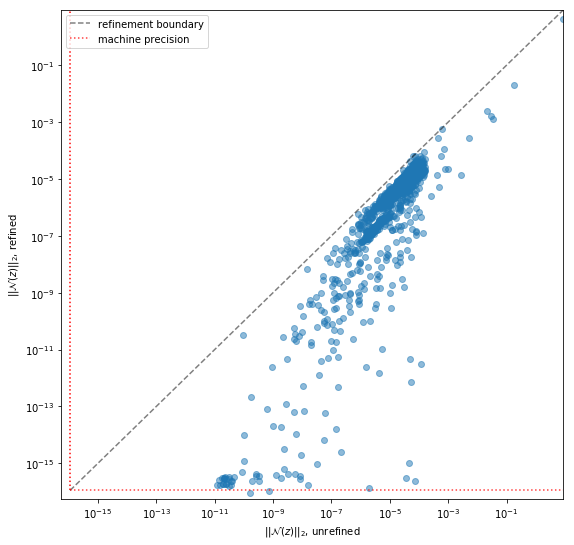

In [6]:
unrefined_Nzs = np.array([el['unrefined_resnorm'] for el in experiment_results])
refined_Nzs  = np.array([el['refined_resnorm'] for el in experiment_results])
timeratio = np.log10(np.array([(el['refine_time']) / (el['solver_time']) for el in experiment_results]))

maxval = max(unrefined_Nzs)
#plt.figure(figsize=(12,6))
fig, left = plt.subplots(1,1,figsize=(9,9))
left.set_xscale('log')
left.set_yscale('log')
col = left.scatter(unrefined_Nzs, refined_Nzs, 
                 # c = timeratio, 
                  alpha=.5, 
                 # cmap='magma'
                 )
# cbar = fig.colorbar(col, shrink=.85, 
#                    ticks=[-3, -2, -1 , 0, 1])
# cbar.ax.set_yticklabels(['$10^{-3}$', '$10^{-2}$', '$10^{-1}$' , '$10^0$', '$10^1$'])

# cbar.ax.set_ylabel('ref. time / solver time')

left.set_xlabel('$\||\mathcal{N}(z) \||_2$, unrefined')
left.set_ylabel('$\||\mathcal{N}(z) \||_2$, refined')
#plt.title('Suboptimality Comparison')
left.plot([EPS,10],[EPS,10], 'k--' , alpha= .5,label='refinement boundary')
plt.plot([EPS,maxval],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
plt.plot([EPS,EPS],[EPS, maxval], 'r:')
left.legend(loc='upper left')
left.set_xlim([EPS/2, maxval])
left.set_ylim([EPS/2, maxval])

plt.savefig('comparison.png')

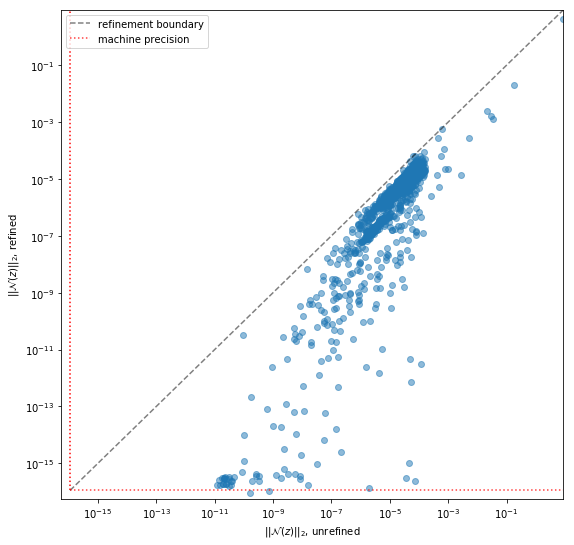

In [7]:
unrefined_Nzs = np.array([el['unrefined_resnorm'] for el in experiment_results])
refined_Nzs  = np.array([el['refined_resnorm'] for el in experiment_results])
timeratio = np.log10(np.array([(el['refine_time']) / (el['solver_time']) for el in experiment_results]))

maxval = max(unrefined_Nzs)
#plt.figure(figsize=(12,6))
fig, left = plt.subplots(1,1,figsize=(9,9))
left.set_xscale('log')
left.set_yscale('log')
col = left.scatter(unrefined_Nzs, refined_Nzs, 
                 # c = timeratio, 
                  alpha=.5, 
                 # cmap='magma'
                 )
# cbar = fig.colorbar(col, shrink=.85, 
#                    ticks=[-3, -2, -1 , 0, 1])
# cbar.ax.set_yticklabels(['$10^{-3}$', '$10^{-2}$', '$10^{-1}$' , '$10^0$', '$10^1$'])

# cbar.ax.set_ylabel('ref. time / solver time')

left.set_xlabel('$\||\mathcal{N}(z) \||_2$, unrefined')
left.set_ylabel('$\||\mathcal{N}(z) \||_2$, refined')
#plt.title('Suboptimality Comparison')
left.plot([EPS,10],[EPS,10], 'k--' , alpha= .5,label='refinement boundary')
plt.plot([EPS,maxval],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
plt.plot([EPS,EPS],[EPS, maxval], 'r:')
left.legend(loc='upper left')
left.set_xlim([EPS/2, maxval])
left.set_ylim([EPS/2, maxval])

plt.savefig('comparison.png')

### Timing analysis 

In [8]:
sol_times = [el['solver_time'] for el in experiment_results]
ref_times = [el['refine_time'] for el in experiment_results]

print('solve time quantiles 10 and 90: ', (np.quantile(sol_times, .1), np.quantile(sol_times, .9)))
print('refine time quantiles 10 and 90: ', (np.quantile(ref_times, .1), np.quantile(ref_times, .9)))

solve time quantiles 10 and 90:  (0.0655031681060791, 9.745199441909792)
refine time quantiles 10 and 90:  (0.02879917621612549, 0.17734234333038332)


In [9]:
ref_factor = np.log10(unrefined_Nzs/ refined_Nzs)

print('refinement factor quantiles 10 and 90: ', (np.quantile(ref_factor, .1), np.quantile(ref_factor, .9)))
print('refinement factor mean: ', (np.mean(ref_factor)))

refinement factor quantiles 10 and 90:  (0.4166143289522457, 3.0768939972156173)
refinement factor mean:  1.378904847308428


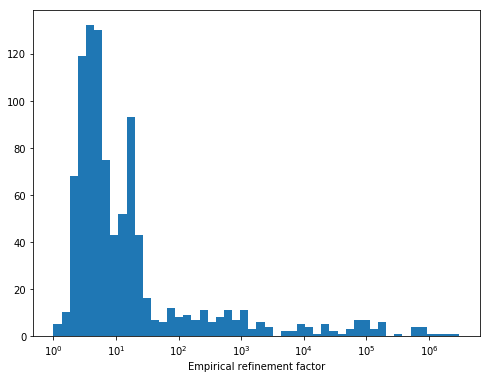

In [10]:
plt.figure(figsize=(8,6))

samples = np.log10(unrefined_Nzs/ refined_Nzs)

samples = samples[samples<6.5]
plt.hist(samples, bins = 50)
#plt.xlim([-5.5, .1])
#plt.xlabel('refined $\||\mathcal{N}(z) \||_2$ / unrefined $\||\mathcal{N}(z) \||_2$ ')
plt.xlabel('Empirical refinement factor')
plt.xticks(range(7), ['$10^{%d}$'%i for i in range(7)])

plt.savefig('improvement.png')

In [11]:
# plt.figure(figsize=(8,6))

# samples = np.log10(refined_Nzs / unrefined_Nzs)

# samples = samples[samples>-5]
# plt.hist(samples, bins = 50)
# plt.xlabel('refined $\||\mathcal{N}(z) \||_2$ / unrefined $\||\mathcal{N}(z) \||_2$ ')

#### Ranges of n and m 

In [12]:
n_s = np.array([el['(m,n)'][1] for el in experiment_results])
m_s = np.array([el['(m,n)'][0] for el in experiment_results])

(array([ 30.,  89., 120., 148., 183., 187., 141.,  69.,  15.,   2.]),
 array([ 271. ,  438.8,  606.6,  774.4,  942.2, 1110. , 1277.8, 1445.6,
        1613.4, 1781.2, 1949. ]),
 <a list of 10 Patch objects>)

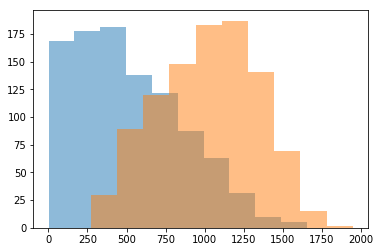

In [13]:
plt.hist(n_s, alpha=.5),
plt.hist(m_s, alpha=.5)

In [14]:
(np.quantile(n_s, .1), np.quantile(n_s, .9)), (np.quantile(m_s, .1), np.quantile(m_s, .9))

((96.30000000000001, 1018.0), (581.0, 1423.0))